# **Segmenter des clients d'un site e-commerce**

## **Importation du fichier SQL**

In [3]:
#  Imports standards (bibliothèques intégrées)
import sys

# Imports des bibliothèques scientifiques et statistiques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm

# Imports des bibliothèques de machine learning et clustering
import hdbscan
import sklearn
from kneed import KneeLocator
from mpl_toolkits.mplot3d import Axes3D

# Import spécifique de scipy.stats
from scipy.stats import levene
from scipy.stats import ttest_ind_from_stats

# Imports spécifiques de scikit-learn
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import (
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_score,
)
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Imports des outils de visualisation pour le clustering
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [4]:
# Afficher la version de Python
print("Python version:", sys.version)

# Afficher la version des bibliothèques déjà importées
print('\n'.join(f'{m.__name__} - {m.__version__}'
         for m in globals().values()
         if getattr(m, '__version__', None)))

Python version: 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:03:56) [MSC v.1929 64 bit (AMD64)]
json - 2.0.9
pandas - 2.2.2
numpy - 1.26.4
pandas - 2.2.2
seaborn - 0.13.2
statsmodels.api - 0.14.2
sklearn - 1.4.2


In [5]:
df_final = pd.read_csv('df_final.csv') 
df_final_encoded = pd.read_csv('df_final_encoded.csv') 
print("Dataframes chargés avec succès ")

Dataframes chargés avec succès 


In [6]:
#S'assurer du bon ordre des index
s1 = df_final['customer_unique_id'].head(10)
s2 = df_final_encoded['customer_unique_id'].head(10)
print(s1.equals(s2))

True


## Clustering Kmeans : Base

In [8]:
df_rfm_encoded = df_final_encoded[['recency', 'frequency', 'monetary']]

In [9]:
df_rfm_encoded.index = df_final_encoded.index 

In [10]:
print(df_final_encoded.index.equals(df_rfm_encoded.index))

True


In [11]:
print(df_rfm_encoded.head())

    recency  frequency  monetary
0  1.501612   -0.22174 -0.141884
1 -0.069928   -0.22174 -0.028890
2 -0.898085   -0.22174 -0.135377
3 -0.461183   -0.22174 -0.126050
4 -1.361070   -0.22174 -0.078752


In [12]:
print("Vérification de la stabilité des données d'entrée :")
print(df_rfm_encoded.describe().round(4))  # Vérifie que les stats restent identiques

Vérification de la stabilité des données d'entrée :
           recency    frequency     monetary
count  119143.0000  119143.0000  119143.0000
mean        0.0000       0.0000       0.0000
std         1.0000       1.0000       1.0000
min        -1.8762      -0.2217      -0.2299
25%        -0.8133      -0.2217      -0.1875
50%        -0.1286      -0.2217      -0.1489
75%         0.7126      -0.2217      -0.0602
max         3.1579      38.7117      65.2576


### 1. Cluster sur les variables RFM - Test avec 4 clusters

In [14]:
N_CLUSTERS = 4

kmeans = KMeans(n_clusters=N_CLUSTERS, init='k-means++', n_init=10, random_state=42)
clusters = kmeans.fit_predict(df_rfm_encoded)

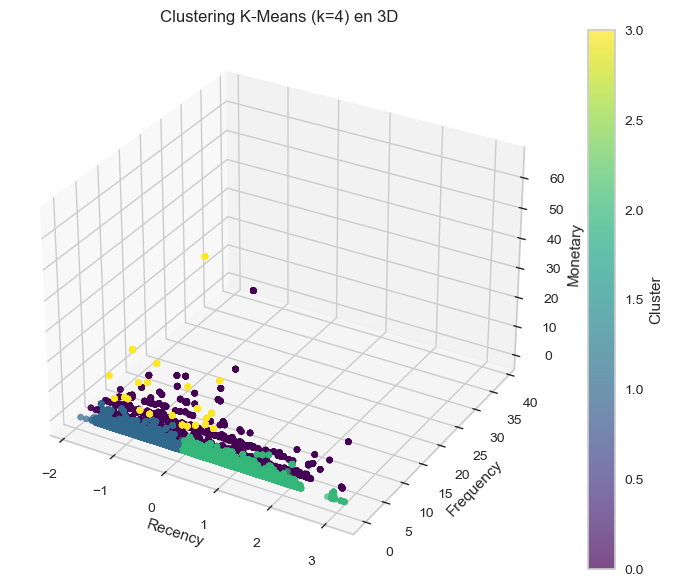

In [15]:
fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(111, projection = '3d')

# Scatter plot en 3D
scatter = ax.scatter(df_rfm_encoded['recency'], 
                     df_rfm_encoded['frequency'], 
                     df_rfm_encoded['monetary'], 
                     c = clusters, cmap = 'viridis', alpha = 0.7)

# Labels des axes

ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
ax.set_title("Clustering K-Means (k=4) en 3D")

# Ajouter une légende (barre de couleur)

plt.colorbar(scatter, ax = ax, label="Cluster")
plt.show()

#### Calcul du nombre optimal de clusters

#### Déterminer le nombre optimal de clusters avec des méthodes data-driven.
- **Méthode du coude** pour déterminer l'inertie: distance intra-cluster en fonction du nombre de clusters. Le "coude" est le point où l'inertie diminue moins rapidement, ce qui est généralement un bon choix pour K.
- **Méthode du Silhouette Score** pour évaluer la qualité du clustering. Un score élevé indique que les clusters sont bien séparés.

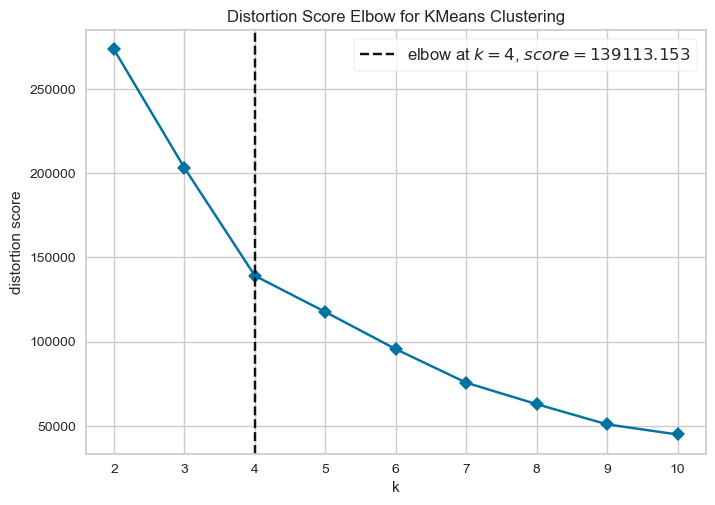

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [18]:
visualizer = KElbowVisualizer(KMeans(init='k-means++', n_init = 10, random_state = 42), k = (2,11), metric = 'distortion', timings = False)
visualizer.fit(df_rfm_encoded)
visualizer.show()

Ici le coude se situe à 4 clusters avec une distance instra_inertie la plus faible. 

- Le coude dit que 4 clusters est un bon compromis entre simplicité et efficacité.
- Le score de silhouette dit comment les clusters sont bien séparés et cohérents c'est pourquoi le nombre de clusters peut changer.

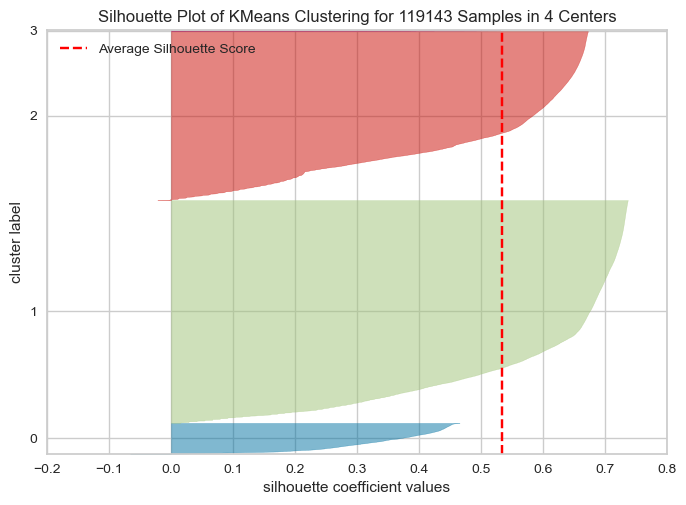

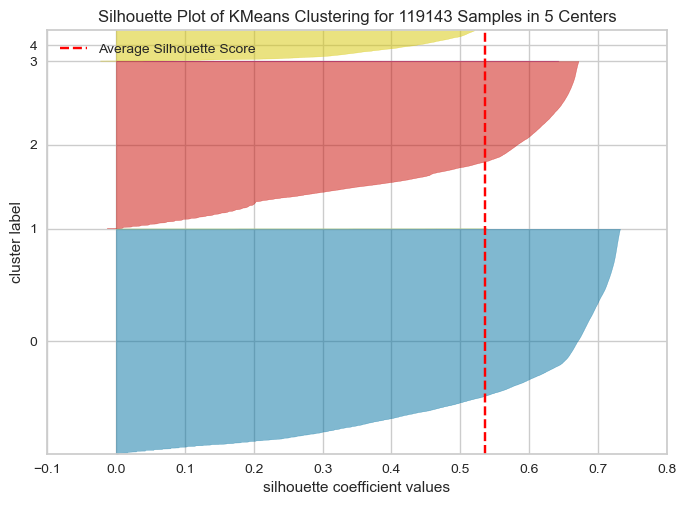

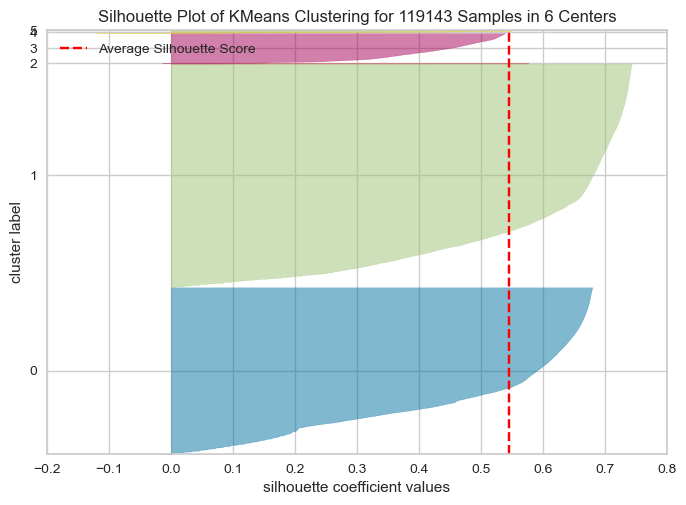

In [21]:
# Tester plusieurs valeurs de k autour de celui trouvé avec le coude
for k in range(4, 7): 
    model = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    
    # Visualisation des silhouettes
    visualizer = SilhouetteVisualizer(model, colors = 'yellowbrick')
    visualizer.fit(df_rfm_encoded)
    visualizer.show()

**Interprétation:**
Chaque couleur représente un cluster, et l’axe horizontal montre la qualité de la séparation des points dans chaque cluster
On voit tout de suite que certains clusters se chevauchent. Nous allons compter le nombre d'observatios par cluster, ainsi que calculer le silhouette score moyen pour voir dans quel situation il est le plus élevé.


In [23]:
for k in [4, 5, 6]:
    labels = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42).fit_predict(df_rfm_encoded)
    score = silhouette_score(df_rfm_encoded, labels)
    print(f"Silhouette Score for {k} clusters: {score}")


Silhouette Score for 4 clusters: 0.5340980028718342
Silhouette Score for 5 clusters: 0.5354324816663778
Silhouette Score for 6 clusters: 0.545589634000821


Ici nous choisissons 5 Clusters pour avoir un équilibre entre bonne performance et nombre de cluster logique au niveau métier

#### Justifier le choix avec des métriques: 
- **le Silhouette Score**: Mesure la compacité et la séparation des clusters. Valeurs proches de 1 indiquent de bons clusters. Vérifie  la séparation entre eux. Peut montrer si certains clusters sont trop éparpillés ou mélangés
- **le Calinski-Harabasz** Rapport entre la dispersion inter-cluster et intra-cluster. Plus la valeur est élevée, mieux c’est. Évalue globalement la séparation entre les clusters. Indique si les clusters sont bien distincts dans l’espace des features.
- **le Davies-Bouldin Index**: Compare la similarité entre clusters. Une valeur faible indique un bon clustering = bien distinct. Utile pour détecter des clusters trop proches ou mal définis.

In [26]:
OPTIMAL_K = 5
kmeans_optimal = KMeans(n_clusters=OPTIMAL_K, init='k-means++', n_init=10, random_state=42)
clusters_optimal = kmeans_optimal.fit_predict(df_rfm_encoded)

# Calcul des métriques d'évaluation pour les clusters
calinski_score = calinski_harabasz_score(df_rfm_encoded, clusters_optimal)
db_score = davies_bouldin_score(df_rfm_encoded, clusters_optimal)

print(f'Métriques pour k={OPTIMAL_K}:')
print(f'Calinski-Harabasz Score: {calinski_score}')
print(f'Davies-Bouldin Score: {db_score}')

Métriques pour k=5:
Calinski-Harabasz Score: 60721.311339437634
Davies-Bouldin Score: 0.6136832511717005


Variance expliquée par les composantes PCA : [0.36644268 0.33187297]
Total variance expliquée : 0.6983156474021228


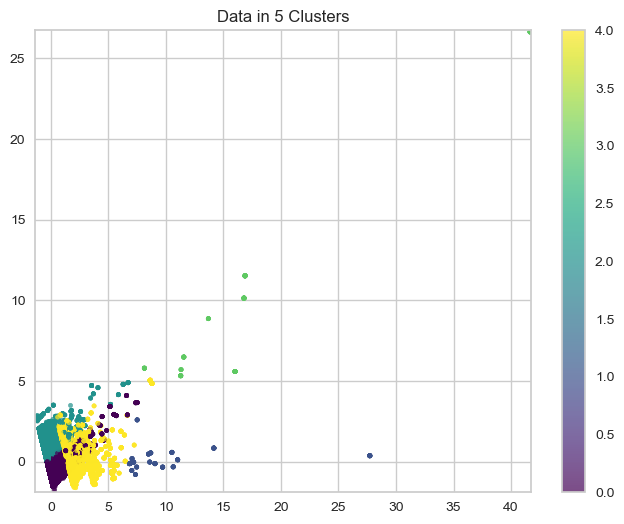

In [27]:
# Appliquer la PCA sur les données normalisées
pca = PCA(n_components=2, random_state=42)
df_pca_rfm = pca.fit_transform(df_rfm_encoded)

# Convertir en DataFrame
df_pca_rfm = pd.DataFrame(df_pca_rfm, columns=['PCA1', 'PCA2'])
df_pca_rfm['Cluster'] = clusters_optimal  # Assigne les clusters

# Vérifier la variance expliquée
print("Variance expliquée par les composantes PCA :", pca.explained_variance_ratio_)
print(f"Total variance expliquée : {sum(pca.explained_variance_ratio_)}")

# Tracer le scatter plot avec ajustement d'échelle et taille des points
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca_rfm['PCA1'], 
                       df_pca_rfm['PCA2'], 
                       c=df_pca_rfm['Cluster'], 
                       cmap='viridis', 
                       alpha=0.7, 
                       s=10)  # Augmente la taille des points pour les voir

# Ajouter des limites 
plt.xlim(df_pca_rfm['PCA1'].min() - 0.1, df_pca_rfm['PCA1'].max() + 0.1)
plt.ylim(df_pca_rfm['PCA2'].min() - 0.1, df_pca_rfm['PCA2'].max() + 0.1)

# Ajouter titre et colorbar
plt.colorbar(scatter)
plt.title(f"Data in {len(set(clusters_optimal))} Clusters")
plt.show()

In [28]:
df_rfm_encoded = df_rfm_encoded.copy()
df_rfm_encoded['Cluster'] = clusters_optimal 

In [29]:
print(df_rfm_encoded['Cluster'].value_counts().sort_index())

Cluster
0    63286
1      161
2    47040
3      117
4     8539
Name: count, dtype: int64


#### Calcul des moyennes 

In [31]:
# Calculer les moyennes par cluster dans l'espace normalisé et les trier
cluster_means_scaled = df_rfm_encoded.groupby('Cluster')[['recency', 'frequency', 'monetary']].mean().sort_index()

print("Moyennes en échelle normalisée (avec tri des clusters) :")
print(cluster_means_scaled)

Moyennes en échelle normalisée (avec tri des clusters) :
          recency  frequency   monetary
Cluster                                
0       -0.717117  -0.221740  -0.041186
1       -0.714608  15.103758   0.516519
2        0.982046  -0.221740  -0.044380
3       -0.295875   1.587666  23.157305
4       -0.077561   2.558404   0.222692


In [32]:
print("Vérification de la stabilité des données d'entrée :")
print(df_rfm_encoded.describe().round(4))  # Vérifie que les stats restent identiques

Vérification de la stabilité des données d'entrée :
           recency    frequency     monetary      Cluster
count  119143.0000  119143.0000  119143.0000  119143.0000
mean        0.0000       0.0000       0.0000       1.0806
std         1.0000       1.0000       1.0000       1.2524
min        -1.8762      -0.2217      -0.2299       0.0000
25%        -0.8133      -0.2217      -0.1875       0.0000
50%        -0.1286      -0.2217      -0.1489       0.0000
75%         0.7126      -0.2217      -0.0602       2.0000
max         3.1579      38.7117      65.2576       4.0000


Soit utilisation des moyennes des valeurs normalisées c'est pourquoi elles peuvent être négatives et aussi proches de 0;

**Interprétation pour les moyennes normalisées:** 
- Une valeur positive signifie que la variable est au-dessus de la moyenne. 
- Une valeur négative signifie que la variable est en dessous de la moyenne.
- Plus la valeur est éloignée de 0, plus elle est extrême.


Soit fonction pour calculer les moyennes originales : retransformer les moyennes des clusters d'un espace standardisé (après transformation avec StandardScaler) vers l'échelle d'origine des données ce qui est plus facile d'interprétation.
- StandardScaler : X_original = X_scaled . std + mean

In [35]:
def inverse_transform_mean(cluster_means_scaled, df_final, quantitative_features, target_features):
    """
    Applique l'inverse_transform pour un sous-ensemble de colonnes (target_features)
    en utilisant un StandardScaler réajusté sur df_final.

    Paramètres:
    - cluster_means_scaled : DataFrame avec les moyennes par cluster dans l'espace transformé.
    - df_final : DataFrame d'origine non transformé (pour recalculer le StandardScaler).
    - quantitative_features : Liste des features quantitatives standardisées.
    - target_features : Liste des features pour lesquelles on veut revenir à l'échelle d'origine.

    Returns:
    - DataFrame avec les moyennes retransformées dans l'échelle d'origine.
    
    """

    # Recréer et ajuster StandardScaler sur df_final
    scaler = StandardScaler()
    scaler.fit(df_final[quantitative_features])  # Ajustement uniquement sur les variables quantitatives

    # Dictionnaire pour stocker les valeurs originales
    cluster_means_original = {}

    for feature in target_features:
        if feature in quantitative_features:  # Vérifie si la variable a été standardisée
            index = quantitative_features.index(feature)  # Position de la colonne dans le scaler
            mean = scaler.mean_[index]  # Moyenne utilisée par StandardScaler
            scale = scaler.scale_[index]  # Écart type utilisé par StandardScaler
            cluster_means_original[feature] = cluster_means_scaled[feature] * scale + mean  # Inverse de la standardisation
        elif feature == 'has_review':  # Cas spécial : ajouter has_review directement
            cluster_means_original[feature] = cluster_means_scaled[feature]  # Pas de transformation

    # Conversion en DataFrame
    return pd.DataFrame(cluster_means_original, index=cluster_means_scaled.index)



In [36]:
# Liste des variables quantitatives et cibles
quantitative_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment', 'diversity_products', 'avg_installments']
target_features = ['recency', 'frequency', 'monetary']

In [37]:
# Appel de la fonction pour récupérer les moyennes dans l'échelle d'origine
cluster_means_original = inverse_transform_mean(
    cluster_means_scaled,  # DataFrame des moyennes normalisées par cluster
    df_final,              # DataFrame original non transformé
    quantitative_features, # Variables standardisées
    target_features        # Variables à inverser
)

# Affichage des moyennes en échelle d'origine
print("Moyennes en échelle d'origine:")
print(cluster_means_original)

Moyennes en échelle d'origine:
            recency  frequency      monetary
Cluster                                     
0        177.751809   1.000000    314.956449
1        178.136646   7.298137   1245.884720
2        438.323129   1.000000    309.623445
3        242.350427   1.743590  39038.205385
4        275.829488   2.142523    755.423811


Attention la variable recency est inversée = plus elle est faible plus le client est récent

- Cluster 0: Nouveaux clients
- Cluster 1: Clients qui achètent fréquemment et bonnes dépenses
- Cluster 2: Clients inactifs
- Cluster 3: Clients qui dépensent énorméments
- CLuster 4: Clients moyens achètent fréquemment et bonne dépenses

#### Test d'égalité des moyennes
La fonction ttest_ind_from_stats effectue un test t pour comparer les moyennes de deux échantillons indépendants
- H0 : Les moyennes des deux groupes sont statistiquement égales.
- H1: Les moyennes des deux groupes sont statistiquement différentes
  
Si la p-value est inférieure au seuil de 0.05 alors rejet de l'hypothèse nulle et les moyennes des deux clusters sont statistiquement différentes.

Le t-statistic mesure l'écart entre les moyennes des deux groupes, en tenant compte de la variance dans chaque groupe. 
Un t-stat élevé (positif ou négatif) indique une grande différence entre les moyennes des deux clusters. Une t-stat proche de zéro suggère que les moyennes sont similaires.

#### **Test d'égalité de variance**

Avant de faire le t-test d'égalité des moyennes j'effectue le test de Levene (plus robuste aux distributions non normales et fonctionne bien avec des échantillons de tailles différentes avec les hypothèses suivantes afin de savoir si equal_var = False ou True.  
- Hypothèse nulle: Les variances des deux groupes sont égales.
- Hypothèse alternative: Les variances sont différentes.

Il vaut mieux faire le test sur les moyennes originales car la normalisation modifie la variance, le résultat du test peut alors être biaisé. 

In [41]:
for feature in ['recency', 'frequency', 'monetary']:
    print(f"\n=== Test de Levene pour la variable {feature} ===")

    for i in cluster_means_original.index:
        for j in cluster_means_original.index:
            if j > i:
                group_1 = df_rfm_encoded[df_rfm_encoded['Cluster'] == i][feature]
                group_2 = df_rfm_encoded[df_rfm_encoded['Cluster'] == j][feature]


                # Vérifier si la variance est nulle
                if group_1.var() == 0 or group_2.var() == 0:
                    print(f"Clusters {i} vs {j} : Test ignoré (variance nulle).")
                    continue

                # Appliquer le test de Levene
                stat, p_value = levene(group_1, group_2)

                # Vérifier si les résultats sont valides
                if not (pd.isna(stat) or pd.isna(p_value)):
                    print(f"Clusters {i} vs {j} : Stat W = {stat:.4f}, p-value = {p_value:.4f}")
                    if p_value > 0.05:
                        print("Les variances sont égales (on ne rejette pas H0).")
                    else:
                        print("Les variances sont différentes (on rejette H0).")
                else:
                    print(f"Clusters {i} vs {j} : Test ignoré (NaN détecté).")



=== Test de Levene pour la variable recency ===
Clusters 0 vs 1 : Stat W = 25.8889, p-value = 0.0000
Les variances sont différentes (on rejette H0).
Clusters 0 vs 2 : Stat W = 4458.5604, p-value = 0.0000
Les variances sont différentes (on rejette H0).
Clusters 0 vs 3 : Stat W = 186.3688, p-value = 0.0000
Les variances sont différentes (on rejette H0).
Clusters 0 vs 4 : Stat W = 12561.5828, p-value = 0.0000
Les variances sont différentes (on rejette H0).
Clusters 1 vs 2 : Stat W = 0.5985, p-value = 0.4392
Les variances sont égales (on ne rejette pas H0).
Clusters 1 vs 3 : Stat W = 11.2734, p-value = 0.0009
Les variances sont différentes (on rejette H0).
Clusters 1 vs 4 : Stat W = 41.3037, p-value = 0.0000
Les variances sont différentes (on rejette H0).
Clusters 2 vs 3 : Stat W = 33.2779, p-value = 0.0000
Les variances sont différentes (on rejette H0).
Clusters 2 vs 4 : Stat W = 3385.0020, p-value = 0.0000
Les variances sont différentes (on rejette H0).
Clusters 3 vs 4 : Stat W = 2.3522

C:\Users\alaro\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:3345: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom


In [42]:
# Un test ignoré car les deux valeurs sont identiques , la plupart des variances sont différentes
print(f"Cluster 0 - Frequency unique values: {df_rfm_encoded[df_rfm_encoded['Cluster'] == 0]['frequency'].unique()}")
print(f"Cluster 2 - Frequency unique values: {df_rfm_encoded[df_rfm_encoded['Cluster'] == 2]['frequency'].unique()}")

Cluster 0 - Frequency unique values: [-0.22173988]
Cluster 2 - Frequency unique values: [-0.22173988]


In [43]:
# Boucle sur les features RFM
for feature in ['recency', 'frequency', 'monetary']:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_original.index:
        for j in cluster_means_original.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_rfm_encoded[df_rfm_encoded['Cluster'] == i][feature]
                group_2 = df_rfm_encoded[df_rfm_encoded['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_original.loc[i, feature]
                mean_2 = cluster_means_original.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var = False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=-6.4407, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=-75285.6269, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=-831.1295, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=-9214.3681, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=-4351.5595, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=-655.2408, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=-1611.2192, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=2520.3888, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 4): t-stat=14950.9485, p-value=0.0000
T-test Recency (Cluster 3 vs Cluster 4): t-stat=-427.0084, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=-9.3037, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=0.0000, p-value=1.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=-2.7606, p-value=0.0067
T-test Frequency (Cluster 0 vs Clus

Interprète directement les différences en unités réelles: si la p-value est élevé, il n’y a pas de preuve significative de différence de moyenne dans le contexte des valeurs réelles

- T-test Frequency (Cluster 0 vs Cluster 2): t-stat=0.0000, p-value=1.0000
- T-test Frequency (Cluster 3 vs Cluster 4): t-stat=-1.4799, p-value=0.1416

In [45]:
# Test pour voir les différences sur les moyennes standardisées

for feature in ['recency', 'frequency', 'monetary']:
    print(f"\n=== Test de Levene pour la variable {feature} ===")

    for i in cluster_means_scaled.index:
        for j in cluster_means_scaled.index:
            if j > i:
                group_1 = df_rfm_encoded[df_rfm_encoded['Cluster'] == i][feature]
                group_2 = df_rfm_encoded[df_rfm_encoded['Cluster'] == j][feature]


                # Vérifier si la variance est nulle
                if group_1.var() == 0 or group_2.var() == 0:
                    print(f"Clusters {i} vs {j} : Test ignoré (variance nulle).")
                    continue

                # Appliquer le test de Levene
                stat, p_value = levene(group_1, group_2)

                # Vérifier si les résultats sont valides
                if not (pd.isna(stat) or pd.isna(p_value)):
                    print(f"Clusters {i} vs {j} : Stat W = {stat:.4f}, p-value = {p_value:.4f}")
                    if p_value > 0.05:
                        print("Les variances sont égales (on ne rejette pas H0).")
                    else:
                        print("Les variances sont différentes (on rejette H0).")
                else:
                    print(f"Clusters {i} vs {j} : Test ignoré (NaN détecté).")


=== Test de Levene pour la variable recency ===
Clusters 0 vs 1 : Stat W = 25.8889, p-value = 0.0000
Les variances sont différentes (on rejette H0).
Clusters 0 vs 2 : Stat W = 4458.5604, p-value = 0.0000
Les variances sont différentes (on rejette H0).
Clusters 0 vs 3 : Stat W = 186.3688, p-value = 0.0000
Les variances sont différentes (on rejette H0).
Clusters 0 vs 4 : Stat W = 12561.5828, p-value = 0.0000
Les variances sont différentes (on rejette H0).
Clusters 1 vs 2 : Stat W = 0.5985, p-value = 0.4392
Les variances sont égales (on ne rejette pas H0).
Clusters 1 vs 3 : Stat W = 11.2734, p-value = 0.0009
Les variances sont différentes (on rejette H0).
Clusters 1 vs 4 : Stat W = 41.3037, p-value = 0.0000
Les variances sont différentes (on rejette H0).
Clusters 2 vs 3 : Stat W = 33.2779, p-value = 0.0000
Les variances sont différentes (on rejette H0).
Clusters 2 vs 4 : Stat W = 3385.0020, p-value = 0.0000
Les variances sont différentes (on rejette H0).
Clusters 3 vs 4 : Stat W = 2.3522

C:\Users\alaro\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:3345: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom


Il en resort quand même que la plupart des variances sont différentes même avec les valeurs standardisées, il faut dans tous les cas utiliser equal_var= False dans le t-test. 

In [47]:
#Boucle sur les features
for feature in ['recency', 'frequency', 'monetary']:
    # Compare les paires de clusters
    for i in range(len(cluster_means_scaled)):  # Clusters de 0 à N-1, i= 1er cluster dans la comparaison
        for j in range(i+1, len(cluster_means_scaled)):  # j = 2nd cluster dans la comparaison, j > i 
            # Obtenir les données des groupes
            group_1 = df_rfm_encoded[df_rfm_encoded['Cluster'] == i][feature]
            group_2 = df_rfm_encoded[df_rfm_encoded['Cluster'] == j][feature]

            # Utiliser les moyennes de moyennes_par_cluster
            mean_1 = cluster_means_scaled.loc[i, feature]
            mean_2 = cluster_means_scaled.loc[j, feature]

            # Calculer les écarts-types et tailles des groupes
            std_1 = group_1.std()  # Calcul de l'écart-type du groupe 1
            std_2 = group_2.std()  # Calcul de l'écart-type du groupe 2
            n_1 = len(group_1)     # Taille du groupe 1
            n_2 = len(group_2)     # Taille du groupe 2

            # Effectuer le test t avec les statistiques calculées
            t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1, mean_2, std_2, n_2, equal_var = False)

            # Afficher les résultats du test t
            print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=-0.0420, p-value=0.9666
T-test Recency (Cluster 0 vs Cluster 2): t-stat=-490.9312, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=-5.4197, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=-60.0861, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=-28.3762, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=-4.2728, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=-10.5066, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=16.4352, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 4): t-stat=97.4939, p-value=0.0000
T-test Recency (Cluster 3 vs Cluster 4): t-stat=-2.7845, p-value=0.0062
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=-22.6389, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=0.0000, p-value=1.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=-6.7174, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 4): t-stat=-26

Interprète en termes d’écarts-types par rapport à la moyenne globale. Un p-value élevé ici signifie qu’une fois les variables remises sur la même échelle, les différences de moyennes standardisées entre clusters ne sont pas significatives.

- T-test Recency (Cluster 0 vs Cluster 1): t-stat=-0.0420, p-value=0.9666- T-test Frequency (Cluster 0 vs Cluster 2): t-stat=0.0000, p-value=1.0000
- T-test Monetary (Cluster 0 vs Cluster 2): t-stat=1.0378, p-value=0.2993

On remarque que ce ne sont pas les mêmes clusters qui ont des moyennes statistiquement égales à part pour la variable Frequency entre le Cluster 0 et 2.

### 2. Ajout de la variable avg_review

In [50]:
df_satisfaction = df_final_encoded[['recency','frequency', 'monetary','avg_review']]

#### Choix du nombre de cluster optimal

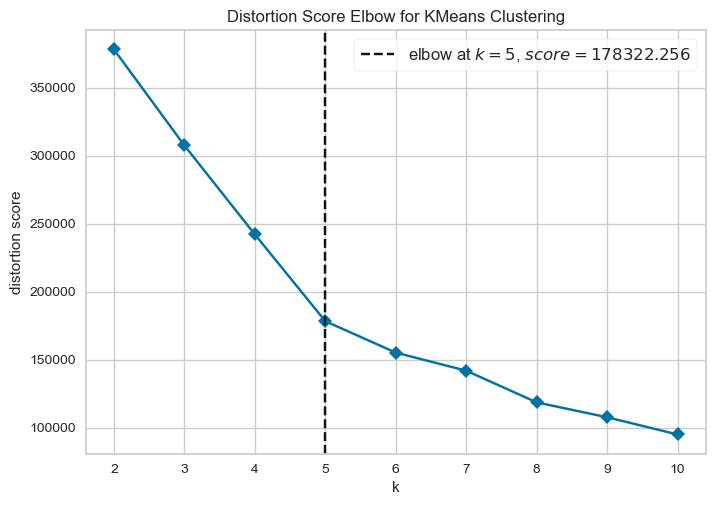

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [52]:
visualizer = KElbowVisualizer(KMeans(init='k-means++', n_init=10, random_state=42), k=(2,11), metric='distortion', timings=False)
visualizer.fit(df_satisfaction)
visualizer.show()

Le coude se situe à k=5

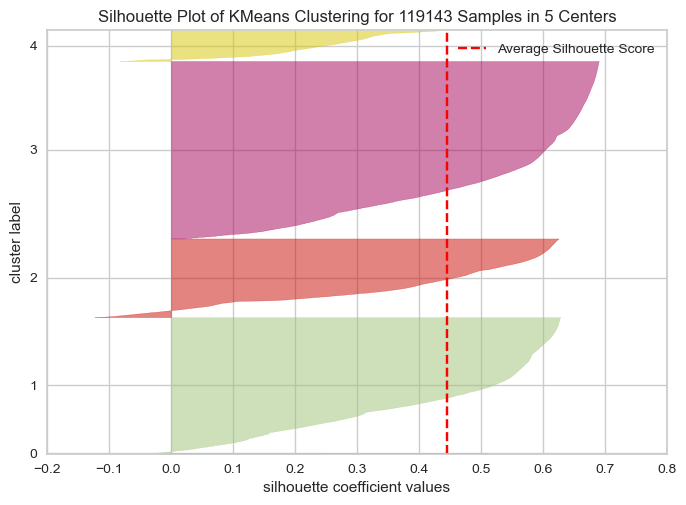

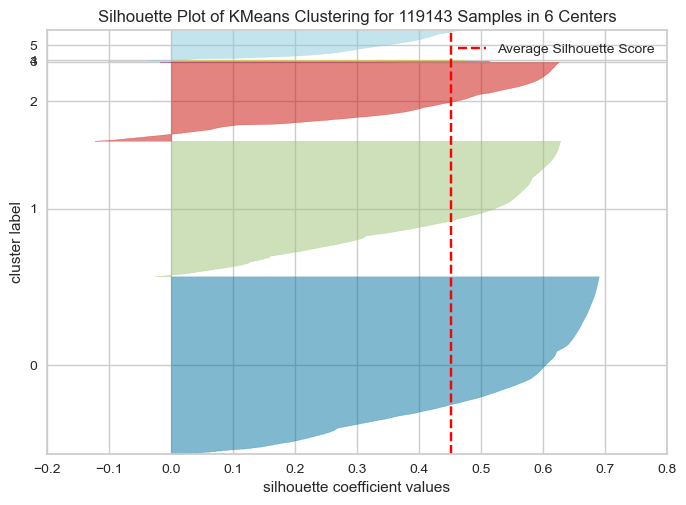

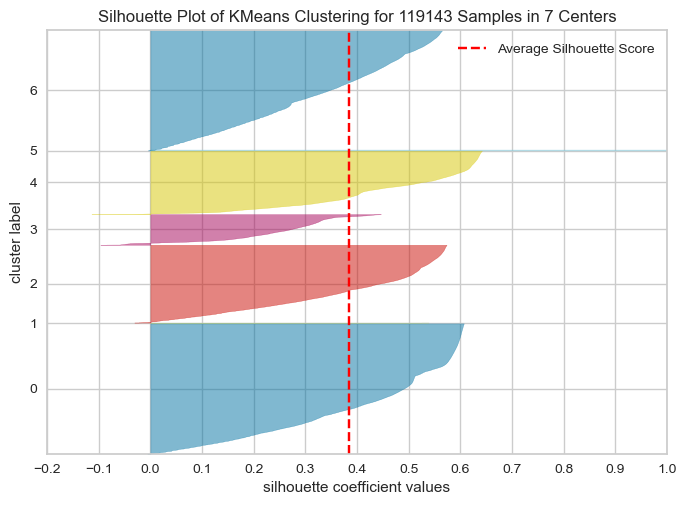

In [54]:
# Tester plusieurs valeurs de k autour de celui trouvé avec le coude
for k in range(5, 8):  
    model = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    
    # Visualisation des silhouettes
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
    visualizer.fit(df_satisfaction)
    visualizer.show()

In [55]:
for k in [4, 5, 6]:
    labels = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42).fit_predict(df_satisfaction)
    score = silhouette_score(df_satisfaction, labels)
    print(f"Silhouette Score for {k} clusters: {score}")


Silhouette Score for 4 clusters: 0.39507360139781056
Silhouette Score for 5 clusters: 0.4455236309936748
Silhouette Score for 6 clusters: 0.4517178748090527


Ici nous resterons avec 5 clusters

In [57]:
optimal_k_satisfaction = 5
kmeans_optimal = KMeans(n_clusters=optimal_k_satisfaction, init='k-means++', n_init=10, random_state=42)
clusters_optimal_satisfaction = kmeans_optimal.fit_predict(df_satisfaction)

# Calcul des métriques d'évaluation pour les clusters
calinski_score = calinski_harabasz_score(df_satisfaction, clusters_optimal_satisfaction)
db_score = davies_bouldin_score(df_satisfaction, clusters_optimal_satisfaction)

print(f'Métriques pour k={optimal_k_satisfaction}:')
print(f'Calinski-Harabasz Score: {calinski_score}')
print(f'Davies-Bouldin Score: {db_score}')

Métriques pour k=5:
Calinski-Harabasz Score: 49815.540024311
Davies-Bouldin Score: 0.7445529999168805


Variance expliquée par les composantes PCA : [0.27968997 0.26174312]
Total variance expliquée : 0.5414330863203602


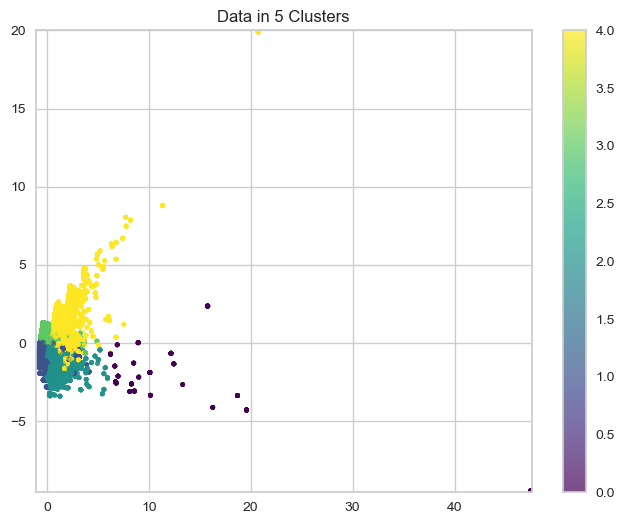

In [58]:
# Appliquer la PCA sur les données normalisées
pca = PCA(n_components=2, random_state=42)
df_pca_satisfaction = pca.fit_transform(df_satisfaction)

# Convertir en DataFrame
df_pca_satisfaction = pd.DataFrame(df_pca_satisfaction, columns=['PCA1', 'PCA2'])
df_pca_satisfaction['Cluster'] = clusters_optimal_satisfaction  # Assigne les clusters

# Vérifier la variance expliquée
print("Variance expliquée par les composantes PCA :", pca.explained_variance_ratio_)
print(f"Total variance expliquée : {sum(pca.explained_variance_ratio_)}")

# Tracer le scatter plot avec ajustement d'échelle et taille des points
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca_satisfaction['PCA1'], 
                       df_pca_satisfaction['PCA2'], 
                       c=df_pca_satisfaction['Cluster'], 
                       cmap='viridis', 
                       alpha=0.7, 
                       s=10)  # Augmenter la taille des points pour les voir

# Ajouter des limites 
plt.xlim(df_pca_satisfaction['PCA1'].min() - 0.1, df_pca_satisfaction['PCA1'].max() + 0.1)
plt.ylim(df_pca_satisfaction['PCA2'].min() - 0.1, df_pca_satisfaction['PCA2'].max() + 0.1)

# Ajouter titre et colorbar
plt.colorbar(scatter)
plt.title(f"Data in {len(set(clusters_optimal_satisfaction))} Clusters")
plt.show()

#### Calcul des moyennes 

In [60]:
# Ajouter les clusters au DataFrame original
df_satisfaction = df_satisfaction.copy()  # Éviter la modification sur une vue
df_satisfaction.loc[:, 'Cluster'] = clusters_optimal_satisfaction


# Calcul des moyennes par cluster
cluster_means_scaled_1 = df_satisfaction.groupby('Cluster')[['recency', 'frequency', 'monetary','avg_review']].mean().sort_index()
print(cluster_means_scaled_1)

          recency  frequency   monetary  avg_review
Cluster                                            
0       -0.116570   0.976354  15.937866   -1.109777
1        1.011591  -0.221230  -0.069578    0.437085
2        0.018083  -0.221740   0.041733   -1.793661
3       -0.764130  -0.221740  -0.079154    0.460172
4       -0.094429   2.793912   0.174317    0.039523


In [61]:
print(df_satisfaction['Cluster'].value_counts().sort_index())

Cluster
0      262
1    38160
2    22138
3    49933
4     8650
Name: count, dtype: int64


In [62]:
quantitative_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment', 'diversity_products', 'avg_installments']
target_features = ['recency', 'frequency', 'monetary', 'avg_review']


In [63]:
cluster_means_original_1 = inverse_transform_mean(
    cluster_means_scaled_1,  # DataFrame des moyennes normalisées par cluster
    df_final,              # DataFrame original non transformé
    quantitative_features, # Variables standardisées
    target_features        # Variables à inverser
)

print("Moyennes en échelle d'origine:")
print(cluster_means_original_1)


Moyennes en échelle d'origine:
            recency  frequency      monetary  avg_review
Cluster                                                 
0        269.847328   1.492366  26987.416489    2.488550
1        442.853957   1.000210    267.563970    4.628485
2        290.496793   1.000000    453.365912    1.542461
3        170.542307   1.000000    251.579696    4.660425
4        273.242775   2.239306    674.676805    4.078497


- Cluster 0 : Clients fidèles et gros dépensiers, mais insatisfaits => se différencie par dépenses élevées
- Cluster 1 : Clients perdus, inactifs et dépensant peu, mais satisfaits => se différencie par l'inactivité 
- Cluster 2 : Clients  moyennement récents mais peu fidèles, dépenses faibles à moyennes, mais très insatisfaits => se différencie par l'insatisfaction
- Cluster 3 : Clients très récents, qui ont commandé une seule fois, clients nouveaux et satisfaits =>  se différencie par leur satisfaction et nouveaux clients
- Cluster 4 : Clients fréquents, dépenses bonnes, satisfaits => se différencie par leur fréquence d'achat

#### Interprétation ajout de la variable avg_review: 


**Rappel modèle de base:** 
- Silhouette : 0.54
- Calinski-Harabasz Score: 60721- Davies-Bouldin Score: 0.61

**Rappel modèle avg_review**
- Silhouette : 0.45
- Calinski-Harabasz : 49815
- Davies-Bouldin : 0.74


L'ajout d’avg_review apporte une dimension sur la satisfaction client, mais réduit la séparation globale des clusters (silhouette et CH plus faibles, DB plus élevé).
- Le silhouette score a diminué : l'ajout de avg_review a réduit la cohérence interne des clusters, ce qui signifie que les points sont moins bien regroupés.
  
- Le Calinski Harabasz a aussi diminué : L'ajout de avg_review semble avoir détérioré la séparation et la compacité des clusters.
- Le DB a augmenté:  L'ajout de avg_review augmente le chevauchement entre les clusters

#### Test moyenne

In [67]:
for feature in ['recency', 'frequency', 'monetary', 'avg_review']:
    print(f"\n=== Test de Levene pour la variable {feature} ===")

    for i in cluster_means_original_1.index:
        for j in cluster_means_original_1.index:
            if j > i:
                group_1 = df_satisfaction[df_satisfaction['Cluster'] == i][feature]
                group_2 = df_satisfaction[df_satisfaction['Cluster'] == j][feature]


                # Vérifier si la variance est nulle
                if group_1.var() == 0 or group_2.var() == 0:
                    print(f"Clusters {i} vs {j} : Test ignoré (variance nulle).")
                    continue

                # Appliquer le test de Levene
                stat, p_value = levene(group_1, group_2)

                # Vérifier si les résultats sont valides
                if not (pd.isna(stat) or pd.isna(p_value)):
                    print(f"Clusters {i} vs {j} : Stat W = {stat:.4f}, p-value = {p_value:.4f}")
                    if p_value > 0.05:
                        print("→ Les variances sont égales (on ne rejette pas H0).")
                    else:
                        print("→ Les variances sont différentes (on rejette H0).")
                else:
                    print(f"Clusters {i} vs {j} : Test ignoré (NaN détecté).")


=== Test de Levene pour la variable recency ===
Clusters 0 vs 1 : Stat W = 17.4009, p-value = 0.0000
→ Les variances sont différentes (on rejette H0).
Clusters 0 vs 2 : Stat W = 3.1139, p-value = 0.0776
→ Les variances sont égales (on ne rejette pas H0).
Clusters 0 vs 3 : Stat W = 183.4039, p-value = 0.0000
→ Les variances sont différentes (on rejette H0).
Clusters 0 vs 4 : Stat W = 26.5778, p-value = 0.0000
→ Les variances sont différentes (on rejette H0).
Clusters 1 vs 2 : Stat W = 1663.9654, p-value = 0.0000
→ Les variances sont différentes (on rejette H0).
Clusters 1 vs 3 : Stat W = 3498.8245, p-value = 0.0000
→ Les variances sont différentes (on rejette H0).
Clusters 1 vs 4 : Stat W = 3336.7646, p-value = 0.0000
→ Les variances sont différentes (on rejette H0).
Clusters 2 vs 3 : Stat W = 7933.8002, p-value = 0.0000
→ Les variances sont différentes (on rejette H0).
Clusters 2 vs 4 : Stat W = 285.5017, p-value = 0.0000
→ Les variances sont différentes (on rejette H0).
Clusters 3 vs

C:\Users\alaro\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:3345: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom


In [68]:
# Boucle sur les features RFM
for feature in ['recency', 'frequency', 'monetary', 'avg_review']:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_original_1.index:
        for j in cluster_means_original_1.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_satisfaction[df_satisfaction['Cluster'] == i][feature]
                group_2 = df_satisfaction[df_satisfaction['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_original_1.loc[i, feature]
                mean_2 = cluster_means_original_1.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=-3909.1596, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=-463.7322, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=2247.0806, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=-74.8752, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=22870.3772, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=71333.8050, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=15613.5013, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=19273.9670, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 4): t-stat=1447.0680, p-value=0.0000
T-test Recency (Cluster 3 vs Cluster 4): t-stat=-9688.6434, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=3.6542, p-value=0.0003
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=3.6558, p-value=0.0003
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=3.6558, p-value=0.0003
T-test Frequency (Cluster 0 vs Clust

- T-test Frequency (Cluster 1 vs Cluster 2): t-stat=1.1625, p-value=0.2451
- T-test Frequency (Cluster 1 vs Cluster 3): t-stat=1.1625, p-value=0.2451
- T-test Frequency (Cluster 2 vs Cluster 3): t-stat=0.0000, p-value=1.0000

In [70]:
for feature in ['recency', 'frequency', 'monetary','avg_review']:
    # Compare les paires de clusters
    for i in range(len(cluster_means_scaled_1)):  # Clusters de 0 à N-1
        for j in range(i+1, len(cluster_means_scaled_1)):  # Comparaison entre i et j, j > i
            # Obtenir les données des groupes
            group_1 = df_satisfaction[df_satisfaction['Cluster'] == i][feature]
            group_2 = df_satisfaction[df_satisfaction['Cluster'] == j][feature]

            # Utiliser les moyennes de moyennes_par_cluster
            mean_1 = cluster_means_scaled_1.loc[i, feature]
            mean_2 = cluster_means_scaled_1.loc[j, feature]

            # Calculer les écarts-types et tailles des groupes
            std_1 = group_1.std()  # Calcul de l'écart-type du groupe 1
            std_2 = group_2.std()  # Calcul de l'écart-type du groupe 2
            n_1 = len(group_1)     # Taille du groupe 1
            n_2 = len(group_2)     # Taille du groupe 2

            # Effectuer le test t avec les statistiques calculées
            t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1, mean_2, std_2, n_2, equal_var=False)

            # Afficher les résultats du test t
            print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")



T-test Recency (Cluster 0 vs Cluster 1): t-stat=-25.4913, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=-3.0240, p-value=0.0027
T-test Recency (Cluster 0 vs Cluster 3): t-stat=14.6530, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=-0.4883, p-value=0.6257
T-test Recency (Cluster 1 vs Cluster 2): t-stat=149.1358, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=465.1617, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=101.8143, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=125.6839, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 4): t-stat=9.4362, p-value=0.0000
T-test Recency (Cluster 3 vs Cluster 4): t-stat=-63.1788, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=8.8920, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=8.8958, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=8.8958, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 4): t-stat=-13.27

- T-test Recency (Cluster 0 vs Cluster 4): t-stat=-0.4883, p-value=0.6257
- T-test Frequency (Cluster 2 vs Cluster 3): t-stat=0.0000, p-value=1.0000

## Clustering Kmeans : Ajout des variables

Méthode : 

variables à tester: has_review, avg_payment, diversity_product, top_category, avg_installemnt

1. Ajout de has_review
2. Ajout de top_category sans has_review
3. Ajout de top_category avec has_review
5. Ajout de avg_payments (modèle RFM + avg_review)
6. Ajout de avg_installments (modèle RFM + avg_review)
7. Ajout de diversity_products (modèle RFM + review)
8. Ajout de toutes les variables
9. Ajout de toutes les variables hors top_category
10. Test de la variante finale RFM, avg_review, avg_installments, diversity_products
11. Test de la variante finale RFM, avg_review, avg_installments, diversity_products, has_review



### 1. Ajout de la variable has_review

In [75]:
df_has_review = df_final_encoded[['recency','frequency', 'monetary','avg_review','has_review']]

#### Choix du nombre de cluster optimal

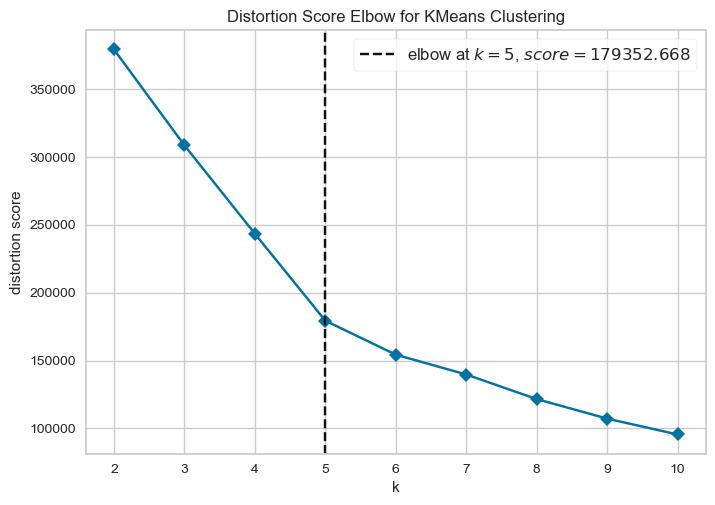

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [77]:
visualizer = KElbowVisualizer(KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42), k=(2,11), metric='distortion', timings=False)
visualizer.fit(df_has_review)
visualizer.show()

In [78]:
for k in [5, 6]:
    labels = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42).fit_predict(df_has_review)
    score = silhouette_score(df_has_review, labels)
    print(f"Silhouette Score for {k} clusters: {score}")


Silhouette Score for 5 clusters: 0.4427211183882901
Silhouette Score for 6 clusters: 0.44806518029237535


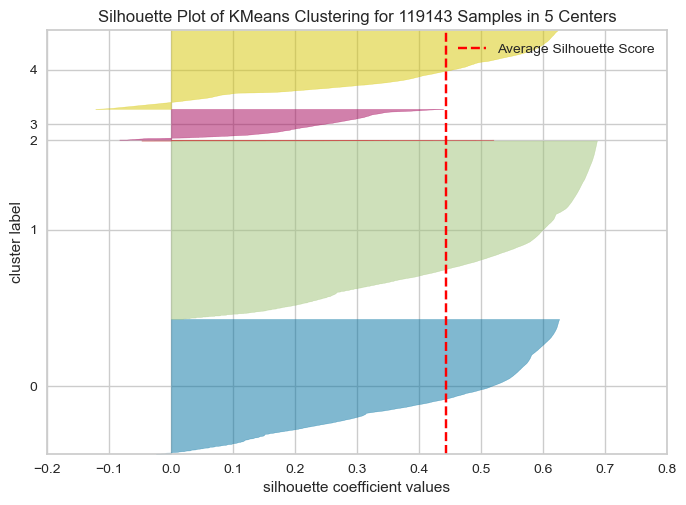

<Figure size 1000x600 with 0 Axes>

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 119143 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [79]:
# Tester plusieurs valeurs de k autour de celui trouvé avec le coude
model = KMeans(n_clusters=5, init='k-means++', n_init=10, random_state=42)
# Visualisation des silhouettes
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(df_has_review)
plt.figure(figsize=(10, 6))
visualizer.show()

In [80]:
optimal_k_review = 5
kmeans_optimal = KMeans(n_clusters=optimal_k_review, init='k-means++', n_init=10, random_state=42)
clusters_optimal_review = kmeans_optimal.fit_predict(df_has_review)

# Calcul des métriques d'évaluation pour les clusters
calinski_score = calinski_harabasz_score(df_has_review, clusters_optimal_review)
db_score = davies_bouldin_score(df_has_review, clusters_optimal_review)

print(f'Métriques pour k={optimal_k_review}:')
print(f'Calinski-Harabasz Score: {calinski_score}')
print(f'Davies-Bouldin Score: {db_score}')

Métriques pour k=5:
Calinski-Harabasz Score: 49522.40699945379
Davies-Bouldin Score: 0.7452672487925698


Variance expliquée par les composantes PCA : [0.27911105 0.2612028 ]
Total variance expliquée : 0.54031385645289


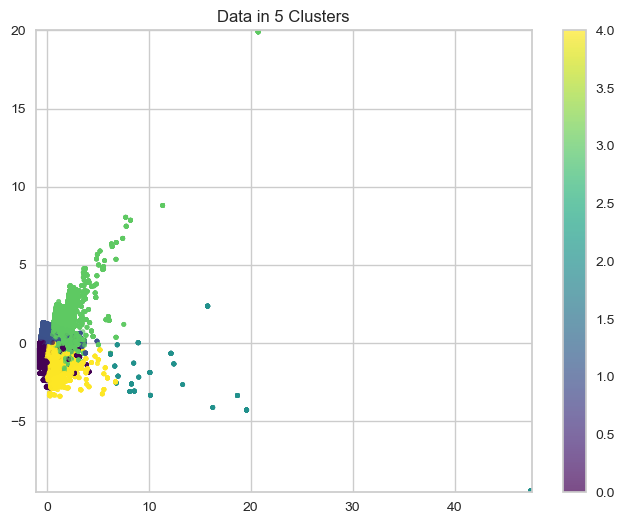

In [81]:
# Appliquer la PCA sur les données normalisées
pca = PCA(n_components=2, random_state=42)
df_pca_has_review = pca.fit_transform(df_has_review)

# Convertir en DataFrame
df_pca_has_review = pd.DataFrame(df_pca_has_review, columns=['PCA1', 'PCA2'])
df_pca_has_review['Cluster'] = clusters_optimal_review  # Assigne les clusters

# Vérifier la variance expliquée
print("Variance expliquée par les composantes PCA :", pca.explained_variance_ratio_)
print(f"Total variance expliquée : {sum(pca.explained_variance_ratio_)}")

# Tracer le scatter plot avec ajustement d'échelle et taille des points
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca_has_review['PCA1'], 
                       df_pca_has_review['PCA2'], 
                       c=df_pca_has_review['Cluster'], 
                       cmap='viridis', 
                       alpha=0.7, 
                       s=10)  # Augmenter la taille des points pour les voir

# Ajouter des limites 
plt.xlim(df_pca_has_review['PCA1'].min() - 0.1, df_pca_has_review['PCA1'].max() + 0.1)
plt.ylim(df_pca_has_review['PCA2'].min() - 0.1, df_pca_has_review['PCA2'].max() + 0.1)

# Ajouter titre et colorbar
plt.colorbar(scatter)
plt.title(f"Data in {len(set(clusters_optimal_review))} Clusters")
plt.show()

#### Calcul des moyennes 

In [83]:
# Ajouter les clusters au DataFrame original
df_has_review = df_has_review.copy()  
df_has_review.loc[:, 'Cluster'] = clusters_optimal_review


# Calcul des moyennes par cluster
cluster_means_scaled_2 = df_has_review.groupby('Cluster')[['recency', 'frequency', 'monetary','avg_review','has_review']].mean().sort_index()

print(cluster_means_scaled_2)

          recency  frequency   monetary  avg_review  has_review
Cluster                                                        
0        1.016968  -0.221227  -0.069332    0.437050    0.989296
1       -0.759910  -0.221740  -0.079300    0.459399    0.990397
2       -0.130247   1.043989  16.370453   -1.049034    0.919355
3       -0.094429   2.793912   0.174317    0.039523    0.989711
4        0.018924  -0.221740   0.047112   -1.795290    1.000000


In [84]:
display(df_has_review['Cluster'].value_counts().sort_index())

Cluster
0    37929
1    50193
2      248
3     8650
4    22123
Name: count, dtype: int64

In [85]:
quantitative_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment', 'diversity_products', 'avg_installments']
target_features = ['recency', 'frequency', 'monetary', 'avg_review', 'has_review']

In [86]:
cluster_means_original_2 = inverse_transform_mean(
    cluster_means_scaled_2,  # DataFrame des moyennes normalisées par cluster
    df_final,                # DataFrame original non transformé
    quantitative_features,   # Variables standardisées
    target_features          # Variables à inverser
)

print("Moyennes en échelle d'origine:")
print(cluster_means_original_2)


Moyennes en échelle d'origine:
            recency  frequency      monetary  avg_review  has_review
Cluster                                                             
0        443.678557   1.000211    267.974508    4.628437    0.989296
1        171.189489   1.000000    251.335839    4.659355    0.990397
2        267.750000   1.520161  27709.496774    2.572581    0.919355
3        273.242775   2.239306    674.676805    4.078497    0.989711
4        290.625774   1.000000    462.343607    1.540207    1.000000


- Cluster 0: Clients inactifs 
- Cluster 1: Clients nouveaux et très satisfaits
- Cluster 2: Clients qui dépensent beaucoup mais assez insatisfaits
- Cluster 3: Clients qui achètent souvent 
- CLuster 4: Clients très instatisfaits et très engagés pour laisser des avis

#### Interprétation has_review:
**Rappel modèle de base:** 
- k = 5
- Silhouette : 0.54
- Calinski-Harabasz : 60721
- Davies-Bouldin Score: 0.61

**Rappel modèle has_review**
- k = 5
- Silhouette : 0.44
- Calinski-Harabasz : 49522
- Davies-Bouldin : 0.75


En ajoutant la variable binaire has_review (indiquant si un client laisse un avis), les scores ont baissés (silhouette et CH) ce qui suggère une moins bonne séparation de clusters, tout comme DB augmente. 

In [89]:
for feature in ['recency', 'frequency', 'monetary','avg_review','has_review']:
    # Compare les paires de clusters
    for i in range(len(cluster_means_original_2)):  # Clusters de 0 à N-1
        for j in range(i+1, len(cluster_means_scaled_2)):  # Comparaison entre i et j, j > i
            # Obtenir les données des groupes
            group_1 = df_has_review[df_has_review['Cluster'] == i][feature]
            group_2 = df_has_review[df_has_review['Cluster'] == j][feature]

            # Utiliser les moyennes de moyennes_par_cluster
            mean_1 = cluster_means_original_2.loc[i, feature]
            mean_2 = cluster_means_original_2.loc[j, feature]

            # Calculer les écarts-types et tailles des groupes
            std_1 = group_1.std()  # Calcul de l'écart-type du groupe 1
            std_2 = group_2.std()  # Calcul de l'écart-type du groupe 2
            n_1 = len(group_1)     # Taille du groupe 1
            n_2 = len(group_2)     # Taille du groupe 2

            # Effectuer le test t avec les statistiques calculées
            t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1, mean_2, std_2, n_2, equal_var=False)

            # Afficher les résultats du test t
            print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=71320.0640, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=3775.6373, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=15689.5709, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=22968.6552, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=-2074.9894, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=-9626.4306, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=-19177.5369, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=-115.3132, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 4): t-stat=-488.2292, p-value=0.0000
T-test Recency (Cluster 3 vs Cluster 4): t-stat=-1457.7513, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=1.1625, p-value=0.2451
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=-3.6856, p-value=0.0003
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=-50.7063, p-value=0.0000
T-test Frequency (Cluster 0 vs

- T-test Frequency (Cluster 0 vs Cluster 1): t-stat=1.1625, p-value=0.2451
- T-test Frequency (Cluster 0 vs Cluster 4): t-stat=1.1625, p-value=0.2451
- T-test Frequency (Cluster 1 vs Cluster 4): t-stat=0.0000, p-value=1.0000
- T-test Has_review (Cluster 0 vs Cluster 1): t-stat=-1.6086, p-value=0.1077
- T-test Has_review (Cluster 0 vs Cluster 3): t-stat=-0.3440, p-value=0.7308
- T-test Has_review (Cluster 1 vs Cluster 3): t-stat=0.5868, p-value=0.5573

In [91]:
for feature in ['recency', 'frequency', 'monetary','avg_review','has_review']:
    # Compare les paires de clusters
    for i in range(len(cluster_means_scaled_2)):  # Clusters de 0 à N-1
        for j in range(i+1, len(cluster_means_scaled_2)):  # Comparaison entre i et j, j > i
            # Obtenir les données des groupes
            group_1 = df_has_review[df_has_review['Cluster'] == i][feature]
            group_2 = df_has_review[df_has_review['Cluster'] == j][feature]

            # Utiliser les moyennes de moyennes_par_cluster
            mean_1 = cluster_means_scaled_2.loc[i, feature]
            mean_2 = cluster_means_scaled_2.loc[j, feature]

            # Calculer les écarts-types et tailles des groupes
            std_1 = group_1.std()  # Calcul de l'écart-type du groupe 1
            std_2 = group_2.std()  # Calcul de l'écart-type du groupe 2
            n_1 = len(group_1)     # Taille du groupe 1
            n_2 = len(group_2)     # Taille du groupe 2

            # Effectuer le test t avec les statistiques calculées
            t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1, mean_2, std_2, n_2, equal_var=False)

            # Afficher les résultats du test t
            print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")



T-test Recency (Cluster 0 vs Cluster 1): t-stat=465.0721, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=24.6206, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=102.3104, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=149.7767, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=-13.5308, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=-62.7731, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=-125.0551, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=-0.7519, p-value=0.4527
T-test Recency (Cluster 2 vs Cluster 4): t-stat=-3.1837, p-value=0.0016
T-test Recency (Cluster 3 vs Cluster 4): t-stat=-9.5059, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=2.8287, p-value=0.0047
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=-8.9683, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=-123.3856, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 4): t-stat=

- T-test Recency (Cluster 2 vs Cluster 3): t-stat=-0.7519, p-value=0.4527
- T-test Frequency (Cluster 1 vs Cluster 4): t-stat=0.0425, p-value=0.9661
- T-test Has_review (Cluster 0 vs Cluster 1): t-stat=-1.6086, p-value=0.1077
- T-test Has_review (Cluster 0 vs Cluster 3): t-stat=-0.3440, p-value=0.7308
- T-test Has_review (Cluster 1 vs Cluster 3): t-stat=0.5868, p-value=0.5573

### 2. Ajout de top category sans has_review

In [94]:
# Récupérer les noms des colonnes encodées de top_category
top_category_cols = [col for col in df_final_encoded.columns if col.startswith('top_category_')]

df_top_1 = df_final_encoded[['recency', 'frequency', 'monetary', 'avg_review'] + top_category_cols]


#### Choix du nombre de cluster optimal

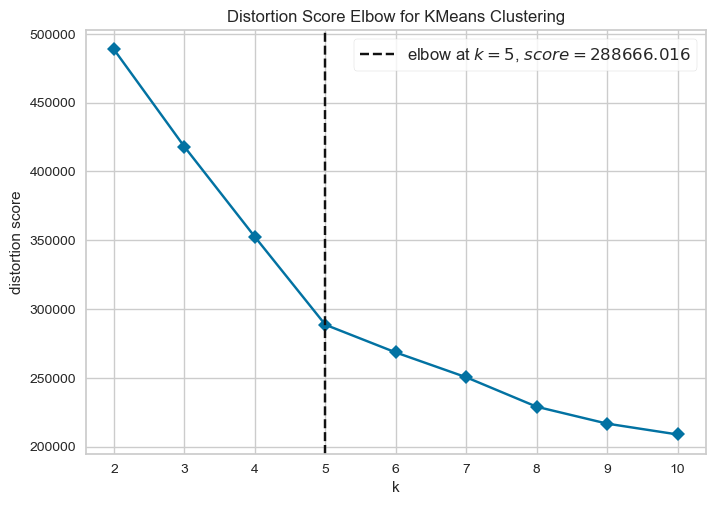

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [96]:
visualizer = KElbowVisualizer(KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42), k=(2,11), metric='distortion', timings=False)
visualizer.fit(df_top_1)
visualizer.show()

In [97]:
for k in [5,6]:
    labels = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42).fit_predict(df_top_1)
    score = silhouette_score(df_top_1, labels)
    print(f"Silhouette Score for {k} clusters: {score}")

Silhouette Score for 5 clusters: 0.26154938464990657
Silhouette Score for 6 clusters: 0.26191708604242775


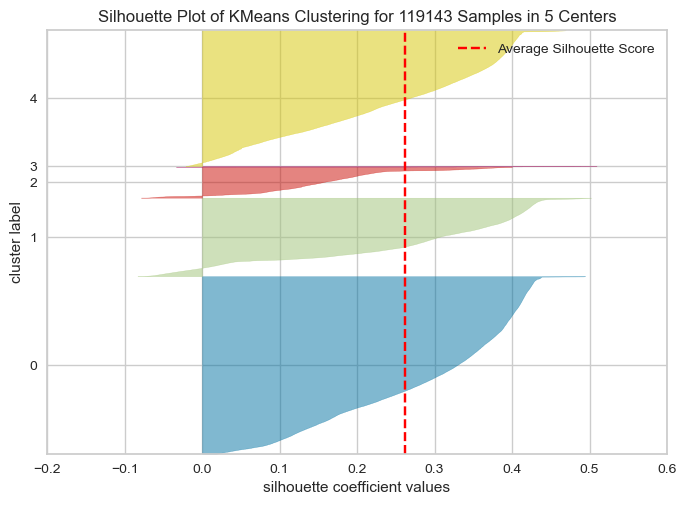

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 119143 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [98]:
N_CLUSTERS = 5
model = KMeans(n_clusters=N_CLUSTERS, init='k-means++', n_init=10, random_state=42)

#Visualisation des silhouettes
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(df_top_1)
visualizer.show()

In [99]:
OPTIMAL_K_TOP_1 = 5
kmeans_optimal = KMeans(n_clusters=OPTIMAL_K_TOP_1, init='k-means++', n_init=10, random_state=42)
clusters_optimal_top_1 = kmeans_optimal.fit_predict(df_top_1)

# Calcul des métriques d'évaluation pour les clusters
calinski_score = calinski_harabasz_score(df_top_1, clusters_optimal_top_1)
db_score = davies_bouldin_score(df_top_1, clusters_optimal_top_1)

print(f'Métriques pour k={OPTIMAL_K_TOP_1}:')
print(f'Calinski-Harabasz Score: {calinski_score}')
print(f'Davies-Bouldin Score: {db_score}')

Métriques pour k=5:
Calinski-Harabasz Score: 30793.930409079123
Davies-Bouldin Score: 1.0933072671213948


Variance expliquée par les composantes PCA : [0.22713047 0.21256131]
Total variance expliquée : 0.4396917844203412


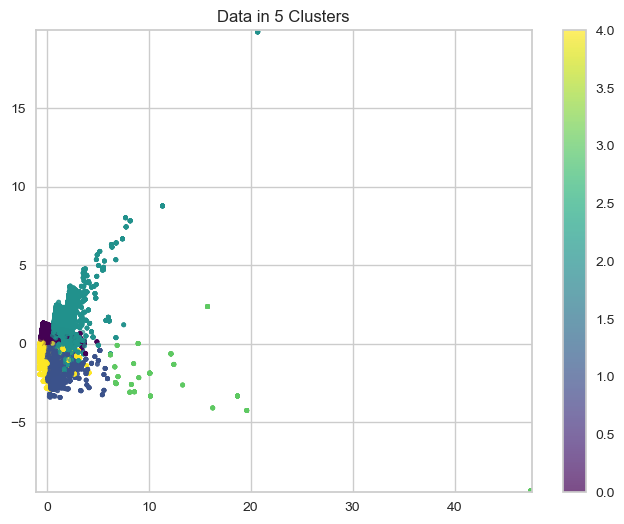

In [100]:
# Appliquer la PCA sur les données normalisées
pca = PCA(n_components=2, random_state=42)
df_pca_top_1 = pca.fit_transform(df_top_1)

# Convertir en DataFrame
df_pca_top_1 = pd.DataFrame(df_pca_top_1, columns=['PCA1', 'PCA2'])
df_pca_top_1['Cluster'] = clusters_optimal_top_1  # Assigne les clusters

# Vérifier la variance expliquée
print("Variance expliquée par les composantes PCA :", pca.explained_variance_ratio_)
print(f"Total variance expliquée : {sum(pca.explained_variance_ratio_)}")

# Tracer le scatter plot avec ajustement d'échelle et taille des points
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca_top_1['PCA1'], 
                       df_pca_top_1['PCA2'], 
                       c=df_pca_top_1['Cluster'], 
                       cmap='viridis', 
                       alpha=0.7, 
                       s=10)  # Augmenter la taille des points pour les voir

# Ajouter des limites 
plt.xlim(df_pca_top_1['PCA1'].min() - 0.1, df_pca_top_1['PCA1'].max() + 0.1)
plt.ylim(df_pca_top_1['PCA2'].min() - 0.1, df_pca_top_1['PCA2'].max() + 0.1)

# Ajouter titre et colorbar
plt.colorbar(scatter)
plt.title(f"Data in {len(set(clusters_optimal_top_1))} Clusters")
plt.show()


#### Calcul des moyennes 

In [102]:
display(top_category_cols)

['top_category_agro_industry_and_commerce',
 'top_category_air_conditioning',
 'top_category_art',
 'top_category_arts_and_craftmanship',
 'top_category_audio',
 'top_category_auto',
 'top_category_baby',
 'top_category_bed_bath_table',
 'top_category_books_general_interest',
 'top_category_books_imported',
 'top_category_books_technical',
 'top_category_cds_dvds_musicals',
 'top_category_christmas_supplies',
 'top_category_cine_photo',
 'top_category_computers',
 'top_category_computers_accessories',
 'top_category_consoles_games',
 'top_category_construction_tools_construction',
 'top_category_construction_tools_lights',
 'top_category_construction_tools_safety',
 'top_category_cool_stuff',
 'top_category_costruction_tools_garden',
 'top_category_costruction_tools_tools',
 'top_category_diapers_and_hygiene',
 'top_category_drinks',
 'top_category_dvds_blu_ray',
 'top_category_electronics',
 'top_category_fashio_female_clothing',
 'top_category_fashion_bags_accessories',
 'top_categor

In [103]:
# Ajouter les clusters au DataFrame original
df_top_1 = df_top_1.copy()  # Éviter la modification sur une vue
df_top_1.loc[:, 'Cluster'] = clusters_optimal_top_1

cluster_means_scaled_3 = df_top_1.groupby('Cluster')[['recency', 'frequency', 'monetary', 'avg_review'] + top_category_cols].mean().sort_index()

print(cluster_means_scaled_3)

          recency  frequency   monetary  avg_review  \
Cluster                                               
0       -0.764195  -0.221740  -0.078894    0.459176   
1        0.018611  -0.221740   0.041458   -1.795887   
2       -0.094429   2.793912   0.174317    0.039523   
3       -0.116570   0.976354  15.937866   -1.109777   
4        1.011151  -0.221230  -0.069619    0.436977   

         top_category_agro_industry_and_commerce  \
Cluster                                            
0                                       0.003403   
1                                       0.001448   
2                                       0.001156   
3                                       0.022901   
4                                       0.000864   

         top_category_air_conditioning  top_category_art  \
Cluster                                                    
0                             0.002262          0.002803   
1                             0.002580          0.001765   
2        

In [104]:
print(df_top_1['Cluster'].value_counts().sort_index()) 

Cluster
0    49954
1    22092
2     8650
3      262
4    38185
Name: count, dtype: int64


Difficilement interprétable car bcp de colonnes top_category = Cluster 0 : 0.3 % achète des produits de catégorie agro_industy

In [106]:
quantitative_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment', 'diversity_products', 'avg_installments']
target_features = ['recency', 'frequency', 'monetary', 'avg_review']

In [107]:
cluster_means_original_3 = inverse_transform_mean(
    cluster_means_scaled_3,  # DataFrame des moyennes normalisées par cluster
    df_final,                # DataFrame original non transformé
    quantitative_features,   # Variables standardisées
    target_features          # Variables à inverser
)

print("Moyennes en échelle d'origine:")
print(cluster_means_original_3)


Moyennes en échelle d'origine:
            recency  frequency      monetary  avg_review
Cluster                                                 
0        170.532390   1.000000    252.013817    4.659046
1        290.577675   1.000000    452.906379    1.539381
2        273.242775   2.239306    674.676805    4.078497
3        269.847328   1.492366  26987.416489    2.488550
4        442.786356   1.000210    267.494531    4.628336


In [108]:
# Identifier la catégorie la plus fréquente par cluster
modes_top_category = df_top_1.groupby("Cluster")[top_category_cols].sum().idxmax(axis=1)
#Additionne les 1 de chaque colonne OHE par cluster et idmax (axis = 1) retrouve la colonne où cette somme est maximale

# Afficher les résultats
print(modes_top_category)

Cluster
0            top_category_health_beauty
1           top_category_bed_bath_table
2           top_category_bed_bath_table
3    top_category_computers_accessories
4           top_category_bed_bath_table
dtype: object


- Cluster 0: Nouveau client très satisfaits qui achètent principalement des produits de soins/beauté
- Cluster 1: Client instatisfait qui achètent principalement des produits linge de maison
- Cluster 2: Client qui achète fréquemment et qui achètent aussi principalement des produtis linge de maison
- Cluster 3: Client qui dépense énormément mais pas très satisfaits et qui achètent principalement des accessoires d'ordinateurs
- Cluster 4: Client inactif qui achète principalement du linge de lit

#### Interprétation ajout de la variable top_category sans has_review: 

**Rappel modèle de base**:
- Silhouette : 0.54
- Calinski-Harabasz : 60721
- Davies-Bouldin Score: 0.61

**Rappel modèle top_category 1**:
- Silhouette : 0.26
- Calinski-Harabasz Score: 30793- Davies-Bouldin Score: 1.09

L'incorporation de la variable top_category (représentée en one-hot) dégrade fortement la qualité du clustering.
Cela suggère que la dimension catégorielle introduit du bruit et que le modèle a du mal à la gérer

In [111]:
non_significant_tests = [] 

for feature in ['recency', 'frequency', 'monetary', 'avg_review'] + top_category_cols:
    # Compare les paires de clusters
    
    for i in range(len(cluster_means_scaled_3)):  # Clusters de 0 à N-1
        for j in range(i+1, len(cluster_means_scaled_3)):  # Comparaison entre i et j, j > i
            
            # Obtenir les données des groupes
            group_1 = df_top_1[df_top_1['Cluster'] == i][feature]
            group_2 = df_top_1[df_top_1['Cluster'] == j][feature]

            # Utiliser les moyennes de moyennes_par_cluster
            mean_1 = cluster_means_scaled_3.loc[i, feature]
            mean_2 = cluster_means_scaled_3.loc[j, feature]

            # Calculer les écarts-types et tailles des groupes
            std_1 = group_1.std()  # Calcul de l'écart-type du groupe 1
            std_2 = group_2.std()  # Calcul de l'écart-type du groupe 2
            n_1 = len(group_1)     # Taille du groupe 1
            n_2 = len(group_2)     # Taille du groupe 2

            # Effectuer le test t avec les statistiques calculées
            t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1, mean_2, std_2, n_2, equal_var = False)

            # Afficher les résultats du test t
            print(f"T-test {feature} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")
            
            #Stocke les non significatif
            non_significant_tests.append((feature, i, j, p_value))


T-test recency (Cluster 0 vs Cluster 1): t-stat=-125.6019, p-value=0.0000
T-test recency (Cluster 0 vs Cluster 2): t-stat=-63.1866, p-value=0.0000
T-test recency (Cluster 0 vs Cluster 3): t-stat=-14.6545, p-value=0.0000
T-test recency (Cluster 0 vs Cluster 4): t-stat=-465.2620, p-value=0.0000
T-test recency (Cluster 1 vs Cluster 2): t-stat=9.4766, p-value=0.0000
T-test recency (Cluster 1 vs Cluster 3): t-stat=3.0357, p-value=0.0026
T-test recency (Cluster 1 vs Cluster 4): t-stat=-148.8082, p-value=0.0000
T-test recency (Cluster 2 vs Cluster 3): t-stat=0.4883, p-value=0.6257
T-test recency (Cluster 2 vs Cluster 4): t-stat=-101.7765, p-value=0.0000
T-test recency (Cluster 3 vs Cluster 4): t-stat=-25.4814, p-value=0.0000
T-test frequency (Cluster 0 vs Cluster 1): t-stat=0.0000, p-value=1.0000
T-test frequency (Cluster 0 vs Cluster 2): t-stat=-123.4101, p-value=0.0000
T-test frequency (Cluster 0 vs Cluster 3): t-stat=-8.8958, p-value=0.0000
T-test frequency (Cluster 0 vs Cluster 4): t-stat

In [112]:
for feature, i, j, p_value in non_significant_tests:
    if p_value > 0.05:
        print(f" T-test {feature} (Cluster {i} vs Cluster {j}): p-value={p_value:.4f} (Non significatif)")

 T-test recency (Cluster 2 vs Cluster 3): p-value=0.6257 (Non significatif)
 T-test frequency (Cluster 0 vs Cluster 1): p-value=1.0000 (Non significatif)
 T-test top_category_agro_industry_and_commerce (Cluster 1 vs Cluster 2): p-value=0.5121 (Non significatif)
 T-test top_category_agro_industry_and_commerce (Cluster 2 vs Cluster 4): p-value=0.4601 (Non significatif)
 T-test top_category_air_conditioning (Cluster 0 vs Cluster 1): p-value=0.4290 (Non significatif)
 T-test top_category_air_conditioning (Cluster 0 vs Cluster 2): p-value=0.5693 (Non significatif)
 T-test top_category_air_conditioning (Cluster 0 vs Cluster 4): p-value=0.0869 (Non significatif)
 T-test top_category_air_conditioning (Cluster 1 vs Cluster 2): p-value=0.2940 (Non significatif)
 T-test top_category_air_conditioning (Cluster 1 vs Cluster 4): p-value=0.5301 (Non significatif)
 T-test top_category_air_conditioning (Cluster 2 vs Cluster 4): p-value=0.1053 (Non significatif)
 T-test top_category_art (Cluster 2 vs Clu

En ajoutant la variable top_category qui a plus de 70 catégories différentes, on voit que le modèle est beaucoup moins performant, et avec les nombreuses catégories différnets nous voyons que beaucuop de clusters ont des moyennes significativement similaires. Donc la différenciation entre cluster est bien plus compliquée avec cette variable qui n'apporte pas une information la plus importante pour établir un profil client. 

### 3. Ajout de top_category avec has_review

In [115]:
# Récupérer les noms des colonnes encodées de top_category
top_category_cols = [col for col in df_final_encoded.columns if col.startswith('top_category_')]

df_top_2 = df_final_encoded[['recency', 'frequency', 'monetary', 'avg_review', 'has_review',] + top_category_cols]


#### Choix du nombre de cluster optimal

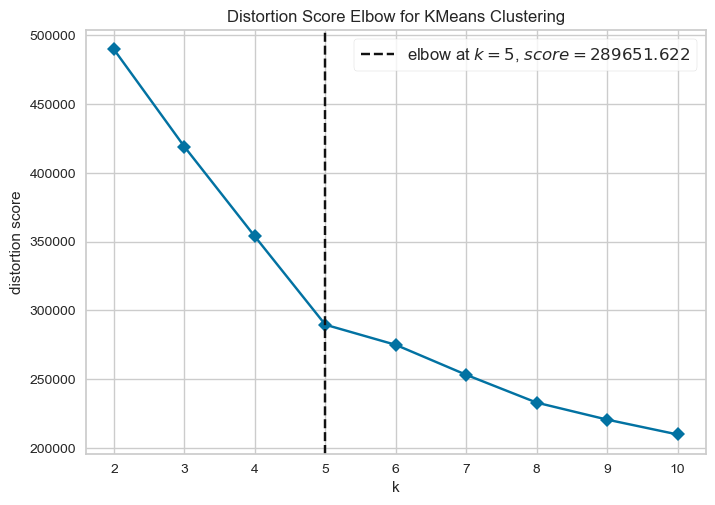

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [117]:
visualizer = KElbowVisualizer(KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42), k=(2,11), metric='distortion', timings=False)
visualizer.fit(df_top_2)
visualizer.show()

In [118]:
for k in [5,6]:
    labels = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42).fit_predict(df_top_2)
    score = silhouette_score(df_top_2, labels)
    print(f"Silhouette Score for {k} clusters: {score}")

Silhouette Score for 5 clusters: 0.26084313004096976
Silhouette Score for 6 clusters: 0.17733799559997798


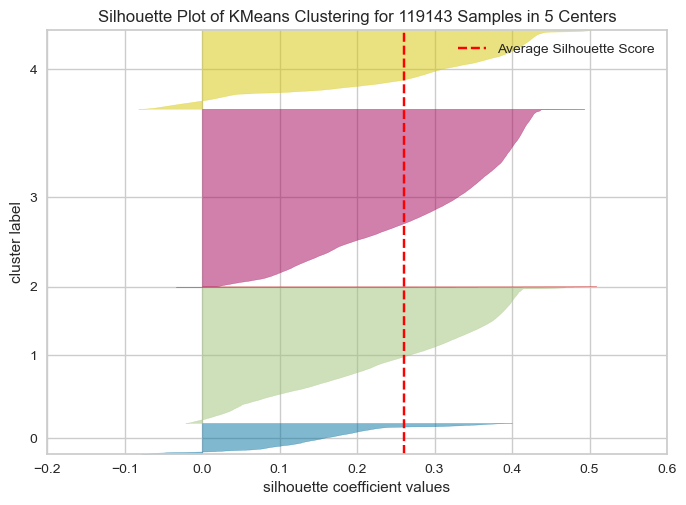

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 119143 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [119]:
N_CLUSTERS = 5
model = KMeans(n_clusters=N_CLUSTERS, init='k-means++', n_init=10, random_state=42)
    
# Visualisation des silhouettes
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(df_top_2)
visualizer.show()

In [120]:
OPTIMAL_K_TOP_2 = 5
kmeans_optimal = KMeans(n_clusters=OPTIMAL_K_TOP_2, init='k-means++', n_init=10, random_state=42)
clusters_optimal_top_2 = kmeans_optimal.fit_predict(df_top_2)

# Calcul des métriques d'évaluation pour les clusters
calinski_score = calinski_harabasz_score(df_top_2, clusters_optimal_top_2)
db_score = davies_bouldin_score(df_top_2, clusters_optimal_top_2)

print(f'Métriques pour k={OPTIMAL_K_TOP_2}:')
print(f'Calinski-Harabasz Score: {calinski_score}')
print(f'Davies-Bouldin Score: {db_score}')

Métriques pour k=5:
Calinski-Harabasz Score: 30689.460573070446
Davies-Bouldin Score: 1.095824778763013


Variance expliquée par les composantes PCA : [0.22713047 0.21256131]
Total variance expliquée : 0.4396917844203412


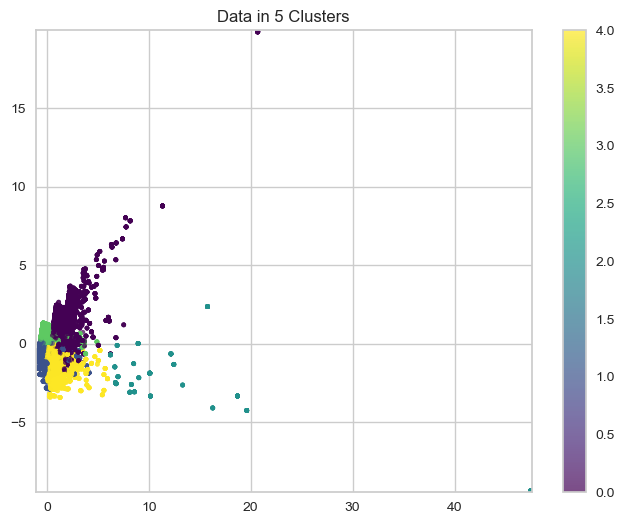

In [121]:
pca_top_2 = PCA(n_components = 2, random_state = 42)
df_pca_top_2 = pca_top_2.fit_transform(df_top_2)

df_pca_top_2 = pd.DataFrame(df_pca_top_2, columns = ['PCA1', 'PCA2'])
df_pca_top_2['Cluster'] = clusters_optimal_top_2

# Vérifier la variance expliquée
print("Variance expliquée par les composantes PCA :", pca.explained_variance_ratio_)
print(f"Total variance expliquée : {sum(pca.explained_variance_ratio_)}")


# Tracer le scatter plot avec ajustement d'échelle et taille des points
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca_top_2['PCA1'], 
                       df_pca_top_2['PCA2'], 
                       c=df_pca_top_2['Cluster'], 
                       cmap='viridis', 
                       alpha=0.7, 
                       s=10)  # Augmenter la taille des points pour les voir

# Ajouter des limites 
plt.xlim(df_pca_top_2['PCA1'].min() - 0.1, df_pca_top_2['PCA1'].max() + 0.1)
plt.ylim(df_pca_top_2['PCA2'].min() - 0.1, df_pca_top_1['PCA2'].max() + 0.1)

# Ajouter titre et colorbar
plt.colorbar(scatter)
plt.title(f"Data in {len(set(clusters_optimal_top_2))} Clusters")
plt.show()


#### Calcul des moyennes 

In [123]:
# Ajouter les clusters au DataFrame original
df_top_2 = df_top_2.copy()  # Éviter la modification sur une vue
df_top_2.loc[:, 'Cluster'] = clusters_optimal_top_2


# Calcul des moyennes par cluster
cluster_means_scaled_4 = df_top_2.groupby('Cluster')[['recency', 
                                                      'frequency', 
                                                      'monetary', 
                                                      'avg_review', 
                                                      'has_review'] + top_category_cols].mean().sort_index()

print(cluster_means_scaled_4)

          recency  frequency   monetary  avg_review  has_review  \
Cluster                                                           
0       -0.094429   2.793912   0.174317    0.039523    0.989711   
1        1.011152  -0.221230  -0.069617    0.437071    0.989237   
2       -0.116570   0.976354  15.937866   -1.109777    0.923664   
3       -0.764146  -0.221740  -0.078909    0.458816    0.990454   
4        0.018924  -0.221740   0.041555   -1.796461    1.000000   

         top_category_agro_industry_and_commerce  \
Cluster                                            
0                                       0.001156   
1                                       0.000864   
2                                       0.022901   
3                                       0.003402   
4                                       0.001449   

         top_category_air_conditioning  top_category_art  \
Cluster                                                    
0                             0.001965       

In [124]:
print(df_top_2['Cluster'].value_counts().sort_index()) 

Cluster
0     8650
1    38185
2      262
3    49966
4    22080
Name: count, dtype: int64


In [125]:
quantitative_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment', 'diversity_products', 'avg_installments']
target_features = ['recency', 'frequency', 'monetary', 'avg_review', 'has_review']

In [126]:
cluster_means_original_4 = inverse_transform_mean(
    cluster_means_scaled_4,  # DataFrame des moyennes normalisées par cluster
    df_final,              # DataFrame original non transformé
    quantitative_features, # Variables standardisées
    target_features        # Variables à inverser
)

print("Moyennes en échelle d'origine:")
print(cluster_means_original_4)


Moyennes en échelle d'origine:
            recency  frequency      monetary  avg_review  has_review
Cluster                                                             
0        273.242775   2.239306    674.676805    4.078497    0.989711
1        442.786539   1.000210    267.497655    4.628467    0.989237
2        269.847328   1.492366  26987.416489    2.488550    0.923664
3        170.539847   1.000000    251.987908    4.658548    0.990454
4        290.625725   1.000000    453.068786    1.538587    1.000000


In [127]:
# Identifier la catégorie la plus fréquente par cluster
modes_top_category_1 = df_top_2.groupby("Cluster")[top_category_cols].sum().idxmax(axis=1)
#Additionne les 1 de chaque colonne OHE par cluster et idmax (axis = 1) retrouve la colonne où cette somme est maximale

# Afficher les résultats
print(modes_top_category_1)

Cluster
0           top_category_bed_bath_table
1           top_category_bed_bath_table
2    top_category_computers_accessories
3            top_category_health_beauty
4           top_category_bed_bath_table
dtype: object


- Cluster 0:  Clients qui achètent fréquemment avec un panier de valeur élevé et satisfait, laisse majoritairement un avis. Catégorie préf: linge de maison => se différencie par leur fréquence d'achat
- Cluster 1: Clients perdus avec un panier de valeur faible mais très satisfait et laisse majoritairement un avis. Catégorie préf: linge de maison => se différencie par leur inactivité
- Cluster 2: Client moyennement fréquent, avec un panier de valeur très élevé mais peu satisfait et laisse peu d'avis. Catégorie préf: accessoire d'ordi => se différencie par leur dépenses très élevées
- Cluster 3: Client très récent, nouveau. Panier de valeur faible mais très satisfait laisse un avis presque à chaque fois. Catégorie préf: produit de beauté => se différencie par leur nouveauté et leur satisfaction
- Cluster 4: Client avec un panier de valeur moyenne mais très insatisfait, laisse tout le temps un avis. Catégorie préf: linge de maison => se différencie par leur insatisfaction

#### Interprétation ajout de la variable top_category avec has_review: 
**Rappel modèle de base**:
- k = 5
- Silhouette : 0.54
- Calinski-Harabasz : 60721
- Davies-Bouldin Score: 0.61

**Rappel modèle top_category 2**
- k = 5
- Silhouette : 0.26
- Calinski-Harabasz : 30689
- Davies-Bouldin : 1.09

Même combinaison que la variante 3, l’ajout de top_category entraîne des scores moins performants, malgré la présence de has_review.
Les clusters deviennent moins distincts, ce qui indique que la variable top_category, telle qu’elle est encodée, ne contribue pas positivement à la segmentation bien au contraire. 

In [130]:
non_significant_tests_1 = [] 

for feature in ['recency', 'frequency', 'monetary', 'avg_review', 'has_review'] + top_category_cols:
    # Compare les paires de clusters
    
    for i in range(len(cluster_means_scaled_4)):  # Clusters de 0 à N-1
        for j in range(i+1, len(cluster_means_scaled_4)):  # Comparaison entre i et j, j > i
            
            # Obtenir les données des groupes
            group_1 = df_top_2[df_top_2['Cluster'] == i][feature]
            group_2 = df_top_2[df_top_2['Cluster'] == j][feature]

            # Utiliser les moyennes de moyennes_par_cluster
            mean_1 = cluster_means_scaled_4.loc[i, feature]
            mean_2 = cluster_means_scaled_4.loc[j, feature]

            # Calculer les écarts-types et tailles des groupes
            std_1 = group_1.std()  # Calcul de l'écart-type du groupe 1
            std_2 = group_2.std()  # Calcul de l'écart-type du groupe 2
            n_1 = len(group_1)     # Taille du groupe 1
            n_2 = len(group_2)     # Taille du groupe 2

            # Effectuer le test t avec les statistiques calculées
            t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1, mean_2, std_2, n_2, equal_var = False)

            # Afficher les résultats du test t
            print(f"T-test {feature} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")
            
            #Stocke les non significatif
            non_significant_tests_1.append((feature, i, j, p_value))


T-test recency (Cluster 0 vs Cluster 1): t-stat=-101.7767, p-value=0.0000
T-test recency (Cluster 0 vs Cluster 2): t-stat=0.4883, p-value=0.6257
T-test recency (Cluster 0 vs Cluster 3): t-stat=63.1826, p-value=0.0000
T-test recency (Cluster 0 vs Cluster 4): t-stat=-9.5019, p-value=0.0000
T-test recency (Cluster 1 vs Cluster 2): t-stat=25.4814, p-value=0.0000
T-test recency (Cluster 1 vs Cluster 3): t-stat=465.2819, p-value=0.0000
T-test recency (Cluster 1 vs Cluster 4): t-stat=148.7127, p-value=0.0000
T-test recency (Cluster 2 vs Cluster 3): t-stat=14.6534, p-value=0.0000
T-test recency (Cluster 2 vs Cluster 4): t-stat=-3.0427, p-value=0.0026
T-test recency (Cluster 3 vs Cluster 4): t-stat=-125.6004, p-value=0.0000
T-test frequency (Cluster 0 vs Cluster 1): t-stat=123.3858, p-value=0.0000
T-test frequency (Cluster 0 vs Cluster 2): t-stat=13.2784, p-value=0.0000
T-test frequency (Cluster 0 vs Cluster 3): t-stat=123.4101, p-value=0.0000
T-test frequency (Cluster 0 vs Cluster 4): t-stat=1

In [131]:
for feature, i, j, p_value in non_significant_tests_1:
    if p_value > 0.05:
        print(f" T-test {feature} (Cluster {i} vs Cluster {j}): p-value={p_value:.4f} (Non significatif)")

 T-test recency (Cluster 0 vs Cluster 2): p-value=0.6257 (Non significatif)
 T-test frequency (Cluster 3 vs Cluster 4): p-value=0.9830 (Non significatif)
 T-test has_review (Cluster 0 vs Cluster 1): p-value=0.6943 (Non significatif)
 T-test has_review (Cluster 0 vs Cluster 3): p-value=0.5253 (Non significatif)
 T-test has_review (Cluster 1 vs Cluster 3): p-value=0.0753 (Non significatif)
 T-test top_category_agro_industry_and_commerce (Cluster 0 vs Cluster 1): p-value=0.4601 (Non significatif)
 T-test top_category_agro_industry_and_commerce (Cluster 0 vs Cluster 4): p-value=0.5111 (Non significatif)
 T-test top_category_air_conditioning (Cluster 0 vs Cluster 1): p-value=0.1053 (Non significatif)
 T-test top_category_air_conditioning (Cluster 0 vs Cluster 3): p-value=0.5700 (Non significatif)
 T-test top_category_air_conditioning (Cluster 0 vs Cluster 4): p-value=0.2930 (Non significatif)
 T-test top_category_air_conditioning (Cluster 1 vs Cluster 3): p-value=0.0865 (Non significatif)
 

### 4. Ajout de avg_payments (modèle RFM + avg_review)

In [133]:
df_paiement = df_final_encoded[['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment']]

#### Choix du nombre de cluster optimal

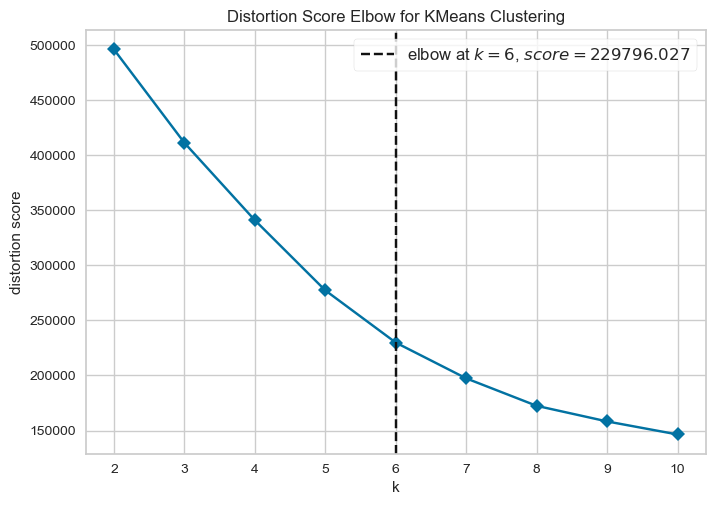

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [135]:
visualizer = KElbowVisualizer(KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42), k=(2,11), metric='distortion', timings=False)
visualizer.fit(df_paiement)
visualizer.show()

In [136]:
for k in [5, 6, 7]:
    labels = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42).fit_predict(df_paiement)
    score = silhouette_score(df_paiement, labels)
    print(f"Silhouette Score for {k} clusters: {score}")

Silhouette Score for 5 clusters: 0.37978126319175554
Silhouette Score for 6 clusters: 0.39577772228412406
Silhouette Score for 7 clusters: 0.4000394481859765


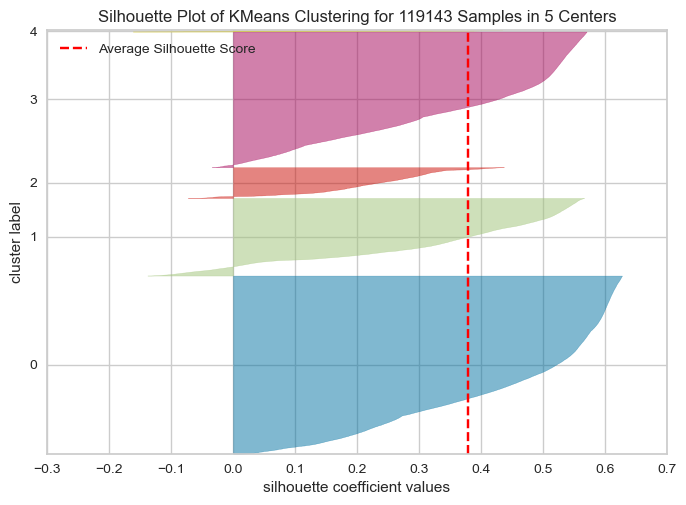

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 119143 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [137]:
model = KMeans(n_clusters=5, init='k-means++', n_init=10, random_state=42)
    
# Visualisation des silhouettes
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(df_paiement)
visualizer.show()

In [138]:
optimal_k_paiement = 5
kmeans_optimal = KMeans(n_clusters=optimal_k_paiement, init='k-means++', n_init=10, random_state=42)
clusters_optimal_paiement = kmeans_optimal.fit_predict(df_paiement)

# Calcul des métriques d'évaluation pour les clusters
calinski_score = calinski_harabasz_score(df_paiement, clusters_optimal_paiement)
db_score = davies_bouldin_score(df_paiement, clusters_optimal_paiement)

print(f'Métriques pour k={optimal_k_paiement}:')
print(f'Calinski-Harabasz Score: {calinski_score}')
print(f'Davies-Bouldin Score: {db_score}')

Métriques pour k=5:
Calinski-Harabasz Score: 34225.49324140608
Davies-Bouldin Score: 0.8735671319108018


Variance expliquée par les composantes PCA : [0.34292246 0.21039978]
Total variance expliquée : 0.5533222327914128


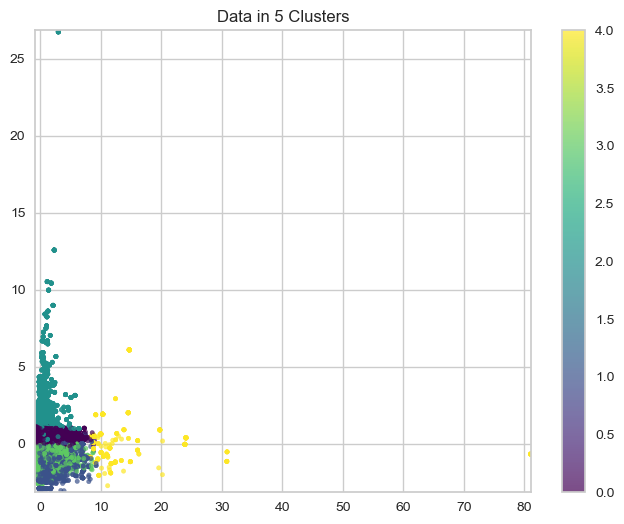

In [139]:
# Appliquer la PCA sur les données normalisées
pca = PCA(n_components=2, random_state = 42)
df_pca_paiement = pca.fit_transform(df_paiement)

# Convertir en DataFrame
df_pca_paiement = pd.DataFrame(df_pca_paiement, columns=['PCA1', 'PCA2'])
df_pca_paiement['Cluster'] = clusters_optimal_paiement  # Assigne les clusters

# Vérifier la variance expliquée
print("Variance expliquée par les composantes PCA :", pca.explained_variance_ratio_)
print(f"Total variance expliquée : {sum(pca.explained_variance_ratio_)}")

# Tracer le scatter plot avec ajustement d'échelle et taille des points
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca_paiement['PCA1'], 
                       df_pca_paiement['PCA2'], 
                       c=df_pca_paiement['Cluster'], 
                       cmap='viridis', 
                       alpha=0.7, 
                       s=10)  # Augmenter la taille des points pour les voir

# Ajouter des limites 
plt.xlim(df_pca_paiement['PCA1'].min() - 0.1, df_pca_paiement['PCA1'].max() + 0.1)
plt.ylim(df_pca_paiement['PCA2'].min() - 0.1, df_pca_paiement['PCA2'].max() + 0.1)

# Ajouter titre et colorbar
plt.colorbar(scatter)
plt.title(f"Data in {len(set(clusters_optimal_paiement))} Clusters")
plt.show()


#### Calcul des moyennes 

In [141]:
# Ajouter les clusters au DataFrame original
df_paiement = df_paiement.copy()  # Éviter la modification sur une vue
df_paiement.loc[:, 'Cluster'] = clusters_optimal_paiement


# Calcul des moyennes par cluster
cluster_means_scaled_5 = df_paiement.groupby('Cluster')[['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment']].mean().sort_index()

print(cluster_means_scaled_5)

          recency  frequency   monetary  avg_review  avg_payment
Cluster                                                         
0       -0.761850  -0.221740  -0.084160    0.455038    -0.061039
1        0.020557  -0.221294   0.038659   -1.805009     0.113915
2       -0.093971   2.794145   0.165522    0.042140    -0.068906
3        1.011211  -0.221230  -0.072398    0.435548    -0.048869
4       -0.123591   0.746218  13.009212   -1.047585     8.376922


In [142]:
display(df_paiement['Cluster'].value_counts().sort_index())

Cluster
0    50133
1    21841
2     8634
3    38173
4      362
Name: count, dtype: int64

In [143]:
quantitative_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment', 'diversity_products', 'avg_installments']
target_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment']

In [144]:
cluster_means_original_5 = inverse_transform_mean(
    cluster_means_scaled_5,  # DataFrame des moyennes normalisées par cluster
    df_final,              # DataFrame original non transformé
    quantitative_features, # Variables standardisées
    target_features        # Variables à inverser
)

print("Moyennes en échelle d'origine:")
print(cluster_means_original_5)

Moyennes en échelle d'origine:
            recency  frequency      monetary  avg_review  avg_payment
Cluster                                                              
0        170.891888   1.000000    243.223494    4.653322   156.513837
1        290.876105   1.000183    448.234826    1.526762   203.005911
2        273.312949   2.239402    659.995834    4.082117   154.423227
3        442.795615   1.000210    262.856691    4.626359   159.747900
4        268.770718   1.397790  22098.865442    2.574586  2398.813204


- Cluster 0: se différencie par  leur nouveauté et leur satisfaction
- Cluster 1: se différencie par leur insatisfaction
- Cluster 2: se différencie par leur fréquence d'achat
- CLuster 3: se différencie par leur inactivité
- Cluster 4: se différencie par leur grande dépenses

#### Interprétation ajout de la variable avg_paiments: 

**Rappel modèle de base**:
- Silhouette : 0.54
- Calinski-Harabasz : 60721
- Davies-Bouldin Score: 0.61

**Rappel modèle avg_paiments**:

- Silhouette : 0.38
- Calinski-Harabasz Score: 34225- Davies-Bouldin Score: 0.87

L’ajout d’avg_payments permet de distinguer les clients en fonction de leur montant moyen pay qui n'apporte pas beaucoup plus d'informations que la variable Monetary. On voit que la différenciation des clustering sont moins performants avec cette variable.s

In [147]:
non_significant_tests_2 = []

# Boucle sur les features RFM
for feature in ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment']:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_original_5.index:
        for j in cluster_means_original_5.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_paiement[df_paiement['Cluster'] == i][feature]
                group_2 = df_paiement[df_paiement['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_original_5.loc[i, feature]
                mean_2 = cluster_means_original_5.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=-19087.8774, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=-9662.8415, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=-71316.6094, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=-2127.3846, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=1468.8184, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=-22605.3847, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=477.0192, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=-15602.0333, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 4): t-stat=96.3971, p-value=0.0000
T-test Recency (Cluster 3 vs Cluster 4): t-stat=3777.3699, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=-0.8220, p-value=0.4111
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=-50.6348, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=-1.1625, p-value=0.2451
T-test Frequency (Cluster 0 vs

In [148]:
for feature, i, j, p_value in non_significant_tests_2:
    if p_value > 0.05:
        print(f" T-test {feature} (Cluster {i} vs Cluster {j}): p-value={p_value:.4f} (Non significatif)")

In [149]:
non_significant_tests_3 = []

for feature in ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment']:
    # Compare les paires de clusters
    
    for i in range(len(cluster_means_scaled_5)):  # Clusters de 0 à N-1
        for j in range(i+1, len(cluster_means_scaled_5)):  # Comparaison entre i et j, j > i
            
            # Obtenir les données des groupes
            group_1 = df_paiement[df_paiement['Cluster'] == i][feature]
            group_2 = df_paiement[df_paiement['Cluster'] == j][feature]

            # Utiliser les moyennes de moyennes_par_cluster
            mean_1 = cluster_means_scaled_5.loc[i, feature]
            mean_2 = cluster_means_scaled_5.loc[j, feature]

            # Calculer les écarts-types et tailles des groupes
            std_1 = group_1.std()  # Calcul de l'écart-type du groupe 1
            std_2 = group_2.std()  # Calcul de l'écart-type du groupe 2
            n_1 = len(group_1)     # Taille du groupe 1
            n_2 = len(group_2)     # Taille du groupe 2

            # Effectuer le test t avec les statistiques calculées
            t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1, mean_2, std_2, n_2, equal_var = False)

            # Afficher les résultats du test t
            print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=-124.4704, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=-63.0106, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=-465.0496, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=-13.8725, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=9.5780, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=-147.4078, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=3.1106, p-value=0.0020
T-test Recency (Cluster 2 vs Cluster 3): t-stat=-101.7395, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 4): t-stat=0.6286, p-value=0.5300
T-test Recency (Cluster 3 vs Cluster 4): t-stat=24.6319, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=-2.0001, p-value=0.0455
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=-123.2116, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=-2.8287, p-value=0.0047
T-test Frequency (Cluster 0 vs Cluster 4): t-stat

In [150]:
for feature, i, j, p_value in non_significant_tests_3:
    if p_value > 0.05:
        print(f" T-test {feature} (Cluster {i} vs Cluster {j}): p-value={p_value:.4f} (Non significatif)")

### 5. Ajout de avg_installments (modèle RFM + avg_review)

In [152]:
df_installments = df_final_encoded[['recency', 
                                    'frequency', 
                                    'monetary',
                                    'avg_review',
                                    'avg_installments']]

#### Choix du nombre de cluster optimal

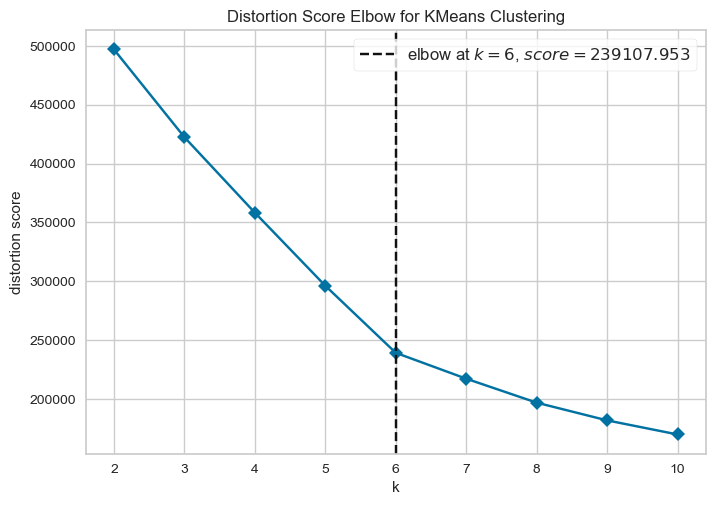

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [154]:
visualizer = KElbowVisualizer(KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42), k=(2,11), metric='distortion', timings=False)
visualizer.fit(df_installments)
visualizer.show()

In [155]:
print(df_installments.describe())

            recency     frequency      monetary    avg_review  \
count  1.191430e+05  1.191430e+05  1.191430e+05  1.191430e+05   
mean   1.252990e-16  5.325656e-17  4.508618e-17 -3.077311e-17   
std    1.000004e+00  1.000004e+00  1.000004e+00  1.000004e+00   
min   -1.876222e+00 -2.217399e-01 -2.298710e-01 -2.185781e+00   
25%   -8.133127e-01 -2.217399e-01 -1.875038e-01 -3.786455e-01   
50%   -1.286165e-01 -2.217399e-01 -1.488928e-01  7.056356e-01   
75%    7.125815e-01 -2.217399e-01 -6.021035e-02  7.056356e-01   
max    3.157925e+00  3.871167e+01  6.525761e+01  7.056356e-01   

       avg_installments  
count      1.191430e+05  
mean      -4.914155e-17  
std        1.000004e+00  
min       -1.074811e+00  
25%       -7.093748e-01  
50%       -3.439384e-01  
75%        3.869345e-01  
max        7.695663e+00  


In [156]:
for k in [5, 6]:
    labels = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42).fit_predict(df_installments)
    score = silhouette_score(df_installments, labels)
    print(f"Silhouette Score for {k} clusters: {score}")

Silhouette Score for 5 clusters: 0.32133108227273177
Silhouette Score for 6 clusters: 0.35330836606205884


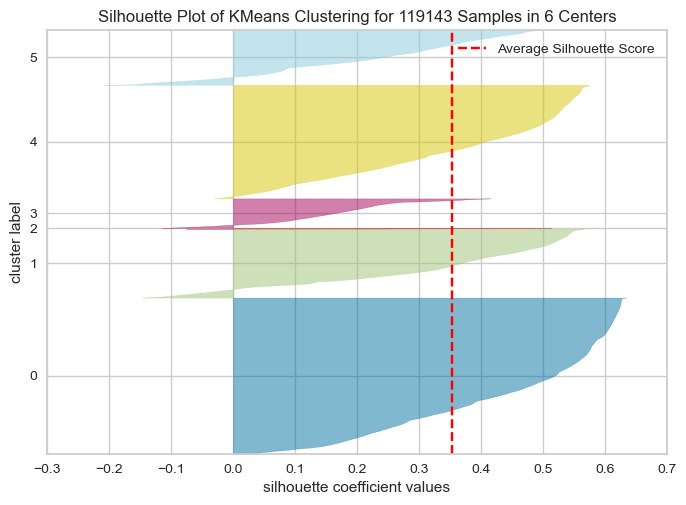

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 119143 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [157]:
model = KMeans(n_clusters = 6, n_init=10, random_state=42)
    
# Visualisation des silhouettes
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(df_installments)
visualizer.show()

In [158]:
optimal_k_installments = 6
kmeans_optimal = KMeans(n_clusters=optimal_k_installments, init='k-means++', n_init=10, random_state=42)
clusters_optimal_installments = kmeans_optimal.fit_predict(df_installments)

# Calcul des métriques d'évaluation pour les clusters
calinski_score = calinski_harabasz_score(df_installments, clusters_optimal_installments)
db_score = davies_bouldin_score(df_installments, clusters_optimal_installments)

print(f'Métriques pour k={optimal_k_installments}:')
print(f'Calinski-Harabasz Score: {calinski_score}')
print(f'Davies-Bouldin Score: {db_score}')

Métriques pour k=6:
Calinski-Harabasz Score: 35536.32844381076
Davies-Bouldin Score: 0.881047644980745


Variance expliquée par les composantes PCA : [0.23545149 0.21151166]
Total variance expliquée : 0.44696315853138446


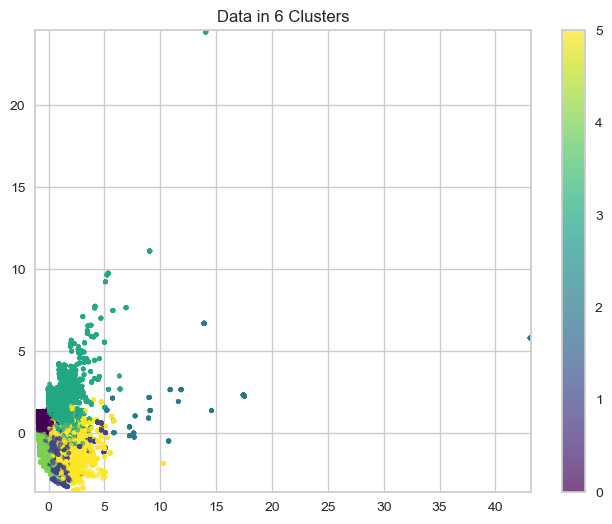

In [159]:
# Appliquer la PCA sur les données normalisées
pca = PCA(n_components=2, random_state = 42)
df_pca_installments = pca.fit_transform(df_installments)

# Convertir en DataFrame
df_pca_installments = pd.DataFrame(df_pca_installments, columns=['PCA1', 'PCA2'])
df_pca_installments['Cluster'] = clusters_optimal_installments  # Assigne les clusters

# Vérifier la variance expliquée
print("Variance expliquée par les composantes PCA :", pca.explained_variance_ratio_)
print(f"Total variance expliquée : {sum(pca.explained_variance_ratio_)}")

# Tracer le scatter plot avec ajustement d'échelle et taille des points
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca_installments['PCA1'], 
                       df_pca_installments['PCA2'], 
                       c=df_pca_installments['Cluster'], 
                       cmap='viridis', 
                       alpha=0.7, 
                       s=10)  # Augmenter la taille des points pour les voir

# Ajouter des limites pour éviter un affichage vide
plt.xlim(df_pca_installments['PCA1'].min() - 0.1, df_pca_installments['PCA1'].max() + 0.1)
plt.ylim(df_pca_installments['PCA2'].min() - 0.1, df_pca_installments['PCA2'].max() + 0.1)

# Ajouter titre et colorbar
plt.colorbar(scatter)
plt.title(f"Data in {len(set(clusters_optimal_installments))} Clusters")
plt.show()


#### Calcul des moyennes 

In [161]:
# Ajouter les clusters au DataFrame original
df_installments = df_installments.copy()  # Éviter la modification sur une vue
df_installments.loc[:, 'Cluster'] = clusters_optimal_installments


# Calcul des moyennes par cluster
cluster_means_scaled_6 = df_installments.groupby('Cluster')[['recency', 
                                    'frequency', 
                                    'monetary',
                                    'avg_review',
                                    'avg_installments']].mean().sort_index()


print(cluster_means_scaled_6)

          recency  frequency   monetary  avg_review  avg_installments
Cluster                                                              
0       -0.760825  -0.221740  -0.107029    0.452253         -0.392680
1        0.018340  -0.216461   0.005384   -1.834341         -0.196507
2       -0.130066   1.023898  16.237085   -1.067078          0.315877
3       -0.121976   2.820448   0.155047    0.052245          0.019024
4        1.032060  -0.221740  -0.099592    0.435713         -0.343207
5        0.072750  -0.167320   0.157079    0.100751          2.073275


In [162]:
print(df_installments['Cluster'].value_counts().sort_index())

Cluster
0    43942
1    19361
2      252
3     8273
4    31978
5    15337
Name: count, dtype: int64


In [163]:
quantitative_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment', 'diversity_products', 'avg_installments']
target_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_installments']

In [164]:
cluster_means_original_6 = inverse_transform_mean(
    cluster_means_scaled_6,  # DataFrame des moyennes normalisées par cluster
    df_final,              # DataFrame original non transformé
    quantitative_features, # Variables standardisées
    target_features        # Variables à inverser
)

print("Moyennes en échelle d'origine:")
print(cluster_means_original_6)


Moyennes en échelle d'origine:
            recency  frequency      monetary  avg_review  avg_installments
Cluster                                                                   
0        171.049087   1.000000    205.049988    4.649470          1.866620
1        290.536233   1.002169    392.690836    1.486184          2.403440
2        267.777778   1.511905  27486.877460    2.547619          3.805556
3        269.018373   2.250212    642.510053    4.096096          2.993231
4        445.992839   1.000000    217.464136    4.626587          2.002001
5        298.880159   1.022364    645.902149    4.163200          8.614592


- Cluster 0: Client nouveau, très récent, panier de valeur faible mais très satisfait avec presque jamais d'échelonnage => se différencie par leur nouveauté et leur satisfaction
- Cluster 1: Client très insatisfait, avec 2 échelonnage en moyenne => se différencie par leur insatisfaction
- Cluster 2: Clients qui achètent un peu plus fréquemment, avec un panier de valeur très élevé mais peu satisfait et avec beaucoup d'échelonnage de paiement => se différencie par leur dépenses élevées
- Cluster 3: Acheteur très régulier, avec un panier de valeur élevé et satisfait et des échelonnage à 3 en moyenne => se différencie par leur fréquence d'achat
- Cluster 4: Client anciens, perdu qui n'ont commandé qu'une fois avec un très peu de dépenses mais très satisfait et 2 échelonnage de paiement en moyenne => se différencie par leur inactivité 
- Cluster 5: Client avec un panier moyen élevé et satisfait avec beaucoup d'échelonnage de paiement => se différencie par leur nombre d'échelonnage de paiement élevé. 

#### Interprétation ajout de la variable avg_installments: 
**Rappel modèle de base**:
- k = 5
- Silhouette : 0.54
- Calinski-Harabasz : 60721
- Davies-Bouldin Score: 0.61

**Rappel modèle avg_installemnts**:

- k = 6
- Silhouette : 0.35
- Calinski-Harabasz Score: 35536- Davies-Bouldin Score: 0.88
  
 Les scores indiquent une segmentation modérée plus faible que la base mais ajoute une information sur la capacité de paiement des clients. Le nombre de cluster augmente mais les différenciations s'effectuent facilement entre clusters. 

In [167]:
non_significant_tests_4 = [] 

for feature in ['recency', 'frequency', 'monetary', 'avg_review', 'avg_installments']:
    # Compare les paires de clusters
    for i in range(len(cluster_means_scaled_6)):  # Clusters de 0 à N-1
        for j in range(i+1, len(cluster_means_scaled_6)):  # Comparaison entre i et j, j > i
            # Obtenir les données des groupes
            group_1 = df_installments[df_installments['Cluster'] == i][feature]
            group_2 = df_installments[df_installments['Cluster'] == j][feature]

            # Utiliser les moyennes de moyennes_par_cluster
            mean_1 = cluster_means_scaled_6.loc[i, feature]
            mean_2 = cluster_means_scaled_6.loc[j, feature]

            # Calculer les écarts-types et tailles des groupes
            std_1 = group_1.std()  # Calcul de l'écart-type du groupe 1
            std_2 = group_2.std()  # Calcul de l'écart-type du groupe 2
            n_1 = len(group_1)     # Taille du groupe 1
            n_2 = len(group_2)     # Taille du groupe 2

            # Effectuer le test t avec les statistiques calculées
            t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1, mean_2, std_2, n_2, equal_var=False)

            # Afficher les résultats du test t
            print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=-116.0812, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=-13.7881, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=-59.6390, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=-431.9910, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 5): t-stat=-101.8531, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=3.2175, p-value=0.0015
T-test Recency (Cluster 1 vs Cluster 3): t-stat=11.4783, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=-140.6915, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 5): t-stat=-5.3961, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=-0.1726, p-value=0.8631
T-test Recency (Cluster 2 vs Cluster 4): t-stat=-25.3620, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 5): t-stat=-4.3747, p-value=0.0000
T-test Recency (Cluster 3 vs Cluster 4): t-stat=-104.6501, p-value=0.0000
T-test Recency (Cluster 3 vs Cluster 5): t-stat=-14.

In [168]:
for feature, i, j, p_value in non_significant_tests_4:
    if p_value > 0.05:
        print(f" T-test {feature} (Cluster {i} vs Cluster {j}): p-value={p_value:.4f} (Non significatif)")

In [169]:
non_significant_tests_5 = [] 

for feature in ['recency', 'frequency', 'monetary', 'avg_review', 'avg_installments']:
    # Compare les paires de clusters
    for i in range(len(cluster_means_original_6)):  # Clusters de 0 à N-1
        for j in range(i+1, len(cluster_means_original_6)):  # Comparaison entre i et j, j > i
            # Obtenir les données des groupes
            group_1 = df_installments[df_installments['Cluster'] == i][feature]
            group_2 = df_installments[df_installments['Cluster'] == j][feature]

            # Utiliser les moyennes de moyennes_par_cluster
            mean_1 = cluster_means_original_6.loc[i, feature]
            mean_2 = cluster_means_original_6.loc[j, feature]

            # Calculer les écarts-types et tailles des groupes
            std_1 = group_1.std()  # Calcul de l'écart-type du groupe 1
            std_2 = group_2.std()  # Calcul de l'écart-type du groupe 2
            n_1 = len(group_1)     # Taille du groupe 1
            n_2 = len(group_2)     # Taille du groupe 2

            # Effectuer le test t avec les statistiques calculées
            t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1, mean_2, std_2, n_2, equal_var=False)

            # Afficher les résultats du test t
            print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=-17801.3609, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=-2114.4433, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=-9145.8014, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=-66246.9943, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 5): t-stat=-15619.4552, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=493.4162, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=1760.2345, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=-21575.4278, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 5): t-stat=-827.5102, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=-26.4668, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 4): t-stat=-3889.3259, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 5): t-stat=-670.8692, p-value=0.0000
T-test Recency (Cluster 3 vs Cluster 4): t-stat=-16048.3708, p-value=0.0000
T-test Recency (Cluster 3 v

In [170]:
for feature, i, j, p_value in non_significant_tests_5:
    if p_value > 0.05:
        print(f" T-test {feature} (Cluster {i} vs Cluster {j}): p-value={p_value:.4f} (Non significatif)")

### 6. Ajout de diversity_products (modèle RFM + review)

In [172]:
df_categorie = df_final_encoded[['recency', 'frequency', 'monetary', 'avg_review', 'diversity_products']]

#### Choix du nombre de cluster optimal

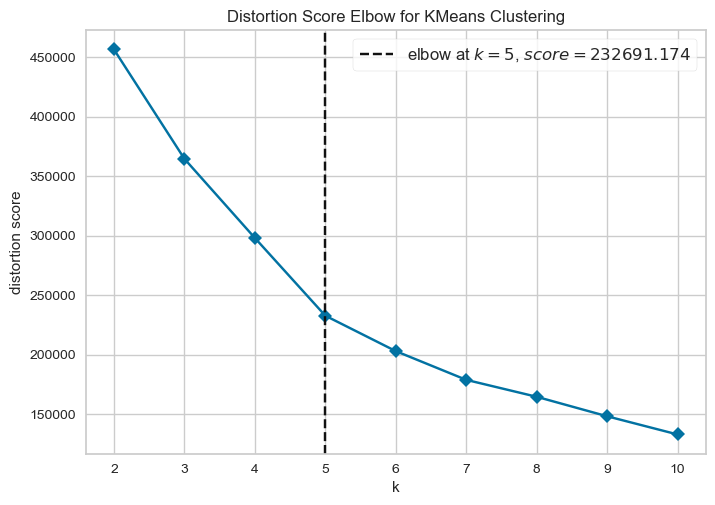

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [174]:
visualizer = KElbowVisualizer(KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42), k = (2,11), metric = 'distortion', timings = False)
visualizer.fit(df_categorie)
visualizer.show()

In [175]:
for k in [5, 6, 7]:
    labels = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42).fit_predict(df_categorie)
    score = silhouette_score(df_categorie, labels)
    print(f"Silhouette Score for {k} clusters: {score}")


Silhouette Score for 5 clusters: 0.427104143101091
Silhouette Score for 6 clusters: 0.42788282226619995
Silhouette Score for 7 clusters: 0.4493571566803819


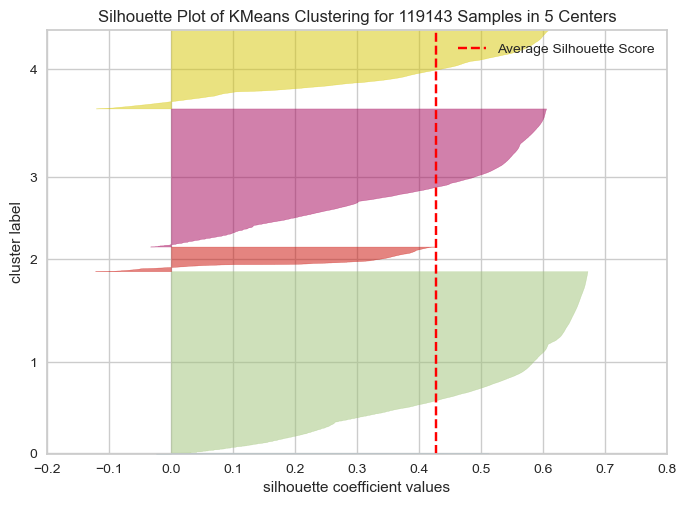

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 119143 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [176]:
# Tester plusieurs valeurs de k autour de celui trouvé avec le coude
N_CLUSTERS = 5
model = KMeans(n_clusters=N_CLUSTERS, init='k-means++', n_init=10, random_state=42)
    
# Visualisation des silhouettes
visualizer = SilhouetteVisualizer(model, colors = 'yellowbrick')
visualizer.fit(df_categorie)
visualizer.show()

In [177]:
OPTIMAL_K_CATEGORIE = 5
kmeans_optimal = KMeans(n_clusters=OPTIMAL_K_CATEGORIE, init='k-means++', n_init=10, random_state=42)
clusters_optimal_categorie = kmeans_optimal.fit_predict(df_categorie)

# Calcul des métriques d'évaluation pour les clusters
calinski_score = calinski_harabasz_score(df_categorie, clusters_optimal_categorie)
db_score = davies_bouldin_score(df_categorie, clusters_optimal_categorie)

print(f'Métriques pour k={OPTIMAL_K_CATEGORIE}:')
print(f'Calinski-Harabasz Score: {calinski_score}')
print(f'Davies-Bouldin Score: {db_score}')

Métriques pour k=5:
Calinski-Harabasz Score: 46467.0960857984
Davies-Bouldin Score: 0.7658713022557702


Variance expliquée par les composantes PCA : [0.33258216 0.21601971]
Total variance expliquée : 0.5486018652429567


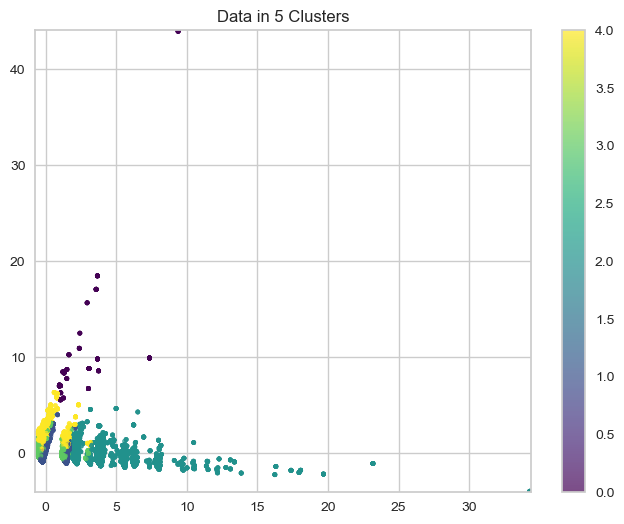

In [178]:
# Appliquer la PCA sur les données normalisées
pca = PCA(n_components=2, random_state = 42)
df_pca_categorie = pca.fit_transform(df_categorie)

# Convertir en DataFrame
df_pca_categorie = pd.DataFrame(df_pca_categorie, columns=['PCA1', 'PCA2'])
df_pca_categorie['Cluster'] = clusters_optimal_categorie  # Assigne les clusters

# Vérifier la variance expliquée
print("Variance expliquée par les composantes PCA :", pca.explained_variance_ratio_)
print(f"Total variance expliquée : {sum(pca.explained_variance_ratio_)}")

# Tracer le scatter plot avec ajustement d'échelle et taille des points
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca_categorie['PCA1'], 
                       df_pca_categorie['PCA2'], 
                       c=df_pca_categorie['Cluster'], 
                       cmap='viridis', 
                       alpha=0.7, 
                       s=10)  # Augmenter la taille des points pour les voir

# Ajouter des limites 
plt.xlim(df_pca_categorie['PCA1'].min() - 0.1, df_pca_categorie['PCA1'].max() + 0.1)
plt.ylim(df_pca_categorie['PCA2'].min() - 0.1, df_pca_categorie['PCA2'].max() + 0.1)

# Ajouter titre et colorbar
plt.colorbar(scatter)
plt.title(f"Data in {len(set(clusters_optimal_categorie))} Clusters")
plt.show()


#### Calcul des moyennes 

In [180]:
# Ajouter les clusters au DataFrame original
df_categorie = df_categorie.copy()  # Éviter la modification sur une vue
df_categorie.loc[:, 'Cluster'] = clusters_optimal_categorie


# Calcul des moyennes par cluster
cluster_mean_scaled_7 = df_categorie.groupby('Cluster')[['recency', 
                                                         'frequency', 
                                                         'monetary', 
                                                         'avg_review',  
                                                         'diversity_products']].mean().sort_index()

print(cluster_mean_scaled_7)

          recency  frequency   monetary  avg_review  diversity_products
Cluster                                                                
0       -0.116570   0.976354  15.937866   -1.109777           -0.092347
1       -0.759174  -0.154963  -0.077013    0.458228           -0.225850
2       -0.197527   2.304662   0.195211   -0.127592            3.649531
3        1.017360  -0.136156  -0.065867    0.435870           -0.225310
4        0.029228  -0.137111   0.043929   -1.781073           -0.225850


In [181]:
display(df_categorie['Cluster'].value_counts().sort_index())

Cluster
0      262
1    51089
2     6929
3    38867
4    21996
Name: count, dtype: int64

In [182]:
quantitative_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment', 'diversity_products', 'avg_installments']
target_features = ['recency', 'frequency', 'monetary', 'avg_review', 'diversity_products']

In [183]:
cluster_means_original_7 = inverse_transform_mean(
    cluster_mean_scaled_7,  # DataFrame des moyennes normalisées par cluster
    df_final,               # DataFrame original non transformé
    quantitative_features,  # Variables standardisées
    target_features         # Variables à inverser
)

print("Moyennes en échelle d'origine:")
print(cluster_means_original_7)


Moyennes en échelle d'origine:
            recency  frequency      monetary  avg_review  diversity_products
Cluster                                                                     
0        269.847328   1.492366  26987.416489    2.488550            1.038168
1        171.302374   1.027442    255.152422    4.657735            1.000000
2        257.432386   2.038245    709.553601    3.847308            2.107952
3        443.738544   1.035171    273.757015    4.626804            1.000154
4        292.205947   1.034779    457.030646    1.559875            1.000000


- Cluster 0: Client achète un peu plus fréquemment que la moyenne mais avec de très grande dépenses peu satifait et achète en moyenne peu de variété de produits => se différencie par leurs dépenses élevées
- Cluster 1: Client nouveau avec une dépense moyenne faible mais très satisfait n'achète qu'un type de produit => se différencie par leur nouveauté (nouveau client) et par leur satisfaction
- Cluster 2: Clients fréquents avec dépenses moyenne élevé moyennement satisfait achètent divers types de produits => se différencie par leur fréquence élevée et leur diversité de produits
- Cluster 3: Anciens clients, perdu avec des dépenses faibles mais très satisfaits n'achètent pas de catégories de produits différents => se différencie par leur inactivité
- Cluster 4: Clients très insatisfaits n'achètent qu'un type de produits => se différencie par leur insatisfaction

#### Interprétation ajout de la variable diversity_products: 
**Rappel modèle de base**:
- k = 5
- Silhouette : 0.54
- Calinski-Harabasz : 60721
- Davies-Bouldin Score: 0.61

**Rappel modèle diversity_products**:

- k =5 
- Silhouette : 0.43
- Calinski-Harabasz Score: 46467- Davies-Bouldin Score: 0.77
  
L’introduction de diversity_products (nombre de catégories achetées) permet de mettre en évidence la variété des achats.Les scores sont un peu moins bons mais restent tout de même acceptable et apporte une information importantes sur les profils clients.

In [186]:
non_significant_tests_6 = []

for feature in ['recency', 'frequency', 'monetary', 'avg_review', 'diversity_products']:
    # Compare les paires de clusters
    
    for i in range(len(cluster_means_original_7)):  # Clusters de 0 à N-1
        for j in range(i+1, len(cluster_means_original_7)):  # Comparaison entre i et j, j > i
            
            # Obtenir les données des groupes
            group_1 = df_categorie[df_categorie['Cluster'] == i][feature]
            group_2 = df_categorie[df_categorie['Cluster'] == j][feature]

            # Utiliser les moyennes de moyennes_par_cluster
            mean_1 = cluster_means_original_7.loc[i, feature]
            mean_2 = cluster_means_original_7.loc[j, feature]

            # Calculer les écarts-types et tailles des groupes
            std_1 = group_1.std()  # Calcul de l'écart-type du groupe 1
            std_2 = group_2.std()  # Calcul de l'écart-type du groupe 2
            n_1 = len(group_1)     # Taille du groupe 1
            n_2 = len(group_2)     # Taille du groupe 2

            # Effectuer le test t avec les statistiques calculées
            t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1, mean_2, std_2, n_2, equal_var = False)

            # Afficher les résultats du test t
            print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")

T-test Recency (Cluster 0 vs Cluster 1): t-stat=2229.9198, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=272.4544, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=-3929.3528, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=-502.1437, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=-7490.8646, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=-72040.9709, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=-19499.9645, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=-15876.0457, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 4): t-stat=-2733.3125, p-value=0.0000
T-test Recency (Cluster 3 vs Cluster 4): t-stat=22857.4915, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=3.4517, p-value=0.0006
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=-3.9253, p-value=0.0001
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=3.3941, p-value=0.0008
T-test Frequency (Cluster 0 vs 

In [187]:
for feature, i, j, p_value in non_significant_tests_6:
    if p_value > 0.05:
        print(f" T-test {feature} (Cluster {i} vs Cluster {j}): p-value={p_value:.4f} (Non significatif)")

In [188]:
non_significant_tests_7 = []

for feature in ['recency', 'frequency', 'monetary', 'avg_review', 'diversity_products']:
    # Compare les paires de clusters
    
    for i in range(len(cluster_mean_scaled_7)):  # Clusters de 0 à N-1
        for j in range(i+1, len(cluster_mean_scaled_7)):  # Comparaison entre i et j, j > i
            
            # Obtenir les données des groupes
            group_1 = df_categorie[df_categorie['Cluster'] == i][feature]
            group_2 = df_categorie[df_categorie['Cluster'] == j][feature]

            # Utiliser les moyennes de moyennes_par_cluster
            mean_1 = cluster_mean_scaled_7.loc[i, feature]
            mean_2 = cluster_mean_scaled_7.loc[j, feature]

            # Calculer les écarts-types et tailles des groupes
            std_1 = group_1.std()  # Calcul de l'écart-type du groupe 1
            std_2 = group_2.std()  # Calcul de l'écart-type du groupe 2
            n_1 = len(group_1)     # Taille du groupe 1
            n_2 = len(group_2)     # Taille du groupe 2

            # Effectuer le test t avec les statistiques calculées
            t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1, mean_2, std_2, n_2, equal_var = False)

            # Afficher les résultats du test t
            print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=14.5411, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=1.7767, p-value=0.0767
T-test Recency (Cluster 0 vs Cluster 3): t-stat=-25.6230, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=-3.2744, p-value=0.0012
T-test Recency (Cluster 1 vs Cluster 2): t-stat=-48.8473, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=-469.7731, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=-127.1576, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=-103.5264, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 4): t-stat=-17.8237, p-value=0.0000
T-test Recency (Cluster 3 vs Cluster 4): t-stat=149.0518, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=8.3992, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=-9.5516, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=8.2591, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 4): t-stat=8

In [189]:
for feature, i, j, p_value in non_significant_tests_7:
    if p_value > 0.05:
        print(f" T-test {feature} (Cluster {i} vs Cluster {j}): p-value={p_value:.4f} (Non significatif)")

### 7. Ajout de toutes les variables avec top_category

In [191]:
df_all_1 = df_final_encoded[['recency', 
                           'frequency', 
                           'monetary',
                           'avg_review',
                           'has_review',
                           'diversity_products',
                           'avg_payment',
                           'avg_installments']+ top_category_cols]


#### Choix du nombre de cluster optimal

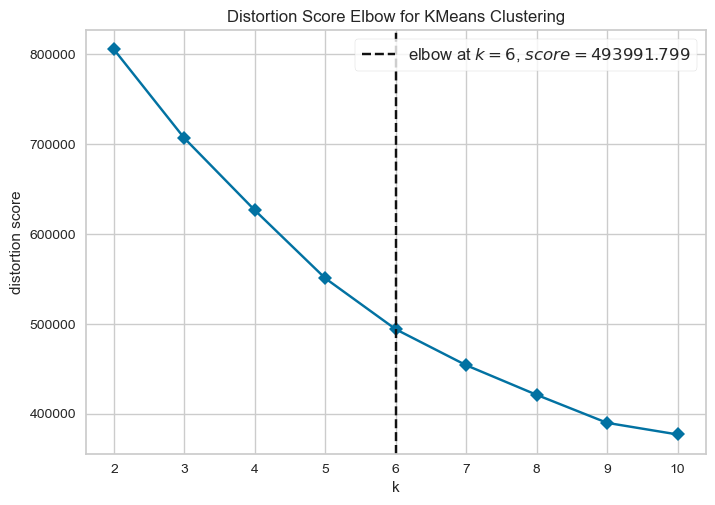

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [193]:
visualizer = KElbowVisualizer(KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42), k=(2,11), metric='distortion', timings=False)
visualizer.fit(df_all_1)
visualizer.show()

In [194]:
for k in [5, 6]:
    labels = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42).fit_predict(df_all_1)
    score = silhouette_score(df_all_1, labels)
    print(f"Silhouette Score for {k} clusters: {score}")

Silhouette Score for 5 clusters: 0.24047472888222532
Silhouette Score for 6 clusters: 0.20345164172259772


In [195]:
optimal_k_all_1 = 5
kmeans_optimal = KMeans(n_clusters=optimal_k_all_1, init='k-means++', n_init=10, random_state=42)
clusters_optimal_all_1 = kmeans_optimal.fit_predict(df_all_1)

# Calcul des métriques d'évaluation pour les clusters
calinski_score = calinski_harabasz_score(df_all_1, clusters_optimal_all_1)
db_score = davies_bouldin_score(df_all_1, clusters_optimal_all_1)

print(f'Métriques pour k={optimal_k_all_1}:')
print(f'Calinski-Harabasz Score: {calinski_score}')
print(f'Davies-Bouldin Score: {db_score}')

Métriques pour k=5:
Calinski-Harabasz Score: 21353.752688395238
Davies-Bouldin Score: 1.2894743857361457


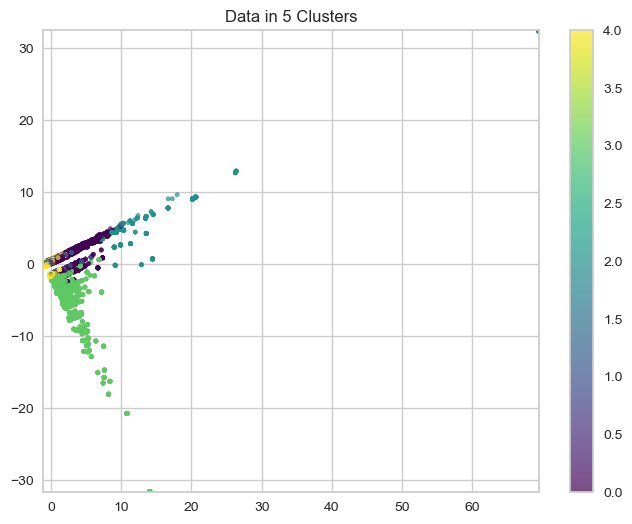

In [196]:
pca_all_1 = PCA(n_components=2, random_state = 42)
df_pca_all_1 = pca_all_1.fit_transform(df_all_1)

df_pca_all_1 = pd.DataFrame(df_pca_all_1, columns=['PCA1', 'PCA2'])
df_pca_all_1['Cluster'] = clusters_optimal_all_1

# Tracer le scatter plot avec ajustement d'échelle et taille des points
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca_all_1['PCA1'], 
                       df_pca_all_1['PCA2'], 
                       c=df_pca_all_1['Cluster'], 
                       cmap='viridis', 
                       alpha=0.7, 
                       s=10)  # Augmenter la taille des points pour les voir

# Ajouter des limites pour éviter un affichage vide
plt.xlim(df_pca_all_1['PCA1'].min() - 0.1, df_pca_all_1['PCA1'].max() + 0.1)
plt.ylim(df_pca_all_1['PCA2'].min() - 0.1, df_pca_all_1['PCA2'].max() + 0.1)

# Ajouter titre et colorbar
plt.colorbar(scatter)
plt.title(f"Data in {len(set(clusters_optimal_all_1))} Clusters")
plt.show()


#### Calcul des moyennes 

In [198]:
# Ajouter les clusters au DataFrame original
df_all_1 = df_all_1.copy()  # Éviter la modification sur une vue
df_all_1.loc[:, 'Cluster'] = clusters_optimal_all_1


# Calcul des moyennes par cluster
cluster_means_scaled_final_1 = df_all_1.groupby('Cluster')[['recency', 
                                                            'frequency', 
                                                            'monetary',
                                                            'avg_review',
                                                            'has_review',
                                                            'diversity_products',
                                                            'avg_payment',
                                                            'avg_installments']+ top_category_cols].mean().sort_index()


print(cluster_means_scaled_final_1)

          recency  frequency   monetary  avg_review  has_review  \
Cluster                                                           
0        0.134475  -0.117117   0.201362    0.134028    0.989070   
1        0.034968  -0.141676  -0.036596   -1.605723    1.000000   
2       -0.107641   0.863092  13.997108   -1.084715    0.934985   
3       -0.187992   2.353367   0.156797   -0.112401    0.991761   
4       -0.027390  -0.153668  -0.118351    0.522501    0.989714   

         diversity_products  avg_payment  avg_installments  \
Cluster                                                      
0                 -0.200883     0.760208          1.851452   
1                 -0.224965    -0.089057         -0.259701   
2                 -0.009269     8.426168          0.501204   
3                  3.653776    -0.016150          0.175963   
4                 -0.225850    -0.200792         -0.403519   

         top_category_agro_industry_and_commerce  \
Cluster                                    

In [199]:
quantitative_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment', 'diversity_products', 'avg_installments']
target_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment', 'diversity_products', 'avg_installments', 'has_review']

In [200]:
cluster_means_original_final_1 = inverse_transform_mean(
    cluster_means_scaled_final_1,  # DataFrame des moyennes normalisées par cluster
    df_final,              # DataFrame original non transformé
    quantitative_features, # Variables standardisées
    target_features        # Variables à inverser
)

print("Moyennes en échelle d'origine:")
print(cluster_means_original_final_1)

Moyennes en échelle d'origine:
            recency  frequency      monetary  avg_review  avg_payment  \
Cluster                                                                 
0        308.345751   1.042996    719.820560    4.209235   374.751488   
1        293.086181   1.032903    322.617524    1.802455   149.068350   
2        271.216718   1.445820  23747.874768    2.523220  2411.899752   
3        258.894659   2.058261    645.432233    3.868324   168.442635   
4        283.523435   1.027975    186.151628    4.746651   119.375879   

         diversity_products  avg_installments  has_review  
Cluster                                                    
0                  1.007138          8.007584    0.989070  
1                  1.000253          2.230511    1.000000  
2                  1.061920          4.312693    0.934985  
3                  2.109166          3.422686    0.991761  
4                  1.000000          1.836961    0.989714  


In [201]:
display(df_all_1['Cluster'].value_counts().sort_index())

Cluster
0    17932
1    23706
2      323
3     6797
4    70385
Name: count, dtype: int64


- Cluster 0: se différencie par échelonnage de paiement élevé et inactivité 
- Cluster 1: se différencie par l'insatisfaction
- Cluster 2: se différencie par dépenses très élevées
- Cluster 3: se différenvie par récence et par fréquence d'achat élevé et type de produits diversifié
- Cluster 4: se différencie par dépenses faibles et grande satisfaction

In [203]:
# Identifier la catégorie la plus fréquente par cluster
modes_top_category_final_ = df_all_1.groupby("Cluster")[top_category_cols].sum().idxmax(axis=1)
#Additionne les 1 de chaque colonne OHE par cluster et idmax (axis = 1) retrouve la colonne où cette somme est maximale

# Afficher les résultats
print(modes_top_category_final_)

Cluster
0           top_category_bed_bath_table
1           top_category_bed_bath_table
2    top_category_computers_accessories
3           top_category_bed_bath_table
4            top_category_health_beauty
dtype: object


#### Interprétation modèle final avec toutes les variables 

**Rappel modèle de base**:
- Silhouette : 0.54
- Calinski-Harabasz : 60721
- Davies-Bouldin Score: 0.61

**Rappel modèle final 1**

- k = 5
- Silhouette : 0.24
- Calinski-Harabasz Score: 21353- Davies-Bouldin Score: 1.29


le silhouette score chute avec l'ajout de toute les variables, ce qui rend le modèle complexe.
La présence de variables comme top_category ne semble pas contribuer positivement.

In [205]:
non_significant_tests_8 = [] 

for feature in ['recency', 
                'frequency', 
                'monetary',
                'avg_review',
                'has_review',
                'diversity_products',
                'avg_payment',
                'avg_installments']+ top_category_cols:
    
    # Compare les paires de clusters
    
    for i in range(len(cluster_means_scaled_final_1)):  # Clusters de 0 à N-1
        for j in range(i+1, len(cluster_means_scaled_final_1)):  # Comparaison entre i et j, j > i
            
            # Obtenir les données des groupes
            group_1 = df_all_1[df_all_1['Cluster'] == i][feature]
            group_2 = df_all_1[df_all_1['Cluster'] == j][feature]

            # Utiliser les moyennes de moyennes_par_cluster
            mean_1 = cluster_means_scaled_final_1.loc[i, feature]
            mean_2 = cluster_means_scaled_final_1.loc[j, feature]

            # Calculer les écarts-types et tailles des groupes
            std_1 = group_1.std()  # Calcul de l'écart-type du groupe 1
            std_2 = group_2.std()  # Calcul de l'écart-type du groupe 2
            n_1 = len(group_1)     # Taille du groupe 1
            n_2 = len(group_2)     # Taille du groupe 2

            # Effectuer le test t avec les statistiques calculées
            t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1, mean_2, std_2, n_2, equal_var = False)

            # Afficher les résultats du test t
            print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")

            #Stocke les non significatif
            non_significant_tests_2.append((feature, i, j, p_value))


T-test Recency (Cluster 0 vs Cluster 1): t-stat=10.0480, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=4.9572, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=23.2161, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=18.8247, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=2.9328, p-value=0.0036
T-test Recency (Cluster 1 vs Cluster 3): t-stat=17.0049, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=8.5720, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=1.6203, p-value=0.1061
T-test Recency (Cluster 2 vs Cluster 4): t-stat=-1.6589, p-value=0.0981
T-test Recency (Cluster 3 vs Cluster 4): t-stat=-13.2115, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=5.1094, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=-8.5649, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=-70.0259, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 4): t-stat=8.7942, p-v

In [206]:
for feature, i, j, p_value in non_significant_tests_8:
    if p_value > 0.05:
        print(f" T-test {feature} (Cluster {i} vs Cluster {j}): p-value={p_value:.4f} (Non significatif)")

In [207]:
for feature in ['recency', 
                'frequency', 
                'monetary',
                'avg_review',
                'has_review',
                'diversity_products',
                'avg_payment',
                'avg_installments']:
    
    # Compare les paires de clusters
    
    for i in range(len(cluster_means_original_final_1)):  # Clusters de 0 à N-1
        for j in range(i+1, len(cluster_means_original_final_1)):  # Comparaison entre i et j, j > i
            
            # Obtenir les données des groupes
            group_1 = df_all_1[df_all_1['Cluster'] == i][feature]
            group_2 = df_all_1[df_all_1['Cluster'] == j][feature]

            # Utiliser les moyennes de moyennes_par_cluster
            mean_1 = cluster_means_original_final_1.loc[i, feature]
            mean_2 = cluster_means_original_final_1.loc[j, feature]

            # Calculer les écarts-types et tailles des groupes
            std_1 = group_1.std()  # Calcul de l'écart-type du groupe 1
            std_2 = group_2.std()  # Calcul de l'écart-type du groupe 2
            n_1 = len(group_1)     # Taille du groupe 1
            n_2 = len(group_2)     # Taille du groupe 2

            # Effectuer le test t avec les statistiques calculées
            t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1, mean_2, std_2, n_2, equal_var = False)

            # Afficher les résultats du test t
            print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=1540.8852, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=760.2012, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=3560.2486, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=2886.8127, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=449.7534, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=2607.7533, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=1314.5433, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=248.4726, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 4): t-stat=-254.3939, p-value=0.0000
T-test Recency (Cluster 3 vs Cluster 4): t-stat=-2026.0214, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=2.0997, p-value=0.0358
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=-3.5198, p-value=0.0005
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=-28.7777, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 4

- T-test Frequency (Cluster 1 vs Cluster 4): t-stat=1.5279, p-value=0.1265
- T-test Has_review (Cluster 0 vs Cluster 4): t-stat=-0.7447, p-value=0.4564
- T-test Has_review (Cluster 3 vs Cluster 4): t-stat=1.7641, p-value=0.0778
- T-test Diversity_products (Cluster 0 vs Cluster 2): t-stat=-1.1648, p-value=0.2450
- T-test Diversity_products (Cluster 1 vs Cluster 2): t-stat=-1.3126, p-value=0.1902
- T-test Diversity_products (Cluster 1 vs Cluster 4): t-stat=0.7004, p-value=0.4837
- T-test Diversity_products (Cluster 2 vs Cluster 4): t-stat=1.3180, p-value=0.1884


### 8. Ajout de toutes les variables sans top_category

In [210]:
df_all_2 = df_final_encoded[['recency', 
                           'frequency', 
                           'monetary',
                           'avg_review',
                           'has_review',
                           'diversity_products',
                           'avg_payment',
                           'avg_installments']]


#### Choix du nombre de cluster optimal

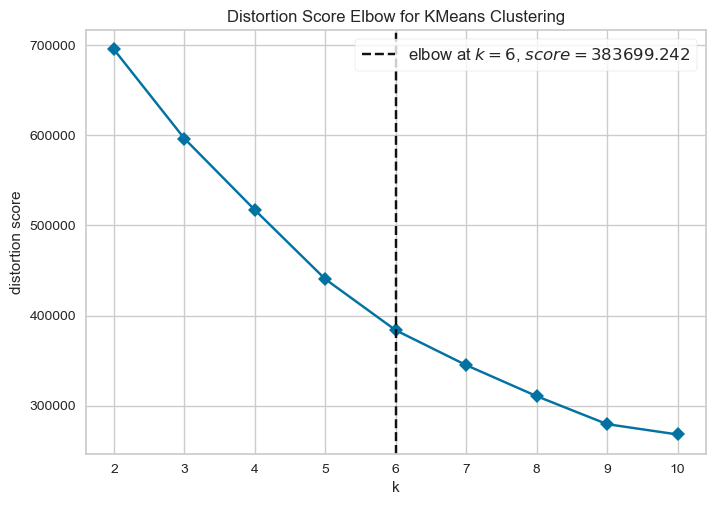

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [212]:
visualizer = KElbowVisualizer(KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42), k=(2,11), metric='distortion', timings=False)
visualizer.fit(df_all_2)
visualizer.show()

In [213]:
for k in [5, 6]:
    labels = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42).fit_predict(df_all_2)
    score = silhouette_score(df_all_2, labels)
    print(f"Silhouette Score for {k} clusters: {score}")

Silhouette Score for 5 clusters: 0.32662829012065003
Silhouette Score for 6 clusters: 0.3039536957739493


In [214]:
optimal_k_all_2 = 5
kmeans_optimal = KMeans(n_clusters=optimal_k_all_2, init='k-means++', n_init=10, random_state=42)
clusters_optimal_all_2 = kmeans_optimal.fit_predict(df_all_2)

# Calcul des métriques d'évaluation pour les clusters
calinski_score = calinski_harabasz_score(df_all_2, clusters_optimal_all_2)
db_score = davies_bouldin_score(df_all_2, clusters_optimal_all_2)

print(f'Métriques pour k={optimal_k_all_2}:')
print(f'Calinski-Harabasz Score: {calinski_score}')
print(f'Davies-Bouldin Score: {db_score}')

Métriques pour k=5:
Calinski-Harabasz Score: 26691.99671581519
Davies-Bouldin Score: 1.1004179812814119


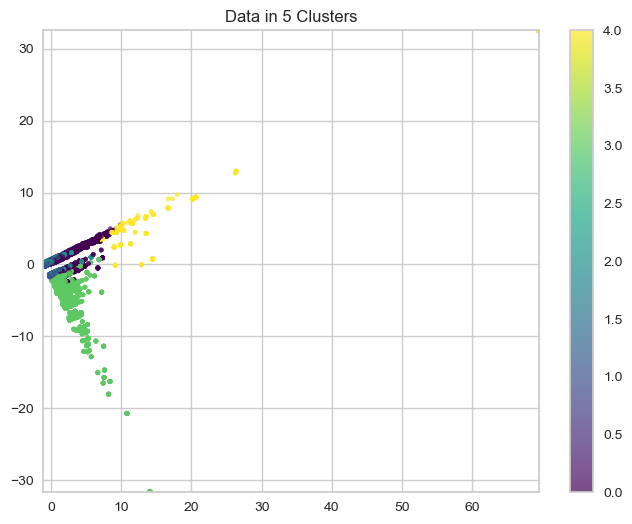

In [215]:
pca_all_2 = PCA(n_components=2, random_state = 42)
df_pca_all_2 = pca_all_2.fit_transform(df_all_2)

df_pca_all_2 = pd.DataFrame(df_pca_all_2, columns=['PCA1', 'PCA2'])
df_pca_all_2['Cluster'] = clusters_optimal_all_2

# Tracer le scatter plot avec ajustement d'échelle et taille des points
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca_all_2['PCA1'], 
                       df_pca_all_2['PCA2'], 
                       c=df_pca_all_2['Cluster'], 
                       cmap='viridis', 
                       alpha=0.7, 
                       s=10)  # Augmenter la taille des points pour les voir

# Ajouter des limites pour éviter un affichage vide
plt.xlim(df_pca_all_2['PCA1'].min() - 0.1, df_pca_all_2['PCA1'].max() + 0.1)
plt.ylim(df_pca_all_2['PCA2'].min() - 0.1, df_pca_all_2['PCA2'].max() + 0.1)

# Ajouter titre et colorbar
plt.colorbar(scatter)
plt.title(f"Data in {len(set(clusters_optimal_all_2))} Clusters")
plt.show()

#### Calcul des moyennes 

In [217]:
# Ajouter les clusters au DataFrame original
df_all_2 = df_all_2.copy()  # Éviter la modification sur une vue
df_all_2.loc[:, 'Cluster'] = clusters_optimal_all_2


# Calcul des moyennes par cluster
cluster_means_scaled_final_2 = df_all_2.groupby('Cluster')[['recency', 
                                                            'frequency', 
                                                            'monetary',
                                                            'avg_review',
                                                            'has_review',
                                                            'diversity_products',
                                                            'avg_payment',
                                                            'avg_installments']].mean().sort_index()


print(cluster_means_scaled_final_2)

          recency  frequency   monetary  avg_review  has_review  \
Cluster                                                           
0        0.134344  -0.117884   0.198676    0.134418    0.989065   
1       -0.027165  -0.153467  -0.118286    0.522509    0.989715   
2        0.035449  -0.141635  -0.039624   -1.606100    1.000000   
3       -0.190332   2.356402   0.156744   -0.110809    0.991751   
4       -0.126569   0.796867  13.488435   -1.112006    0.938953   

         diversity_products  avg_payment  avg_installments  
Cluster                                                     
0                 -0.200481     0.754678          1.851290  
1                 -0.225850    -0.200718         -0.403445  
2                 -0.224079    -0.090841         -0.259859  
3                  3.654226    -0.016029          0.176037  
4                 -0.022491     8.323602          0.519724  


In [218]:
quantitative_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment', 'diversity_products', 'avg_installments']
binary_feature = ['has_review']
target_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment', 'diversity_products', 'avg_installments', 'has_review']

In [219]:
cluster_means_original_final_2 = inverse_transform_mean(
    cluster_means_scaled_final_2,  # DataFrame des moyennes normalisées par cluster
    df_final,              # DataFrame original non transformé
    quantitative_features, # Variables standardisées
    target_features        # Variables à inverser
)

print("Moyennes en échelle d'origine:")
print(cluster_means_original_final_2)


Moyennes en échelle d'origine:
            recency  frequency      monetary  avg_review  avg_payment  \
Cluster                                                                 
0        308.325764   1.042680    715.336418    4.209775   373.282016   
1        283.557819   1.028057    186.259639    4.746662   119.395465   
2        293.159956   1.032920    317.563438    1.801933   148.594252   
3        258.535720   2.059508    645.342691    3.870526   168.474790   
4        268.313953   1.418605  22898.790523    2.485465  2384.643808   

         diversity_products  avg_installments  has_review  
Cluster                                                    
0                  1.007253          8.007141    0.989065  
1                  1.000000          1.837162    0.989715  
2                  1.000506          2.230079    1.000000  
3                  2.109294          3.422890    0.991751  
4                  1.058140          4.363372    0.938953  


- Cluster 0: se différencie par un échelonnage de paiement élevé et une récence un peu plus élevé
- Cluster 1: se différencie par leur grande satisfaction et leurs dépenses faibles
- Cluster 2: se différencie par leur insatisfaction
- Cluster 3: se différencie par leur fréquence d'achat et leur variété de produits achetée
- Cluster 4: se différencie par leurs dépenses élevées et leur manque d'engagement dans leurs avis laissés

#### Interprétation modèle final 2 avec toutes les variables 
**Rappel modèle de base**:

- Silhouette : 0.54
- Calinski-Harabasz : 60721
- Davies-Bouldin Score: 0.61

**Rappel modèle final 2**: 

- k = 5
- Silhouette : 0.33- Calinski-Harabasz Score: 26691- 
Davies-Bouldin Score: 1.1

En retirant top_category, le modèle obtient des scores légèrement meilleurs par rapport au modèle final 1, bien que toujours inférieurs au modèle de base RFM ou aux variantes avec l’ajout de has_review.
Les clusters se distinguent par la nouveauté, les dépenses, la fréquence, la satisfaction et l'échelonnement de paiement, mais la séparation n’est pas aussi nette que dans le modèle de base.

In [222]:
non_significant_tests_9 = []

for feature in ['recency', 
                'frequency', 
                'monetary',
                'avg_review',
                'has_review',
                'diversity_products',
                'avg_payment',
                'avg_installments']:
    
    # Compare les paires de clusters
    
    for i in range(len(cluster_means_scaled_final_2)):  # Clusters de 0 à N-1
        for j in range(i+1, len(cluster_means_scaled_final_2)):  # Comparaison entre i et j, j > i
            
            # Obtenir les données des groupes
            group_1 = df_all_2[df_all_2['Cluster'] == i][feature]
            group_2 = df_all_2[df_all_2['Cluster'] == j][feature]

            # Utiliser les moyennes de moyennes_par_cluster
            mean_1 = cluster_means_scaled_final_2.loc[i, feature]
            mean_2 = cluster_means_scaled_final_2.loc[j, feature]

            # Calculer les écarts-types et tailles des groupes
            std_1 = group_1.std()  # Calcul de l'écart-type du groupe 1
            std_2 = group_2.std()  # Calcul de l'écart-type du groupe 2
            n_1 = len(group_1)     # Taille du groupe 1
            n_2 = len(group_2)     # Taille du groupe 2

            # Effectuer le test t avec les statistiques calculées
            t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1, mean_2, std_2, n_2, equal_var = False)

            # Afficher les résultats du test t
            print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=18.7855, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=9.9828, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=23.4016, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=5.5262, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=-8.6007, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=13.4416, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=2.1270, p-value=0.0341
T-test Recency (Cluster 2 vs Cluster 3): t-stat=17.2371, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 4): t-stat=3.4478, p-value=0.0006
T-test Recency (Cluster 3 vs Cluster 4): t-stat=-1.3288, p-value=0.1847
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=8.5815, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=4.9498, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=-70.0870, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 4): t-stat=-8.4412, p-va

In [223]:
for feature, i, j, p_value in non_significant_tests_9:
    if p_value > 0.05:
        print(f" T-test {feature} (Cluster {i} vs Cluster {j}): p-value={p_value:.4f} (Non significatif)")

In [224]:
non_significant_tests_10 = []

for feature in ['recency', 
                'frequency', 
                'monetary',
                'avg_review',
                'has_review',
                'diversity_products',
                'avg_payment',
                'avg_installments']:
    
    # Compare les paires de clusters
    
    for i in range(len(cluster_means_original_final_2)):  # Clusters de 0 à N-1
        for j in range(i+1, len(cluster_means_original_final_2)):  # Comparaison entre i et j, j > i
            
            # Obtenir les données des groupes
            group_1 = df_all_2[df_all_2['Cluster'] == i][feature]
            group_2 = df_all_2[df_all_2['Cluster'] == j][feature]

            # Utiliser les moyennes de moyennes_par_cluster
            mean_1 = cluster_means_original_final_2.loc[i, feature]
            mean_2 = cluster_means_original_final_2.loc[j, feature]

            # Calculer les écarts-types et tailles des groupes
            std_1 = group_1.std()  # Calcul de l'écart-type du groupe 1
            std_2 = group_2.std()  # Calcul de l'écart-type du groupe 2
            n_1 = len(group_1)     # Taille du groupe 1
            n_2 = len(group_2)     # Taille du groupe 2

            # Effectuer le test t avec les statistiques calculées
            t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1, mean_2, std_2, n_2, equal_var = False)

            # Afficher les résultats du test t
            print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=2880.8009, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=1530.8968, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=3588.6939, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=847.4552, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=-1318.9447, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=2061.3065, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=326.1863, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=2643.3483, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 4): t-stat=528.7280, p-value=0.0000
T-test Recency (Cluster 3 vs Cluster 4): t-stat=-203.7749, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=3.5267, p-value=0.0004
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=2.0341, p-value=0.0419
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=-28.8028, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 4)

In [225]:
for feature, i, j, p_value in non_significant_tests_10:
    if p_value > 0.05:
        print(f" T-test {feature} (Cluster {i} vs Cluster {j}): p-value={p_value:.4f} (Non significatif)")

### 9. Test variante finale

In [227]:
df_final_1 = df_final_encoded[['recency', 
                           'frequency', 
                           'monetary',
                           'avg_review',
                           'diversity_products',
                           'avg_installments']]


#### Choix du nombre de cluster optimal

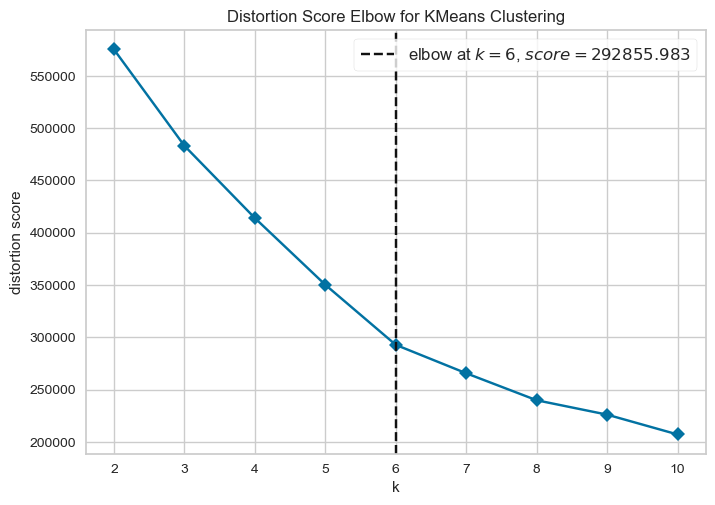

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [229]:
visualizer = KElbowVisualizer(KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42), k=(2,11), metric='distortion', timings=False)
visualizer.fit(df_final_1)
visualizer.show()

In [230]:
for k in [5, 6, 7]:
    labels = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42).fit_predict(df_final_1)
    score = silhouette_score(df_final_1, labels)
    print(f"Silhouette Score for {k} clusters: {score}")

Silhouette Score for 5 clusters: 0.31281669548301855
Silhouette Score for 6 clusters: 0.34372479713869913
Silhouette Score for 7 clusters: 0.34545762749738224


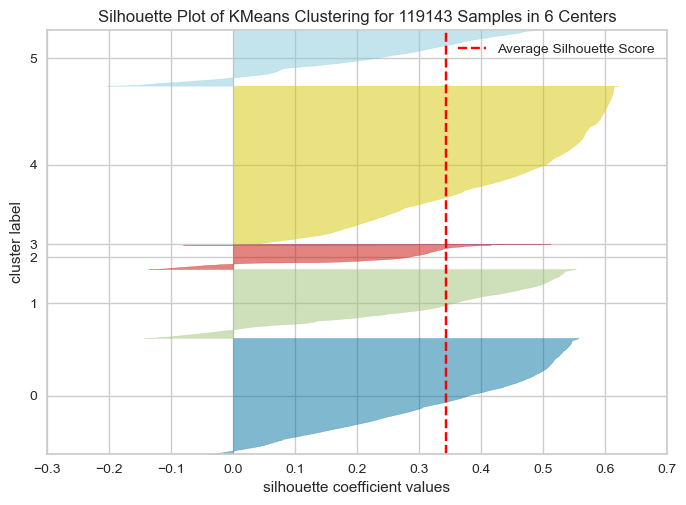

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 119143 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [231]:
N_CLUSTERS = 6
model = KMeans(n_clusters=N_CLUSTERS, init='k-means++', n_init=10, random_state=42)

#Visualisation des silhouettes
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(df_final_1)
visualizer.show()

In [232]:
optimal_k_final_1 = 6
kmeans_optimal = KMeans(n_clusters=optimal_k_final_1, init='k-means++', n_init=10, random_state=42)
clusters_optimal_final_1 = kmeans_optimal.fit_predict(df_final_1)

# Calcul des métriques d'évaluation pour les clusters
calinski_score = calinski_harabasz_score(df_final_1, clusters_optimal_final_1)
db_score = davies_bouldin_score(df_final_1, clusters_optimal_final_1)

print(f'Métriques pour k={optimal_k_final_1}:')
print(f'Calinski-Harabasz Score: {calinski_score}')
print(f'Davies-Bouldin Score: {db_score}')

Métriques pour k=6:
Calinski-Harabasz Score: 34335.002348697766
Davies-Bouldin Score: 0.8943566967128732


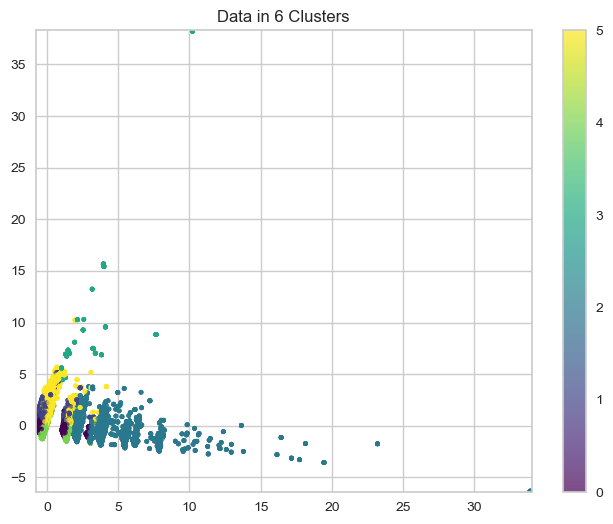

In [233]:
pca_final_1 = PCA(n_components=2, random_state = 42)
df_pca_final_1 = pca_final_1.fit_transform(df_final_1)

df_pca_final_1 = pd.DataFrame(df_pca_final_1, columns=['PCA1', 'PCA2'])
df_pca_final_1['Cluster'] = clusters_optimal_final_1

# Tracer le scatter plot avec ajustement d'échelle et taille des points
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca_final_1['PCA1'], 
                       df_pca_final_1['PCA2'], 
                       c=df_pca_final_1['Cluster'], 
                       cmap='viridis', 
                       alpha=0.7, 
                       s=10)  # Augmenter la taille des points pour les voir

# Ajouter des limites pour éviter un affichage vide
plt.xlim(df_pca_final_1['PCA1'].min() - 0.1, df_pca_final_1['PCA1'].max() + 0.1)
plt.ylim(df_pca_final_1['PCA2'].min() - 0.1, df_pca_final_1['PCA2'].max() + 0.1)

# Ajouter titre et colorbar
plt.colorbar(scatter)
plt.title(f"Data in {len(set(clusters_optimal_final_1))} Clusters")
plt.show()

#### Calcul des moyennes 

In [235]:
# Ajouter les clusters au DataFrame original
df_final_1 = df_final_1.copy()  # Éviter la modification sur une vue
df_final_1.loc[:, 'Cluster'] = clusters_optimal_final_1


# Calcul des moyennes par cluster
cluster_means_scaled_fin_1 = df_final_1.groupby('Cluster')[['recency', 
                                                            'frequency', 
                                                            'monetary',
                                                            'avg_review',
                                                            'diversity_products',
                                                            'avg_installments']].mean().sort_index()


print(cluster_means_scaled_fin_1)

          recency  frequency   monetary  avg_review  diversity_products  \
Cluster                                                                   
0        1.034082  -0.139745  -0.096770    0.433265           -0.225206   
1        0.018523  -0.143257   0.007830   -1.817975           -0.225850   
2       -0.208088   2.311961   0.181778   -0.131169            3.681630   
3       -0.130066   1.023898  16.237085   -1.067078           -0.087049   
4       -0.761556  -0.155724  -0.103457    0.452904           -0.225850   
5        0.083768  -0.111999   0.146135    0.135161           -0.211041   

         avg_installments  
Cluster                    
0               -0.350353  
1               -0.202454  
2                0.200864  
3                0.315877  
4               -0.397773  
5                2.027390  


In [236]:
quantitative_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment', 'diversity_products', 'avg_installments']
target_features = ['recency', 'frequency', 'monetary', 'avg_review', 'diversity_products', 'avg_installments']

In [237]:
cluster_means_original_fin_1 = inverse_transform_mean(
    cluster_means_scaled_fin_1,  # DataFrame des moyennes normalisées par cluster
    df_final,              # DataFrame original non transformé
    quantitative_features, # Variables standardisées
    target_features        # Variables à inverser
)

print("Moyennes en échelle d'origine:")
print(cluster_means_original_fin_1)


Moyennes en échelle d'origine:
            recency  frequency      monetary  avg_review  diversity_products  \
Cluster                                                                        
0        446.303023   1.033696    222.173709    4.623201            1.000184   
1        290.564248   1.032253    396.773399    1.508824            1.000000   
2        255.812858   2.041245    687.130706    3.842360            2.117129   
3        267.777778   1.511905  27486.877460    2.547619            1.039683   
4        170.937027   1.027130    211.012701    4.650369            1.000000   
5        300.569669   1.045099    627.634056    4.210803            1.004234   

         avg_installments  
Cluster                    
0                1.982446  
1                2.387166  
2                3.490826  
3                3.805556  
4                1.852685  
5                8.489030  


- Cluster 0: se différencie par une inactivité mais leur satisfaction
- Cluster 1: se différencie par leur insatisfaction
- Cluster 2: se différencie par leur fréquence d'achat et leur diversité de produits
- Cluster 3: se différencie par leur dépenses élevées 
- Cluster 4: se différencie par leur récence (nouveaux clients) et leur grande satisfaction
- Cluster 5: se différencie par leur faible capacité de paiement (besoin d'échelonner beaucoup leur paiement) mais bonne satisfaction

#### Interprétation modèle final 2 avec toutes les variables 
**Rappel modèle de base**:
- k = 5
- Silhouette : 0.54
- Calinski-Harabasz : 60721
- Davies-Bouldin Score: 0.61

**Rappel modèle final 2**
- k = 6
- Silhouette Score : 0.34
- Calinski-Harabasz : 34335
- Davies-Bouldin Score : 0.89


DB score: Ce score, bien qu’il ne soit pas le plus bas, est acceptable et suggère une séparation des clusters relativement satisfaisante en termes de compacité et de séparation. Silhouette score est modérément faible comparé à celui du modèle de base RFM mais les clusters identifiés sont assez intuitifs apport de dimensions complémentaires pour analyser les profils clients. 

In [240]:
non_significant_tests_11 = []

for feature in ['recency',  
                'frequency', 
                'monetary',
                'avg_review',
                'diversity_products',
                'avg_installments']:
    
    # Compare les paires de clusters
    
    for i in range(len(cluster_means_original_fin_1)):  # Clusters de 0 à N-1
        for j in range(i+1, len(cluster_means_original_fin_1)):  # Comparaison entre i et j, j > i
            
            # Obtenir les données des groupes
            group_1 = df_final_1[df_final_1['Cluster'] == i][feature]
            group_2 = df_final_1[df_final_1['Cluster'] == j][feature]

            # Utiliser les moyennes de moyennes_par_cluster
            mean_1 = cluster_means_original_fin_1.loc[i, feature]
            mean_2 = cluster_means_original_fin_1.loc[j, feature]

            # Calculer les écarts-types et tailles des groupes
            std_1 = group_1.std()  # Calcul de l'écart-type du groupe 1
            std_2 = group_2.std()  # Calcul de l'écart-type du groupe 2
            n_1 = len(group_1)     # Taille du groupe 1
            n_2 = len(group_2)     # Taille du groupe 2

            # Effectuer le test t avec les statistiques calculées
            t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1, mean_2, std_2, n_2, equal_var = False)

            # Afficher les résultats du test t
            print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=21828.3954, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=16046.9238, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=3896.2793, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=66893.9187, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 5): t-stat=17191.1161, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=2680.0879, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=494.1181, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=18001.9351, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 5): t-stat=-1005.1880, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=-254.1334, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 4): t-stat=7327.4571, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 5): t-stat=-3254.8008, p-value=0.0000
T-test Recency (Cluster 3 vs Cluster 4): t-stat=2116.9340, p-value=0.0000
T-test Recency (Cluster 3 vs Clu

In [241]:
for feature, i, j, p_value in non_significant_tests_11:
    if p_value > 0.05:
        print(f" T-test {feature} (Cluster {i} vs Cluster {j}): p-value={p_value:.4f} (Non significatif)")

In [242]:
non_significant_tests_12 = []

for feature in ['recency', 
                'frequency', 
                'monetary',
                'avg_review',
                'diversity_products',
                'avg_installments']:
    
    # Compare les paires de clusters
    
    for i in range(len(cluster_means_scaled_fin_1)):  # Clusters de 0 à N-1
        for j in range(i+1, len(cluster_means_scaled_fin_1)):  # Comparaison entre i et j, j > i
            
            # Obtenir les données des groupes
            group_1 = df_final_1[df_final_1['Cluster'] == i][feature]
            group_2 = df_final_1[df_final_1['Cluster'] == j][feature]

            # Utiliser les moyennes de moyennes_par_cluster
            mean_1 = cluster_means_scaled_fin_1.loc[i, feature]
            mean_2 = cluster_means_scaled_fin_1.loc[j, feature]

            # Calculer les écarts-types et tailles des groupes
            std_1 = group_1.std()  # Calcul de l'écart-type du groupe 1
            std_2 = group_2.std()  # Calcul de l'écart-type du groupe 2
            n_1 = len(group_1)     # Taille du groupe 1
            n_2 = len(group_2)     # Taille du groupe 2

            # Effectuer le test t avec les statistiques calculées
            t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1, mean_2, std_2, n_2, equal_var = False)

            # Afficher les résultats du test t
            print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=142.3411, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=104.6406, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=25.4073, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=436.2096, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 5): t-stat=112.1018, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=17.4766, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=3.2221, p-value=0.0014
T-test Recency (Cluster 1 vs Cluster 4): t-stat=117.3891, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 5): t-stat=-6.5547, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=-1.6572, p-value=0.0986
T-test Recency (Cluster 2 vs Cluster 4): t-stat=47.7817, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 5): t-stat=-21.2243, p-value=0.0000
T-test Recency (Cluster 3 vs Cluster 4): t-stat=13.8043, p-value=0.0000
T-test Recency (Cluster 3 vs Cluster 5): t-stat=-4.6142, p-

In [243]:
for feature, i, j, p_value in non_significant_tests_12:
    if p_value > 0.05:
        print(f" T-test {feature} (Cluster {i} vs Cluster {j}): p-value={p_value:.4f} (Non significatif)")

### 10. Test variante finale avec has_review

In [245]:
df_final_2 = df_final_encoded[['recency', 
                           'frequency', 
                           'monetary',
                           'avg_review',
                            'has_review',
                           'diversity_products',
                           'avg_installments']]


#### Choix du nombre de cluster optimal

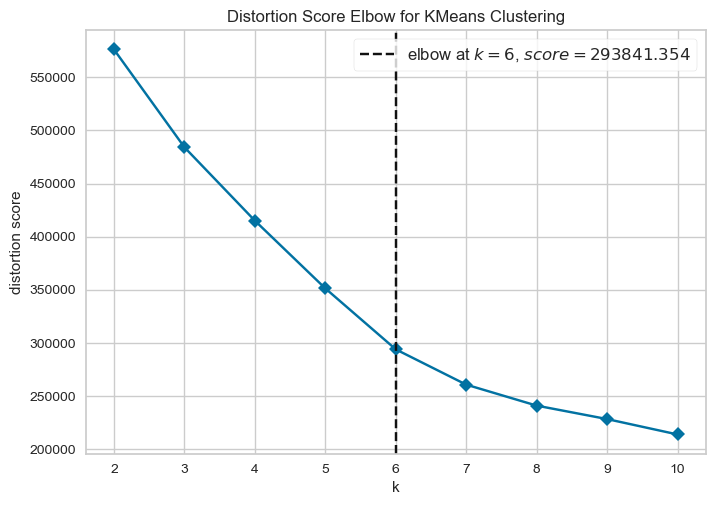

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [247]:
visualizer = KElbowVisualizer(KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42), k=(2,11), metric='distortion', timings=False)
visualizer.fit(df_final_2)
visualizer.show()

In [248]:
for k in [5, 6]:
    labels = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42).fit_predict(df_final_2)
    score = silhouette_score(df_final_2, labels)
    print(f"Silhouette Score for {k} clusters: {score}")

Silhouette Score for 5 clusters: 0.31180946118027464
Silhouette Score for 6 clusters: 0.3422275947643359


Ici k=5 est choisi car après une tentative avec k =6 j'ai observé une mauvaise interprétation métier des clusters pour lrs des séparations de périodes pour le contrat de maintenance. 

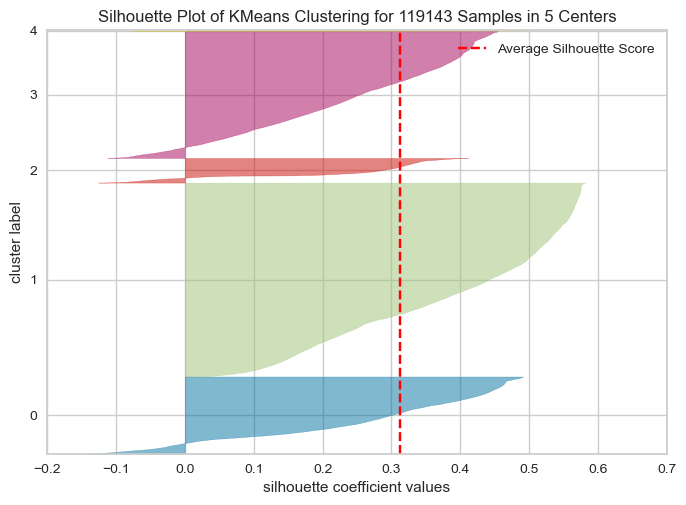

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 119143 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [250]:
N_CLUSTERS = 5
model = KMeans(n_clusters=N_CLUSTERS, init='k-means++', n_init=10, random_state=42)

#Visualisation des silhouettes
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(df_final_2)
visualizer.show()

In [251]:
optimal_k_final_2 = 5
kmeans_optimal = KMeans(n_clusters=optimal_k_final_2, init='k-means++', n_init=10, random_state=42)
clusters_optimal_final_2 = kmeans_optimal.fit_predict(df_final_2)

# Calcul des métriques d'évaluation pour les clusters
calinski_score = calinski_harabasz_score(df_final_2, clusters_optimal_final_2)
db_score = davies_bouldin_score(df_final_2, clusters_optimal_final_2)

print(f'Métriques pour k={optimal_k_final_2}:')
print(f'Calinski-Harabasz Score: {calinski_score}')
print(f'Davies-Bouldin Score: {db_score}')

Métriques pour k=5:
Calinski-Harabasz Score: 30915.0235568216
Davies-Bouldin Score: 1.0479864336688895


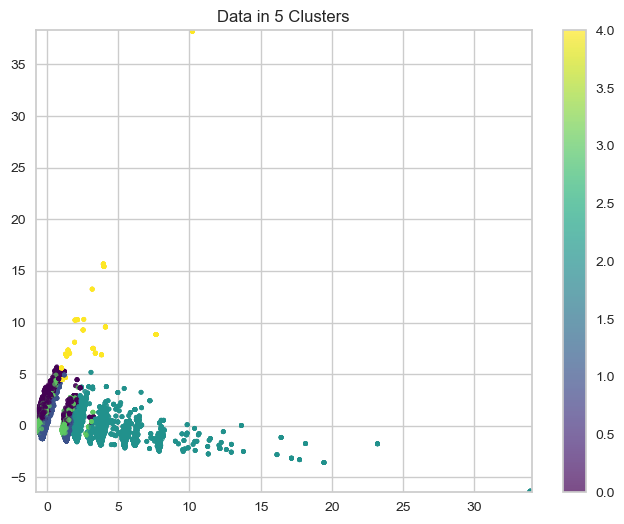

In [252]:
pca_final_2 = PCA(n_components=2, random_state = 42)
df_pca_final_2 = pca_final_2.fit_transform(df_final_2)

df_pca_final_2 = pd.DataFrame(df_pca_final_2, columns=['PCA1', 'PCA2'])
df_pca_final_2['Cluster'] = clusters_optimal_final_2

# Tracer le scatter plot avec ajustement d'échelle et taille des points
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca_final_2['PCA1'], 
                       df_pca_final_2['PCA2'], 
                       c=df_pca_final_2['Cluster'], 
                       cmap='viridis', 
                       alpha=0.7, 
                       s=10)  # Augmenter la taille des points pour les voir

# Ajouter des limites pour éviter un affichage vide
plt.xlim(df_pca_final_2['PCA1'].min() - 0.1, df_pca_final_2['PCA1'].max() + 0.1)
plt.ylim(df_pca_final_2['PCA2'].min() - 0.1, df_pca_final_2['PCA2'].max() + 0.1)

# Ajouter titre et colorbar
plt.colorbar(scatter)
plt.title(f"Data in {len(set(clusters_optimal_final_2))} Clusters")
plt.show()

#### Calcul des moyennes 

In [254]:
# Ajouter les clusters au DataFrame original
df_final_2 = df_final_2.copy()  # Éviter la modification sur une vue
df_final_2.loc[:, 'Cluster'] = clusters_optimal_final_2


# Calcul des moyennes par cluster
cluster_means_scaled_fin_2 = df_final_2.groupby('Cluster')[['recency', 
                                                            'frequency', 
                                                            'monetary',
                                                            'avg_review',
                                                            'has_review',
                                                            'diversity_products',
                                                            'avg_installments']].mean().sort_index()


print(cluster_means_scaled_fin_2)

          recency  frequency   monetary  avg_review  has_review  \
Cluster                                                           
0        0.024010  -0.134487   0.047685   -1.793094    1.000000   
1       -0.689488  -0.155784  -0.082039    0.454250    0.989939   
2       -0.197527   2.304662   0.195211   -0.127592    0.991918   
3        1.079566  -0.134674  -0.058546    0.430253    0.989569   
4       -0.116570   0.976354  15.937866   -1.109777    0.923664   

         diversity_products  avg_installments  
Cluster                                        
0                 -0.225850          0.101272  
1                 -0.225850         -0.191880  
2                  3.649531          0.236625  
3                 -0.225262          0.181529  
4                 -0.092347          0.597549  


In [255]:
display(df_final_2['Cluster'].value_counts().sort_index())

Cluster
0    21725
1    54565
2     6929
3    35662
4      262
Name: count, dtype: int64

In [256]:
quantitative_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment', 'diversity_products', 'avg_installments']
binary_feature = ['has_review']
target_features = ['recency', 'frequency', 'monetary', 'avg_review', 'diversity_products', 'avg_installments', 'has_review']

In [257]:
cluster_means_original_fin_2 = inverse_transform_mean(
    cluster_means_scaled_fin_2,  # DataFrame des moyennes normalisées par cluster
    df_final,              # DataFrame original non transformé
    quantitative_features, # Variables standardisées
    target_features        # Variables à inverser
)

print("Moyennes en échelle d'origine:")
print(cluster_means_original_fin_2)


Moyennes en échelle d'origine:
            recency  frequency      monetary  avg_review  diversity_products  \
Cluster                                                                        
0        291.405708   1.035857    463.301200    1.543245            1.000000   
1        181.988894   1.027105    246.763789    4.652231            1.000000   
2        257.432386   2.038245    709.553601    3.847308            2.107952   
3        453.278055   1.035780    285.978277    4.619034            1.000168   
4        269.847328   1.492366  26987.416489    2.488550            1.038168   

         avg_installments  has_review  
Cluster                                
0                3.218297    1.000000  
1                2.416100    0.989939  
2                3.588685    0.991918  
3                3.437917    0.989569  
4                4.576336    0.923664  


- Cluster 0: se différencie par leur insatisfaction et le fait de laisser toujours un avis
- Cluster 1: se différencie par leur récence, et leur grande satisfaction
- Cluster 2: se différencie par leur fréquence d'achat élevée et l'achat de produits différents
- Cluster 3: se différencie par leur inactivité 
- Cluster 4: se différencie par leur dépenses très élevées peu satisfaits mais ne laissent pas beaucoup d'avis

#### Interprétation modèle final 2 avec toutes les variables 
**Rappel modèle de base**:
- k = 5
- Silhouette : 0.54
- Calinski-Harabasz : 60721
- Davies-Bouldin Score: 0.61

**Rappel modèle final 2**
- k = 5
- Silhouette : 0.31
- Calinski-Harabasz : 30915
- Davies-Bouldin : 1.04

Silhouette Score = 0.31 : modéré indique une séparation des clusters acceptable, mais moins nette qu’avec le modèle de base RFM. L’ajout de nouvelles dimensions complexifie la segmentation, ce qui peut introduire un certain recouvrement entre les clusters mais qui nous donne davantage d'informations sur les profils clients. 

Calinski-Harabasz Score = 30915. Un score élevé indique une bonne dispersion inter-clusters par rapport à la dispersion intra-cluster. Ici, malgré un Silhouette Score modéré, ce score suggère que les clusters sont assez bien distincts sur le plan global mais moins distincts qu'avec le modèle de base RFM.

Davies-Bouldin Score = 1.04
Un DB score proche 1 est acceptable. Plus il est bas, mieux c’est. Ici, il est supérieur à celui obtenu dans certains modèles RFM de base, mais reste acceptable. Comme pour le modèle du point 9, suggère une séparation des clusters relativement satisfaisante en termes de compacité et de séparation. Les clusters identifiés se différencient intuitivement + apport de dimensions complémentaires pour analyser les profils clients. 

L’ajout de avg_review, has_review, diversity_products et avg_installments apporte des nuances qualitatives et comportementales qui enrichissent la segmentation, même si le Silhouette Score diminue légèrement. Les profils obtenus sont plus actionnables

In [260]:
non_significant_tests_13 = []

for feature in ['recency', 
                'frequency', 
                'monetary',
                'avg_review',
                'has_review',
                'diversity_products',
                'avg_installments']:
    
    # Compare les paires de clusters
    
    for i in range(len(cluster_means_original_fin_2)):  # Clusters de 0 à N-1
        for j in range(i+1, len(cluster_means_original_fin_2)):  # Comparaison entre i et j, j > i
            
            # Obtenir les données des groupes
            group_1 = df_final_2[df_final_2['Cluster'] == i][feature]
            group_2 = df_final_2[df_final_2['Cluster'] == j][feature]

            # Utiliser les moyennes de moyennes_par_cluster
            mean_1 = cluster_means_original_fin_2.loc[i, feature]
            mean_2 = cluster_means_original_fin_2.loc[j, feature]

            # Calculer les écarts-types et tailles des groupes
            std_1 = group_1.std()  # Calcul de l'écart-type du groupe 1
            std_2 = group_2.std()  # Calcul de l'écart-type du groupe 2
            n_1 = len(group_1)     # Taille du groupe 1
            n_2 = len(group_2)     # Taille du groupe 2

            # Effectuer le test t avec les statistiques calculées
            t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1, mean_2, std_2, n_2, equal_var = False)

            # Afficher les résultats du test t
            print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=17246.3156, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=2660.6675, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=-23902.5862, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=484.0265, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=-6546.0881, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=-68583.0013, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=-1987.7845, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=-16645.1929, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 4): t-stat=-272.4544, p-value=0.0000
T-test Recency (Cluster 3 vs Cluster 4): t-stat=4144.1464, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=2.4670, p-value=0.0136
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=-28.8167, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=0.0193, p-value=0.9846
T-test Frequency (Cluster 0 vs 

In [261]:
for feature, i, j, p_value in non_significant_tests_13:
    if p_value > 0.05:
        print(f" T-test {feature} (Cluster {i} vs Cluster {j}): p-value={p_value:.4f} (Non significatif)")

In [262]:
non_significant_tests_14 = []

for feature in ['recency', 
                'frequency', 
                'monetary',
                'avg_review',
                'has_review',
                'diversity_products',
                'avg_installments']:
    
    # Compare les paires de clusters
    
    for i in range(len(cluster_means_scaled_fin_2)):  # Clusters de 0 à N-1
        for j in range(i+1, len(cluster_means_scaled_fin_2)):  # Comparaison entre i et j, j > i
            
            # Obtenir les données des groupes
            group_1 = df_final_2[df_final_2['Cluster'] == i][feature]
            group_2 = df_final_2[df_final_2['Cluster'] == j][feature]

            # Utiliser les moyennes de moyennes_par_cluster
            mean_1 = cluster_means_scaled_fin_2.loc[i, feature]
            mean_2 = cluster_means_scaled_fin_2.loc[j, feature]

            # Calculer les écarts-types et tailles des groupes
            std_1 = group_1.std()  # Calcul de l'écart-type du groupe 1
            std_2 = group_2.std()  # Calcul de l'écart-type du groupe 2
            n_1 = len(group_1)     # Taille du groupe 1
            n_2 = len(group_2)     # Taille du groupe 2

            # Effectuer le test t avec les statistiques calculées
            t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1, mean_2, std_2, n_2, equal_var = False)

            # Afficher les résultats du test t
            print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=112.4618, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=17.3500, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=-155.8667, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=3.1563, p-value=0.0018
T-test Recency (Cluster 1 vs Cluster 2): t-stat=-42.6865, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=-447.2239, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=-12.9622, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=-108.5419, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 4): t-stat=-1.7767, p-value=0.0767
T-test Recency (Cluster 3 vs Cluster 4): t-stat=27.0236, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=6.0031, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=-70.1208, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=0.0471, p-value=0.9625
T-test Frequency (Cluster 0 vs Cluster 4): t-stat=-

In [263]:
for feature, i, j, p_value in non_significant_tests_14:
    if p_value > 0.05:
        print(f" T-test {feature} (Cluster {i} vs Cluster {j}): p-value={p_value:.4f} (Non significatif)")

Clusters bien spérés puisque toutes les moyennes sont significativement différentes

## Clustering DBSCAN

### 1. Test du modèle de base avec RFM

- **eps (epsilon)** est un seuil de distance qui influence la séparation des clusters :
- Deux points sont considérés comme voisins si leur distance est inférieure à eps.
- Un cluster est formé quand il y a au moins min_samples points proches (dans un rayon eps).
- Si eps est trop petit, on obtient trop de petits clusters (ou aucun).
- Si eps est trop grand, on risque d’avoir un seul cluster géant.

- **Méthode pour trouver le bon paramètre eps**:
DBSCAN est basé sur la distance entre les points. Une bonne valeur de eps peut être déterminée grâce à la courbe des k-plus proches voisins (KNN).
=> Utilisation des k-plus proches voisins en testant plusieurs k pour identifier le seuil où la distance augmente fortement.
=> Le "coude" de la courbe correspond au bon eps.
=> Utilisation de KneeLocator qui va permettre d'identifier la valeur eps optimale

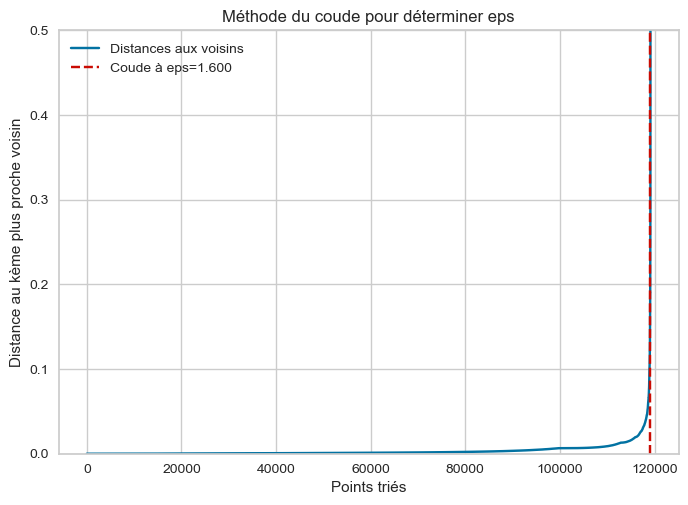

Pour k=4, eps recommandé = 1.600


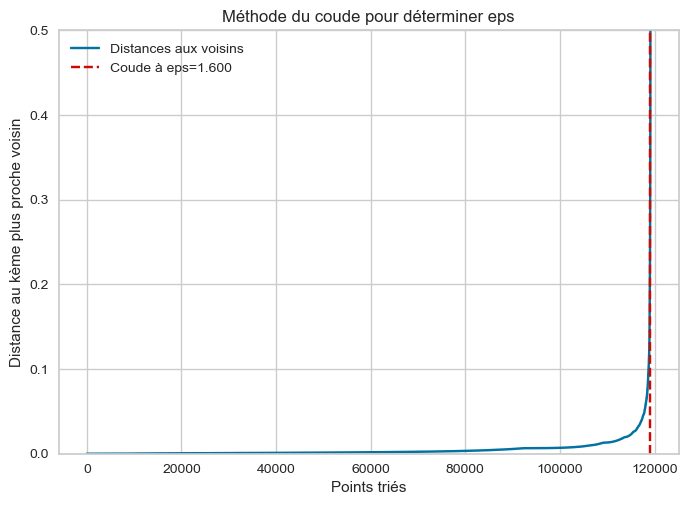

Pour k=5, eps recommandé = 1.600


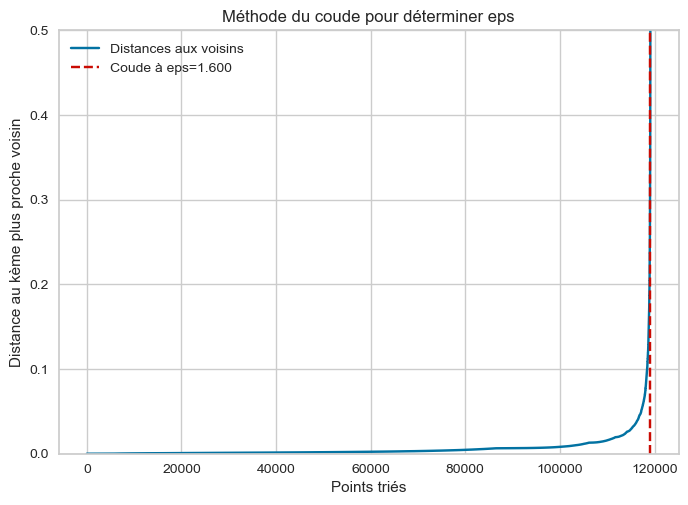

Pour k=6, eps recommandé = 1.600


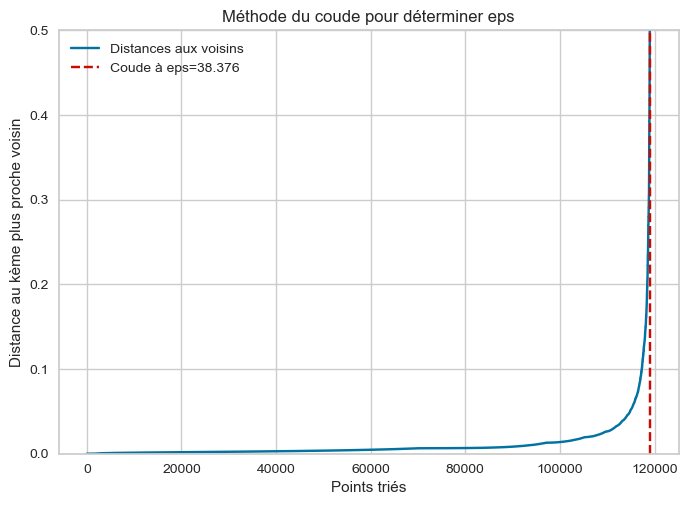

Pour k=10, eps recommandé = 38.376


In [268]:
#  Calcul des distances des k-plus proches voisins
for k in [4, 5, 6, 10]:
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(df_rfm_encoded)
    distances, indices = neigh.kneighbors(df_rfm_encoded)
    sorted_distances = np.sort(distances[:, -1])  # On prend la plus grande distance de chaque point: dernière colonne = distance au k-ième voisin
    
    kneedle = KneeLocator(range(len(sorted_distances)), sorted_distances, curve="convex", direction="increasing")
    eps_value = sorted_distances[kneedle.knee]  # Valeur optimale de eps
    
    plt.plot(sorted_distances, label="Distances aux voisins")
    plt.axvline(x=kneedle.knee, color='r', linestyle='--', label=f"Coude à eps={eps_value:.3f}")
    plt.xlabel("Points triés")
    plt.ylabel("Distance au kème plus proche voisin")
    plt.title("Méthode du coude pour déterminer eps")
    plt.legend()
    plt.ylim(0, 0.5)  
    plt.show()
    print(f"Pour k={k}, eps recommandé = {eps_value:.3f}")

On remarque la stabilité d'eps (1.6) pour k = 4, 5 et 6. Lorsque k = 10, eps explose ce qui veut dire que lorsque l’on regarde les 10 plus proches voisins, les distances explosent à cause des outliers ou de la densité variable des clusters.
**EPS = 1.6**

- Maintenant nous allons procéder au choix de min_samples en partant de la règle générale suivante: 

- Quand la base est petite: min_samples = 2 * n_features
- Quand la base est grande (comme ici) : min_samples ≈ log(n_samples)
- Cela nous donnera une base et nous testerons des valeurs autours.
- Ici n_samples = 119143, donc ln(119143) = 11.67 donc nous testerons min_samples = 11

- Dans DBSCAN, les points considérés comme outliers (points isolés qui ne font partie d’aucun cluster) sont marqués avec le label -1

In [270]:
display(df_rfm_encoded.head())

recency  frequency  monetary  Cluster
0  1.501612   -0.22174 -0.141884        2
1 -0.069928   -0.22174 -0.028890        0
2 -0.898085   -0.22174 -0.135377        0
3 -0.461183   -0.22174 -0.126050        0
4 -1.361070   -0.22174 -0.078752        0

- L'entrainement du modèle DBSCAN demande beaucoup de mémoire RAM (à chaque lancement = MemoryError) et ne peux pas aboutir en testant plusieurs min_samples en même temps. Plusieurs solutions : travailler sur un sous-échantillon de la df, ou bien tester HDBSCAN.

### **Sous-échantillon**:
Je crée un sous échantillon ( par exemple 20% de la df) et regarde si les statistiques descriptives sont proches afin que la df_sampled soit bien représentative de ma df initiale. 

In [273]:
df_sampled = df_rfm_encoded.sample(frac=0.2, random_state=42)  # 20% des données

print("Avant échantillonnage :")
print(df_rfm_encoded.describe())

print("\nAprès échantillonnage :")
print(df_sampled.describe())

Avant échantillonnage :
            recency     frequency      monetary        Cluster
count  1.191430e+05  1.191430e+05  1.191430e+05  119143.000000
mean   1.252990e-16  5.325656e-17  4.508618e-17       1.080617
std    1.000004e+00  1.000004e+00  1.000004e+00       1.252386
min   -1.876222e+00 -2.217399e-01 -2.298710e-01       0.000000
25%   -8.133127e-01 -2.217399e-01 -1.875038e-01       0.000000
50%   -1.286165e-01 -2.217399e-01 -1.488928e-01       0.000000
75%    7.125815e-01 -2.217399e-01 -6.021035e-02       2.000000
max    3.157925e+00  3.871167e+01  6.525761e+01       4.000000

Après échantillonnage :
            recency     frequency      monetary       Cluster
count  23829.000000  23829.000000  23829.000000  23829.000000
mean       0.007873      0.000262     -0.003812      1.077804
std        1.000181      1.001171      0.937646      1.250646
min       -1.876222     -0.221740     -0.229871      0.000000
25%       -0.800271     -0.221740     -0.187492      0.000000
50%       -0

Les moyennes et écarts-types sont quasiment identiques → L’échantillon est bien représentatif.
Légère baisse de l’écart-type sur monetary mais cohérence avec les min et max

In [275]:
for min_samples in [8, 11, 15, 20]:
    dbscan = DBSCAN(eps= 1.6, min_samples=min_samples)
    labels = dbscan.fit_predict(df_sampled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Ne pas compter les outliers -1 car on souhaite garder seulement les Clusters 
    print(f"min_samples = {min_samples} => {n_clusters} clusters détectés")

min_samples = 8 => 10 clusters détectés
min_samples = 11 => 7 clusters détectés
min_samples = 15 => 6 clusters détectés
min_samples = 20 => 5 clusters détectés


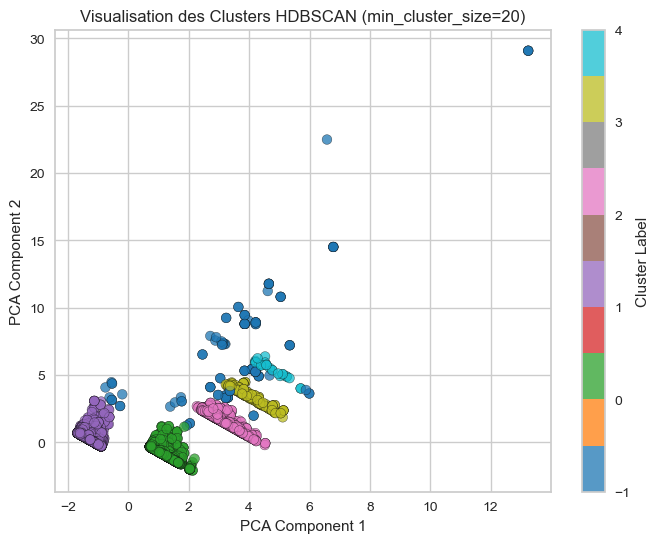

In [276]:
# Sélection de min_samples  = 20
min_samples_optimal  = 20

dbscan_cluster = DBSCAN(eps= 1.6, min_samples=min_samples_optimal)

labels_db= dbscan_cluster.fit_predict(df_sampled)

# Réduction de dimension avec PCA
pca_db = PCA(n_components=2)
df_pca_db = pca_db.fit_transform(df_sampled)

# Visualisation des clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca_db[:, 0], df_pca_db[:, 1], c=labels_db, cmap='tab10', alpha=0.75, edgecolors='k')

# Ajouter une barre de couleur
plt.colorbar(scatter, label="Cluster Label")

# Labels et titre
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"Visualisation des Clusters HDBSCAN (min_cluster_size={min_samples_optimal})")

# Affichage
plt.show()

#### **Métriques**

In [278]:
# Filtre pour retirer les outliers 
mask = labels_db != -1
X_no_noise = df_sampled[mask]
labels_no_noise = labels_db[mask]

if len(set(labels_no_noise)) > 1:
    silhouette = silhouette_score(X_no_noise, labels_no_noise)
    db_index = davies_bouldin_score(X_no_noise, labels_no_noise)
    ch_index = calinski_harabasz_score(X_no_noise, labels_no_noise)
    
    print(f"Silhouette Score (sans outliers): {silhouette:.4f}")
    print(f"Davies-Bouldin Index (sans outliers): {db_index:.4f}")
    print(f"Calinski-Harabasz Index (sans outliers): {ch_index:.4f}")
else:
    print("Nombre de clusters (sans outliers) insuffisant pour calculer les métriques.")

Silhouette Score (sans outliers): 0.7204
Davies-Bouldin Index (sans outliers): 0.6446
Calinski-Harabasz Index (sans outliers): 32372.4705


#### **Vérification outliers**

In [280]:
# Nombre total de points
total_points_db = len(labels_db)

# Nombre de points classés comme outliers (-1)
outliers_count_db = np.sum(labels_db == -1)

# Pourcentage d'outliers
outliers_percentage_db = (outliers_count_db / total_points_db) * 100

print(f"Nombre total de points : {total_points_db}")
print(f"Nombre d'outliers : {outliers_count_db}")
print(f"Pourcentage d'outliers : {outliers_percentage_db:.2f}%")

Nombre total de points : 23829
Nombre d'outliers : 113
Pourcentage d'outliers : 0.47%


#### **Moyenne**

In [282]:
df_clusters_db = df_sampled.copy()
df_clusters_db["Cluster"] = labels_db

# Supprimer les outliers (-1) avant de calculer la moyenne
df_clusters_db = df_clusters_db[df_clusters_db["Cluster"] != -1]

# Moyennes par cluster
cluster_means_db = df_clusters_db.groupby("Cluster").mean()

print(" Moyennes des features par cluster avec DBSCAN:")
print(cluster_means_db)

 Moyennes des features par cluster avec DBSCAN:
          recency  frequency  monetary
Cluster                               
0        0.987741  -0.221740 -0.057899
1       -0.710730  -0.221740 -0.049167
2       -0.042787   2.211598  0.088054
3       -0.043566   4.644937  0.238381
4       -0.412778   7.078275  0.328891


In [283]:
quantitative_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment', 'diversity_products', 'avg_installments']
target_features = ['recency', 'frequency', 'monetary'] 

In [284]:
cluster_means_original_db = inverse_transform_mean(
    cluster_means_db,      # DataFrame des moyennes normalisées par cluster
    df_final,              # DataFrame original non transformé
    quantitative_features, # Variables standardisées
    target_features        # Variables à inverser
)

print("Moyennes en échelle d'origine:")
print(cluster_means_original_db)

Moyennes en échelle d'origine:
            recency  frequency    monetary
Cluster                                   
0        439.196467        1.0  287.058877
1        178.731286        1.0  301.633844
2        281.162162        2.0  530.684969
3        281.042781        3.0  781.612834
4        224.423077        4.0  932.693077


- Cluster 0: clients inactifs
- Cluster 1: nouveaux clients
- Cluster 2: difficile à différencier
- Cluster 3: difficile à différencier
- Cluster 4: Clients achetant fréquemment et avec beaucoup de dépenses

In [286]:
display(df_clusters_db['Cluster'].value_counts().sort_index())

Cluster
0     9396
1    12664
2     1443
3      187
4       26
Name: count, dtype: int64

#### **Test moyenne**

In [288]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_original_db.index:
        for j in cluster_means_original_db.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_db[df_clusters_db['Cluster'] == i][feature]
                group_2 = df_clusters_db[df_clusters_db['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_original_db.loc[i, feature]
                mean_2 = cluster_means_original_db.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=33651.9779, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=5971.4158, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=2050.1180, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=1117.2484, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=-3940.0888, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=-1328.9901, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=-237.7671, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=1.4732, p-value=0.1421
T-test Recency (Cluster 2 vs Cluster 4): t-stat=292.7265, p-value=0.0000
T-test Recency (Cluster 3 vs Cluster 4): t-stat=273.6156, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=0.0000, p-value=1.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=-2497305387507915.0000, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=-3760592396472985.0000, p-value=0.0000
T-test Freq

- T-test Recency (Cluster 2 vs Cluster 3): t-stat=1.4732, p-value=0.1421
- T-test Frequency (Cluster 0 vs Cluster 1): t-stat=0.0000, p-value=1.0000

In [290]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_db.index:
        for j in cluster_means_db.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_db[df_clusters_db['Cluster'] == i][feature]
                group_2 = df_clusters_db[df_clusters_db['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_db.loc[i, feature]
                mean_2 = cluster_means_db.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")



T-test Recency (Cluster 0 vs Cluster 1): t-stat=219.4417, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=38.9391, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=13.3686, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=7.2855, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=-25.6930, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=-8.6662, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=-1.5505, p-value=0.1336
T-test Recency (Cluster 2 vs Cluster 3): t-stat=0.0096, p-value=0.9923
T-test Recency (Cluster 2 vs Cluster 4): t-stat=1.9088, p-value=0.0674
T-test Recency (Cluster 3 vs Cluster 4): t-stat=1.7842, p-value=0.0834
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=-0.1951, p-value=0.8453
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=-6076788954556207.0000, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=-9150793672166642.0000, p-value=0.0000
T-test Frequency (Cluster 0 vs

- T-test Recency (Cluster 1 vs Cluster 4): t-stat=-1.5505, p-value=0.1336- T-test Recency (Cluster 2 vs Cluster 3): t-stat=0.0096, p-value=0.9923
- T-test Recency (Cluster 2 vs Cluster 4): t-stat=1.9088, p-value=0.0674- 
T-test Recency (Cluster 3 vs Cluster 4): t-stat=1.7842, p-value=0.0834
- T-test Frequency (Cluster 0 vs Cluster 1): t-stat=-0.1951, p-value=0.8453
- T-test Monetary (Cluster 0 vs Cluster 1): t-stat=-1.6182, p-value=0.1056
- T-test Monetary (Cluster 3 vs Cluster 4): t-stat=-1.0073, p-value=0.3208

=> On voit déjà qu'il y a plus de Cluster qui ont des moyennes statistiquement égales qu'avec le modèle Kmeans. C'est pourquoi on a plus de difficultés à différencier certains clusters avec DBSCAN.

### **HDBSCAN :**
- cluster_selection_epsilon joue un rôle similaire à epsilon :
Il définit un seuil de distance au-delà duquel deux clusters ne fusionneront pas. Mais contrairement à DBSCAN, HDBSCAN peut avoir un eps adaptatif qui évolue selon la densité locale.

- Sans cluster_selection_epsilon :
HDBSCAN détecte des clusters de tailles très variées.
Certains petits clusters peuvent apparaître si les points sont densément connectés.
- Avec cluster_selection_epsilon :
forces une séparation des clusters qui dépasse une certaine distance.
Cela évite d'avoir trop de petits clusters et stabilise leur nombre.


Ici les paramètres à ajuster:
- min_cluster_size = Plus il est grand, plus les petits clusters sont ignorés. Essaye 5, 10, 20, 50.
- min_samples = Définit la sensibilité aux outliers (en général, même valeur que min_cluster_size).
- cluster_selection_method = 'eom' (par défaut) détecte les clusters de manière optimale, 'leaf' garde plus de petits clusters.
- cluster_selection_epsilon

In [293]:
# Initialisation du modèle HDBSCAN avec les mêmes paramètres que DBSCAN
hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=11, min_samples=11, cluster_selection_epsilon=1.6)

# Application du clustering sur les données
labels = hdbscan_cluster.fit_predict(df_rfm_encoded)

# Calcul du nombre de clusters détectés (hors outliers -1)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  

# Affichage du résultat
print(f"min_samples = {11} => {n_clusters} clusters détectés")

min_samples = 11 => 18 clusters détectés


In [294]:
#Test de plusieurs min_cluster_size

for min_cluster_size in [20, 30, 40, 50]:
    hdbscan_cluster = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size, 
        min_samples=min_cluster_size,  # Garde la cohérence
        cluster_selection_method='eom', 
        metric='euclidean'
    )
    
    labels = hdbscan_cluster.fit_predict(df_rfm_encoded)
    
    # Compter les clusters détectés (on exclut les outliers -1)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"min_cluster_size = {min_cluster_size} => {n_clusters} clusters détectés")

min_cluster_size = 20 => 889 clusters détectés
min_cluster_size = 30 => 186 clusters détectés
min_cluster_size = 40 => 36 clusters détectés
min_cluster_size = 50 => 14 clusters détectés


In [295]:
#Ajout du paramètres cluster_selection_epsilon: 

for min_cluster_size in [20, 30, 40, 50, 60]:
    hdbscan_cluster = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size, 
        min_samples=min_cluster_size,  # Garde la cohérence
        cluster_selection_epsilon = 1.6,
        metric='euclidean'
    )
    
    labels = hdbscan_cluster.fit_predict(df_rfm_encoded)
    
    # Compter les clusters détectés (on exclut les outliers -1)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"min_cluster_size = {min_cluster_size} => {n_clusters} clusters détectés")

min_cluster_size = 20 => 13 clusters détectés
min_cluster_size = 30 => 10 clusters détectés
min_cluster_size = 40 => 8 clusters détectés
min_cluster_size = 50 => 6 clusters détectés
min_cluster_size = 60 => 6 clusters détectés


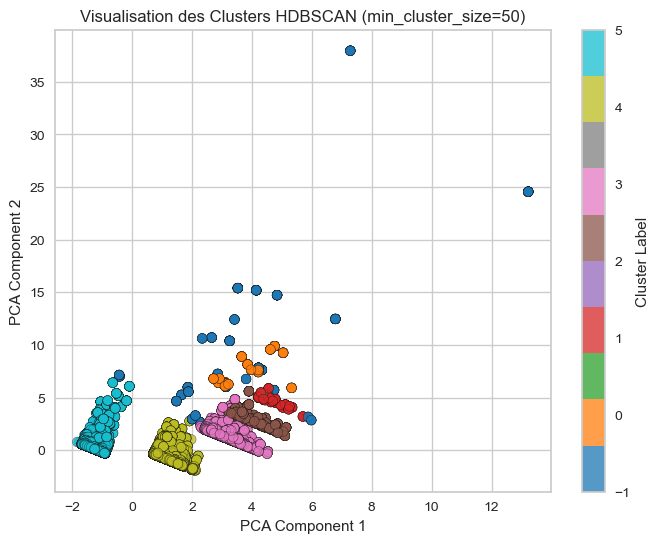

In [296]:
# Sélection de min_cluster_size = 50
min_cluster_size_selected = 50

# Exécution de HDBSCAN avec min_cluster_size = 50
hdbscan_cluster = hdbscan.HDBSCAN(
    min_cluster_size=min_cluster_size_selected, 
    min_samples=min_cluster_size_selected,  
    cluster_selection_epsilon=1.6,
    metric='euclidean'
)

labels_hd = hdbscan_cluster.fit_predict(df_rfm_encoded)

# Réduction de dimension avec PCA
pca_hd = PCA(n_components=2)
df_pca_hd = pca_hd.fit_transform(df_rfm_encoded)

# Visualisation des clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca_hd[:, 0], df_pca_hd[:, 1], c=labels_hd, cmap='tab10', alpha=0.75, edgecolors='k')

# Ajouter une barre de couleur
plt.colorbar(scatter, label="Cluster Label")

# Labels et titre
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"Visualisation des Clusters HDBSCAN (min_cluster_size={min_cluster_size_selected})")

# Affichage
plt.show()

#### **Métriques**

In [298]:
# Filtre pour retirer les outliers 
mask = labels_hd != -1
X_no_noise1 = df_rfm_encoded[mask]
labels_no_noise1 = labels_hd[mask]

if len(set(labels_no_noise1)) > 1:
    silhouette = silhouette_score(X_no_noise1, labels_no_noise1)
    db_index = davies_bouldin_score(X_no_noise1, labels_no_noise1)
    ch_index = calinski_harabasz_score(X_no_noise1, labels_no_noise1)
    
    print(f"Silhouette Score (sans outliers): {silhouette:.4f}")
    print(f"Davies-Bouldin Index (sans outliers): {db_index:.4f}")
    print(f"Calinski-Harabasz Index (sans outliers): {ch_index:.4f}")
else:
    print("Nombre de clusters (sans outliers) insuffisant pour calculer les métriques.")

Silhouette Score (sans outliers): 0.7184
Davies-Bouldin Index (sans outliers): 0.6224
Calinski-Harabasz Index (sans outliers): 125438.7255


#### **Outliers**

In [300]:
# Nombre total de points
total_points = len(labels_hd)

# Nombre de points classés comme outliers (-1)
outliers_count = np.sum(labels_hd == -1)

# Pourcentage d'outliers
outliers_percentage = (outliers_count / total_points) * 100

print(f"Nombre total de points : {total_points}")
print(f"Nombre d'outliers : {outliers_count}")
print(f"Pourcentage d'outliers : {outliers_percentage:.2f}%")

Nombre total de points : 119143
Nombre d'outliers : 296
Pourcentage d'outliers : 0.25%


#### **Moyenne**

In [302]:
df_clusters_hd = df_rfm_encoded.copy()
df_clusters_hd["Cluster"] = labels_hd

# Supprimer les outliers (-1) avant de calculer la moyenne
df_clusters_hd = df_clusters_hd[df_clusters_hd["Cluster"] != -1]

# Moyennes par cluster
cluster_means_hd = df_clusters_hd.groupby("Cluster").mean()

print(" Moyennes des features par cluster avec HDBSCAN:")
print(cluster_means_hd)

 Moyennes des features par cluster avec HDBSCAN:
          recency  frequency  monetary
Cluster                               
0       -0.648434  11.570592  0.495148
1       -0.593598   7.078275  0.383534
2       -0.156484   4.644937  0.360778
3       -0.062192   2.211598  0.123629
4        0.981897  -0.221740 -0.056223
5       -0.717073  -0.221740 -0.043344


In [303]:
quantitative_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment', 'diversity_products', 'avg_installments']
target_features = ['recency', 'frequency', 'monetary']

In [304]:
cluster_means_original_hd = inverse_transform_mean(
    cluster_means_hd,  # DataFrame des moyennes normalisées par cluster
    df_final,              # DataFrame original non transformé
    quantitative_features, # Variables standardisées
    target_features        # Variables à inverser
)

print("Moyennes en échelle d'origine:")
print(cluster_means_original_hd)

Moyennes en échelle d'origine:
            recency  frequency     monetary
Cluster                                    
0        188.284615   5.846154  1210.212385
1        196.693878   4.000000  1023.904354
2        263.726457   3.000000   985.919383
3        278.186322   2.000000   590.067027
4        438.300238   1.000000   289.855625
5        177.758590   1.000000   311.352930


In [305]:
display(df_clusters_hd['Cluster'].value_counts().sort_index())

Cluster
0      130
1      147
2      892
3     7428
4    46976
5    63274
Name: count, dtype: int64

- Cluster 0: Clients dépensiers et fréquents
- Cluster 1: Clients récents et fréquents difficile à différencier du 1er
- Cluster 2: difficile à différencier
- Cluster 3: difficile à différencier
- Cluster 4: Clients inactifs
- Cluster5: Nouveaux clients

#### Test moyenne

In [308]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_original_hd.index:
        for j in cluster_means_original_hd.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_hd[df_clusters_hd['Cluster'] == i][feature]
                group_2 = df_clusters_hd[df_clusters_hd['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_original_hd.loc[i, feature]
                mean_2 = cluster_means_original_hd.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=-89.4167, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=-988.9026, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=-1292.4852, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=-3638.6032, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 5): t-stat=153.2690, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=-926.1369, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=-1249.0150, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=-3754.9467, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 5): t-stat=294.4564, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=-411.9161, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 4): t-stat=-5227.1113, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 5): t-stat=2579.6559, p-value=0.0000
T-test Recency (Cluster 3 vs Cluster 4): t-stat=-13847.6193, p-value=0.0000
T-test Recency (Cluster 3 vs Clust

- T-test Frequency (Cluster 4 vs Cluster 5): t-stat=0.0000, p-value=1.0000

In [310]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_hd.index:
        for j in cluster_means_hd.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_hd[df_clusters_hd['Cluster'] == i][feature]
                group_2 = df_clusters_hd[df_clusters_hd['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_hd.loc[i, feature]
                mean_2 = cluster_means_hd.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")



T-test Recency (Cluster 0 vs Cluster 1): t-stat=-0.5831, p-value=0.5603
T-test Recency (Cluster 0 vs Cluster 2): t-stat=-6.4485, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=-8.4282, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=-23.7270, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 5): t-stat=0.9995, p-value=0.3194
T-test Recency (Cluster 1 vs Cluster 2): t-stat=-6.0393, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=-8.1447, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=-24.4857, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 5): t-stat=1.9201, p-value=0.0568
T-test Recency (Cluster 2 vs Cluster 3): t-stat=-2.6861, p-value=0.0073
T-test Recency (Cluster 2 vs Cluster 4): t-stat=-34.0856, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 5): t-stat=16.8217, p-value=0.0000
T-test Recency (Cluster 3 vs Cluster 4): t-stat=-90.2992, p-value=0.0000
T-test Recency (Cluster 3 vs Cluster 5): t-stat=57.6904, p-val

- T-test Recency (Cluster 0 vs Cluster 1): t-stat=-0.5831, p-value=0.5603
- T-test Recency (Cluster 0 vs Cluster 5): t-stat=0.9995, p-value=0.3194
- T-test Recency (Cluster 1 vs Cluster 5): t-stat=1.9201, p-value=0.0568
- T-test Frequency (Cluster 4 vs Cluster 5): t-stat=0.0000, p-value=1.0000

### 2. Test du modèle RFM + avg_review

In [313]:
df_satisfaction = df_final_encoded[['recency','frequency', 'monetary','avg_review']]

#### **Choix du bon eps**

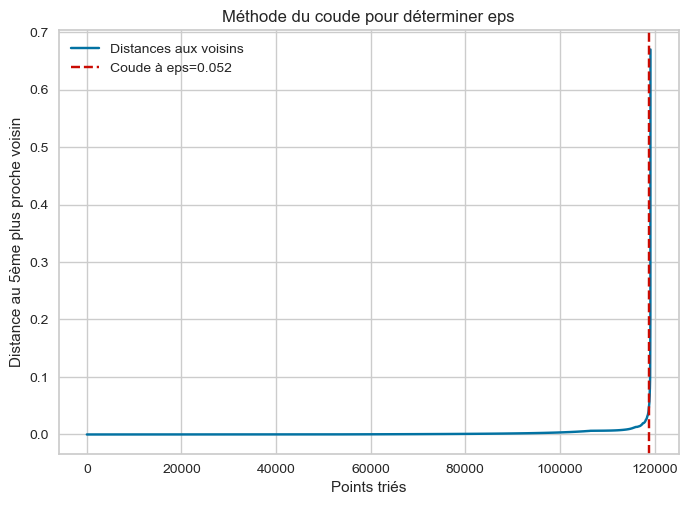

Pour k=2, eps recommandé = 0.052


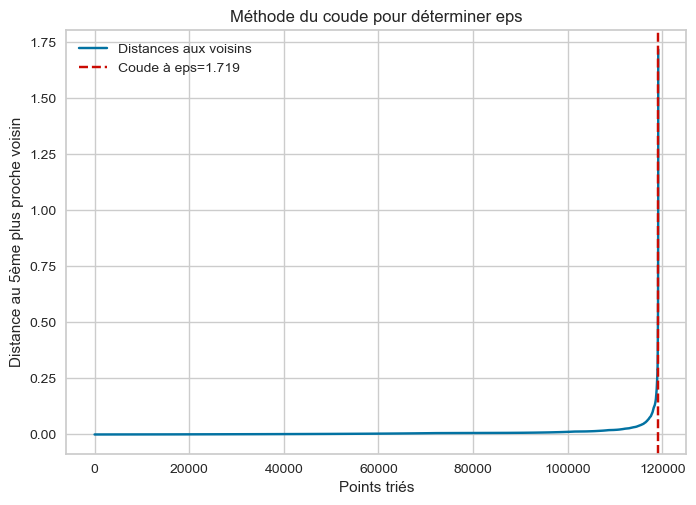

Pour k=4, eps recommandé = 1.719


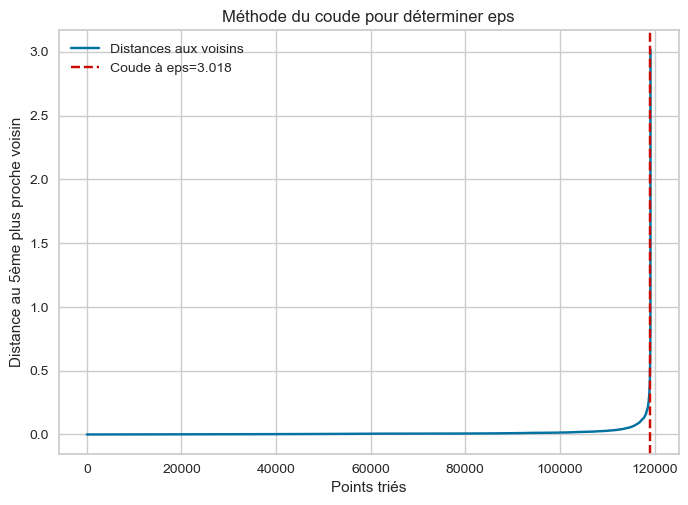

Pour k=5, eps recommandé = 3.018


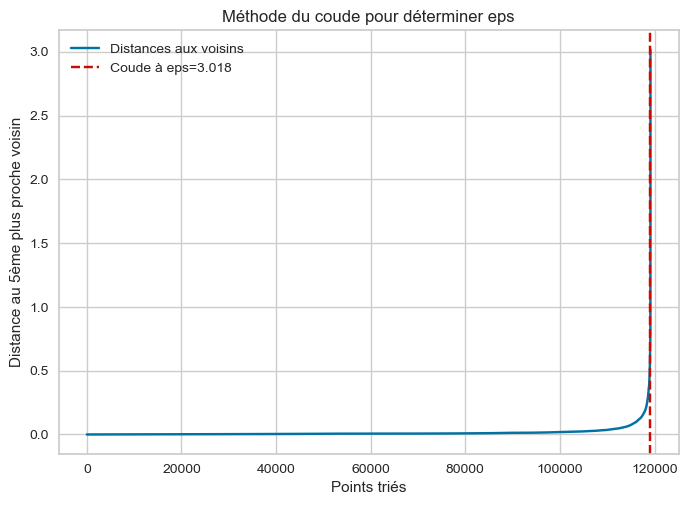

Pour k=6, eps recommandé = 3.018


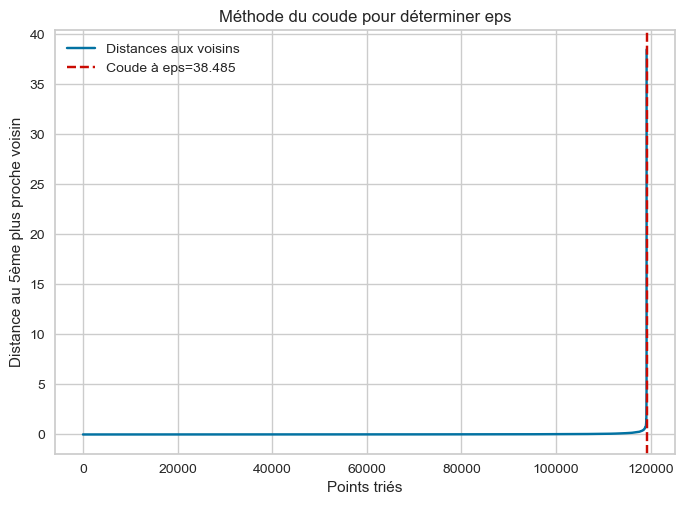

Pour k=10, eps recommandé = 38.485


In [315]:
#  Calcul des distances des k-plus proches voisins
for k in [2, 4, 5, 6, 10]:
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(df_satisfaction)
    distances, indices = neigh.kneighbors(df_satisfaction)
    sorted_distances = np.sort(distances[:, -1])  # On prend la plus grande distance de chaque point: dernière colonne = distance au k-ième voisin
    
    kneedle = KneeLocator(range(len(sorted_distances)), sorted_distances, curve="convex", direction="increasing")
    eps_value = sorted_distances[kneedle.knee]  # Valeur optimale de eps
    
    plt.plot(sorted_distances, label="Distances aux voisins")
    plt.axvline(x=kneedle.knee, color='r', linestyle='--', label=f"Coude à eps={eps_value:.3f}")
    plt.xlabel("Points triés")
    plt.ylabel("Distance au 5ème plus proche voisin")
    plt.title("Méthode du coude pour déterminer eps")
    plt.legend() 
    plt.show()
    print(f"Pour k={k}, eps recommandé = {eps_value:.3f}")

Ici nous testerons eps = 3.018 pour avoir des clusters bien séparés

#### **Sous-échantillon**:
Je crée un sous échantillon ( par exemple 20% de la df) et regarde si les statistiques descriptives sont proches afin que la df_sampled soit bien représentative de ma df initiale. 

In [318]:
df_sampled_satisfaction = df_satisfaction.sample(frac=0.2, random_state=42)  # 20% des données

print("Avant échantillonnage :")
print(df_satisfaction.describe())

print("\nAprès échantillonnage :")
print(df_sampled_satisfaction.describe())

Avant échantillonnage :
            recency     frequency      monetary    avg_review
count  1.191430e+05  1.191430e+05  1.191430e+05  1.191430e+05
mean   1.252990e-16  5.325656e-17  4.508618e-17 -3.077311e-17
std    1.000004e+00  1.000004e+00  1.000004e+00  1.000004e+00
min   -1.876222e+00 -2.217399e-01 -2.298710e-01 -2.185781e+00
25%   -8.133127e-01 -2.217399e-01 -1.875038e-01 -3.786455e-01
50%   -1.286165e-01 -2.217399e-01 -1.488928e-01  7.056356e-01
75%    7.125815e-01 -2.217399e-01 -6.021035e-02  7.056356e-01
max    3.157925e+00  3.871167e+01  6.525761e+01  7.056356e-01

Après échantillonnage :
            recency     frequency      monetary    avg_review
count  23829.000000  23829.000000  23829.000000  23829.000000
mean       0.007873      0.000262     -0.003812     -0.007945
std        1.000181      1.001171      0.937646      1.004643
min       -1.876222     -0.221740     -0.229871     -2.185781
25%       -0.800271     -0.221740     -0.187492     -0.378646
50%       -0.122096  

- Moyenne : Très proche entre l’échantillon et la base complète pour toutes les variables.
- Écart-type (std) : Légèrement différent pour monetary et avg_review, mais reste globalement stable.
- Min/Max : Identiques entre les deux jeux de données, ce qui indique que les valeurs extrêmes ont été bien conservées.
- Quartiles (25%, 50%, 75%) : Très similaires, donc la distribution semble bien respectée.

In [320]:
for min_samples in [2, 4, 6]:
    dbscan = DBSCAN(eps= 3.018, min_samples=min_samples)
    labels = dbscan.fit_predict(df_sampled_satisfaction)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Ne pas compter les outliers (-1 car on souhaite garder seulement les Clusters 
    print(f"min_samples = {min_samples} => {n_clusters} clusters détectés")

min_samples = 2 => 7 clusters détectés
min_samples = 4 => 4 clusters détectés
min_samples = 6 => 2 clusters détectés


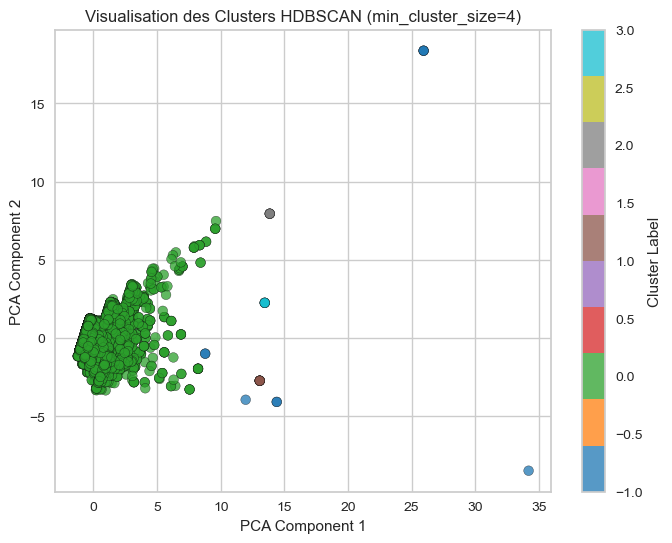

In [321]:
# Sélection de min_samples  = 4
min_samples_optimal_satisfaction  = 4

dbscan_cluster = DBSCAN(eps= 3.018, min_samples=min_samples_optimal_satisfaction)

labels_db_satisfaction= dbscan_cluster.fit_predict(df_sampled_satisfaction)

# Réduction de dimension avec PCA
pca_db_satisfaction = PCA(n_components=2)
df_pca_db_satisfaction = pca_db_satisfaction.fit_transform(df_sampled_satisfaction)

# Visualisation des clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca_db_satisfaction[:, 0], df_pca_db_satisfaction[:, 1], c=labels_db_satisfaction, cmap='tab10', alpha=0.75, edgecolors='k')

# Ajouter une barre de couleur
plt.colorbar(scatter, label="Cluster Label")

# Labels et titre
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"Visualisation des Clusters HDBSCAN (min_cluster_size={min_samples_optimal_satisfaction})")

# Affichage
plt.show()

#### **Métriques**

In [323]:
# Filtre pour retirer les outliers 
mask = labels_db_satisfaction != -1
X_no_noise2 = df_sampled_satisfaction[mask]
labels_no_noise2 = labels_db_satisfaction[mask]

if len(set(labels_no_noise2)) > 1:
    silhouette = silhouette_score(X_no_noise2, labels_no_noise2)
    db_index = davies_bouldin_score(X_no_noise2, labels_no_noise2)
    ch_index = calinski_harabasz_score(X_no_noise2, labels_no_noise2)
    
    print(f"Silhouette Score (sans outliers): {silhouette:.4f}")
    print(f"Davies-Bouldin Index (sans outliers): {db_index:.4f}")
    print(f"Calinski-Harabasz Index (sans outliers): {ch_index:.4f}")
else:
    print("Nombre de clusters (sans outliers) insuffisant pour calculer les métriques.")

Silhouette Score (sans outliers): 0.8822
Davies-Bouldin Index (sans outliers): 0.0743
Calinski-Harabasz Index (sans outliers): 848.4766


#### **Vérification outliers**

In [325]:
# Nombre total de points
total_points_db_satisfaction = len(labels_db_satisfaction)

# Nombre de points classés comme outliers (-1)
outliers_count_db_satisfaction = np.sum(labels_db_satisfaction == -1)

# Pourcentage d'outliers
outliers_percentage_db_satisfaction = (outliers_count_db_satisfaction / total_points_db_satisfaction) * 100

print(f"Nombre total de points : {total_points_db_satisfaction}")
print(f"Nombre d'outliers : {outliers_count_db_satisfaction}")
print(f"Pourcentage d'outliers : {outliers_percentage_db_satisfaction:.2f}%")

Nombre total de points : 23829
Nombre d'outliers : 9
Pourcentage d'outliers : 0.04%


#### **Moyenne**

In [327]:
df_clusters_db_satisfaction = df_sampled_satisfaction.copy()
df_clusters_db_satisfaction["Cluster"] = labels_db_satisfaction

# Supprimer les outliers (-1) avant de calculer la moyenne
df_clusters_db_satisfaction = df_clusters_db_satisfaction[df_clusters_db_satisfaction["Cluster"] != -1]

# Moyennes par cluster
cluster_means_db_satisfaction = df_clusters_db_satisfaction.groupby("Cluster").mean()

print(" Moyennes des features par cluster avec DBSCAN:")
print(cluster_means_db_satisfaction)

 Moyennes des features par cluster avec DBSCAN:
          recency  frequency   monetary  avg_review
Cluster                                            
0        0.008171  -0.008919  -0.022042   -0.007749
1        0.856042  -0.221740  26.882288    0.705636
2       -0.369890  19.244967   0.946479   -0.998235
3       -1.426279   7.078275  16.505824   -0.017218


In [328]:
quantitative_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment', 'diversity_products', 'avg_installments']
target_features = ['recency', 'frequency', 'monetary', 'avg_review']

In [329]:
cluster_means_original_db_satisfaction = inverse_transform_mean(
    cluster_means_db_satisfaction,  # DataFrame des moyennes normalisées par cluster
    df_final,              # DataFrame original non transformé
    quantitative_features, # Variables standardisées
    target_features        # Variables à inverser
)

print("Moyennes en échelle d'origine:")
print(cluster_means_original_db_satisfaction)

Moyennes en échelle d'origine:
           recency  frequency      monetary  avg_review
Cluster                                                
0        288.97677   1.087461    346.911675    4.013100
1        419.00000   1.000000  45256.000000    5.000000
2        231.00000   9.000000   1963.580000    2.642857
3         69.00000   4.000000  27935.460000    4.000000


- Cluster 0: difficile à différencier
- Cluster 1: Clients inactifs mais très dépensiers et satisfaits
- Clutser 2: Acheteurs fréquents
- Cluster 3:  Nouveaux clients

In [331]:
display(df_clusters_db_satisfaction['Cluster'].value_counts().sort_index())

Cluster
0    23805
1        7
2        4
3        4
Name: count, dtype: int64

Les séparations de Clusters sont, en plus d'être difficile d'interprétation métier, mal séparés avec des clusters avec seulement 4 observations contre des clusters avec 23.805 observations

#### Test moyenne

In [334]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_original_db_satisfaction.index:
        for j in cluster_means_original_db_satisfaction.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_db_satisfaction[df_clusters_db_satisfaction['Cluster'] == i][feature]
                group_2 = df_clusters_db_satisfaction[df_clusters_db_satisfaction['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_original_db_satisfaction.loc[i, feature]
                mean_2 = cluster_means_original_db_satisfaction.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=-20056.7977, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=8943.2353, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=33932.6253, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=2073925965455080192.0000, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=3861032382496160256.0000, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=inf, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=15.6473, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=-1415.6100, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=-521.0742, p-value=0.0000
T-test Frequency (Cluster 1 vs Cluster 2): t-stat=-706017349942155008.0000, p-value=0.0000
T-test Frequency (Cluster 1 vs Cluster 3): t-stat=-264756506228308128.0000, p-value=0.0000
T-test Frequency (Cluster 2 vs Cluster 3): t-stat=inf, p-value=0.0000
T-test Monetary (Cluster 0 vs Cluster 1): t-stat=-

In [335]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_db_satisfaction.index:
        for j in cluster_means_db_satisfaction.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_db_satisfaction[df_clusters_db_satisfaction['Cluster'] == i][feature]
                group_2 = df_clusters_db_satisfaction[df_clusters_db_satisfaction['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_db_satisfaction.loc[i, feature]
                mean_2 = cluster_means_db_satisfaction.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")



T-test Recency (Cluster 0 vs Cluster 1): t-stat=-130.7887, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=58.3181, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=221.2718, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=13523895738229870.0000, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=25177465470108800.0000, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=inf, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=38.0752, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=-3444.6580, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=-1267.9497, p-value=0.0000
T-test Frequency (Cluster 1 vs Cluster 2): t-stat=-1717979088706840576.0000, p-value=0.0000
T-test Frequency (Cluster 1 vs Cluster 3): t-stat=-644242158265065344.0000, p-value=0.0000
T-test Frequency (Cluster 2 vs Cluster 3): t-stat=inf, p-value=0.0000
T-test Monetary (Cluster 0 vs Cluster 1): t-stat=-7136.735

- T-test Avg_review (Cluster 0 vs Cluster 3): t-stat=1.4544, p-value=0.1458

### **HDBSCAN :**
- cluster_selection_epsilon joue un rôle similaire à epsilon :
Il définit un seuil de distance au-delà duquel deux clusters ne fusionneront pas. Mais contrairement à DBSCAN, HDBSCAN peut avoir un eps adaptatif qui évolue selon la densité locale.

- Sans cluster_selection_epsilon :
HDBSCAN détecte des clusters de tailles très variées.
Certains petits clusters peuvent apparaître si les points sont densément connectés.
- Avec cluster_selection_epsilon :
forces une séparation des clusters qui dépasse une certaine distance.
Cela évite d'avoir trop de petits clusters et stabilise leur nombre.


Ici les paramètres à ajuster:
- min_cluster_size = Plus il est grand, plus les petits clusters sont ignorés. Essaye 5, 10, 20, 50.
- min_samples = Définit la sensibilité aux outliers (en général, même valeur que min_cluster_size).
- cluster_selection_method = 'eom' (par défaut) détecte les clusters de manière optimale, 'leaf' garde plus de petits clusters.
- cluster_selection_epsilon

In [338]:
#Ajout du paramètres cluster_selection_epsilon: 

for min_cluster_size in [10, 15, 20, 30, 40]:
    hdbscan_cluster = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size, 
        min_samples=min_cluster_size,  # Garde la cohérence
        cluster_selection_epsilon = 3.018,
        metric='euclidean'
    )
    
    labels = hdbscan_cluster.fit_predict(df_satisfaction)
    
    # Compter les clusters détectés (on exclut les outliers -1)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"min_cluster_size = {min_cluster_size} => {n_clusters} clusters détectés")

min_cluster_size = 10 => 8 clusters détectés
min_cluster_size = 15 => 5 clusters détectés
min_cluster_size = 20 => 3 clusters détectés
min_cluster_size = 30 => 2 clusters détectés
min_cluster_size = 40 => 2 clusters détectés


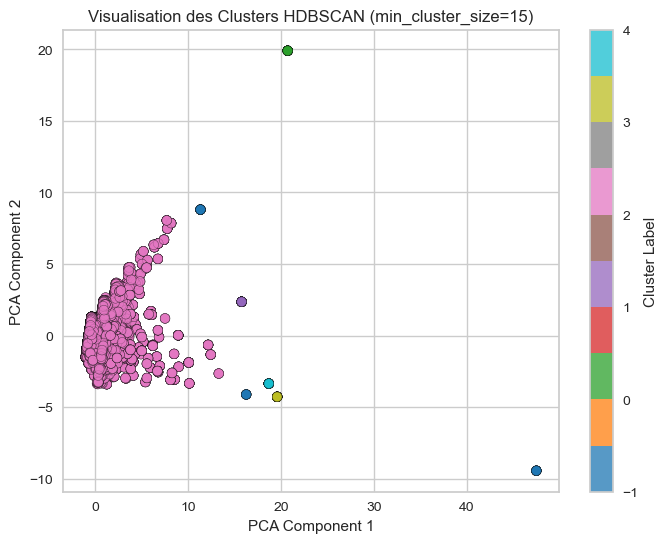

In [339]:
# Sélection de min_cluster_size = 15
min_cluster_size_satisfaction = 15

# Exécution de HDBSCAN avec min_cluster_size = 15
hdbscan_cluster_satisfaction = hdbscan.HDBSCAN(
    min_cluster_size=min_cluster_size_satisfaction, 
    min_samples=min_cluster_size_satisfaction,  
    cluster_selection_epsilon=3.018,
    metric='euclidean'
)

labels_hd_satisfaction = hdbscan_cluster_satisfaction.fit_predict(df_satisfaction)

# Réduction de dimension avec PCA
pca_hd_satisfaction = PCA(n_components=2)
df_pca_hd_satisfaction= pca_hd_satisfaction.fit_transform(df_satisfaction)

# Visualisation des clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca_hd_satisfaction[:, 0], df_pca_hd_satisfaction[:, 1], c=labels_hd_satisfaction, cmap='tab10', alpha=0.75, edgecolors='k')

# Ajouter une barre de couleur
plt.colorbar(scatter, label="Cluster Label")

# Labels et titre
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"Visualisation des Clusters HDBSCAN (min_cluster_size={min_cluster_size_satisfaction})")

# Affichage
plt.show()

#### **Métriques**

In [341]:
# Filtre pour retirer les outliers 
mask = labels_hd_satisfaction != -1
X_no_noise3 = df_satisfaction[mask]
labels_no_noise3 = labels_hd_satisfaction[mask]

if len(set(labels_no_noise3)) > 1:
    silhouette = silhouette_score(X_no_noise3, labels_no_noise3)
    db_index = davies_bouldin_score(X_no_noise3, labels_no_noise3)
    ch_index = calinski_harabasz_score(X_no_noise3, labels_no_noise3)
    
    print(f"Silhouette Score (sans outliers): {silhouette:.4f}")
    print(f"Davies-Bouldin Index (sans outliers): {db_index:.4f}")
    print(f"Calinski-Harabasz Index (sans outliers): {ch_index:.4f}")
else:
    print("Nombre de clusters (sans outliers) insuffisant pour calculer les métriques.")

Silhouette Score (sans outliers): 0.8832
Davies-Bouldin Index (sans outliers): 0.0630
Calinski-Harabasz Index (sans outliers): 4921.8745


#### **Outliers**

In [343]:
# Nombre total de points
total_points_satisfaction = len(labels_hd_satisfaction)

# Nombre de points classés comme outliers (-1)
outliers_count_satisfaction = np.sum(labels_hd_satisfaction == -1)

# Pourcentage d'outliers
outliers_percentage_satisfaction = (outliers_count_satisfaction / total_points_satisfaction) * 100

print(f"Nombre total de points : {total_points_satisfaction}")
print(f"Nombre d'outliers : {outliers_count_satisfaction}")
print(f"Pourcentage d'outliers : {outliers_percentage_satisfaction:.2f}%")

Nombre total de points : 119143
Nombre d'outliers : 28
Pourcentage d'outliers : 0.02%


Le nombre d'outliers a augmenté en ajoutant la variable avg_review

#### **Moyenne**

In [346]:
df_clusters_hd_satisfaction = df_satisfaction.copy()
df_clusters_hd_satisfaction["Cluster"] = labels_hd_satisfaction

# Supprimer les outliers (-1) avant de calculer la moyenne
df_clusters_hd_satisfaction = df_clusters_hd_satisfaction[df_clusters_hd_satisfaction["Cluster"] != -1]

# Moyennes par cluster
cluster_means_hd_satisfaction = df_clusters_hd_satisfaction.groupby("Cluster").mean()

print(" Moyennes des features par cluster avec HDBSCAN:")
print(cluster_means_hd_satisfaction)

 Moyennes des features par cluster avec HDBSCAN:
          recency  frequency   monetary  avg_review
Cluster                                            
0       -1.504530  38.711674   0.325858    0.535552
1       -1.426279   7.078275  16.505824   -0.017218
2        0.000405  -0.009119  -0.017874    0.000550
3       -0.337286  -0.221740  26.158594   -2.185781
4        0.856042  -0.221740  26.882288    0.705636


In [347]:
quantitative_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment', 'diversity_products', 'avg_installments']
target_features = ['recency', 'frequency', 'monetary', 'avg_review']

In [348]:
cluster_means_original_hd_satisfaction = inverse_transform_mean(
    cluster_means_hd_satisfaction,  # DataFrame des moyennes normalisées par cluster
    df_final,              # DataFrame original non transformé
    quantitative_features, # Variables standardisées
    target_features        # Variables à inverser
)

print("Moyennes en échelle d'origine:")
print(cluster_means_original_hd_satisfaction)

Moyennes en échelle d'origine:
            recency  frequency      monetary  avg_review
Cluster                                                 
0         57.000000  17.000000    927.630000    4.764706
1         69.000000   4.000000  27935.460000    4.000000
2        287.785784   1.087378    353.868765    4.024581
3        236.000000   1.000000  44048.000000    1.000000
4        419.000000   1.000000  45256.000000    5.000000


- Cluster 0: Clients nouveaux et achètent fréquemment
- Cluster 1: difficile à différencier 
- Cluster 2: clients avec dépenses faibles
- Cluster 3: dépenses élevées mais pas les plus élevées
- Cluster 4: Clients inactifs avec des dépenses très élevées et très satisfaits

In [350]:
display(df_clusters_hd_satisfaction['Cluster'].value_counts().sort_index())

Cluster
0        17
1        24
2    119034
3        20
4        20
Name: count, dtype: int64

In [351]:
print(df_final['frequency'].value_counts())

frequency
1     110404
2       7492
3        907
4        179
5         51
6         48
7         31
17        17
9         14
Name: count, dtype: int64


In [352]:
print(df_final['recency'].value_counts())

recency
326    1434
325     647
323     519
324     480
322     461
       ... 
17        1
35        1
763       1
744       1
46        1
Name: count, Length: 631, dtype: int64


#### Test moyenne

In [354]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_original_hd_satisfaction.index:
        for j in cluster_means_original_hd_satisfaction.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_hd_satisfaction[df_clusters_hd_satisfaction['Cluster'] == i][feature]
                group_2 = df_clusters_hd_satisfaction[df_clusters_hd_satisfaction['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_original_hd_satisfaction.loc[i, feature]
                mean_2 = cluster_means_original_hd_satisfaction.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=-108086391056891904.0000, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=-79623.9610, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=-1571464605780318720.0000, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=-2963542932484922368.0000, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=-75483.8120, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=-6556665709730394112.0000, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=-6870757480256400384.0000, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=17866.7384, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 4): t-stat=-45270.5338, p-value=0.0000
T-test Recency (Cluster 3 vs Cluster 4): t-stat=-3213162266567579136.0000, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=70195141449299232.0000, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=6411.8972, p-value=

- T-test Frequency (Cluster 3 vs Cluster 4): t-stat=0.0000, p-value=1.0000

In [356]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_hd_satisfaction.index:
        for j in cluster_means_hd_satisfaction.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_hd_satisfaction[df_clusters_hd_satisfaction['Cluster'] == i][feature]
                group_2 = df_clusters_hd_satisfaction[df_clusters_hd_satisfaction['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_hd_satisfaction.loc[i, feature]
                mean_2 = cluster_means_hd_satisfaction.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")



T-test Recency (Cluster 0 vs Cluster 1): t-stat=-704822210494962.0000, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=-519.2211, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=-10247387726894174.0000, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=-19325012706468364.0000, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=-492.2236, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=-42755462309554344.0000, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=-44803628168694680.0000, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=116.5075, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 4): t-stat=-295.2053, p-value=0.0000
T-test Recency (Cluster 3 vs Cluster 4): t-stat=-20952759262811552.0000, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=170808529207667936.0000, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=15602.3153, p-value=0.0000
T-test Frequ

- T-test Frequency (Cluster 3 vs Cluster 4): t-stat=0.0000, p-value=1.0000

### 3. Test du modèle RFM + avg_review + has_review

In [359]:
df_has_review = df_final_encoded[['recency','frequency', 'monetary','avg_review','has_review']]

#### **Choix du bon eps**

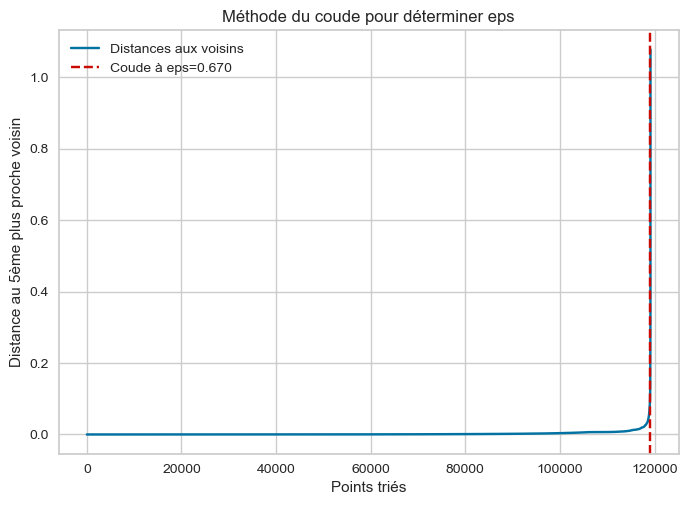

Pour k=2, eps recommandé = 0.670


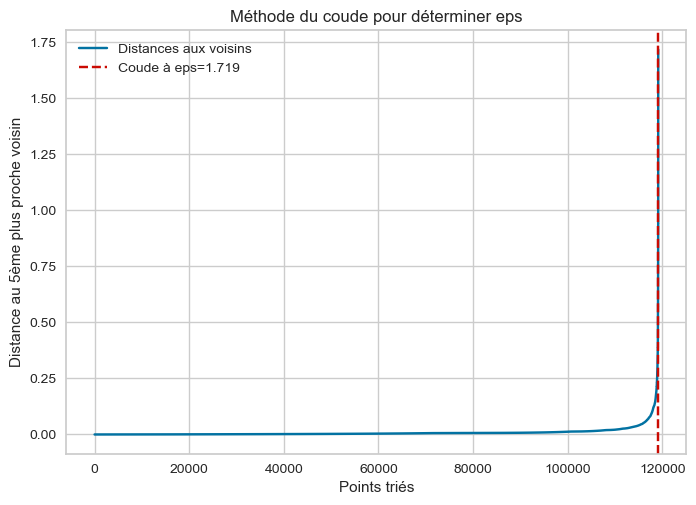

Pour k=4, eps recommandé = 1.719


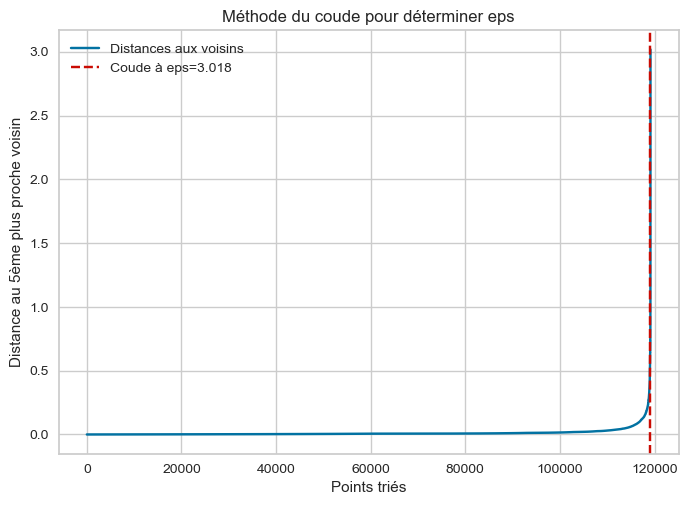

Pour k=5, eps recommandé = 3.018


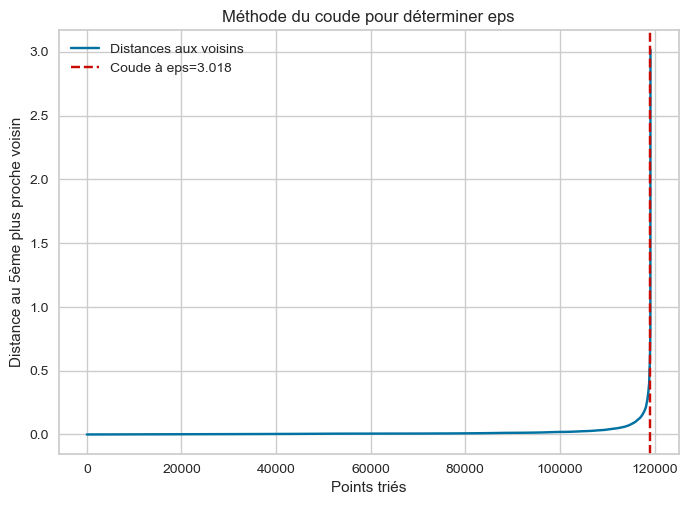

Pour k=6, eps recommandé = 3.018


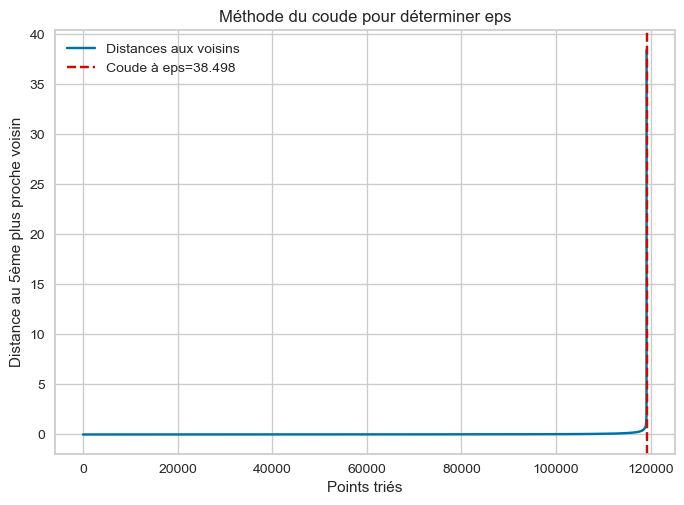

Pour k=10, eps recommandé = 38.498


In [361]:
#  Calcul des distances des k-plus proches voisins
for k in [2, 4, 5, 6, 10]:
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(df_has_review)
    distances, indices = neigh.kneighbors(df_has_review)
    sorted_distances = np.sort(distances[:, -1])  # On prend la plus grande distance de chaque point: dernière colonne = distance au k-ième voisin
    
    kneedle = KneeLocator(range(len(sorted_distances)), sorted_distances, curve="convex", direction="increasing")
    eps_value = sorted_distances[kneedle.knee]  # Valeur optimale de eps
    
    plt.plot(sorted_distances, label="Distances aux voisins")
    plt.axvline(x=kneedle.knee, color='r', linestyle='--', label=f"Coude à eps={eps_value:.3f}")
    plt.xlabel("Points triés")
    plt.ylabel("Distance au 5ème plus proche voisin")
    plt.title("Méthode du coude pour déterminer eps")
    plt.legend()
    plt.show()
    print(f"Pour k={k}, eps recommandé = {eps_value:.3f}")

Ici nous testerons eps = 3.018 

#### **Sous-échantillon**:
Je crée un sous échantillon ( par exemple 20% de la df) et regarde si les statistiques descriptives sont proches afin que la df_sampled soit bien représentative de ma df initiale. 

In [364]:
df_sampled_has_review = df_has_review.sample(frac=0.2, random_state=42)  # 20% des données

print("Avant échantillonnage :")
print(df_has_review.describe())

print("\nAprès échantillonnage :")
print(df_sampled_has_review.describe())

Avant échantillonnage :
            recency     frequency      monetary    avg_review     has_review
count  1.191430e+05  1.191430e+05  1.191430e+05  1.191430e+05  119143.000000
mean   1.252990e-16  5.325656e-17  4.508618e-17 -3.077311e-17       0.991632
std    1.000004e+00  1.000004e+00  1.000004e+00  1.000004e+00       0.091094
min   -1.876222e+00 -2.217399e-01 -2.298710e-01 -2.185781e+00       0.000000
25%   -8.133127e-01 -2.217399e-01 -1.875038e-01 -3.786455e-01       1.000000
50%   -1.286165e-01 -2.217399e-01 -1.488928e-01  7.056356e-01       1.000000
75%    7.125815e-01 -2.217399e-01 -6.021035e-02  7.056356e-01       1.000000
max    3.157925e+00  3.871167e+01  6.525761e+01  7.056356e-01       1.000000

Après échantillonnage :
            recency     frequency      monetary    avg_review    has_review
count  23829.000000  23829.000000  23829.000000  23829.000000  23829.000000
mean       0.007873      0.000262     -0.003812     -0.007945      0.991817
std        1.000181      1.001

- Les moyennes des variables restent proches de zéro après échantillonnage. Légères variations (ex. : recency passe de 0 à 0.0079, avg_review de 0 à -0.0079), mais elles restent faibles.
- La plupart des écarts-types restent proches de 1, sauf pour monetary (0.94 au lieu de 1). Cela indique que la dispersion est globalement bien conservée.
- Les valeurs minimales et maximales sont identiques avant/après. Les quartiles sont proches, bien que quelques écarts apparaissent (monetary, avg_review).

In [366]:
for min_samples in [2, 4, 6]:
    dbscan = DBSCAN(eps= 3.018, min_samples=min_samples)
    labels = dbscan.fit_predict(df_sampled_has_review)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Ne pas compter les outliers (-1 car on souhaite garder seulement les Clusters 
    print(f"min_samples = {min_samples} => {n_clusters} clusters détectés")

min_samples = 2 => 7 clusters détectés
min_samples = 4 => 4 clusters détectés
min_samples = 6 => 2 clusters détectés


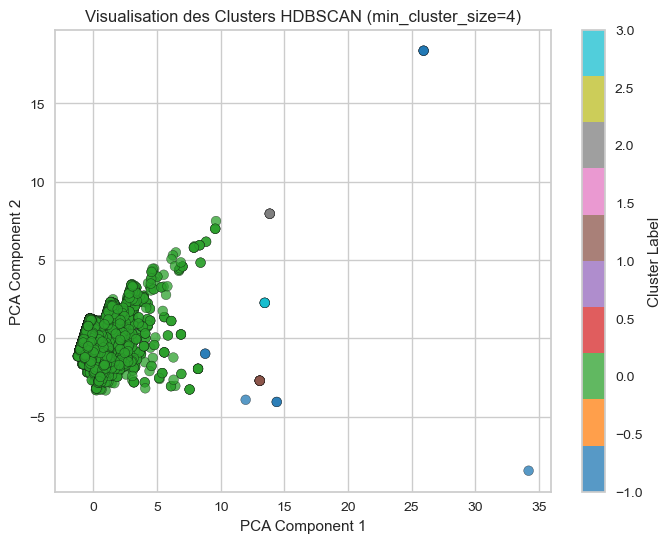

In [367]:
# Sélection de min_samples  = 4
min_samples_optimal_has_review  = 4

dbscan_cluster = DBSCAN(eps= 3.018, min_samples=min_samples_optimal_has_review)

labels_db_has_review= dbscan_cluster.fit_predict(df_sampled_has_review)

# Réduction de dimension avec PCA
pca_db_has_review = PCA(n_components=2)
df_pca_db_has_review = pca_db_has_review.fit_transform(df_sampled_has_review)

# Visualisation des clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca_db_has_review[:, 0], df_pca_db_has_review[:, 1], c=labels_db_has_review, cmap='tab10', alpha=0.75, edgecolors='k')

# Ajouter une barre de couleur
plt.colorbar(scatter, label="Cluster Label")

# Labels et titre
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"Visualisation des Clusters HDBSCAN (min_cluster_size={min_samples_optimal_has_review})")

# Affichage
plt.show()

#### **Métriques**

In [369]:
# Filtre pour retirer les outliers 
mask = labels_db_has_review != -1
X_no_noise4 = df_sampled_has_review[mask]
labels_no_noise4 = labels_db_has_review[mask]

if len(set(labels_no_noise4)) > 1:
    silhouette = silhouette_score(X_no_noise4, labels_no_noise4)
    db_index = davies_bouldin_score(X_no_noise4, labels_no_noise4)
    ch_index = calinski_harabasz_score(X_no_noise4, labels_no_noise4)
    
    print(f"Silhouette Score (sans outliers): {silhouette:.4f}")
    print(f"Davies-Bouldin Index (sans outliers): {db_index:.4f}")
    print(f"Calinski-Harabasz Index (sans outliers): {ch_index:.4f}")
else:
    print("Nombre de clusters (sans outliers) insuffisant pour calculer les métriques.")

Silhouette Score (sans outliers): 0.8819
Davies-Bouldin Index (sans outliers): 0.0744
Calinski-Harabasz Index (sans outliers): 847.0729


#### **Vérification outliers**

In [371]:
# Nombre total de points
total_points_db_has_review = len(labels_db_has_review)

# Nombre de points classés comme outliers (-1)
outliers_count_db_has_review= np.sum(labels_db_has_review == -1)

# Pourcentage d'outliers
outliers_percentage_db_has_review = (outliers_count_db_has_review / total_points_db_has_review) * 100

print(f"Nombre total de points : {total_points_db_has_review}")
print(f"Nombre d'outliers : {outliers_count_db_has_review}")
print(f"Pourcentage d'outliers : {outliers_percentage_db_has_review:.2f}%")

Nombre total de points : 23829
Nombre d'outliers : 9
Pourcentage d'outliers : 0.04%


#### **Moyenne**

In [373]:
df_clusters_db_has_review = df_sampled_has_review.copy()
df_clusters_db_has_review["Cluster"] = labels_db_has_review

# Supprimer les outliers (-1) avant de calculer la moyenne
df_clusters_db_has_review = df_clusters_db_has_review[df_clusters_db_has_review["Cluster"] != -1]

# Moyennes par cluster
cluster_means_db_has_review= df_clusters_db_has_review.groupby("Cluster").mean()

print(" Moyennes des features par cluster avec DBSCAN:")
print(cluster_means_db_has_review)

 Moyennes des features par cluster avec DBSCAN:
          recency  frequency   monetary  avg_review  has_review
Cluster                                                        
0        0.008171  -0.008919  -0.022042   -0.007749    0.992102
1        0.856042  -0.221740  26.882288    0.705636    0.000000
2       -0.369890  19.244967   0.946479   -0.998235    1.000000
3       -1.426279   7.078275  16.505824   -0.017218    1.000000


In [374]:
quantitative_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment', 'diversity_products', 'avg_installments']
target_features = ['recency', 'frequency', 'monetary', 'avg_review', 'has_review']

In [375]:
cluster_means_original_has_review = inverse_transform_mean(
    cluster_means_db_has_review,  # DataFrame des moyennes normalisées par cluster
    df_final,              # DataFrame original non transformé
    quantitative_features, # Variables standardisées
    target_features        # Variables à inverser
)

print("Moyennes en échelle d'origine:")
print(cluster_means_original_has_review)

Moyennes en échelle d'origine:
           recency  frequency      monetary  avg_review  has_review
Cluster                                                            
0        288.97677   1.087461    346.911675    4.013100    0.992102
1        419.00000   1.000000  45256.000000    5.000000    0.000000
2        231.00000   9.000000   1963.580000    2.642857    1.000000
3         69.00000   4.000000  27935.460000    4.000000    1.000000


In [376]:
display(df_clusters_db_has_review['Cluster'].value_counts().sort_index())

Cluster
0    23805
1        7
2        4
3        4
Name: count, dtype: int64

- Cluster 0: dépenses faibles
- CLuster 1: Clients inactifs mais avec beaucoup de dépenses
- Cluster 2: Clients très fréquents mais insatisfaits
- Cluster 3: Nouveaux clients laissent toujours un avis

#### Test moyenne

In [379]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_original_has_review.index:
        for j in cluster_means_original_has_review.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_db_has_review[df_clusters_db_has_review['Cluster'] == i][feature]
                group_2 = df_clusters_db_has_review[df_clusters_db_has_review['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_original_has_review.loc[i, feature]
                mean_2 = cluster_means_original_has_review.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=-20056.7977, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=8943.2353, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=33932.6253, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=2073925965455080192.0000, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=3861032382496160256.0000, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=inf, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=15.6473, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=-1415.6100, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=-521.0742, p-value=0.0000
T-test Frequency (Cluster 1 vs Cluster 2): t-stat=-706017349942155008.0000, p-value=0.0000
T-test Frequency (Cluster 1 vs Cluster 3): t-stat=-264756506228308128.0000, p-value=0.0000
T-test Frequency (Cluster 2 vs Cluster 3): t-stat=inf, p-value=0.0000
T-test Monetary (Cluster 0 vs Cluster 1): t-stat=-

T-test Has_review (Cluster 2 vs Cluster 3): t-stat=nan, p-value=nan car écart type = 0

In [381]:
cluster_id = 2
feature_name = "has_review"

# Extraire les valeurs du cluster
values = df_clusters_db_has_review[df_clusters_db_has_review['Cluster'] == cluster_id][feature_name]

# Afficher l'écart-type
print(f"Écart-type pour Cluster {cluster_id}, Feature {feature_name}: {values.std()}")

# Vérifier les valeurs dans le cluster
print("Statistiques descriptives :", values.describe())

# Vérifier si des NaN sont présents
print(f"Nombre de NaN dans Cluster {cluster_id} pour {feature_name} :", values.isna().sum())


Écart-type pour Cluster 2, Feature has_review: 0.0
Statistiques descriptives : count    4.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: has_review, dtype: float64
Nombre de NaN dans Cluster 2 pour has_review : 0


In [382]:
cluster_id = 3
feature_name = "has_review"

# Extraire les valeurs du cluster
values = df_clusters_db_has_review[df_clusters_db_has_review['Cluster'] == cluster_id][feature_name]

# Afficher l'écart-type
print(f"Écart-type pour Cluster {cluster_id}, Feature {feature_name}: {values.std()}")

# Vérifier les valeurs dans le cluster
print("Statistiques descriptives :", values.describe())

# Vérifier si des NaN sont présents
print(f"Nombre de NaN dans Cluster {cluster_id} pour {feature_name} :", values.isna().sum())

Écart-type pour Cluster 3, Feature has_review: 0.0
Statistiques descriptives : count    4.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: has_review, dtype: float64
Nombre de NaN dans Cluster 3 pour has_review : 0


In [383]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_db_has_review.index:
        for j in cluster_means_db_has_review.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_db_has_review[df_clusters_db_has_review['Cluster'] == i][feature]
                group_2 = df_clusters_db_has_review[df_clusters_db_has_review['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_db_has_review.loc[i, feature]
                mean_2 = cluster_means_db_has_review.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")



T-test Recency (Cluster 0 vs Cluster 1): t-stat=-130.7887, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=58.3181, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=221.2718, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=13523895738229870.0000, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=25177465470108800.0000, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=inf, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=38.0752, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=-3444.6580, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=-1267.9497, p-value=0.0000
T-test Frequency (Cluster 1 vs Cluster 2): t-stat=-1717979088706840576.0000, p-value=0.0000
T-test Frequency (Cluster 1 vs Cluster 3): t-stat=-644242158265065344.0000, p-value=0.0000
T-test Frequency (Cluster 2 vs Cluster 3): t-stat=inf, p-value=0.0000
T-test Monetary (Cluster 0 vs Cluster 1): t-stat=-7136.735

- T-test Avg_review (Cluster 0 vs Cluster 3): t-stat=1.4544, p-value=0.1458
- T-test Has_review (Cluster 2 vs Cluster 3): t-stat=nan, p-value=nan

### **HDBSCAN :**
- cluster_selection_epsilon joue un rôle similaire à epsilon :
Il définit un seuil de distance au-delà duquel deux clusters ne fusionneront pas. Mais contrairement à DBSCAN, HDBSCAN peut avoir un eps adaptatif qui évolue selon la densité locale.

- Sans cluster_selection_epsilon :
HDBSCAN détecte des clusters de tailles très variées.
Certains petits clusters peuvent apparaître si les points sont densément connectés.
- Avec cluster_selection_epsilon :
forces une séparation des clusters qui dépasse une certaine distance.
Cela évite d'avoir trop de petits clusters et stabilise leur nombre.


Ici les paramètres à ajuster:
- min_cluster_size = Plus il est grand, plus les petits clusters sont ignorés. Essaye 5, 10, 20, 50.
- min_samples = Définit la sensibilité aux outliers (en général, même valeur que min_cluster_size).
- cluster_selection_method = 'eom' (par défaut) détecte les clusters de manière optimale, 'leaf' garde plus de petits clusters.
- cluster_selection_epsilon

In [386]:
#Ajout du paramètres cluster_selection_epsilon: 

for min_cluster_size in [10, 15, 20, 30]:
    hdbscan_cluster = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size, 
        min_samples=min_cluster_size,  # Garde la cohérence
        cluster_selection_epsilon = 3.018,
        metric='euclidean'
    )
    
    labels = hdbscan_cluster.fit_predict(df_has_review)
    
    # Compter les clusters détectés (on exclut les outliers -1)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"min_cluster_size = {min_cluster_size} => {n_clusters} clusters détectés")

min_cluster_size = 10 => 8 clusters détectés
min_cluster_size = 15 => 5 clusters détectés
min_cluster_size = 20 => 3 clusters détectés
min_cluster_size = 30 => 2 clusters détectés


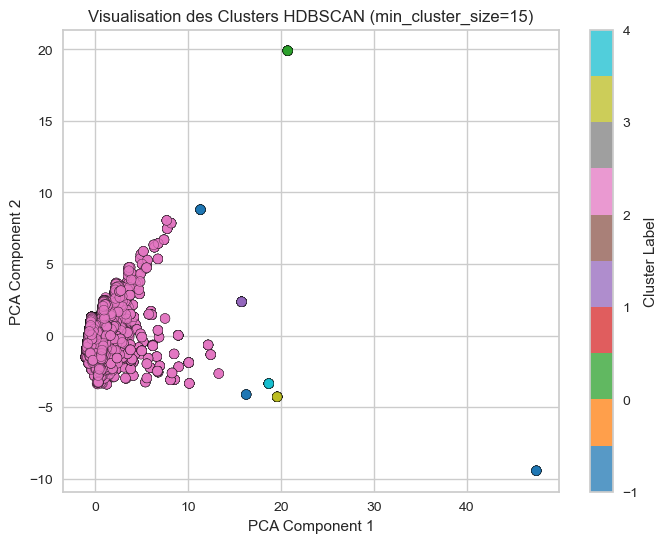

In [387]:
# Sélection de min_cluster_size = 15
min_cluster_size_has_review = 15

# Exécution de HDBSCAN avec min_cluster_size = 15
hdbscan_cluster_has_review = hdbscan.HDBSCAN(
    min_cluster_size=min_cluster_size_has_review, 
    min_samples=min_cluster_size_has_review,  
    cluster_selection_epsilon=3.018,
    metric='euclidean'
)

labels_hd_has_review = hdbscan_cluster_has_review.fit_predict(df_has_review)

# Réduction de dimension avec PCA
pca_hd_has_review = PCA(n_components=2)
df_pca_hd_has_review= pca_hd_has_review.fit_transform(df_has_review)

# Visualisation des clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca_hd_has_review[:, 0], df_pca_hd_has_review[:, 1], c=labels_hd_has_review, cmap='tab10', alpha=0.75, edgecolors='k')

# Ajouter une barre de couleur
plt.colorbar(scatter, label="Cluster Label")

# Labels et titre
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"Visualisation des Clusters HDBSCAN (min_cluster_size={min_cluster_size_has_review})")

# Affichage
plt.show()

#### **Métriques**

In [389]:
# Filtre pour retirer les outliers 
mask = labels_hd_has_review != -1
X_no_noise5 = df_has_review[mask]
labels_no_noise5 = labels_hd_has_review[mask]

if len(set(labels_no_noise5)) > 1:
    silhouette = silhouette_score(X_no_noise5, labels_no_noise5)
    db_index = davies_bouldin_score(X_no_noise5, labels_no_noise5)
    ch_index = calinski_harabasz_score(X_no_noise5, labels_no_noise5)
    
    print(f"Silhouette Score (sans outliers): {silhouette:.4f}")
    print(f"Davies-Bouldin Index (sans outliers): {db_index:.4f}")
    print(f"Calinski-Harabasz Index (sans outliers): {ch_index:.4f}")
else:
    print("Nombre de clusters (sans outliers) insuffisant pour calculer les métriques.")

Silhouette Score (sans outliers): 0.8829
Davies-Bouldin Index (sans outliers): 0.0632
Calinski-Harabasz Index (sans outliers): 4910.6819


#### **Outliers**

In [391]:
# Nombre total de points
total_points_hd_has_review = len(labels_hd_has_review)

# Nombre de points classés comme outliers (-1)
outliers_count_hd_has_review= np.sum(labels_hd_has_review == -1)

# Pourcentage d'outliers
outliers_percentage_hd_has_review = (outliers_count_hd_has_review / total_points_hd_has_review) * 100

print(f"Nombre total de points : {total_points_hd_has_review}")
print(f"Nombre d'outliers : {outliers_count_hd_has_review}")
print(f"Pourcentage d'outliers : {outliers_percentage_hd_has_review:.2f}%")

Nombre total de points : 119143
Nombre d'outliers : 28
Pourcentage d'outliers : 0.02%


#### **Moyenne**

In [393]:
df_clusters_hd_has_review = df_has_review.copy()
df_clusters_hd_has_review["Cluster"] = labels_hd_has_review

# Supprimer les outliers (-1) avant de calculer la moyenne
df_clusters_hd_has_review = df_clusters_hd_has_review[df_clusters_hd_has_review["Cluster"] != -1]

# Moyennes par cluster
cluster_means_hd_has_review = df_clusters_hd_has_review.groupby("Cluster").mean()

print(" Moyennes des features par cluster avec HDBSCAN:")
print(cluster_means_hd_has_review)

 Moyennes des features par cluster avec HDBSCAN:
          recency  frequency   monetary  avg_review  has_review
Cluster                                                        
0       -1.504530  38.711674   0.325858    0.535552    1.000000
1       -1.426279   7.078275  16.505824   -0.017218    1.000000
2        0.000405  -0.009119  -0.017874    0.000550    0.991792
3       -0.337286  -0.221740  26.158594   -2.185781    1.000000
4        0.856042  -0.221740  26.882288    0.705636    0.000000


In [394]:
quantitative_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment', 'diversity_products', 'avg_installments']
target_features = ['recency', 'frequency', 'monetary', 'avg_review', 'has_review']

In [395]:
cluster_means_original_hd_has_review= inverse_transform_mean(
    cluster_means_hd_has_review,  # DataFrame des moyennes normalisées par cluster
    df_final,                     # DataFrame original non transformé
    quantitative_features,        # Variables standardisées
    target_features               # Variables à inverser
)

print("Moyennes en échelle d'origine:")
print(cluster_means_original_hd_has_review)

Moyennes en échelle d'origine:
            recency  frequency      monetary  avg_review  has_review
Cluster                                                             
0         57.000000  17.000000    927.630000    4.764706    1.000000
1         69.000000   4.000000  27935.460000    4.000000    1.000000
2        287.785784   1.087378    353.868765    4.024581    0.991792
3        236.000000   1.000000  44048.000000    1.000000    1.000000
4        419.000000   1.000000  45256.000000    5.000000    0.000000


In [396]:
display(df_clusters_hd_has_review['Cluster'].value_counts().sort_index())

Cluster
0        17
1        24
2    119034
3        20
4        20
Name: count, dtype: int64

Répartition un peu étrange, la plupart des clusters compte très peu d'observations

- Cluster 0: Clients nouveaux et achètent fréquemment
- Cluster 1: difficile à différencier dépenses élevées et récents
- Cluster 2: dépenses faibles
- Cluster 3: clients qui laissent toujours des avis bonnes dépenses
- Cluster 4: Clients inactifs mais avec des dépenses très élevées => incohérence entre très satisfait et ne laisse jamais d'avis

#### Test moyenne

In [399]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_original_hd_has_review.index:
        for j in cluster_means_original_hd_has_review.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_hd_has_review[df_clusters_hd_has_review['Cluster'] == i][feature]
                group_2 = df_clusters_hd_has_review[df_clusters_hd_has_review['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_original_hd_has_review.loc[i, feature]
                mean_2 = cluster_means_original_hd_has_review.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=-108086391056891904.0000, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=-79623.9610, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=-1571464605780318720.0000, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=-2963542932484922368.0000, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=-75483.8120, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=-6556665709730394112.0000, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=-6870757480256400384.0000, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=17866.7384, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 4): t-stat=-45270.5338, p-value=0.0000
T-test Recency (Cluster 3 vs Cluster 4): t-stat=-3213162266567579136.0000, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=70195141449299232.0000, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=6411.8972, p-value=

- T-test Frequency (Cluster 3 vs Cluster 4): t-stat=0.0000, p-value=1.0000
- T-test Has_review (Cluster 0 vs Cluster 3): t-stat=nan, p-value=nan
- T-test Has_review (Cluster 0 vs Cluster 1): t-stat=nan, p-value=nan
- T-test Has_review (Cluster 1 vs Cluster 3): t-stat=nan, p-value=nan

In [401]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_hd_has_review.index:
        for j in cluster_means_hd_has_review.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_hd_has_review[df_clusters_hd_has_review['Cluster'] == i][feature]
                group_2 = df_clusters_hd_has_review[df_clusters_hd_has_review['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_hd_has_review.loc[i, feature]
                mean_2 = cluster_means_hd_has_review.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")



T-test Recency (Cluster 0 vs Cluster 1): t-stat=-704822210494962.0000, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=-519.2211, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=-10247387726894174.0000, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=-19325012706468364.0000, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=-492.2236, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=-42755462309554344.0000, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=-44803628168694680.0000, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=116.5075, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 4): t-stat=-295.2053, p-value=0.0000
T-test Recency (Cluster 3 vs Cluster 4): t-stat=-20952759262811552.0000, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=170808529207667936.0000, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=15602.3153, p-value=0.0000
T-test Frequ

- T-test Frequency (Cluster 3 vs Cluster 4): t-stat=0.0000, p-value=1.0000
- T-test Has_review (Cluster 0 vs Cluster 1): t-stat=nan, p-value=nan
- T-test Has_review (Cluster 0 vs Cluster 3): t-stat=nan, p-value=nan
- T-test Has_review (Cluster 1 vs Cluster 3): t-stat=nan, p-value=nan

### 4. Test du modèle RFM + avg_review + top_category

In [404]:
# Récupérer les noms des colonnes encodées de top_category
top_category_cols = [col for col in df_final_encoded.columns if col.startswith('top_category_')]

df_top_1 = df_final_encoded[['recency', 'frequency', 'monetary', 'avg_review'] + top_category_cols]

#### **Choix du bon eps**

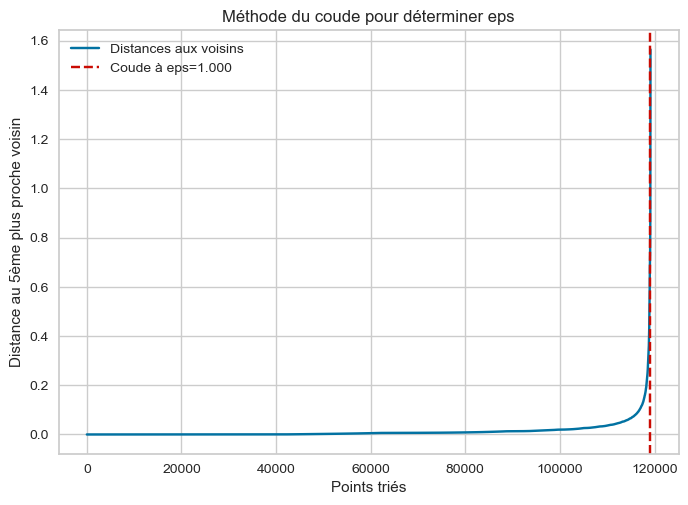

Pour k=2, eps recommandé = 1.000


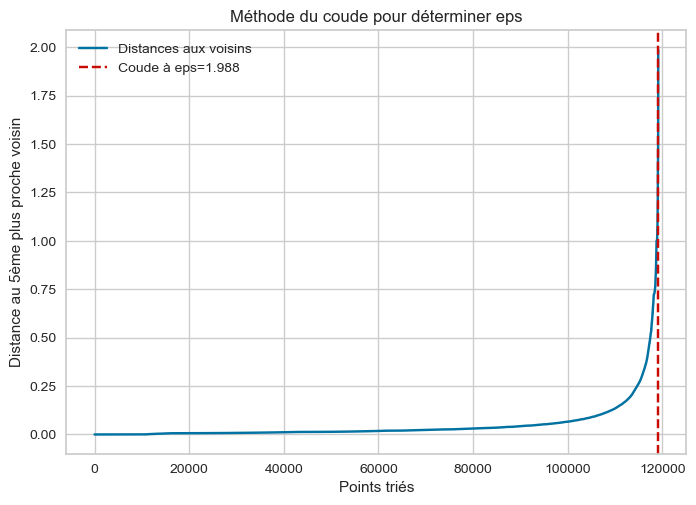

Pour k=4, eps recommandé = 1.988


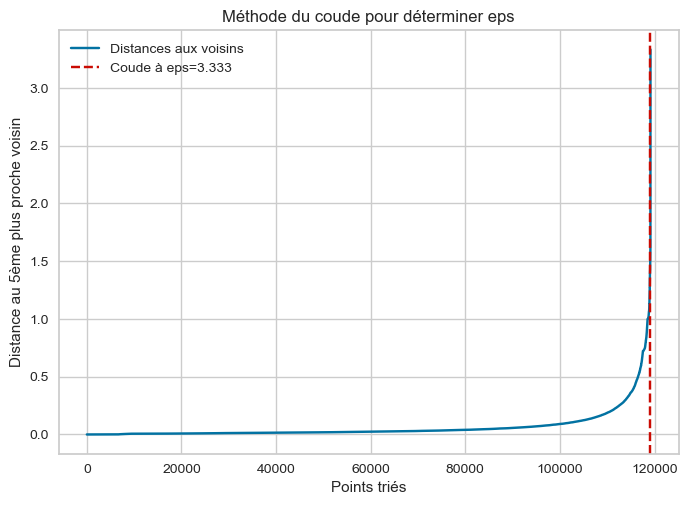

Pour k=5, eps recommandé = 3.333


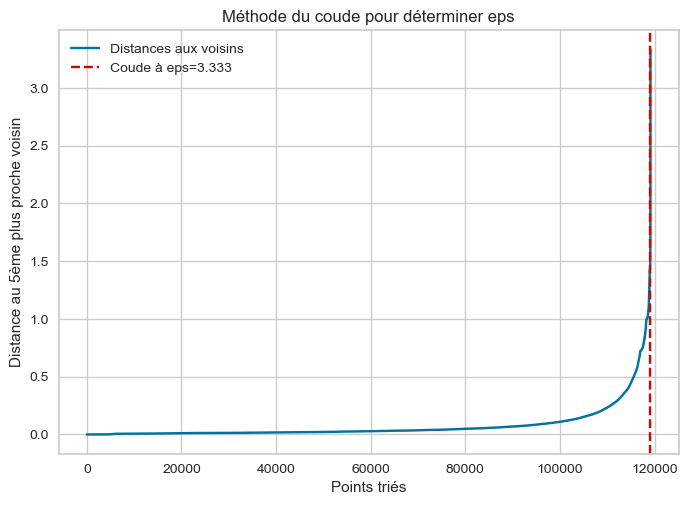

Pour k=6, eps recommandé = 3.333


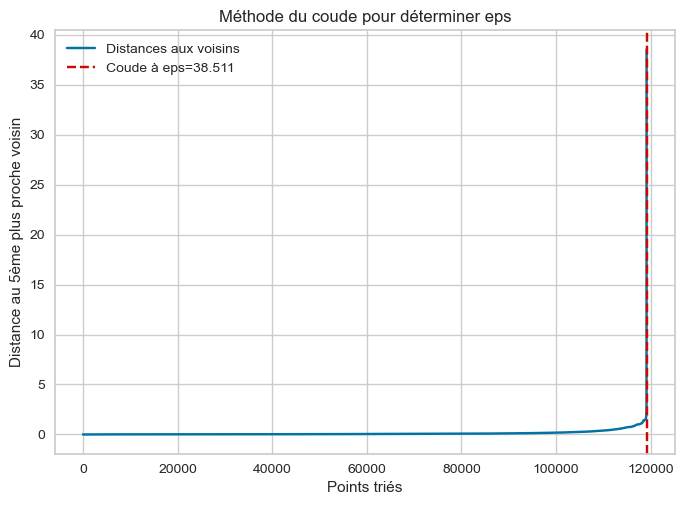

Pour k=10, eps recommandé = 38.511


In [406]:
#  Calcul des distances des k-plus proches voisins
for k in [2, 4, 5, 6, 10]:
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(df_top_1)
    distances, indices = neigh.kneighbors(df_top_1)
    sorted_distances = np.sort(distances[:, -1])  # On prend la plus grande distance de chaque point: dernière colonne = distance au k-ième voisin
    
    kneedle = KneeLocator(range(len(sorted_distances)), sorted_distances, curve="convex", direction="increasing")
    eps_value = sorted_distances[kneedle.knee]  # Valeur optimale de eps
    
    plt.plot(sorted_distances, label="Distances aux voisins")
    plt.axvline(x=kneedle.knee, color='r', linestyle='--', label=f"Coude à eps={eps_value:.3f}")
    plt.xlabel("Points triés")
    plt.ylabel("Distance au 5ème plus proche voisin")
    plt.title("Méthode du coude pour déterminer eps")
    plt.legend()  
    plt.show()
    print(f"Pour k={k}, eps recommandé = {eps_value:.3f}")

Ici nous testerons eps = 3.333 

#### **Sous-échantillon**:
Je crée un sous échantillon ( par exemple 20% de la df) et regarde si les statistiques descriptives sont proches afin que la df_sampled soit bien représentative de ma df initiale. 

In [409]:
df_sampled_top_1 = df_top_1.sample(frac=0.2, random_state=42)  # 20% des données

print("Avant échantillonnage :")
print(df_top_1.describe())

print("\nAprès échantillonnage :")
print(df_sampled_top_1.describe())

Avant échantillonnage :
            recency     frequency      monetary    avg_review  \
count  1.191430e+05  1.191430e+05  1.191430e+05  1.191430e+05   
mean   1.252990e-16  5.325656e-17  4.508618e-17 -3.077311e-17   
std    1.000004e+00  1.000004e+00  1.000004e+00  1.000004e+00   
min   -1.876222e+00 -2.217399e-01 -2.298710e-01 -2.185781e+00   
25%   -8.133127e-01 -2.217399e-01 -1.875038e-01 -3.786455e-01   
50%   -1.286165e-01 -2.217399e-01 -1.488928e-01  7.056356e-01   
75%    7.125815e-01 -2.217399e-01 -6.021035e-02  7.056356e-01   
max    3.157925e+00  3.871167e+01  6.525761e+01  7.056356e-01   

       top_category_agro_industry_and_commerce  top_category_air_conditioning  \
count                            119143.000000                  119143.000000   
mean                                  0.002107                       0.002484   
std                                   0.045851                       0.049782   
min                                   0.000000                    

- Les moyennes et écarts-types des variables numériques (ex. recency, frequency, monetary, avg_review) restent proches entre l'ensemble original et l'échantillon. Il y a de légères variations (ex. mean monetary passe de =0.000 à -0.0038), mais elles sont relativement faibles.
- Comparaison des Min/Max et Quartiles: Les min/max restent inchangés, ce qui signifie que la plage des valeurs est conservée. Les quartiles sont également assez similaires, ce qui indique que la distribution globale des valeurs ne change pas de manière drastique.
- Comparaison des Catégories (top_category_*): Les proportions de chaque catégorie restent très proches avant et après l'échantillonnage. Par exemple :
top_category_sports_leisure : 7.54% avant, 7.64% après, top_category_toys : 3.59% avant, 3.61% après, top_category_telephony : 3.97% avant, 3.93% après Cela suggère que la distribution des catégories reste stable.


L'échantillon semble globalement représentatif, car les statistiques descriptives sont très similaires.

In [411]:
for min_samples in [2, 4, 6, 11]:
    dbscan = DBSCAN(eps= 3.333, min_samples=min_samples)
    labels = dbscan.fit_predict(df_sampled_top_1)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Ne pas compter les outliers (-1 car on souhaite garder seulement les Clusters 
    print(f"min_samples = {min_samples} => {n_clusters} clusters détectés")

min_samples = 2 => 7 clusters détectés
min_samples = 4 => 4 clusters détectés
min_samples = 6 => 2 clusters détectés
min_samples = 11 => 1 clusters détectés


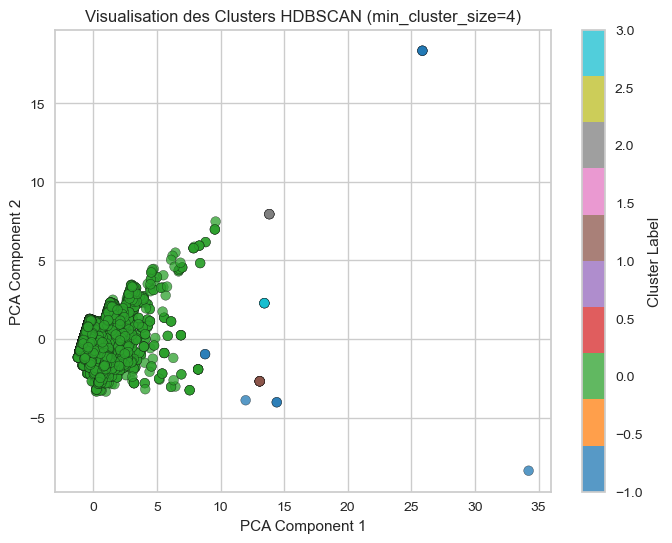

In [412]:
# Sélection de min_samples  = 4
min_samples_optimal_top_1 = 4

dbscan_cluster = DBSCAN(eps= 3.333, min_samples=min_samples_optimal_top_1)

labels_db_top_1= dbscan_cluster.fit_predict(df_sampled_top_1)

# Réduction de dimension avec PCA
pca_db_top_1 = PCA(n_components=2)
df_pca_db_top_1 = pca_db_top_1.fit_transform(df_sampled_top_1)

# Visualisation des clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca_db_top_1[:, 0], df_pca_db_top_1[:, 1], c=labels_db_top_1, cmap='tab10', alpha=0.75, edgecolors='k')

# Ajouter une barre de couleur
plt.colorbar(scatter, label="Cluster Label")

# Labels et titre
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"Visualisation des Clusters HDBSCAN (min_cluster_size={min_samples_optimal_top_1})")

# Affichage
plt.show()

#### **Métriques**

In [414]:
# Filtre pour retirer les outliers 
mask = labels_db_top_1 != -1
X_no_noise6 = df_sampled_top_1[mask]
labels_no_noise6 = labels_db_top_1[mask]

if len(set(labels_no_noise6)) > 1:
    silhouette = silhouette_score(X_no_noise6, labels_no_noise6)
    db_index = davies_bouldin_score(X_no_noise6, labels_no_noise6)
    ch_index = calinski_harabasz_score(X_no_noise6, labels_no_noise6)
    
    print(f"Silhouette Score (sans outliers): {silhouette:.4f}")
    print(f"Davies-Bouldin Index (sans outliers): {db_index:.4f}")
    print(f"Calinski-Harabasz Index (sans outliers): {ch_index:.4f}")
else:
    print("Nombre de clusters (sans outliers) insuffisant pour calculer les métriques.")

Silhouette Score (sans outliers): 0.8550
Davies-Bouldin Index (sans outliers): 0.0909
Calinski-Harabasz Index (sans outliers): 653.8104


#### **Vérification outliers**

In [416]:
# Nombre total de points
total_points_db_top_1= len(labels_db_top_1)

# Nombre de points classés comme outliers (-1)
outliers_count_db_top_1= np.sum(labels_db_top_1 == -1)

# Pourcentage d'outliers
outliers_percentage_db_top_1 = (outliers_count_db_top_1 / total_points_db_top_1) * 100

print(f"Nombre total de points : {total_points_db_top_1}")
print(f"Nombre d'outliers : {outliers_count_db_top_1}")
print(f"Pourcentage d'outliers : {outliers_percentage_db_top_1:.2f}%")

Nombre total de points : 23829
Nombre d'outliers : 9
Pourcentage d'outliers : 0.04%


#### **Moyenne**

In [418]:
df_clusters_db_top_1 = df_sampled_top_1.copy()
df_clusters_db_top_1["Cluster"] = labels_db_top_1

# Supprimer les outliers (-1) avant de calculer la moyenne
df_clusters_db_top_1 = df_clusters_db_top_1[df_clusters_db_top_1["Cluster"] != -1]

# Moyennes par cluster
cluster_means_db_top_1= df_clusters_db_top_1.groupby("Cluster").mean()

print(" Moyennes des features par cluster avec DBSCAN:")
print(cluster_means_db_top_1)

 Moyennes des features par cluster avec DBSCAN:
          recency  frequency   monetary  avg_review  \
Cluster                                               
0        0.008171  -0.008919  -0.022042   -0.007749   
1        0.856042  -0.221740  26.882288    0.705636   
2       -0.369890  19.244967   0.946479   -0.998235   
3       -1.426279   7.078275  16.505824   -0.017218   

         top_category_agro_industry_and_commerce  \
Cluster                                            
0                                       0.001638   
1                                       0.000000   
2                                       0.000000   
3                                       0.000000   

         top_category_air_conditioning  top_category_art  \
Cluster                                                    
0                             0.002941          0.001974   
1                             0.000000          0.000000   
2                             0.000000          0.000000   
3       

In [419]:
quantitative_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment', 'diversity_products', 'avg_installments']
target_features = ['recency', 'frequency', 'monetary', 'avg_review']

In [420]:
cluster_means_original_top_1 = inverse_transform_mean(
    cluster_means_db_top_1,  # DataFrame des moyennes normalisées par cluster
    df_final,              # DataFrame original non transformé
    quantitative_features, # Variables standardisées
    target_features        # Variables à inverser
)

print("Moyennes en échelle d'origine:")
print(cluster_means_original_top_1)

Moyennes en échelle d'origine:
           recency  frequency      monetary  avg_review
Cluster                                                
0        288.97677   1.087461    346.911675    4.013100
1        419.00000   1.000000  45256.000000    5.000000
2        231.00000   9.000000   1963.580000    2.642857
3         69.00000   4.000000  27935.460000    4.000000


In [421]:
# Identifier la catégorie la plus fréquente par cluster
modes_top_1 = df_clusters_db_top_1.groupby("Cluster")[top_category_cols].sum().idxmax(axis=1)
#Additionne les 1 de chaque colonne OHE par cluster et idmax (axis = 1) retrouve la colonne où cette somme est maximale

# Afficher les résultats
print(modes_top_1)

Cluster
0    top_category_bed_bath_table
1              top_category_auto
2    top_category_bed_bath_table
3         top_category_telephony
dtype: object


In [422]:
display(df_clusters_db_top_1['Cluster'].value_counts().sort_index())

Cluster
0    23805
1        7
2        4
3        4
Name: count, dtype: int64

Mauvaise répartition des clusters
- Cluster 0: clients dépensant le moins
- Cluster 1: clients inactifs mais qui dépensent énormément
- Cluster 2: client qui achètent fréquemment mais très insatisfaits
- Cluster 3: Nouveaux clients 

#### Test moyenne

In [425]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_original_top_1.index:
        for j in cluster_means_original_top_1.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_db_top_1[df_clusters_db_top_1['Cluster'] == i][feature]
                group_2 = df_clusters_db_top_1[df_clusters_db_top_1['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_original_top_1.loc[i, feature]
                mean_2 = cluster_means_original_top_1.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=-20056.7977, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=8943.2353, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=33932.6253, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=2073925965455080192.0000, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=3861032382496160256.0000, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=inf, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=15.6473, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=-1415.6100, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=-521.0742, p-value=0.0000
T-test Frequency (Cluster 1 vs Cluster 2): t-stat=-706017349942155008.0000, p-value=0.0000
T-test Frequency (Cluster 1 vs Cluster 3): t-stat=-264756506228308128.0000, p-value=0.0000
T-test Frequency (Cluster 2 vs Cluster 3): t-stat=inf, p-value=0.0000
T-test Monetary (Cluster 0 vs Cluster 1): t-stat=-

In [426]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_db_top_1.index:
        for j in cluster_means_db_top_1.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_db_top_1[df_clusters_db_top_1['Cluster'] == i][feature]
                group_2 = df_clusters_db_top_1[df_clusters_db_top_1['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_db_top_1.loc[i, feature]
                mean_2 = cluster_means_db_top_1.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")



T-test Recency (Cluster 0 vs Cluster 1): t-stat=-130.7887, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=58.3181, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=221.2718, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=13523895738229870.0000, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=25177465470108800.0000, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=inf, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=38.0752, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=-3444.6580, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=-1267.9497, p-value=0.0000
T-test Frequency (Cluster 1 vs Cluster 2): t-stat=-1717979088706840576.0000, p-value=0.0000
T-test Frequency (Cluster 1 vs Cluster 3): t-stat=-644242158265065344.0000, p-value=0.0000
T-test Frequency (Cluster 2 vs Cluster 3): t-stat=inf, p-value=0.0000
T-test Monetary (Cluster 0 vs Cluster 1): t-stat=-7136.735

- T-test Avg_review (Cluster 0 vs Cluster 3): t-stat=1.4544, p-value=0.1458

Le HDBSCAN ne sera pas testé dans cette variante à cause de la lenteur d'exécution 

### 5. Test du modèle RFM + avg_review + diversity_products

In [430]:
df_categorie = df_final_encoded[['recency', 'frequency', 'monetary', 'avg_review', 'diversity_products']]

#### **Choix du bon eps**

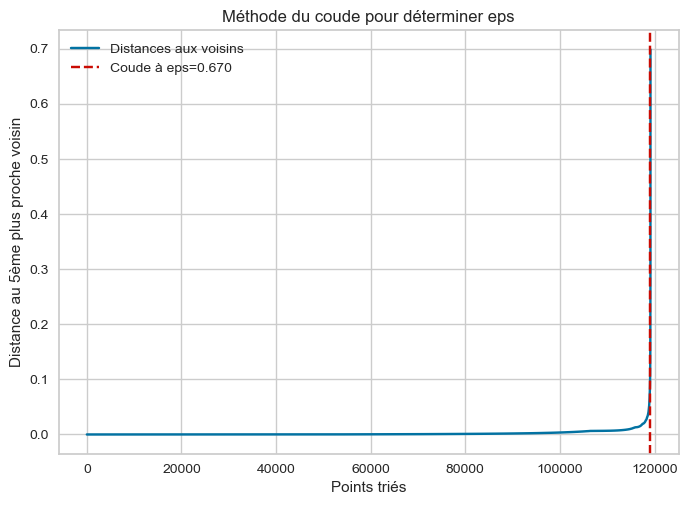

Pour k=2, eps recommandé = 0.670


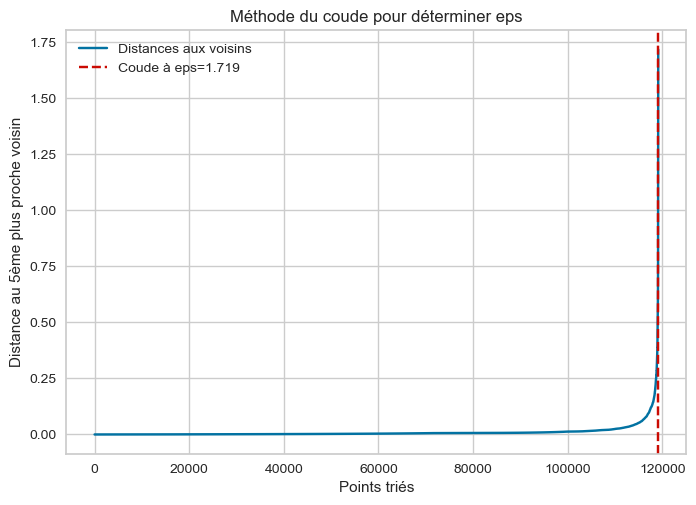

Pour k=4, eps recommandé = 1.719


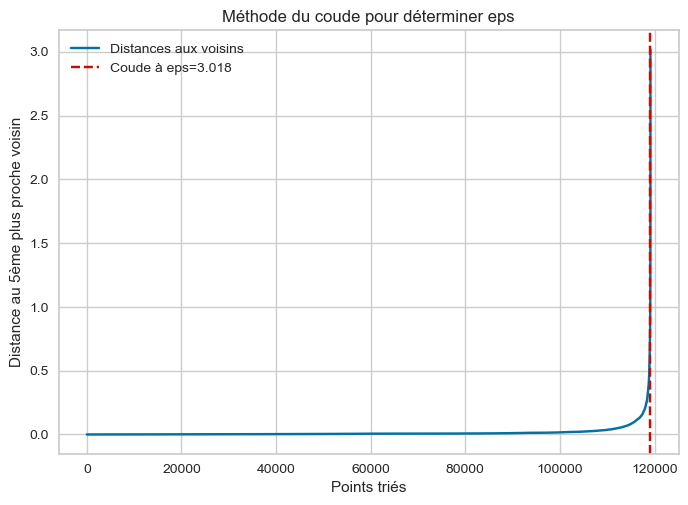

Pour k=5, eps recommandé = 3.018


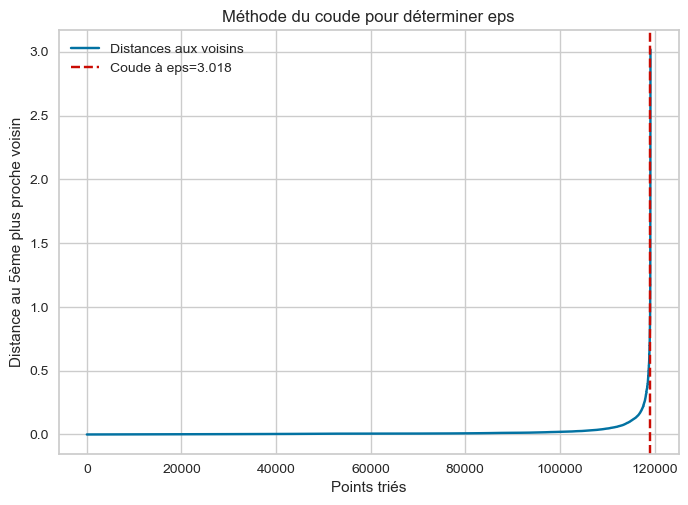

Pour k=6, eps recommandé = 3.018


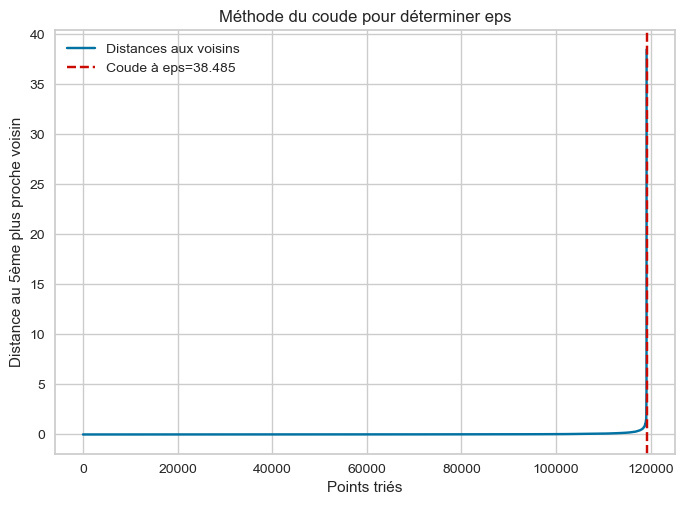

Pour k=10, eps recommandé = 38.485


In [432]:
#  Calcul des distances des k-plus proches voisins
for k in [2, 4, 5, 6, 10]:
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(df_categorie)
    distances, indices = neigh.kneighbors(df_categorie)
    sorted_distances = np.sort(distances[:, -1])  # On prend la plus grande distance de chaque point: dernière colonne = distance au k-ième voisin
    
    kneedle = KneeLocator(range(len(sorted_distances)), sorted_distances, curve="convex", direction="increasing")
    eps_value = sorted_distances[kneedle.knee]  # Valeur optimale de eps
    
    plt.plot(sorted_distances, label="Distances aux voisins")
    plt.axvline(x=kneedle.knee, color='r', linestyle='--', label=f"Coude à eps={eps_value:.3f}")
    plt.xlabel("Points triés")
    plt.ylabel("Distance au 5ème plus proche voisin")
    plt.title("Méthode du coude pour déterminer eps")
    plt.legend() 
    plt.show()
    print(f"Pour k={k}, eps recommandé = {eps_value:.3f}")

Ici nous testerons eps = 3.018 

#### **Sous-échantillon**:
Je crée un sous échantillon ( par exemple 20% de la df) et regarde si les statistiques descriptives sont proches afin que la df_sampled soit bien représentative de ma df initiale. 

In [435]:
df_sampled_categorie = df_categorie.sample(frac=0.2, random_state=42)  # 20% des données

print("Avant échantillonnage :")
print(df_categorie.describe())

print("\nAprès échantillonnage :")
print(df_sampled_categorie.describe())

Avant échantillonnage :
            recency     frequency      monetary    avg_review  \
count  1.191430e+05  1.191430e+05  1.191430e+05  1.191430e+05   
mean   1.252990e-16  5.325656e-17  4.508618e-17 -3.077311e-17   
std    1.000004e+00  1.000004e+00  1.000004e+00  1.000004e+00   
min   -1.876222e+00 -2.217399e-01 -2.298710e-01 -2.185781e+00   
25%   -8.133127e-01 -2.217399e-01 -1.875038e-01 -3.786455e-01   
50%   -1.286165e-01 -2.217399e-01 -1.488928e-01  7.056356e-01   
75%    7.125815e-01 -2.217399e-01 -6.021035e-02  7.056356e-01   
max    3.157925e+00  3.871167e+01  6.525761e+01  7.056356e-01   

       diversity_products  
count        1.191430e+05  
mean         8.230018e-17  
std          1.000004e+00  
min         -2.258503e-01  
25%         -2.258503e-01  
50%         -2.258503e-01  
75%         -2.258503e-01  
max          1.376530e+01  

Après échantillonnage :
            recency     frequency      monetary    avg_review  \
count  23829.000000  23829.000000  23829.000000 

- Les moyennes des variables après échantillonnage sont proches de zéro, comme avant l'échantillonnage.
- Les écarts-types restent proches de 1, ce qui montre une préservation de l’échelle des données.
- Les min, max, médianes (50%) et quartiles (25%, 75%) des variables principales restent similaires avant et après l’échantillonnage.

In [437]:
for min_samples in [2, 4, 6, 11]:
    dbscan = DBSCAN(eps= 3.018, min_samples=min_samples)
    labels = dbscan.fit_predict(df_sampled_categorie)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Ne pas compter les outliers (-1 car on souhaite garder seulement les Clusters 
    print(f"min_samples = {min_samples} => {n_clusters} clusters détectés")

min_samples = 2 => 13 clusters détectés
min_samples = 4 => 9 clusters détectés
min_samples = 6 => 7 clusters détectés
min_samples = 11 => 5 clusters détectés


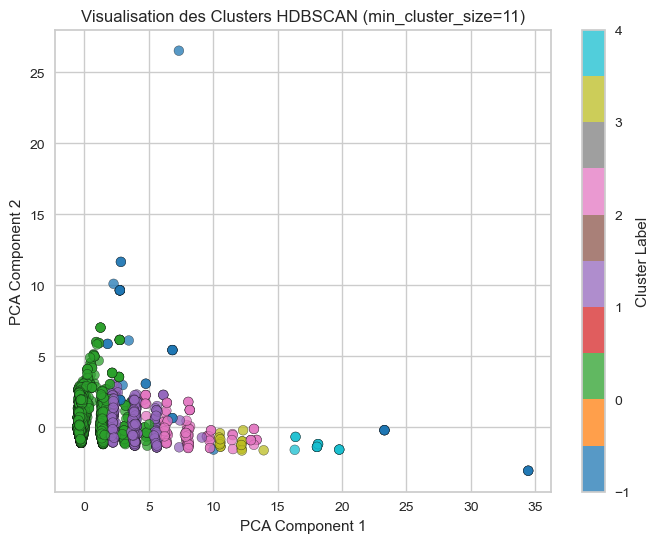

In [438]:
# Sélection de min_samples  = 11
min_samples_optimal_categorie = 11

dbscan_cluster = DBSCAN(eps= 3.018 , min_samples=min_samples_optimal_categorie)

labels_db_categorie= dbscan_cluster.fit_predict(df_sampled_categorie)

# Réduction de dimension avec PCA
pca_db_categorie = PCA(n_components=2)
df_pca_db_categorie = pca_db_categorie.fit_transform(df_sampled_categorie)

# Visualisation des clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca_db_categorie[:, 0], df_pca_db_categorie[:, 1], c=labels_db_categorie, cmap='tab10', alpha=0.75, edgecolors='k')

# Ajouter une barre de couleur
plt.colorbar(scatter, label="Cluster Label")

# Labels et titre
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"Visualisation des Clusters HDBSCAN (min_cluster_size={min_samples_optimal_categorie})")

# Affichage
plt.show()

#### **Métriques**

In [440]:
# Filtre pour retirer les outliers 
mask = labels_db_categorie != -1
X_no_noise7 = df_sampled_categorie[mask]
labels_no_noise7 = labels_db_categorie[mask]

if len(set(labels_no_noise7)) > 1:
    silhouette = silhouette_score(X_no_noise7, labels_no_noise7)
    db_index = davies_bouldin_score(X_no_noise7, labels_no_noise7)
    ch_index = calinski_harabasz_score(X_no_noise7, labels_no_noise7)
    
    print(f"Silhouette Score (sans outliers): {silhouette:.4f}")
    print(f"Davies-Bouldin Index (sans outliers): {db_index:.4f}")
    print(f"Calinski-Harabasz Index (sans outliers): {ch_index:.4f}")
else:
    print("Nombre de clusters (sans outliers) insuffisant pour calculer les métriques.")

Silhouette Score (sans outliers): 0.5790
Davies-Bouldin Index (sans outliers): 0.9010
Calinski-Harabasz Index (sans outliers): 2855.7253


#### **Vérification outliers**

In [442]:
# Nombre total de points
total_points_db_categorie = len(labels_db_categorie)

# Nombre de points classés comme outliers (-1)
outliers_count_db_categorie= np.sum(labels_db_categorie == -1)

# Pourcentage d'outliers
outliers_percentage_db_categorie = (outliers_count_db_categorie / total_points_db_categorie) * 100

print(f"Nombre total de points : {total_points_db_categorie}")
print(f"Nombre d'outliers : {outliers_count_db_categorie}")
print(f"Pourcentage d'outliers : {outliers_percentage_db_categorie:.2f}%")

Nombre total de points : 23829
Nombre d'outliers : 34
Pourcentage d'outliers : 0.14%


#### **Moyenne**

In [444]:
df_clusters_db_categorie = df_sampled_categorie.copy()
df_clusters_db_categorie["Cluster"] = labels_db_categorie

# Supprimer les outliers (-1) avant de calculer la moyenne
df_clusters_db_categorie = df_clusters_db_categorie[df_clusters_db_categorie["Cluster"] != -1]

# Moyennes par cluster
cluster_means_db_categorie= df_clusters_db_categorie.groupby("Cluster").mean()

print(" Moyennes des features par cluster avec DBSCAN:")
print(cluster_means_db_categorie)

 Moyennes des features par cluster avec DBSCAN:
          recency  frequency  monetary  avg_review  diversity_products
Cluster                                                               
0        0.016707  -0.130126 -0.033334    0.002150           -0.225850
1       -0.140401   1.694357  0.112086   -0.205144            3.271937
2        0.081028   4.417522  0.254039   -0.037124            6.769725
3       -0.969000   6.013690  0.268573    0.439083           10.267512
4       -0.467203  11.944952  0.488212    0.435759           13.765300


In [445]:
quantitative_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment', 'diversity_products', 'avg_installments']
target_features = ['recency', 'frequency', 'monetary', 'avg_review', 'diversity_products']

In [446]:
cluster_means_original_categorie = inverse_transform_mean(
    cluster_means_db_categorie,  # DataFrame des moyennes normalisées par cluster
    df_final,                    # DataFrame original non transformé
    quantitative_features,       # Variables standardisées
    target_features              # Variables à inverser
)

print("Moyennes en échelle d'origine:")
print(cluster_means_original_categorie)

Moyennes en échelle d'origine:
            recency  frequency     monetary  avg_review  diversity_products
Cluster                                                                    
0        290.285816   1.037649   328.062999    4.026794                 1.0
1        266.192771   1.787435   570.798795    3.740022                 2.0
2        300.149533   2.906542   807.749439    3.972462                 3.0
3        139.125000   3.562500   832.010000    4.631250                 4.0
4        216.076923   6.000000  1198.634615    4.626651                 5.0


- Cluster 0: clients qui dépensent le moins
- Cluster 1: clients insatisfaits
- Cluster 2: Clients inactifs
- Cluster 3: nouveaux clients très satisfaits
- Cluster 4: Clients qui achètent fréquemment, dépensent beaucoup et achètent une grande variété de produits


In [448]:
display(df_clusters_db_categorie['Cluster'].value_counts().sort_index())

Cluster
0    22497
1     1162
2      107
3       16
4       13
Name: count, dtype: int64

#### Test moyenne

In [450]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_original_categorie.index:
        for j in cluster_means_original_categorie.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_db_categorie[df_clusters_db_categorie['Cluster'] == i][feature]
                group_2 = df_clusters_db_categorie[df_clusters_db_categorie['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_original_categorie.loc[i, feature]
                mean_2 = cluster_means_original_categorie.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=841.9569, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=-87.6243, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=1038.6340, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=821.0093, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=-293.3277, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=858.4288, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=531.2405, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=876.3278, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 4): t-stat=583.6080, p-value=0.0000
T-test Recency (Cluster 3 vs Cluster 4): t-stat=-449.8495, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=-18.1423, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=-6.3660, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=-6.5966, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 4): t

- T-test Frequency (Cluster 2 vs Cluster 3): t-stat=-1.3599, p-value=0.1823
- T-test Avg_review (Cluster 0 vs Cluster 2): t-stat=0.5755, p-value=0.5662
- T-test Avg_review (Cluster 3 vs Cluster 4): t-stat=0.0350, p-value=0.9723

In [452]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_db_categorie.index:
        for j in cluster_means_db_categorie.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_db_categorie[df_clusters_db_categorie['Cluster'] == i][feature]
                group_2 = df_clusters_db_categorie[df_clusters_db_categorie['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_db_categorie.loc[i, feature]
                mean_2 = cluster_means_db_categorie.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")



T-test Recency (Cluster 0 vs Cluster 1): t-stat=5.4903, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=-0.5714, p-value=0.5689
T-test Recency (Cluster 0 vs Cluster 3): t-stat=6.7728, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=5.3537, p-value=0.0002
T-test Recency (Cluster 1 vs Cluster 2): t-stat=-1.9128, p-value=0.0582
T-test Recency (Cluster 1 vs Cluster 3): t-stat=5.5977, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=3.4642, p-value=0.0037
T-test Recency (Cluster 2 vs Cluster 3): t-stat=5.7145, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 4): t-stat=3.8057, p-value=0.0003
T-test Recency (Cluster 3 vs Cluster 4): t-stat=-2.9334, p-value=0.0072
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=-44.1464, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=-15.4907, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=-16.0517, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 4): t-stat=-25.3025, p-

- T-test Recency (Cluster 0 vs Cluster 2): t-stat=-0.5714, p-value=0.5689
- T-test Recency (Cluster 1 vs Cluster 2): t-stat=-1.9128, p-value=0.0582
- T-test Monetary (Cluster 2 vs Cluster 3): t-stat=-0.1839, p-value=0.8556
- T-test Avg_review (Cluster 1 vs Cluster 2): t-stat=-1.6995, p-value=0.0916
- T-test Avg_review (Cluster 0 vs Cluster 2): t-stat=0.4160, p-value=0.6783
- T-test Avg_review (Cluster 3 vs Cluster 4): t-stat=0.0253, p-value=0.9800

### **HDBSCAN :**
- cluster_selection_epsilon joue un rôle similaire à epsilon :
Il définit un seuil de distance au-delà duquel deux clusters ne fusionneront pas. Mais contrairement à DBSCAN, HDBSCAN peut avoir un eps adaptatif qui évolue selon la densité locale.

- Sans cluster_selection_epsilon :
HDBSCAN détecte des clusters de tailles très variées.
Certains petits clusters peuvent apparaître si les points sont densément connectés.
- Avec cluster_selection_epsilon :
forces une séparation des clusters qui dépasse une certaine distance.
Cela évite d'avoir trop de petits clusters et stabilise leur nombre.


Ici les paramètres à ajuster:
- min_cluster_size = Plus il est grand, plus les petits clusters sont ignorés. Essaye 5, 10, 20, 50.
- min_samples = Définit la sensibilité aux outliers (en général, même valeur que min_cluster_size).
- cluster_selection_method = 'eom' (par défaut) détecte les clusters de manière optimale, 'leaf' garde plus de petits clusters.
- cluster_selection_epsilon

In [455]:
#Ajout du paramètres cluster_selection_epsilon: 

for min_cluster_size in [10, 20, 30, 40, 50]:
    hdbscan_cluster = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size, 
        min_samples=min_cluster_size,  # Garde la cohérence
        cluster_selection_epsilon = 3.018,
        metric='euclidean'
    )
    
    labels = hdbscan_cluster.fit_predict(df_categorie)
    
    # Compter les clusters détectés (on exclut les outliers -1)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"min_cluster_size = {min_cluster_size} => {n_clusters} clusters détectés")

min_cluster_size = 10 => 14 clusters détectés
min_cluster_size = 20 => 7 clusters détectés
min_cluster_size = 30 => 6 clusters détectés
min_cluster_size = 40 => 4 clusters détectés
min_cluster_size = 50 => 3 clusters détectés


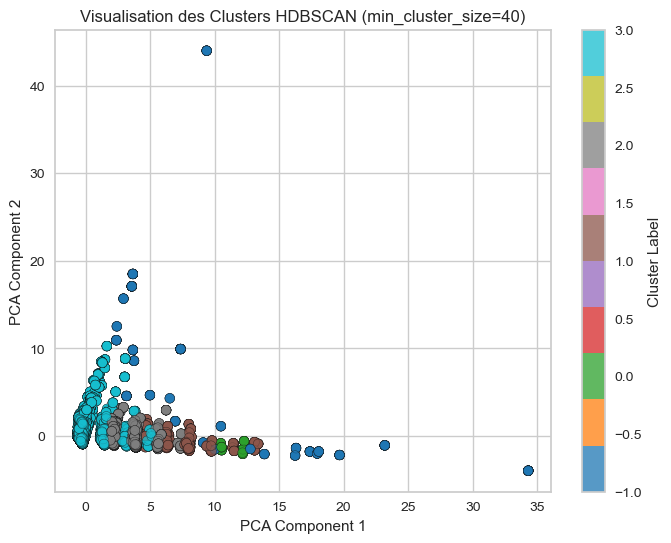

In [456]:
# Sélection de min_cluster_size = 40
min_cluster_size_categorie = 40

# Exécution de HDBSCAN avec min_cluster_size = 
hdbscan_cluster_categorie = hdbscan.HDBSCAN(
    min_cluster_size=min_cluster_size_categorie, 
    min_samples=min_cluster_size_categorie,  
    cluster_selection_epsilon=3.018,
    metric='euclidean'
)

labels_hd_categorie= hdbscan_cluster_categorie.fit_predict(df_categorie)

# Réduction de dimension avec PCA
pca_hd_categorie = PCA(n_components=2)
df_pca_hd_categorie= pca_hd_categorie.fit_transform(df_categorie)

# Visualisation des clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca_hd_categorie[:, 0], df_pca_hd_categorie[:, 1], c=labels_hd_categorie, cmap='tab10', alpha=0.75, edgecolors='k')

# Ajouter une barre de couleur
plt.colorbar(scatter, label="Cluster Label")

# Labels et titre
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"Visualisation des Clusters HDBSCAN (min_cluster_size={min_cluster_size_categorie})")

# Affichage
plt.show()

#### **Métriques**

In [458]:
# Filtre pour retirer les outliers 
mask = labels_hd_categorie != -1
X_no_noise8 = df_categorie[mask]
labels_no_noise8 = labels_hd_categorie[mask]

if len(set(labels_no_noise8)) > 1:
    silhouette = silhouette_score(X_no_noise8, labels_no_noise8)
    db_index = davies_bouldin_score(X_no_noise8, labels_no_noise8)
    ch_index = calinski_harabasz_score(X_no_noise8, labels_no_noise8)
    
    print(f"Silhouette Score (sans outliers): {silhouette:.4f}")
    print(f"Davies-Bouldin Index (sans outliers): {db_index:.4f}")
    print(f"Calinski-Harabasz Index (sans outliers): {ch_index:.4f}")
else:
    print("Nombre de clusters (sans outliers) insuffisant pour calculer les métriques.")

Silhouette Score (sans outliers): 0.5806
Davies-Bouldin Index (sans outliers): 0.9770
Calinski-Harabasz Index (sans outliers): 16581.0253


#### **Outliers**

In [460]:
# Nombre total de points
total_points_hd_categorie= len(labels_hd_categorie)

# Nombre de points classés comme outliers (-1)
outliers_count_hd_categorie= np.sum(labels_hd_categorie == -1)

# Pourcentage d'outliers
outliers_percentage_hd_categorie = (outliers_count_hd_categorie / total_points_hd_categorie) * 100

print(f"Nombre total de points : {total_points_hd_categorie}")
print(f"Nombre d'outliers : {outliers_count_hd_categorie}")
print(f"Pourcentage d'outliers : {outliers_percentage_hd_categorie:.2f}%")

Nombre total de points : 119143
Nombre d'outliers : 267
Pourcentage d'outliers : 0.22%


Le nombre d'outliers a augmenté en ajoutant la variable avg_review

#### **Moyenne**

In [463]:
df_clusters_hd_categorie = df_categorie.copy()
df_clusters_hd_categorie["Cluster"] = labels_hd_categorie

# Supprimer les outliers (-1) avant de calculer la moyenne
df_clusters_hd_categorie = df_clusters_hd_categorie[df_clusters_hd_categorie["Cluster"] != -1]

# Moyennes par cluster
cluster_means_hd_categorie = df_clusters_hd_categorie.groupby("Cluster").mean()

print(" Moyennes des features par cluster avec HDBSCAN:")
print(cluster_means_hd_categorie)

 Moyennes des features par cluster avec HDBSCAN:
          recency  frequency  monetary  avg_review  diversity_products
Cluster                                                               
0       -0.956512   5.764272  0.333285    0.373123           10.267512
1       -0.195548   3.917996  0.229883    0.006649            6.769725
2       -0.175595   1.692398  0.128100   -0.165769            3.271937
3        0.011840  -0.132261 -0.034265    0.009182           -0.225850


In [464]:
quantitative_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment', 'diversity_products', 'avg_installments']
target_features = ['recency', 'frequency', 'monetary', 'avg_review', 'diversity_products']

In [465]:
cluster_means_original_hd_categorie = inverse_transform_mean(
    cluster_means_hd_categorie,      # DataFrame des moyennes normalisées par cluster
    df_final,                        # DataFrame original non transformé
    quantitative_features,           # Variables standardisées
    target_features                  # Variables à inverser
)

print("Moyennes en échelle d'origine:")
print(cluster_means_original_hd_categorie)

Moyennes en échelle d'origine:
            recency  frequency    monetary  avg_review  diversity_products
Cluster                                                                   
0        141.040000   3.460000  940.028200    4.540000                 4.0
1        257.735849   2.701258  767.427752    4.033019                 3.0
2        260.795692   1.786630  597.529915    3.794495                 2.0
3        289.539313   1.036772  326.509024    4.036523                 1.0


In [466]:
display(df_clusters_hd_categorie['Cluster'].value_counts().sort_index())

Cluster
0        50
1       636
2      5849
3    112341
Name: count, dtype: int64

nombre d'observations par cluster mal répartis

- Cluster 0: Clients nouveaux, achètent fréquemment, dépenses beaucoup sont très satisfaits et achètent une grande variété de produits
- Cluster 1: Clients difficile à différencier
- Cluster 2: clients un peu moins satisfaits
- Cluster 3: difficile plus inactifs

#### Test moyenne

In [469]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_original_hd_categorie.index:
        for j in cluster_means_original_hd_categorie.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_hd_categorie[df_clusters_hd_categorie['Cluster'] == i][feature]
                group_2 = df_clusters_hd_categorie[df_clusters_hd_categorie['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_original_hd_categorie.loc[i, feature]
                mean_2 = cluster_means_original_hd_categorie.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=-1336.9529, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=-1525.7963, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=-1914.4837, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=-72.8587, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=-790.1623, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=-2261.0554, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=3.7431, p-value=0.0003
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=9.6050, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=13.9861, p-value=0.0000
T-test Frequency (Cluster 1 vs Cluster 2): t-stat=8.5630, p-value=0.0000
T-test Frequency (Cluster 1 vs Cluster 3): t-stat=15.8164, p-value=0.0000
T-test Frequency (Cluster 2 vs Cluster 3): t-stat=40.7849, p-value=0.0000
T-test Monetary (Cluster 0 vs Cluster 1): t-stat=3773.2044, p-value=0.0000
T-test Monetary (Cluster 0 vs Cluster

- T-test Avg_review (Cluster 1 vs Cluster 3): t-stat=-0.0957, p-value=0.9238

In [471]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_hd_categorie.index:
        for j in cluster_means_hd_categorie.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_hd_categorie[df_clusters_hd_categorie['Cluster'] == i][feature]
                group_2 = df_clusters_hd_categorie[df_clusters_hd_categorie['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_hd_categorie.loc[i, feature]
                mean_2 = cluster_means_hd_categorie.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")



T-test Recency (Cluster 0 vs Cluster 1): t-stat=-8.7182, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=-9.9496, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=-12.4842, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=-0.4751, p-value=0.6348
T-test Recency (Cluster 1 vs Cluster 3): t-stat=-5.1526, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=-14.7442, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=9.1082, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=23.3721, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=34.0330, p-value=0.0000
T-test Frequency (Cluster 1 vs Cluster 2): t-stat=20.8368, p-value=0.0000
T-test Frequency (Cluster 1 vs Cluster 3): t-stat=38.4866, p-value=0.0000
T-test Frequency (Cluster 2 vs Cluster 3): t-stat=99.2436, p-value=0.0000
T-test Monetary (Cluster 0 vs Cluster 1): t-stat=2.2605, p-value=0.0275
T-test Monetary (Cluster 0 vs Cluster 2): t-stat=4.

- T-test Recency (Cluster 1 vs Cluster 2): t-stat=-0.4751, p-value=0.6348
- T-test Avg_review (Cluster 1 vs Cluster 3): t-stat=-0.0692, p-value=0.9449

### 6. Test du modèle RFM + avg_review + avg_payments

In [474]:
df_paiement = df_final_encoded[['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment']]

#### **Choix du bon eps**

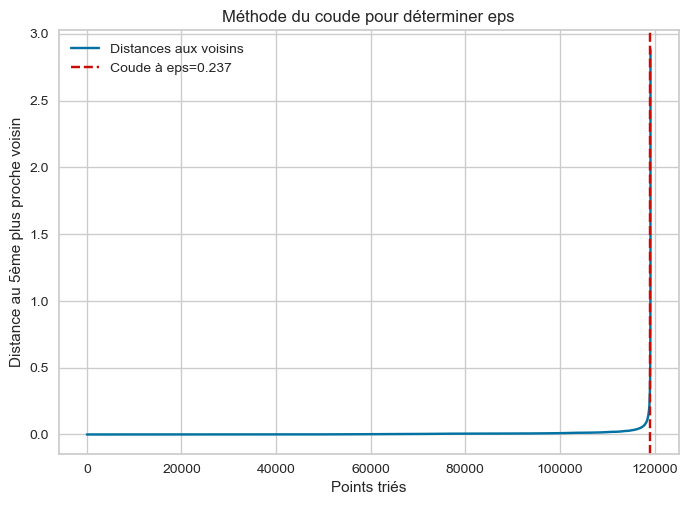

Pour k=2, eps recommandé = 0.237


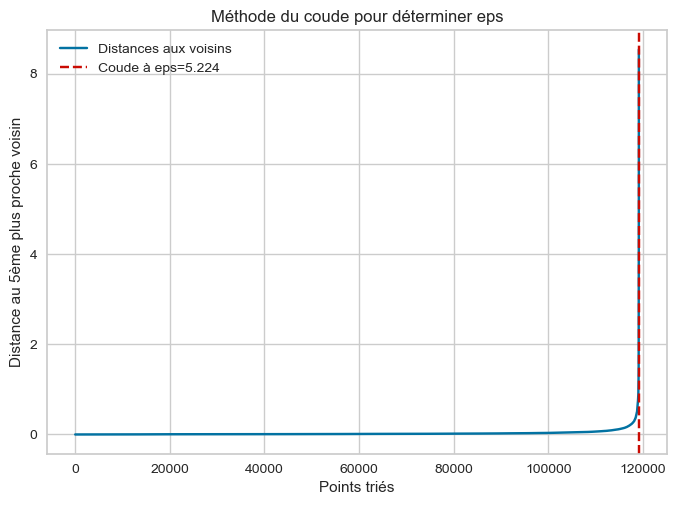

Pour k=4, eps recommandé = 5.224


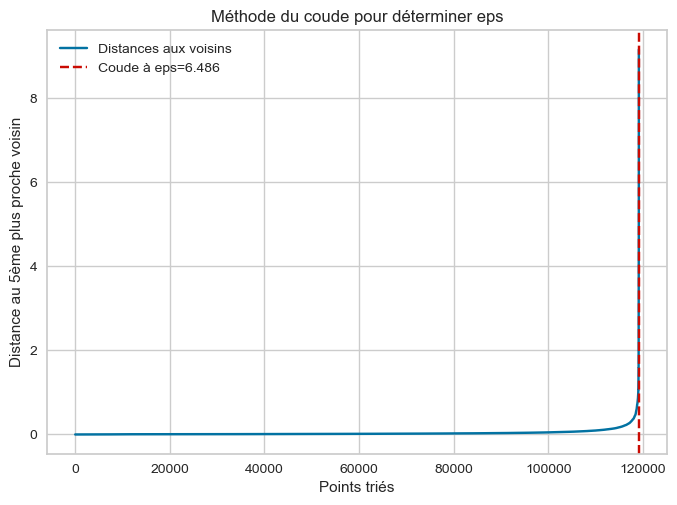

Pour k=5, eps recommandé = 6.486


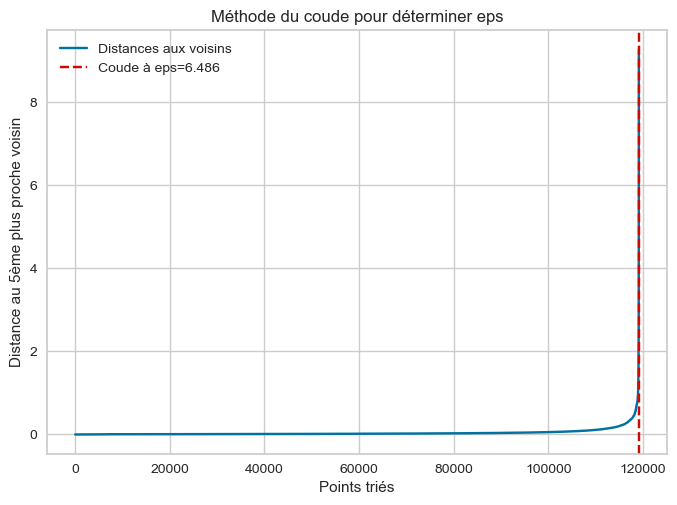

Pour k=6, eps recommandé = 6.486


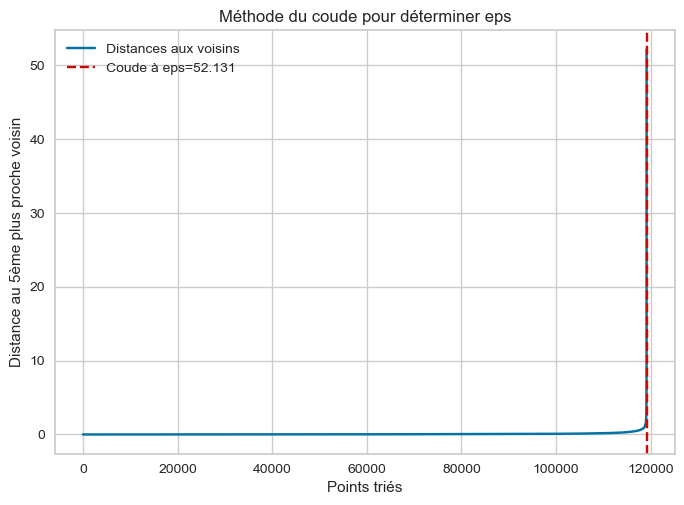

Pour k=10, eps recommandé = 52.131


In [476]:
#  Calcul des distances des k-plus proches voisins
for k in [2, 4, 5, 6, 10]:
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(df_paiement)
    distances, indices = neigh.kneighbors(df_paiement)
    sorted_distances = np.sort(distances[:, -1])  # On prend la plus grande distance de chaque point: dernière colonne = distance au k-ième voisin
    
    kneedle = KneeLocator(range(len(sorted_distances)), sorted_distances, curve="convex", direction="increasing")
    eps_value = sorted_distances[kneedle.knee]  # Valeur optimale de eps
    
    plt.plot(sorted_distances, label="Distances aux voisins")
    plt.axvline(x=kneedle.knee, color='r', linestyle='--', label=f"Coude à eps={eps_value:.3f}")
    plt.xlabel("Points triés")
    plt.ylabel("Distance au 5ème plus proche voisin")
    plt.title("Méthode du coude pour déterminer eps")
    plt.legend()  
    plt.show()
    print(f"Pour k={k}, eps recommandé = {eps_value:.3f}")

Ici nous testerons eps = 6.486

#### **Sous-échantillon**:
Je crée un sous échantillon ( par exemple 20% de la df) et regarde si les statistiques descriptives sont proches afin que la df_sampled soit bien représentative de ma df initiale. 

In [479]:
df_sampled_paiement= df_paiement.sample(frac=0.2, random_state=42)  # 20% des données

print("Avant échantillonnage :")
print(df_paiement.describe())

print("\nAprès échantillonnage :")
print(df_sampled_paiement.describe())

Avant échantillonnage :
            recency     frequency      monetary    avg_review   avg_payment
count  1.191430e+05  1.191430e+05  1.191430e+05  1.191430e+05  1.191430e+05
mean   1.252990e-16  5.325656e-17  4.508618e-17 -3.077311e-17 -5.892215e-17
std    1.000004e+00  1.000004e+00  1.000004e+00  1.000004e+00  1.000004e+00
min   -1.876222e+00 -2.217399e-01 -2.298710e-01 -2.185781e+00 -6.500135e-01
25%   -8.133127e-01 -2.217399e-01 -1.875038e-01 -3.786455e-01 -4.167023e-01
50%   -1.286165e-01 -2.217399e-01 -1.488928e-01  7.056356e-01 -2.405524e-01
75%    7.125815e-01 -2.217399e-01 -6.021035e-02  7.056356e-01  6.032504e-02
max    3.157925e+00  3.871167e+01  6.525761e+01  7.056356e-01  5.076907e+01

Après échantillonnage :
            recency     frequency      monetary    avg_review   avg_payment
count  23829.000000  23829.000000  23829.000000  23829.000000  23829.000000
mean       0.007873      0.000262     -0.003812     -0.007945     -0.005841
std        1.000181      1.001171      

- Les moyennes après échantillonnage sont proches de zéro, comme avant échantillonnage.
- Les écarts-types restent proches de 1 pour toutes les variables, ce qui signifie que la dispersion des données est conservée.
- monetary et avg_payment ont un écart-type légèrement inférieur après échantillonnage (0.937 contre 1 et 0.955 contre 1). Cela indique une légère réduction de la variabilité, mais elle reste raisonnable.
- Les médianes (50%), 1er (25%) et 3e (75%) quartiles sont quasiment identiques avant et après échantillonnage.
- Les min et max sont également proches, bien que avg_review et avg_payment semblent avoir subi une légère réduction du maximum.

In [481]:
for min_samples in [2, 4, 6, 11]:
    dbscan = DBSCAN(eps= 6.486, min_samples=min_samples)
    labels = dbscan.fit_predict(df_sampled_paiement)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Ne pas compter les outliers (-1 car on souhaite garder seulement les Clusters 
    print(f"min_samples = {min_samples} => {n_clusters} clusters détectés")

min_samples = 2 => 4 clusters détectés
min_samples = 4 => 3 clusters détectés
min_samples = 6 => 2 clusters détectés
min_samples = 11 => 1 clusters détectés


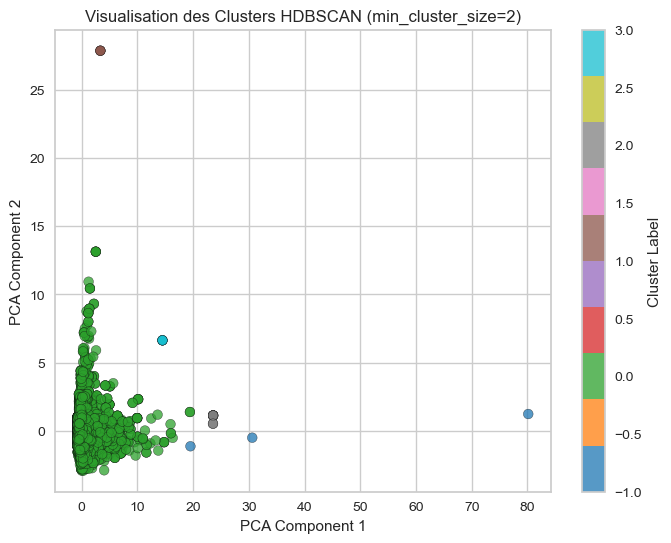

In [482]:
# Sélection de min_samples  = 2
min_samples_optimal_paiement = 2

dbscan_cluster = DBSCAN(eps=6.486 , min_samples=min_samples_optimal_paiement)

labels_db_paiement= dbscan_cluster.fit_predict(df_sampled_paiement)

# Réduction de dimension avec PCA
pca_db_paiement= PCA(n_components=2)
df_pca_db_paiement = pca_db_paiement.fit_transform(df_sampled_paiement)

# Visualisation des clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca_db_paiement[:, 0], df_pca_db_paiement[:, 1], c=labels_db_paiement, cmap='tab10', alpha=0.75, edgecolors='k')

# Ajouter une barre de couleur
plt.colorbar(scatter, label="Cluster Label")

# Labels et titre
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"Visualisation des Clusters HDBSCAN (min_cluster_size={min_samples_optimal_paiement})")

# Affichage
plt.show()

#### **Métriques**

In [484]:
# Filtre pour retirer les outliers 
mask = labels_db_paiement != -1
X_no_noise9 = df_sampled_paiement[mask]
labels_no_noise9 = labels_db_paiement[mask]

if len(set(labels_no_noise9)) > 1:
    silhouette = silhouette_score(X_no_noise9, labels_no_noise9)
    db_index = davies_bouldin_score(X_no_noise9, labels_no_noise9)
    ch_index = calinski_harabasz_score(X_no_noise9, labels_no_noise9)
    
    print(f"Silhouette Score (sans outliers): {silhouette:.4f}")
    print(f"Davies-Bouldin Index (sans outliers): {db_index:.4f}")
    print(f"Calinski-Harabasz Index (sans outliers): {ch_index:.4f}")
else:
    print("Nombre de clusters (sans outliers) insuffisant pour calculer les métriques.")

Silhouette Score (sans outliers): 0.8734
Davies-Bouldin Index (sans outliers): 0.0817
Calinski-Harabasz Index (sans outliers): 1094.9603


#### **Vérification outliers**

In [486]:
# Nombre total de points
total_points_db_paiement = len(labels_db_paiement)

# Nombre de points classés comme outliers (-1)
outliers_count_db_paiement= np.sum(labels_db_paiement == -1)

# Pourcentage d'outliers
outliers_percentage_db_paiement = (outliers_count_db_paiement / total_points_db_paiement) * 100

print(f"Nombre total de points : {total_points_db_paiement}")
print(f"Nombre d'outliers : {outliers_count_db_paiement}")
print(f"Pourcentage d'outliers : {outliers_percentage_db_paiement:.2f}%")

Nombre total de points : 23829
Nombre d'outliers : 3
Pourcentage d'outliers : 0.01%


#### **Moyenne**

In [488]:
df_clusters_db_paiement = df_sampled_paiement.copy()
df_clusters_db_paiement["Cluster"] = labels_db_paiement

# Supprimer les outliers (-1) avant de calculer la moyenne
df_clusters_db_paiement = df_clusters_db_paiement[df_clusters_db_paiement["Cluster"] != -1]

# Moyennes par cluster
cluster_means_db_paiement= df_clusters_db_paiement.groupby("Cluster").mean()

print(" Moyennes des features par cluster avec DBSCAN:")
print(cluster_means_db_paiement)

 Moyennes des features par cluster avec DBSCAN:
          recency  frequency   monetary  avg_review  avg_payment
Cluster                                                         
0        0.007987  -0.005693  -0.020538   -0.007885    -0.013472
1       -1.504530  38.711674   0.325858    0.535552    -0.444675
2        0.590858  -0.221740  26.721467    0.063099     7.814584
3       -1.426279   7.078275  16.505824   -0.017218     3.730132


In [489]:
quantitative_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment', 'diversity_products', 'avg_installments']
target_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment']

In [490]:
cluster_means_original_paiement = inverse_transform_mean(
    cluster_means_db_paiement,  # DataFrame des moyennes normalisées par cluster
    df_final,                    # DataFrame original non transformé
    quantitative_features,       # Variables standardisées
    target_features              # Variables à inverser
)

print("Moyennes en échelle d'origine:")
print(cluster_means_original_paiement)

Moyennes en échelle d'origine:
            recency  frequency      monetary  avg_review  avg_payment
Cluster                                                              
0        288.948593   1.088786    349.421759    4.012911   169.154289
1         57.000000  17.000000    927.630000    4.764706    54.566471
2        378.333333   1.000000  44987.555556    4.111111  2249.377778
3         69.000000   4.000000  27935.460000    4.000000  1163.977500


In [491]:
display(df_clusters_db_paiement['Cluster'].value_counts().sort_index())

Cluster
0    23810
1        3
2        9
3        4
Name: count, dtype: int64

- Cluster 0:  clients qui dépensent le moins
- Cluster 1: Clients nouveaux et achètent fréquemment, très satisfaits
- Cluster 2: Clients inactifs, qui dépensent beaucoup
- Cluster 3: difficile de différencier. 

#### Test moyenne

In [494]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_original_paiement.index:
        for j in cluster_means_original_paiement.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_db_paiement[df_clusters_db_paiement['Cluster'] == i][feature]
                group_2 = df_clusters_db_paiement[df_clusters_db_paiement['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_original_paiement.loc[i, feature]
                mean_2 = cluster_means_original_paiement.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=35787.2331, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=-509.2499, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=33935.7590, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=-1831.9753, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=-inf, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=1763.5613, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=-2735.0047, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=15.2616, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=-500.4133, p-value=0.0000
T-test Frequency (Cluster 1 vs Cluster 2): t-stat=1630477228166597888.0000, p-value=0.0000
T-test Frequency (Cluster 1 vs Cluster 3): t-stat=inf, p-value=0.0000
T-test Frequency (Cluster 2 vs Cluster 3): t-stat=-305714480281237120.0000, p-value=0.0000
T-test Monetary (Cluster 0 vs Cluster 1): t-stat=-147754.9383, p-value=0.0000
T

- T-test Avg_review (Cluster 0 vs Cluster 2): t-stat=-0.2310, p-value=0.8231
- T-test Avg_review (Cluster 1 vs Cluster 2): t-stat=1.5379, p-value=0.1626
- T-test Avg_review (Cluster 2 vs Cluster 3): t-stat=0.2614, p-value=0.8004

In [496]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_db_paiement.index:
        for j in cluster_means_db_paiement.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_db_paiement[df_clusters_db_paiement['Cluster'] == i][feature]
                group_2 = df_clusters_db_paiement[df_clusters_db_paiement['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_db_paiement.loc[i, feature]
                mean_2 = cluster_means_db_paiement.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")



T-test Recency (Cluster 0 vs Cluster 1): t-stat=233.3655, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=-3.3208, p-value=0.0105
T-test Recency (Cluster 0 vs Cluster 3): t-stat=221.2922, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=-11.9462, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=-inf, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=11.5000, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=-6655.1918, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=37.1367, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=-1217.6749, p-value=0.0000
T-test Frequency (Cluster 1 vs Cluster 2): t-stat=3967502757308171264.0000, p-value=0.0000
T-test Frequency (Cluster 1 vs Cluster 3): t-stat=inf, p-value=0.0000
T-test Frequency (Cluster 2 vs Cluster 3): t-stat=-743906766995282048.0000, p-value=0.0000
T-test Monetary (Cluster 0 vs Cluster 1): t-stat=-88.5177, p-value=0.0000
T-test Monetar

- T-test Avg_review (Cluster 0 vs Cluster 2): t-stat=-0.1670, p-value=0.8715
- T-test Avg_review (Cluster 0 vs Cluster 3): t-stat=1.4336, p-value=0.1517
- T-test Avg_review (Cluster 1 vs Cluster 2): t-stat=1.1117, p-value=0.2986
- T-test Avg_review (Cluster 2 vs Cluster 3): t-stat=0.1890, p-value=0.8548

### **HDBSCAN :**
- cluster_selection_epsilon joue un rôle similaire à epsilon :
Il définit un seuil de distance au-delà duquel deux clusters ne fusionneront pas. Mais contrairement à DBSCAN, HDBSCAN peut avoir un eps adaptatif qui évolue selon la densité locale.

- Sans cluster_selection_epsilon :
HDBSCAN détecte des clusters de tailles très variées.
Certains petits clusters peuvent apparaître si les points sont densément connectés.
- Avec cluster_selection_epsilon :
forces une séparation des clusters qui dépasse une certaine distance.
Cela évite d'avoir trop de petits clusters et stabilise leur nombre.


Ici les paramètres à ajuster:
- min_cluster_size = Plus il est grand, plus les petits clusters sont ignorés. Essaye 5, 10, 20, 50.
- min_samples = Définit la sensibilité aux outliers (en général, même valeur que min_cluster_size).
- cluster_selection_method = 'eom' (par défaut) détecte les clusters de manière optimale, 'leaf' garde plus de petits clusters.
- cluster_selection_epsilon

In [499]:
#Ajout du paramètres cluster_selection_epsilon: 

for min_cluster_size in [4, 6, 10, 20]:
    hdbscan_cluster = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size, 
        min_samples=min_cluster_size,  # Garde la cohérence
        cluster_selection_epsilon = 6.486,
        metric='euclidean'
    )
    
    labels = hdbscan_cluster.fit_predict(df_paiement)
    
    # Compter les clusters détectés (on exclut les outliers -1)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"min_cluster_size = {min_cluster_size} => {n_clusters} clusters détectés")

min_cluster_size = 4 => 5 clusters détectés
min_cluster_size = 6 => 5 clusters détectés
min_cluster_size = 10 => 3 clusters détectés
min_cluster_size = 20 => 2 clusters détectés


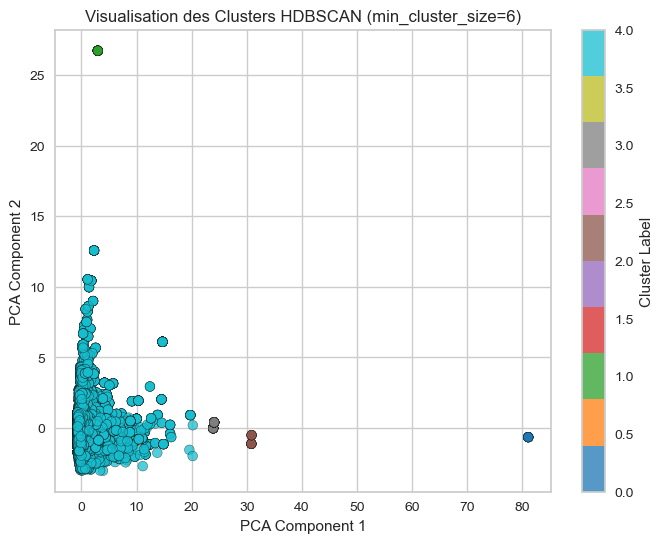

In [500]:
# Sélection de min_cluster_size = 6
min_cluster_size_paiement = 6

# Exécution de HDBSCAN avec min_cluster_size = 
hdbscan_cluster_paiement = hdbscan.HDBSCAN(
    min_cluster_size=min_cluster_size_paiement, 
    min_samples=min_cluster_size_paiement,  
    cluster_selection_epsilon=6.486,
    metric='euclidean'
)

labels_hd_paiement= hdbscan_cluster_paiement.fit_predict(df_paiement)

# Réduction de dimension avec PCA
pca_hd_paiement = PCA(n_components=2)
df_pca_hd_paiement= pca_hd_paiement.fit_transform(df_paiement)

# Visualisation des clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca_hd_paiement[:, 0], df_pca_hd_paiement[:, 1], c=labels_hd_paiement, cmap='tab10', alpha=0.75, edgecolors='k')

# Ajouter une barre de couleur
plt.colorbar(scatter, label="Cluster Label")

# Labels et titre
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"Visualisation des Clusters HDBSCAN (min_cluster_size={min_cluster_size_paiement})")

# Affichage
plt.show()

#### **Métriques**

In [502]:
# Filtre pour retirer les outliers 
mask = labels_hd_paiement != -1
X_no_noise10 = df_paiement[mask]
labels_no_noise10 = labels_hd_paiement[mask]

if len(set(labels_no_noise10)) > 1:
    silhouette = silhouette_score(X_no_noise10, labels_no_noise10)
    db_index = davies_bouldin_score(X_no_noise10, labels_no_noise10)
    ch_index = calinski_harabasz_score(X_no_noise10, labels_no_noise10)
    
    print(f"Silhouette Score (sans outliers): {silhouette:.4f}")
    print(f"Davies-Bouldin Index (sans outliers): {db_index:.4f}")
    print(f"Calinski-Harabasz Index (sans outliers): {ch_index:.4f}")
else:
    print("Nombre de clusters (sans outliers) insuffisant pour calculer les métriques.")

Silhouette Score (sans outliers): 0.9153
Davies-Bouldin Index (sans outliers): 0.1616
Calinski-Harabasz Index (sans outliers): 7562.2320


#### **Outliers**

In [504]:
# Nombre total de points
total_points_hd_paiement= len(labels_hd_paiement)

# Nombre de points classés comme outliers (-1)
outliers_count_hd_paiement= np.sum(labels_hd_paiement == -1)

# Pourcentage d'outliers
outliers_percentage_hd_paiement = (outliers_count_hd_paiement / total_points_hd_paiement) * 100

print(f"Nombre total de points : {total_points_hd_paiement}")
print(f"Nombre d'outliers : {outliers_count_hd_paiement}")
print(f"Pourcentage d'outliers : {outliers_percentage_hd_paiement:.2f}%")

Nombre total de points : 119143
Nombre d'outliers : 0
Pourcentage d'outliers : 0.00%


#### **Moyenne**

In [506]:
df_clusters_hd_paiement = df_paiement.copy()
df_clusters_hd_paiement["Cluster"] = labels_hd_paiement

# Supprimer les outliers (-1) avant de calculer la moyenne
df_clusters_hd_paiement = df_clusters_hd_paiement[df_clusters_hd_paiement["Cluster"] != -1]

# Moyennes par cluster
cluster_means_hd_paiement = df_clusters_hd_paiement.groupby("Cluster").mean()

print(" Moyennes des features par cluster avec HDBSCAN:")
print(cluster_means_hd_paiement)

 Moyennes des features par cluster avec HDBSCAN:
          recency  frequency   monetary  avg_review  avg_payment
Cluster                                                         
0        0.614768  -0.221740  65.257615   -2.185781    50.769069
1       -1.504530  38.711674   0.325858    0.535552    -0.444675
2       -0.358153  -0.221740  19.859433   -2.185781    24.031589
3        0.259378  -0.221740  26.520441   -0.740073     7.751448
4        0.000116  -0.005419  -0.015008    0.000503    -0.007970


In [507]:
quantitative_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment', 'diversity_products', 'avg_installments']
target_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment']

In [508]:
cluster_means_original_hd_paiement = inverse_transform_mean(
    cluster_means_hd_paiement,       # DataFrame des moyennes normalisées par cluster
    df_final,                        # DataFrame original non transformé
    quantitative_features,           # Variables standardisées
    target_features                  # Variables à inverser
)

print("Moyennes en échelle d'origine:")
print(cluster_means_original_hd_paiement)

Moyennes en échelle d'origine:
            recency  frequency       monetary  avg_review   avg_payment
Cluster                                                                
0        382.000000   1.000000  109312.640000    1.000000  13664.080000
1         57.000000  17.000000     927.630000    4.764706     54.566471
2        232.800000   1.000000   33533.352000    1.000000   6558.876000
3        327.500000   1.000000   44652.000000    3.000000   2232.600000
4        287.741551   1.088899     358.651844    4.024515    170.616323


In [509]:
display(df_clusters_hd_paiement['Cluster'].value_counts().sort_index())

Cluster
0         8
1        17
2        10
3        40
4    119068
Name: count, dtype: int64

- Cluster 0: Clients dépensent beaucoup inactifs
- Cluster 1: nouveaux clients, achètent fréquemment très satisfaits
- Cluster 2: clients insatisfaits
- Cluster 3: difficile à différencier
- Cluster 4: Clients dépensant peu

#### Test moyenne

In [512]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_original_hd_paiement.index:
        for j in cluster_means_original_hd_paiement.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_hd_paiement[df_clusters_hd_paiement['Cluster'] == i][feature]
                group_2 = df_clusters_hd_paiement[df_clusters_hd_paiement['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_original_hd_paiement.loc[i, feature]
                mean_2 = cluster_means_original_hd_paiement.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=2927339757790822400.0000, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=601.3398, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=570.4258, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=32523.5718, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=-708.5492, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=-2831.1959, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=-79616.6230, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=-356.1855, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 4): t-stat=-221.4229, p-value=0.0000
T-test Recency (Cluster 3 vs Cluster 4): t-stat=415.9416, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=-1525171791184062720.0000, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=0.0000, p-value=1.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=0.0000, p-value=1.0000
T-test

- T-test Frequency (Cluster 0 vs Cluster 2): t-stat=0.0000, p-value=1.0000- 
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=0.0000, p-value=1.000
- T-test Frequency (Cluster 2 vs Cluster 3): t-stat=0.0000, p-value=1.0000
- T-test Avg_review (Cluster 0 vs Cluster 2): t-stat=nan, p-value=nan0

In [514]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_hd_paiement.index:
        for j in cluster_means_hd_paiement.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_hd_paiement[df_clusters_hd_paiement['Cluster'] == i][feature]
                group_2 = df_clusters_hd_paiement[df_clusters_hd_paiement['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_hd_paiement.loc[i, feature]
                mean_2 = cluster_means_hd_paiement.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")



T-test Recency (Cluster 0 vs Cluster 1): t-stat=19088934867571884.0000, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=3.9213, p-value=0.0035
T-test Recency (Cluster 0 vs Cluster 3): t-stat=3.7197, p-value=0.0006
T-test Recency (Cluster 0 vs Cluster 4): t-stat=212.0835, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=-4.6204, p-value=0.0013
T-test Recency (Cluster 1 vs Cluster 3): t-stat=-18.4620, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=-519.1733, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=-2.3227, p-value=0.0389
T-test Recency (Cluster 2 vs Cluster 4): t-stat=-1.4439, p-value=0.1827
T-test Recency (Cluster 3 vs Cluster 4): t-stat=2.7123, p-value=0.0099
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=-3711258999732023808.0000, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=0.0000, p-value=1.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=0.0000, p-value=1.0000
T-test Frequency (Cluster 

- T-test Recency (Cluster 2 vs Cluster 4): t-stat=-1.4439, p-value=0.1827
- T-test Frequency (Cluster 0 vs Cluster 2): t-stat=0.0000, p-value=1.0000- 
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=0.0000, p-value=1.000
- T-test Frequency (Cluster 2 vs Cluster 3): t-stat=0.0000, p-value=1.00000
- T-test Avg_review (Cluster 0 vs Cluster 2): t-stat=nan, p-value=nan

### 7. Test du modèle RFM + avg_review + avg_installments

In [517]:
df_installments = df_final_encoded[['recency', 
                                    'frequency', 
                                    'monetary',
                                    'avg_review',
                                    'avg_installments']]

#### **Choix du bon eps**

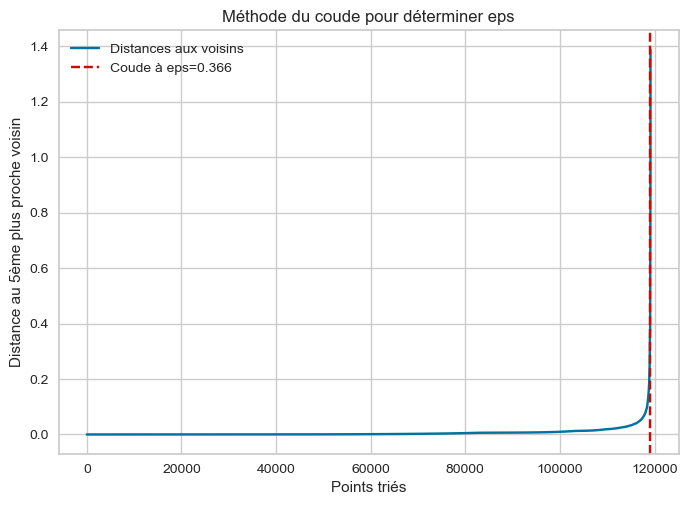

Pour k=2, eps recommandé = 0.366


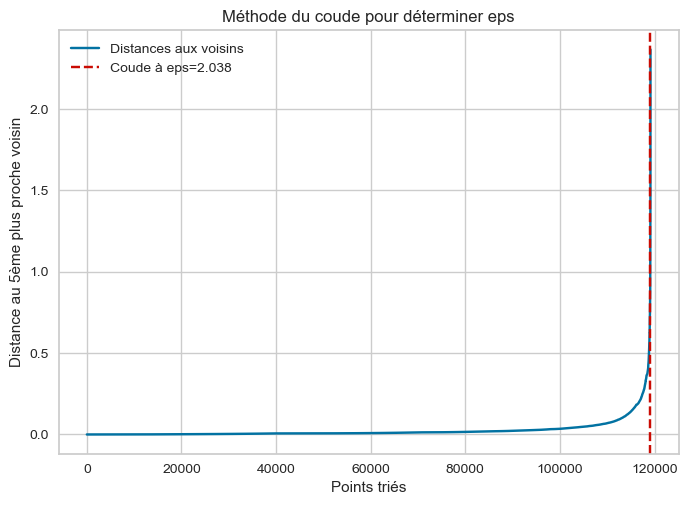

Pour k=4, eps recommandé = 2.038


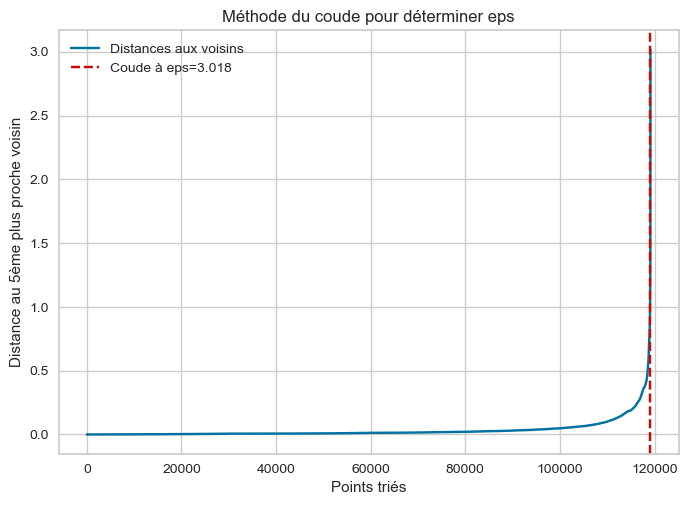

Pour k=5, eps recommandé = 3.018


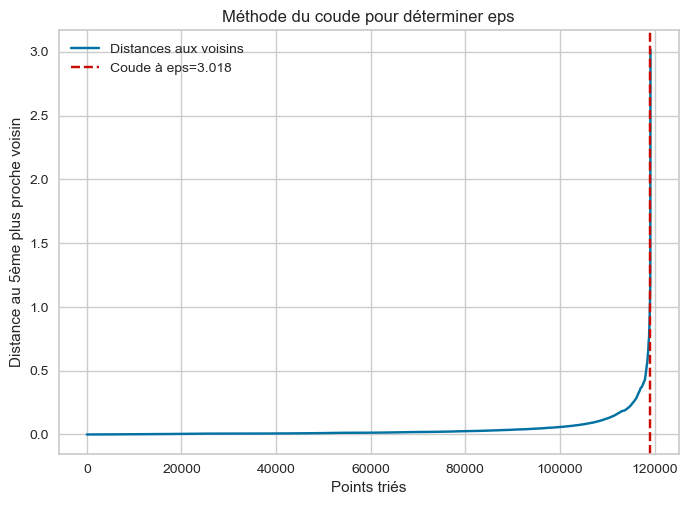

Pour k=6, eps recommandé = 3.018


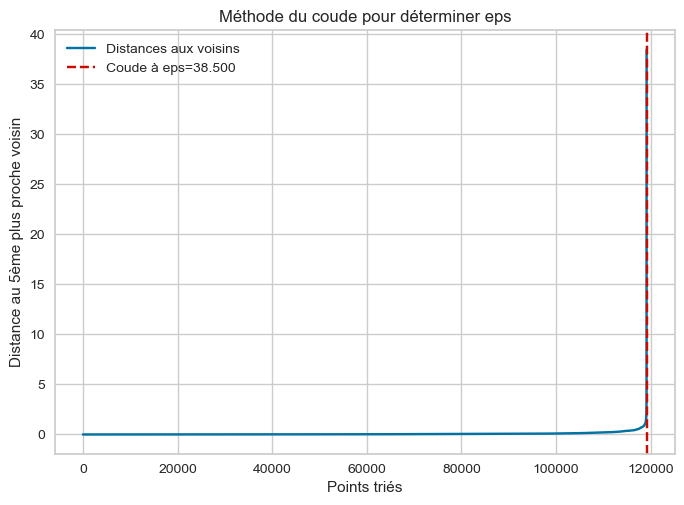

Pour k=10, eps recommandé = 38.500


In [519]:
#  Calcul des distances des k-plus proches voisins
for k in [2, 4, 5, 6, 10]:
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(df_installments)
    distances, indices = neigh.kneighbors(df_installments)
    sorted_distances = np.sort(distances[:, -1])  # On prend la plus grande distance de chaque point: dernière colonne = distance au k-ième voisin
    
    kneedle = KneeLocator(range(len(sorted_distances)), sorted_distances, curve="convex", direction="increasing")
    eps_value = sorted_distances[kneedle.knee]  # Valeur optimale de eps
    
    plt.plot(sorted_distances, label="Distances aux voisins")
    plt.axvline(x=kneedle.knee, color='r', linestyle='--', label=f"Coude à eps={eps_value:.3f}")
    plt.xlabel("Points triés")
    plt.ylabel("Distance au 5ème plus proche voisin")
    plt.title("Méthode du coude pour déterminer eps")
    plt.legend()
    plt.show()
    print(f"Pour k={k}, eps recommandé = {eps_value:.3f}")

Ici nous testerons eps = 3.018 

#### **Sous-échantillon**:
Je crée un sous échantillon ( par exemple 20% de la df) et regarde si les statistiques descriptives sont proches afin que la df_sampled soit bien représentative de ma df initiale. 

In [522]:
df_sampled_installments= df_installments.sample(frac=0.2, random_state=42)  # 20% des données

print("Avant échantillonnage :")
print(df_installments.describe())

print("\nAprès échantillonnage :")
print(df_sampled_installments.describe())

Avant échantillonnage :
            recency     frequency      monetary    avg_review  \
count  1.191430e+05  1.191430e+05  1.191430e+05  1.191430e+05   
mean   1.252990e-16  5.325656e-17  4.508618e-17 -3.077311e-17   
std    1.000004e+00  1.000004e+00  1.000004e+00  1.000004e+00   
min   -1.876222e+00 -2.217399e-01 -2.298710e-01 -2.185781e+00   
25%   -8.133127e-01 -2.217399e-01 -1.875038e-01 -3.786455e-01   
50%   -1.286165e-01 -2.217399e-01 -1.488928e-01  7.056356e-01   
75%    7.125815e-01 -2.217399e-01 -6.021035e-02  7.056356e-01   
max    3.157925e+00  3.871167e+01  6.525761e+01  7.056356e-01   

       avg_installments  
count      1.191430e+05  
mean      -4.914155e-17  
std        1.000004e+00  
min       -1.074811e+00  
25%       -7.093748e-01  
50%       -3.439384e-01  
75%        3.869345e-01  
max        7.695663e+00  

Après échantillonnage :
            recency     frequency      monetary    avg_review  \
count  23829.000000  23829.000000  23829.000000  23829.000000   
m

- Les moyennes des variables après échantillonnage sont très proches de celles avant échantillonnage (proches de 0).
- Les écarts-types sont également proches de 1, ce qui indique que la dispersion des données est bien conservée.
- monetary a un écart-type légèrement plus bas (0.937 contre 1), ce qui suggère une légère réduction de la variabilité.
- Les valeurs des quartiles restent globalement similaires avant et après échantillonnage.
- Pour avg_installments, les valeurs de min, max et quartiles sont identiques, ce qui indique que la distribution est bien conservée.

In [524]:
for min_samples in [2, 4, 5, 6, 11]:
    dbscan = DBSCAN(eps= 3.018, min_samples=min_samples)
    labels = dbscan.fit_predict(df_sampled_installments)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Ne pas compter les outliers (-1 car on souhaite garder seulement les Clusters 
    print(f"min_samples = {min_samples} => {n_clusters} clusters détectés")

min_samples = 2 => 9 clusters détectés
min_samples = 4 => 6 clusters détectés
min_samples = 5 => 2 clusters détectés
min_samples = 6 => 2 clusters détectés
min_samples = 11 => 1 clusters détectés


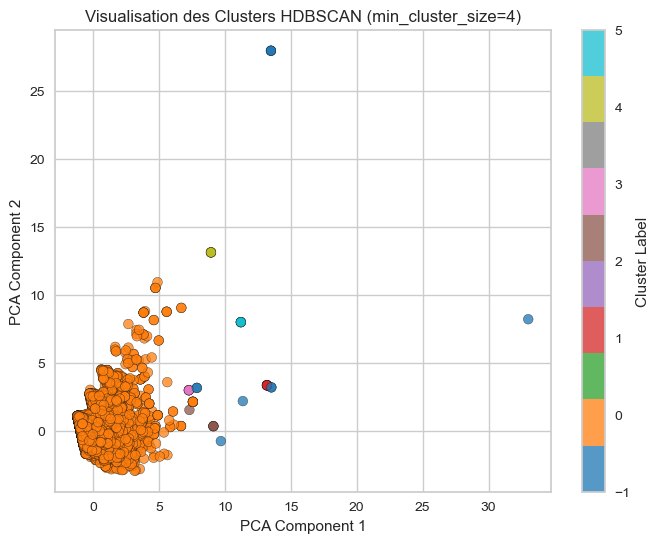

In [525]:
# Sélection de min_samples  = 4
min_samples_optimal_installments =4 

dbscan_cluster = DBSCAN(eps= 3.018, min_samples=min_samples_optimal_installments)

labels_db_installments= dbscan_cluster.fit_predict(df_sampled_installments)

# Réduction de dimension avec PCA
pca_db_installments= PCA(n_components=2)
df_pca_db_installments = pca_db_installments.fit_transform(df_sampled_installments)

# Visualisation des clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca_db_installments[:, 0], df_pca_db_installments[:, 1], c=labels_db_installments, cmap='tab10', alpha=0.75, edgecolors='k')

# Ajouter une barre de couleur
plt.colorbar(scatter, label="Cluster Label")

# Labels et titre
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"Visualisation des Clusters HDBSCAN (min_cluster_size={min_samples_optimal_installments})")

# Affichage
plt.show()

#### **Métriques**

In [527]:
# Filtre pour retirer les outliers 
mask = labels_db_installments != -1
X_no_noise11 = df_sampled_installments[mask]
labels_no_noise11 = labels_db_installments[mask]

if len(set(labels_no_noise11)) > 1:
    silhouette = silhouette_score(X_no_noise11, labels_no_noise11)
    db_index = davies_bouldin_score(X_no_noise11, labels_no_noise11)
    ch_index = calinski_harabasz_score(X_no_noise11, labels_no_noise11)
    
    print(f"Silhouette Score (sans outliers): {silhouette:.4f}")
    print(f"Davies-Bouldin Index (sans outliers): {db_index:.4f}")
    print(f"Calinski-Harabasz Index (sans outliers): {ch_index:.4f}")
else:
    print("Nombre de clusters (sans outliers) insuffisant pour calculer les métriques.")

Silhouette Score (sans outliers): 0.7891
Davies-Bouldin Index (sans outliers): 0.1726
Calinski-Harabasz Index (sans outliers): 454.7182


#### **Vérification outliers**

In [529]:
# Nombre total de points
total_points_db_installments = len(labels_db_installments)

# Nombre de points classés comme outliers (-1)
outliers_count_db_installments= np.sum(labels_db_installments == -1)

# Pourcentage d'outliers
outliers_percentage_db_installments = (outliers_count_db_installments / total_points_db_installments) * 100

print(f"Nombre total de points : {total_points_db_installments}")
print(f"Nombre d'outliers : {outliers_count_db_installments}")
print(f"Pourcentage d'outliers : {outliers_percentage_db_installments:.2f}%")

Nombre total de points : 23829
Nombre d'outliers : 10
Pourcentage d'outliers : 0.04%


#### **Moyenne**

In [531]:
df_clusters_db_installments = df_sampled_installments.copy()
df_clusters_db_installments["Cluster"] = labels_db_installments

# Supprimer les outliers (-1) avant de calculer la moyenne
df_clusters_db_installments = df_clusters_db_installments[df_clusters_db_installments["Cluster"] != -1]

# Moyennes par cluster
cluster_means_db_installments= df_clusters_db_installments.groupby("Cluster").mean()

print(" Moyennes des features par cluster avec DBSCAN:")
print(cluster_means_db_installments)

 Moyennes des features par cluster avec DBSCAN:
          recency  frequency   monetary  avg_review  avg_installments
Cluster                                                              
0        0.008092  -0.009247  -0.026451   -0.007472         -0.004688
1        0.856042  -0.221740  26.882288    0.705636          0.386935
2        0.200690  -0.221740  12.724854   -1.824354          2.579553
3        0.230034   2.211598  11.357773    0.705636          2.031399
4       -0.369890  19.244967   0.946479   -0.998235          1.692065
5       -1.426279   7.078275  16.505824   -0.017218          1.117807


In [532]:
quantitative_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment', 'diversity_products', 'avg_installments']
target_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_installments']

In [533]:
cluster_means_original_installments = inverse_transform_mean(
    cluster_means_db_installments,   # DataFrame des moyennes normalisées par cluster
    df_final,                        # DataFrame original non transformé
    quantitative_features,           # Variables standardisées
    target_features                  # Variables à inverser
)

print("Moyennes en échelle d'origine:")
print(cluster_means_original_installments)

Moyennes en échelle d'origine:
          recency  frequency      monetary  avg_review  avg_installments
Cluster                                                                 
0        288.9647   1.087326    339.551418    4.013483          2.928344
1        419.0000   1.000000  45256.000000    5.000000          4.000000
2        318.5000   1.000000  21624.210000    1.500000         10.000000
3        323.0000   2.000000  19342.260000    5.000000          8.500000
4        231.0000   9.000000   1963.580000    2.642857          7.571429
5         69.0000   4.000000  27935.460000    4.000000          6.000000


In [534]:
display(df_clusters_db_installments['Cluster'].value_counts().sort_index())

Cluster
0    23796
1        7
2        4
3        4
4        4
5        4
Name: count, dtype: int64

- Cluster 0: dépensent le moins
- Cluster 1: dépensent le plus et très satisfaits
- Cluster 2: le plus d'échelonnages de paiement
- Cluster 3: difficile à différencier
- Cluster 4: achètent le plus fréquemment
- Cluster 5: nouveaux clients

#### Test moyenne

In [537]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_original_installments.index:
        for j in cluster_means_original_installments.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_db_installments[df_clusters_db_installments['Cluster'] == i][feature]
                group_2 = df_clusters_db_installments[df_clusters_db_installments['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_original_installments.loc[i, feature]
                mean_2 = cluster_means_original_installments.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=-20052.0270, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=-74.8546, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=-5248.3960, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=8938.4169, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 5): t-stat=33919.5441, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=254.7429, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=1059026024913232512.0000, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=2073925965455080192.0000, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 5): t-stat=3861032382496160256.0000, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=-11.4064, p-value=0.0014
T-test Recency (Cluster 2 vs Cluster 4): t-stat=221.7911, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 5): t-stat=632.4215, p-value=0.0000
T-test Recency (Cluster 3 vs Cluster 4): t-stat=inf, p-value=0.0000


- T-test Frequency (Cluster 1 vs Cluster 2): t-stat=0.0000, p-value=1.0000
- T-test Avg_review (Cluster 1 vs Cluster 3): t-stat=0.0000, p-value=1.0000
- T-test Avg_review (Cluster 2 vs Cluster 4): t-stat=-3.1621, p-value=0.0508

In [539]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_db_installments.index:
        for j in cluster_means_db_installments.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_db_installments[df_clusters_db_installments['Cluster'] == i][feature]
                group_2 = df_clusters_db_installments[df_clusters_db_installments['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_db_installments.loc[i, feature]
                mean_2 = cluster_means_db_installments.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")



T-test Recency (Cluster 0 vs Cluster 1): t-stat=-130.7576, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=-0.4881, p-value=0.6589
T-test Recency (Cluster 0 vs Cluster 3): t-stat=-34.2243, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=58.2867, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 5): t-stat=221.1865, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=1.6612, p-value=0.1953
T-test Recency (Cluster 1 vs Cluster 3): t-stat=6905819100372700.0000, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=13523895738229870.0000, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 5): t-stat=25177465470108800.0000, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=-0.0744, p-value=0.9454
T-test Recency (Cluster 2 vs Cluster 4): t-stat=1.4463, p-value=0.2439
T-test Recency (Cluster 2 vs Cluster 5): t-stat=4.1240, p-value=0.0259
T-test Recency (Cluster 3 vs Cluster 4): t-stat=inf, p-value=0.0000
T-test Recency (Cluster

- T-test Recency (Cluster 0 vs Cluster 2): t-stat=-0.4881, p-value=0.6589
- T-test Recency (Cluster 1 vs Cluster 2): t-stat=1.6612, p-value=0.1953
- T-test Recency (Cluster 2 vs Cluster 3): t-stat=-0.0744, p-value=0.9454
- T-test Recency (Cluster 2 vs Cluster 4): t-stat=1.4463, p-value=0.2439
- T-test Frequency (Cluster 1 vs Cluster 2): t-stat=0.0000, p-value=1.0000
- T-test Monetary (Cluster 2 vs Cluster 3): t-stat=3.1589, p-value=0.0509
- T-test Avg_review (Cluster 0 vs Cluster 5): t-stat=1.4970, p-value=0.1344
- T-test Avg_review (Cluster 1 vs Cluster 3): t-stat=0.0000, p-value=1.0000
- T-test Avg_review (Cluster 2 vs Cluster 4): t-stat=-2.2857, p-value=0.1064

### **HDBSCAN :**
- cluster_selection_epsilon joue un rôle similaire à epsilon :
Il définit un seuil de distance au-delà duquel deux clusters ne fusionneront pas. Mais contrairement à DBSCAN, HDBSCAN peut avoir un eps adaptatif qui évolue selon la densité locale.

- Sans cluster_selection_epsilon :
HDBSCAN détecte des clusters de tailles très variées.
Certains petits clusters peuvent apparaître si les points sont densément connectés.
- Avec cluster_selection_epsilon :
forces une séparation des clusters qui dépasse une certaine distance.
Cela évite d'avoir trop de petits clusters et stabilise leur nombre.


Ici les paramètres à ajuster:
- min_cluster_size = Plus il est grand, plus les petits clusters sont ignorés. Essaye 5, 10, 20, 50.
- min_samples = Définit la sensibilité aux outliers (en général, même valeur que min_cluster_size).
- cluster_selection_method = 'eom' (par défaut) détecte les clusters de manière optimale, 'leaf' garde plus de petits clusters.
- cluster_selection_epsilon

In [542]:
#Ajout du paramètres cluster_selection_epsilon: 

for min_cluster_size in [10, 11, 15, 20]:
    hdbscan_cluster = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size, 
        min_samples=min_cluster_size,  # Garde la cohérence
        cluster_selection_epsilon = 3.018,
        metric='euclidean'
    )
    
    labels = hdbscan_cluster.fit_predict(df_installments)
    
    # Compter les clusters détectés (on exclut les outliers -1)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"min_cluster_size = {min_cluster_size} => {n_clusters} clusters détectés")

min_cluster_size = 10 => 10 clusters détectés
min_cluster_size = 11 => 10 clusters détectés
min_cluster_size = 15 => 7 clusters détectés
min_cluster_size = 20 => 4 clusters détectés


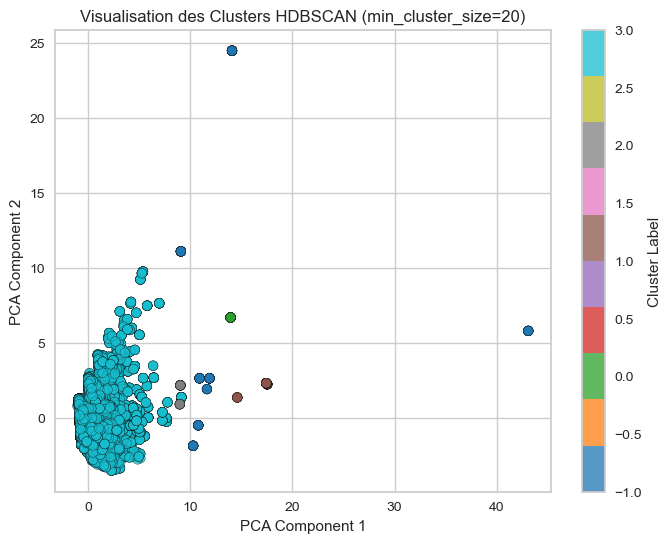

In [543]:
# Sélection de min_cluster_size = 20
min_cluster_size_installments = 20

# Exécution de HDBSCAN avec min_cluster_size = 
hdbscan_cluster_installments = hdbscan.HDBSCAN(
    min_cluster_size=min_cluster_size_installments, 
    min_samples=min_cluster_size_installments,  
    cluster_selection_epsilon=3.018,
    metric='euclidean'
)

labels_hd_installments= hdbscan_cluster_installments.fit_predict(df_installments)

# Réduction de dimension avec PCA
pca_hd_installments = PCA(n_components=2)
df_pca_hd_installments= pca_hd_installments.fit_transform(df_installments)

# Visualisation des clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca_hd_installments[:, 0], df_pca_hd_installments[:, 1], c=labels_hd_installments, cmap='tab10', alpha=0.75, edgecolors='k')

# Ajouter une barre de couleur
plt.colorbar(scatter, label="Cluster Label")

# Labels et titre
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"Visualisation des Clusters HDBSCAN (min_cluster_size={min_cluster_size_installments})")

# Affichage
plt.show()

#### **Métriques**

In [545]:
# Filtre pour retirer les outliers 
mask = labels_hd_installments != -1
X_no_noise12 = df_installments[mask]
labels_no_noise12 = labels_hd_installments[mask]

if len(set(labels_no_noise12)) > 1:
    silhouette = silhouette_score(X_no_noise12, labels_no_noise12)
    db_index = davies_bouldin_score(X_no_noise12, labels_no_noise12)
    ch_index = calinski_harabasz_score(X_no_noise12, labels_no_noise12)
    
    print(f"Silhouette Score (sans outliers): {silhouette:.4f}")
    print(f"Davies-Bouldin Index (sans outliers): {db_index:.4f}")
    print(f"Calinski-Harabasz Index (sans outliers): {ch_index:.4f}")
else:
    print("Nombre de clusters (sans outliers) insuffisant pour calculer les métriques.")

Silhouette Score (sans outliers): 0.7897
Davies-Bouldin Index (sans outliers): 0.2254
Calinski-Harabasz Index (sans outliers): 3492.0231


#### **Outliers**

In [547]:
# Nombre total de points
total_points_hd_installments= len(labels_hd_installments)

# Nombre de points classés comme outliers (-1)
outliers_count_hd_installments= np.sum(labels_hd_installments == -1)

# Pourcentage d'outliers
outliers_percentage_hd_installments = (outliers_count_hd_installments / total_points_hd_installments) * 100

print(f"Nombre total de points : {total_points_hd_installments}")
print(f"Nombre d'outliers : {outliers_count_hd_installments}")
print(f"Pourcentage d'outliers : {outliers_percentage_hd_installments:.2f}%")

Nombre total de points : 119143
Nombre d'outliers : 88
Pourcentage d'outliers : 0.07%


#### **Moyenne**

In [549]:
df_clusters_hd_installments = df_installments.copy()
df_clusters_hd_installments["Cluster"] = labels_hd_installments

# Supprimer les outliers (-1) avant de calculer la moyenne
df_clusters_hd_installments = df_clusters_hd_installments[df_clusters_hd_installments["Cluster"] != -1]

# Moyennes par cluster
cluster_means_hd_installments = df_clusters_hd_installments.groupby("Cluster").mean()

print(" Moyennes des features par cluster avec HDBSCAN:")
print(cluster_means_hd_installments)

 Moyennes des features par cluster avec HDBSCAN:
          recency  frequency   monetary  avg_review  avg_installments
Cluster                                                              
0       -1.426279   7.078275  16.505824   -0.017218          1.117807
1        0.258102  -0.221740  25.882591   -0.928643         -0.232719
2       -0.073189   1.603264  11.374964    0.344209          2.168437
3        0.000546  -0.009663  -0.025934    0.000956         -0.001698


In [550]:
quantitative_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment', 'diversity_products', 'avg_installments']
target_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_installments']

In [551]:
cluster_means_original_hd_installments = inverse_transform_mean(
    cluster_means_hd_installments,       # DataFrame des moyennes normalisées par cluster
    df_final,                            # DataFrame original non transformé
    quantitative_features,               # Variables standardisées
    target_features                      # Variables à inverser
)

print("Moyennes en échelle d'origine:")
print(cluster_means_original_hd_installments)

Moyennes en échelle d'origine:
            recency  frequency      monetary  avg_review  avg_installments
Cluster                                                                   
0         69.000000   4.000000  27935.460000    4.000000          6.000000
1        327.304348   1.000000  43587.292174    2.739130          2.304348
2        276.500000   1.750000  19370.955000    4.500000          8.875000
3        287.807349   1.087155    340.414079    4.025143          2.936525


In [552]:
display(df_clusters_hd_installments['Cluster'].value_counts().sort_index())

Cluster
0        24
1        46
2        24
3    118961
Name: count, dtype: int64

- Cluster 0: Clients nouveaux et achètent fréquemment 
- Cluster 1: Clients qui se différencient par leur dépenses élevées
- Cluster 2: Clients avec beaucoup d'échelonnage
- Cluster 3: Clients avec le moins de dépenses

#### Test moyenne

In [555]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_original_hd_installments.index:
        for j in cluster_means_original_hd_installments.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_hd_installments[df_clusters_hd_installments['Cluster'] == i][feature]
                group_2 = df_clusters_hd_installments[df_clusters_hd_installments['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_original_hd_installments.loc[i, feature]
                mean_2 = cluster_means_original_hd_installments.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=-3114.2224, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=-1894.7847, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=-75454.5580, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=369.8183, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=475.9011, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=-103.2168, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=16198878795992128.0000, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=10.2410, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=1174.1018, p-value=0.0000
T-test Frequency (Cluster 1 vs Cluster 2): t-stat=-3.4137, p-value=0.0024
T-test Frequency (Cluster 1 vs Cluster 3): t-stat=-35.1300, p-value=0.0000
T-test Frequency (Cluster 2 vs Cluster 3): t-stat=3.0168, p-value=0.0061
T-test Monetary (Cluster 0 vs Cluster 1): t-stat=-62455.3612, p-value=0.0000
T-test Monetary 

In [556]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_hd_installments.index:
        for j in cluster_means_hd_installments.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_hd_installments[df_clusters_hd_installments['Cluster'] == i][feature]
                group_2 = df_clusters_hd_installments[df_clusters_hd_installments['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_hd_installments.loc[i, feature]
                mean_2 = cluster_means_hd_installments.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")



T-test Recency (Cluster 0 vs Cluster 1): t-stat=-20.3076, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=-12.3557, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=-492.0328, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=2.4116, p-value=0.0197
T-test Recency (Cluster 1 vs Cluster 3): t-stat=3.1033, p-value=0.0033
T-test Recency (Cluster 2 vs Cluster 3): t-stat=-0.6731, p-value=0.5076
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=39417352894077208.0000, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=24.9199, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=2856.9869, p-value=0.0000
T-test Frequency (Cluster 1 vs Cluster 2): t-stat=-8.3066, p-value=0.0000
T-test Frequency (Cluster 1 vs Cluster 3): t-stat=-85.4833, p-value=0.0000
T-test Frequency (Cluster 2 vs Cluster 3): t-stat=7.3409, p-value=0.0000
T-test Monetary (Cluster 0 vs Cluster 1): t-stat=-37.4160, p-value=0.0000
T-test Monetary (Cluster 0 vs C

- T-test Recency (Cluster 2 vs Cluster 3): t-stat=-0.6731, p-value=0.5076

### 8. Test du modèle final avec toutes les variables

In [559]:
df_all_1 = df_final_encoded[['recency', 
                           'frequency', 
                           'monetary',
                           'avg_review',
                           'has_review',
                           'diversity_products',
                           'avg_payment',
                           'avg_installments']+ top_category_cols]

#### **Choix du bon eps**

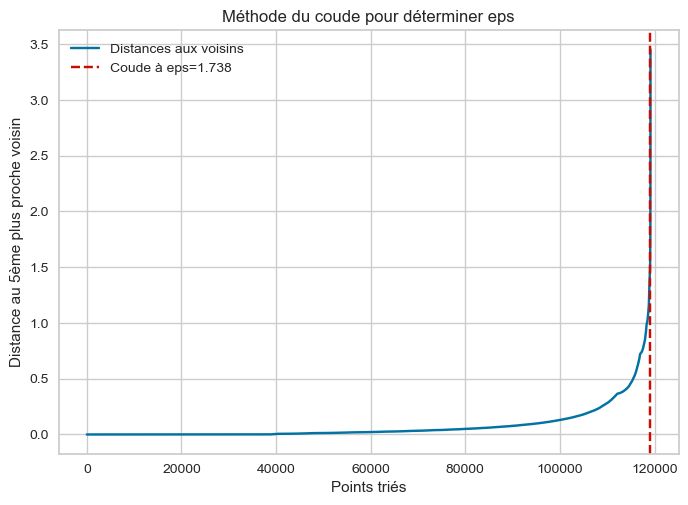

Pour k=2, eps recommandé = 1.738


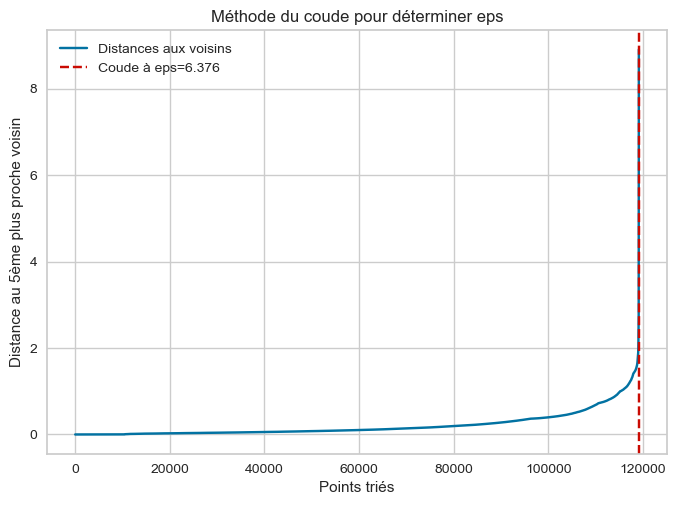

Pour k=4, eps recommandé = 6.376


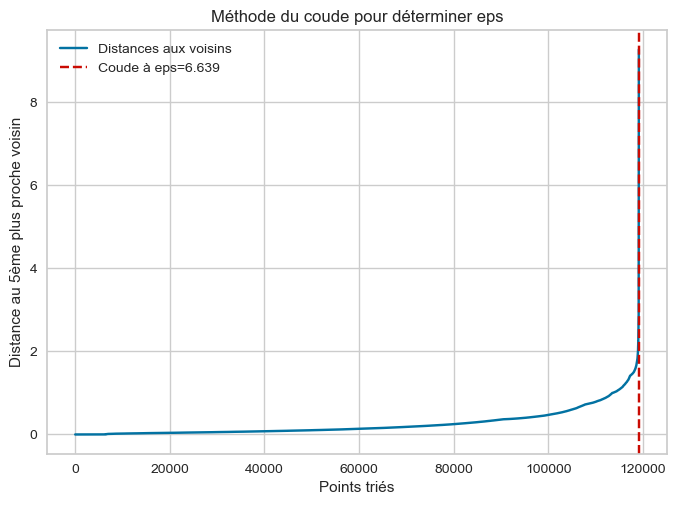

Pour k=5, eps recommandé = 6.639


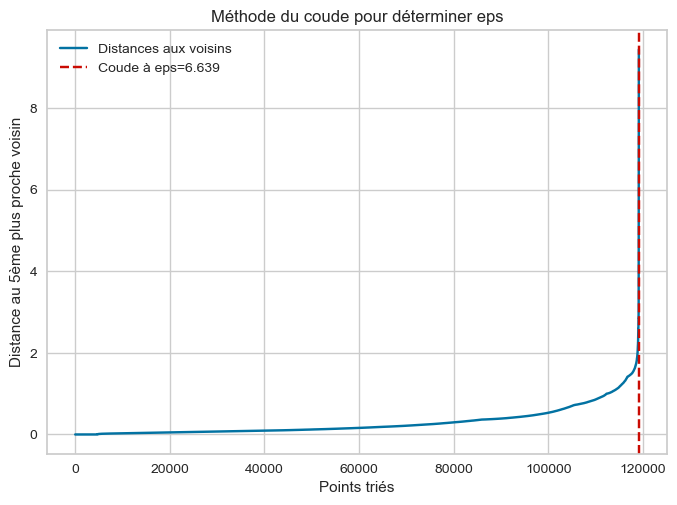

Pour k=6, eps recommandé = 6.639


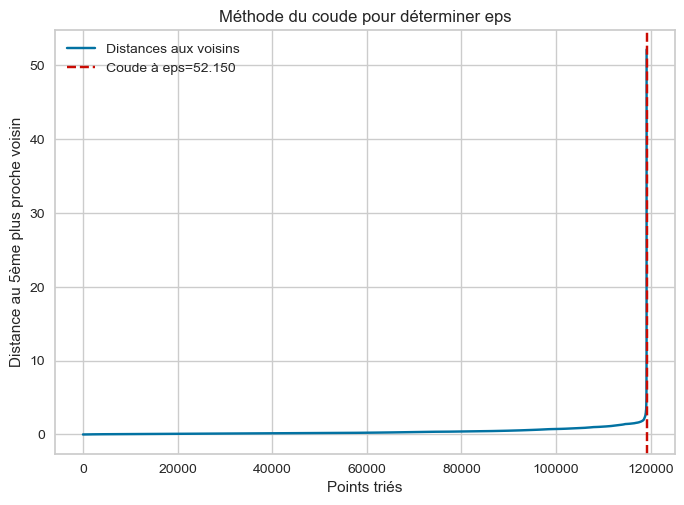

Pour k=10, eps recommandé = 52.150


In [561]:
#  Calcul des distances des k-plus proches voisins
for k in [2, 4, 5, 6, 10]:
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(df_all_1)
    distances, indices = neigh.kneighbors(df_all_1)
    sorted_distances = np.sort(distances[:, -1])  # On prend la plus grande distance de chaque point: dernière colonne = distance au k-ième voisin
    
    kneedle = KneeLocator(range(len(sorted_distances)), sorted_distances, curve="convex", direction="increasing")
    eps_value = sorted_distances[kneedle.knee]  # Valeur optimale de eps
    
    plt.plot(sorted_distances, label="Distances aux voisins")
    plt.axvline(x=kneedle.knee, color='r', linestyle='--', label=f"Coude à eps={eps_value:.3f}")
    plt.xlabel("Points triés")
    plt.ylabel("Distance au 5ème plus proche voisin")
    plt.title("Méthode du coude pour déterminer eps")
    plt.legend() 
    plt.show()
    print(f"Pour k={k}, eps recommandé = {eps_value:.3f}")

#### **Sous-échantillon**:
Je crée un sous échantillon ( par exemple 20% de la df) et regarde si les statistiques descriptives sont proches afin que la df_sampled soit bien représentative de ma df initiale. 

In [563]:
df_sampled_all_1= df_all_1.sample(frac=0.2, random_state=42)  # 20% des données

print("Avant échantillonnage :")
print(df_all_1.describe())

print("\nAprès échantillonnage :")
print(df_sampled_all_1.describe())

Avant échantillonnage :
            recency     frequency      monetary    avg_review     has_review  \
count  1.191430e+05  1.191430e+05  1.191430e+05  1.191430e+05  119143.000000   
mean   1.252990e-16  5.325656e-17  4.508618e-17 -3.077311e-17       0.991632   
std    1.000004e+00  1.000004e+00  1.000004e+00  1.000004e+00       0.091094   
min   -1.876222e+00 -2.217399e-01 -2.298710e-01 -2.185781e+00       0.000000   
25%   -8.133127e-01 -2.217399e-01 -1.875038e-01 -3.786455e-01       1.000000   
50%   -1.286165e-01 -2.217399e-01 -1.488928e-01  7.056356e-01       1.000000   
75%    7.125815e-01 -2.217399e-01 -6.021035e-02  7.056356e-01       1.000000   
max    3.157925e+00  3.871167e+01  6.525761e+01  7.056356e-01       1.000000   

       diversity_products   avg_payment  avg_installments  \
count        1.191430e+05  1.191430e+05      1.191430e+05   
mean         8.230018e-17 -5.892215e-17     -4.914155e-17   
std          1.000004e+00  1.000004e+00      1.000004e+00   
min        

- Les moyennes après échantillonnage restent très proches de celles avant échantillonnage (ex : has_review = 0.9916 avant, 0.9918 après).
- Les écarts-types sont également proches, avec quelques variations acceptables dues à l'aléatoire.
- Les min, max, quartiles (Q1, Q2, Q3) restent relativement stables, la distribution générale est préservée.
- Quelques petites variations existent (ex : recency moyen passe de 1.25e-16 à 0.0078, mais reste centré autour de 0 avec un écart-type proche de 1).
- Les moyennes des variables indicatrices (top_category_*) sont quasiment identiques avant et après, ce qui suggère que la proportion des différentes catégories a été bien conservée.

In [565]:
for min_samples in [2, 4, 6]:
    dbscan = DBSCAN(eps=6.6 , min_samples=min_samples)
    labels = dbscan.fit_predict(df_sampled_all_1)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Ne pas compter les outliers (-1 car on souhaite garder seulement les Clusters 
    print(f"min_samples = {min_samples} => {n_clusters} clusters détectés")

min_samples = 2 => 5 clusters détectés
min_samples = 4 => 3 clusters détectés
min_samples = 6 => 2 clusters détectés


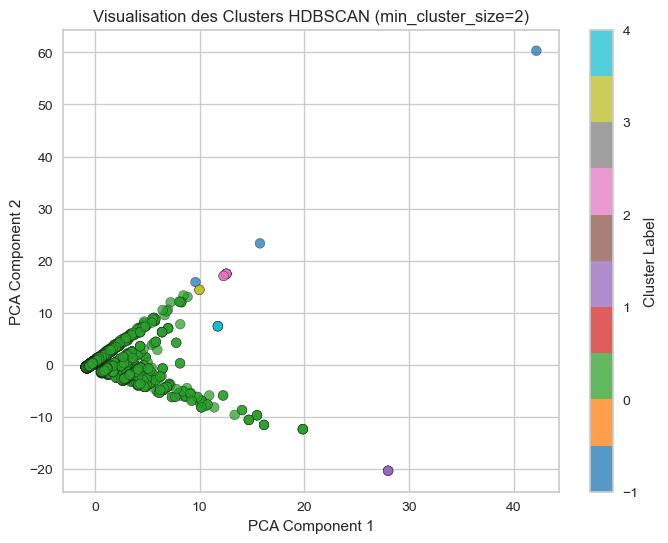

In [566]:
# Sélection de min_samples  = 2
min_samples_optimal_all_1 = 2

dbscan_cluster = DBSCAN(eps= 6.6, min_samples=min_samples_optimal_all_1)

labels_db_all_1= dbscan_cluster.fit_predict(df_sampled_all_1)

# Réduction de dimension avec PCA
pca_db_all_1= PCA(n_components=2)
df_pca_db_all_1 = pca_db_all_1.fit_transform(df_sampled_all_1)

# Visualisation des clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca_db_all_1[:, 0], df_pca_db_all_1[:, 1], c=labels_db_all_1, cmap='tab10', alpha=0.75, edgecolors='k')

# Ajouter une barre de couleur
plt.colorbar(scatter, label="Cluster Label")

# Labels et titre
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"Visualisation des Clusters HDBSCAN (min_cluster_size={min_samples_optimal_all_1})")

# Affichage
plt.show()

#### **Métriques**

In [568]:
# Filtre pour retirer les outliers 
mask = labels_db_all_1 != -1
X_no_noise13 = df_sampled_all_1[mask]
labels_no_noise13 = labels_db_all_1[mask]

if len(set(labels_no_noise13)) > 1:
    silhouette = silhouette_score(X_no_noise13, labels_no_noise13)
    db_index = davies_bouldin_score(X_no_noise13, labels_no_noise13)
    ch_index = calinski_harabasz_score(X_no_noise13, labels_no_noise13)
    
    print(f"Silhouette Score (sans outliers): {silhouette:.4f}")
    print(f"Davies-Bouldin Index (sans outliers): {db_index:.4f}")
    print(f"Calinski-Harabasz Index (sans outliers): {ch_index:.4f}")
else:
    print("Nombre de clusters (sans outliers) insuffisant pour calculer les métriques.")

Silhouette Score (sans outliers): 0.8234
Davies-Bouldin Index (sans outliers): 0.1166
Calinski-Harabasz Index (sans outliers): 518.3478


#### **Vérification outliers**

In [570]:
# Nombre total de points
total_points_db_all_1 = len(labels_db_all_1)

# Nombre de points classés comme outliers (-1)
outliers_count_db_all_1= np.sum(labels_db_all_1 == -1)

# Pourcentage d'outliers
outliers_percentage_db_all_1 = (outliers_count_db_all_1 / total_points_db_all_1) * 100

print(f"Nombre total de points : {total_points_db_all_1}")
print(f"Nombre d'outliers : {outliers_count_db_all_1}")
print(f"Pourcentage d'outliers : {outliers_percentage_db_all_1:.2f}%")

Nombre total de points : 23829
Nombre d'outliers : 3
Pourcentage d'outliers : 0.01%


#### **Moyenne**

In [572]:
df_clusters_db_all_1 = df_sampled_all_1.copy()
df_clusters_db_all_1["Cluster"] = labels_db_all_1

# Supprimer les outliers (-1) avant de calculer la moyenne
df_clusters_db_all_1 = df_clusters_db_all_1[df_clusters_db_all_1["Cluster"] != -1]

# Moyennes par cluster
cluster_means_db_all_1= df_clusters_db_all_1.groupby("Cluster").mean()

print(" Moyennes des features par cluster avec DBSCAN:")
print(cluster_means_db_all_1)

 Moyennes des features par cluster avec DBSCAN:
          recency  frequency   monetary  avg_review  has_review  \
Cluster                                                           
0        0.008047  -0.005675  -0.022039   -0.007945    0.992103   
1       -1.504530  38.711674   0.325858    0.535552    1.000000   
2        0.590858  -0.221740  26.721467    0.063099    0.222222   
3       -0.702457  -0.221740  17.854087    0.705636    1.000000   
4       -1.426279   7.078275  16.505824   -0.017218    1.000000   

         diversity_products  avg_payment  avg_installments  \
Cluster                                                      
0                 -0.005035    -0.014372         -0.003273   
1                 10.267512    -0.444675         -0.580397   
2                 -0.225850     7.814584          0.143310   
3                 -0.225850    10.709232         -0.709375   
4                 -0.225850     3.730132          1.117807   

         top_category_agro_industry_and_commerc

In [573]:
quantitative_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment', 'diversity_products', 'avg_installments']
target_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment', 'avg_installments', 'diversity_products', 'has_review']

In [574]:
cluster_means_original_all_1 = inverse_transform_mean(
    cluster_means_db_all_1,          # DataFrame des moyennes normalisées par cluster
    df_final,                        # DataFrame original non transformé
    quantitative_features,           # Variables standardisées
    target_features                  # Variables à inverser
)

print("Moyennes en échelle d'origine:")
print(cluster_means_original_all_1)

Moyennes en échelle d'origine:
            recency  frequency      monetary  avg_review  avg_payment  \
Cluster                                                                 
0        288.957745   1.088794    346.915326    4.012828   168.914921   
1         57.000000  17.000000    927.630000    4.764706    54.566471   
2        378.333333   1.000000  44987.555556    4.111111  2249.377778   
3        180.000000   1.000000  30186.000000    5.000000  3018.600000   
4         69.000000   4.000000  27935.460000    4.000000  1163.977500   

         avg_installments  diversity_products  has_review  
Cluster                                                    
0                2.932214             1.06313    0.992103  
1                1.352941             4.00000    1.000000  
2                3.333333             1.00000    0.222222  
3                1.000000             1.00000    1.000000  
4                6.000000             1.00000    1.000000  


In [575]:
# Identifier la catégorie la plus fréquente par cluster
modes_db_top_1 = df_clusters_db_all_1.groupby("Cluster")[top_category_cols].sum().idxmax(axis=1)
#Additionne les 1 de chaque colonne OHE par cluster et idmax (axis = 1) retrouve la colonne où cette somme est maximale

# Afficher les résultats
print(modes_db_top_1)

Cluster
0    top_category_bed_bath_table
1    top_category_sports_leisure
2              top_category_auto
3            top_category_drinks
4         top_category_telephony
dtype: object


In [576]:
display(df_clusters_db_all_1['Cluster'].value_counts().sort_index())

Cluster
0    23808
1        3
2        9
3        2
4        4
Name: count, dtype: int64

- Cluster 0: dépensent le moins
- Cluster 1: nouveau clients qui achètent très souvent et le plus de produits diversifiés le plus satisfaits
- Cluster 2: clients les plus inactifs mais avec les dépenses les plus élevées, ne laissent pratiquement pas d'avis
- Cluster 3: clients les plus satisfaits
- Cluster 4: clients avec le plus d'échelonnage de paiement

#### Test moyenne

In [579]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_original_all_1.index:
        for j in cluster_means_original_all_1.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_db_all_1[df_clusters_db_all_1['Cluster'] == i][feature]
                group_2 = df_clusters_db_all_1[df_clusters_db_all_1['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_original_all_1.loc[i, feature]
                mean_2 = cluster_means_original_all_1.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=35786.3975, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=-509.1977, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=16809.9805, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=33935.0397, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=-1831.9753, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=-inf, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=-inf, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=1130.7316, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 4): t-stat=1763.5613, p-value=0.0000
T-test Recency (Cluster 3 vs Cluster 4): t-stat=inf, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=-2734.7803, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=15.2616, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=15.2616, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 4): t-st

- T-test Frequency (Cluster 2 vs Cluster 3): t-stat=0.0000, p-value=1.0000
- T-test Avg_review (Cluster 0 vs Cluster 2): t-stat=-0.2312, p-value=0.8229
- T-test Avg_review (Cluster 1 vs Cluster 2): t-stat=1.5379, p-value=0.1626
- T-test Avg_review (Cluster 2 vs Cluster 3): t-stat=-2.0915, p-value=0.0699- T-test Avg_review (Cluster 2 vs Cluster 4): t-stat=0.2614, p-value=0.8004
- T-test Diversity_products (Cluster 2 vs Cluster 3): t-stat=nan, p-value=nan- T-test Diversity_products (Cluster 2 vs Cluster 4): t-stat=nan, p-value=nan- 
T-test Diversity_products (Cluster 3 vs Cluster 4): t-stat=nan, p-value=ann
- T-test Has_review (Cluster 1 vs Cluster 3): t-stat=nan, p-value=nan-
T-test Has_review (Cluster 1 vs Cluster 4): t-stat=nan, p-value=nna
- T-test Has_review (Cluster 3 vs Cluster 4): t-stat=nan, p-value=na4

In [581]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_db_all_1.index:
        for j in cluster_means_db_all_1.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_db_all_1[df_clusters_db_all_1['Cluster'] == i][feature]
                group_2 = df_clusters_db_all_1[df_clusters_db_all_1['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_db_all_1.loc[i, feature]
                mean_2 = cluster_means_db_all_1.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")



T-test Recency (Cluster 0 vs Cluster 1): t-stat=233.3601, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=-3.3204, p-value=0.0105
T-test Recency (Cluster 0 vs Cluster 3): t-stat=109.6165, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 4): t-stat=221.2875, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=-11.9462, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=-inf, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 4): t-stat=-inf, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=7.3734, p-value=0.0001
T-test Recency (Cluster 2 vs Cluster 4): t-stat=11.5000, p-value=0.0000
T-test Recency (Cluster 3 vs Cluster 4): t-stat=inf, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=-6654.6459, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=37.1368, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=37.1368, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 4): t-stat=-1217.5725, 

- T-test Frequency (Cluster 2 vs Cluster 3): t-stat=0.0000, p-value=1.0000
- T-test Avg_review (Cluster 0 vs Cluster 2): t-stat=-0.1671, p-value=0.8714
- T-test Avg_review (Cluster 0 vs Cluster 4): t-stat=1.4243, p-value=0.1544
- T-test Avg_review (Cluster 1 vs Cluster 2): t-stat=1.1117, p-value=0.2986
- T-test Avg_review (Cluster 2 vs Cluster 3): t-stat=-1.5119, p-value=0.1690
- T-test Avg_review (Cluster 2 vs Cluster 4): t-stat=0.1890, p-value=0.8548
- T-test Avg_installments (Cluster 0 vs Cluster 2): t-stat=-0.9089, p-value=0.3899
- T-test Diversity_products (Cluster 2 vs Cluster 3): t-stat=nan, p-value=nan
- T-test Diversity_products (Cluster 2 vs Cluster 4): t-stat=nan, p-value=nan
- T-test Diversity_products (Cluster 3 vs Cluster 4): t-stat=nan, p-value=nan
- T-test Has_review (Cluster 1 vs Cluster 3): t-stat=nan, p-value=nan
- T-test Has_review (Cluster 1 vs Cluster 4): t-stat=nan, p-value=nan
- T-test Has_review (Cluster 3 vs Cluster 4): t-stat=nan, p-value=nan

De même que pour le point 4. HDBSCAN ne pourra pas être testé dans cette variante finale à cause de la variable top_category

### 9. Test du modèle final (point 10)

In [585]:
df_final_2 = df_final_encoded[['recency', 
                           'frequency', 
                           'monetary',
                           'avg_review',
                            'has_review',
                           'diversity_products',
                           'avg_installments']]


#### **Choix du bon eps**

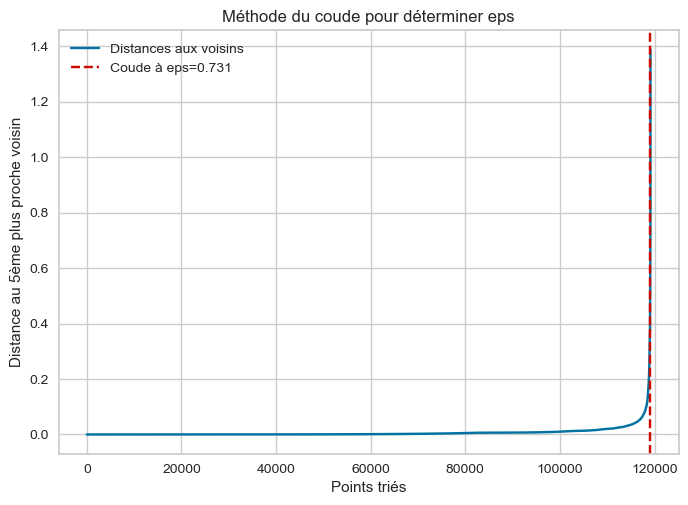

Pour k=2, eps recommandé = 0.731


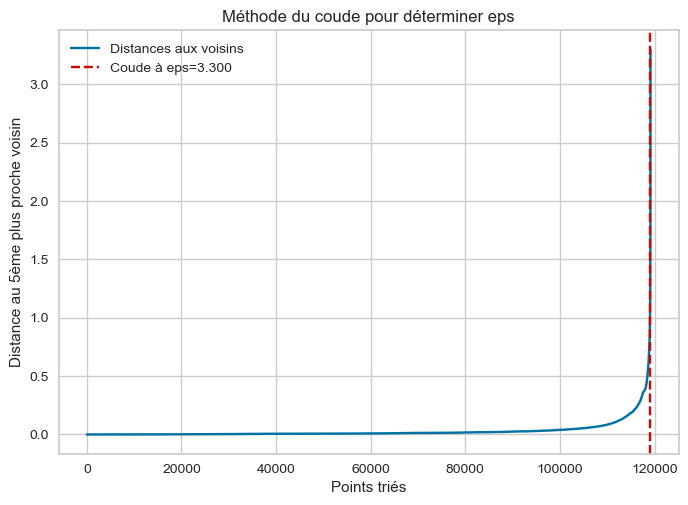

Pour k=4, eps recommandé = 3.300


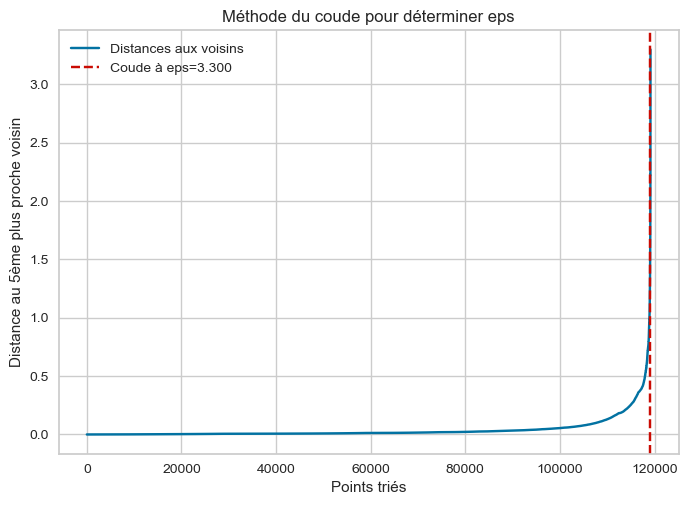

Pour k=5, eps recommandé = 3.300


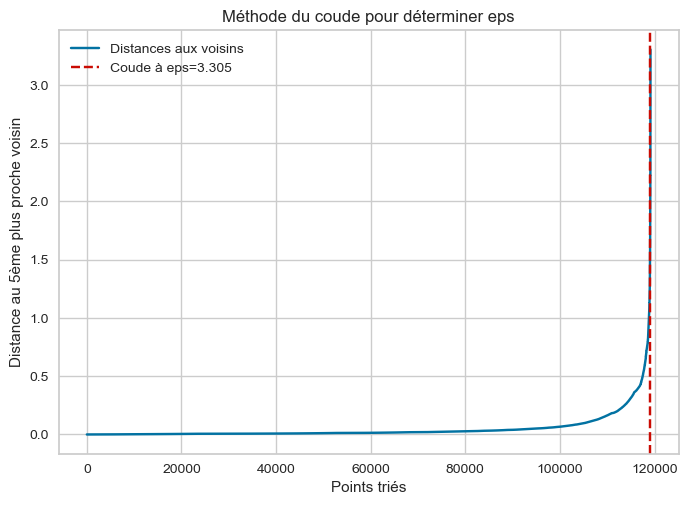

Pour k=6, eps recommandé = 3.305


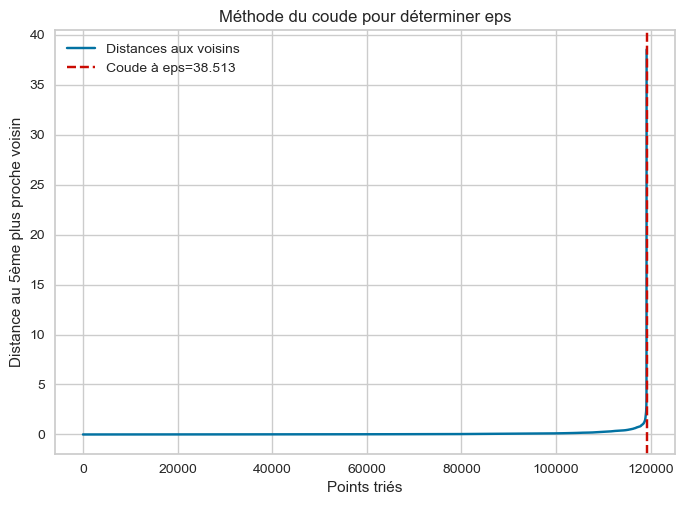

Pour k=10, eps recommandé = 38.513


In [587]:
#  Calcul des distances des k-plus proches voisins
for k in [2, 4, 5, 6, 10]:
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(df_final_2)
    distances, indices = neigh.kneighbors(df_final_2)
    sorted_distances = np.sort(distances[:, -1])  # On prend la plus grande distance de chaque point: dernière colonne = distance au k-ième voisin
    
    kneedle = KneeLocator(range(len(sorted_distances)), sorted_distances, curve="convex", direction="increasing")
    eps_value = sorted_distances[kneedle.knee]  # Valeur optimale de eps
    
    plt.plot(sorted_distances, label="Distances aux voisins")
    plt.axvline(x=kneedle.knee, color='r', linestyle='--', label=f"Coude à eps={eps_value:.3f}")
    plt.xlabel("Points triés")
    plt.ylabel("Distance au 5ème plus proche voisin")
    plt.title("Méthode du coude pour déterminer eps")
    plt.legend() 
    plt.show()
    print(f"Pour k={k}, eps recommandé = {eps_value:.3f}")

Ici nous testerons eps = 3.3

#### **Sous-échantillon**:
Je crée un sous échantillon ( par exemple 20% de la df) et regarde si les statistiques descriptives sont proches afin que la df_sampled soit bien représentative de ma df initiale. 

In [590]:
df_sampled_final = df_final_2.sample(frac=0.2, random_state=42)  # 20% des données

print("Avant échantillonnage :")
print(df_final_2.describe())

print("\nAprès échantillonnage :")
print(df_sampled_final.describe())

Avant échantillonnage :
            recency     frequency      monetary    avg_review     has_review  \
count  1.191430e+05  1.191430e+05  1.191430e+05  1.191430e+05  119143.000000   
mean   1.252990e-16  5.325656e-17  4.508618e-17 -3.077311e-17       0.991632   
std    1.000004e+00  1.000004e+00  1.000004e+00  1.000004e+00       0.091094   
min   -1.876222e+00 -2.217399e-01 -2.298710e-01 -2.185781e+00       0.000000   
25%   -8.133127e-01 -2.217399e-01 -1.875038e-01 -3.786455e-01       1.000000   
50%   -1.286165e-01 -2.217399e-01 -1.488928e-01  7.056356e-01       1.000000   
75%    7.125815e-01 -2.217399e-01 -6.021035e-02  7.056356e-01       1.000000   
max    3.157925e+00  3.871167e+01  6.525761e+01  7.056356e-01       1.000000   

       diversity_products  avg_installments  
count        1.191430e+05      1.191430e+05  
mean         8.230018e-17     -4.914155e-17  
std          1.000004e+00      1.000004e+00  
min         -2.258503e-01     -1.074811e+00  
25%         -2.258503e-01

 Moyennes très proches avant/après échantillonnage pour toutes les variables
- Écart-types (std) similaires, bien que monetary et avg_installments montrent une très légère variation.
- Min/Max identiques, ce qui montre que l'échantillon conserve les valeurs extrêmes.
- Quartiles (25%, 50%, 75%) presque identiques, ce qui signifie que la distribution des valeurs est bien préservée.

In [592]:
for min_samples in [11, 15, 20, 30]:
    dbscan = DBSCAN(eps= 3.3, min_samples=min_samples)
    labels = dbscan.fit_predict(df_sampled_final)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Ne pas compter les outliers (-1 car on souhaite garder seulement les Clusters 
    print(f"min_samples = {min_samples} => {n_clusters} clusters détectés")

min_samples = 11 => 5 clusters détectés
min_samples = 15 => 4 clusters détectés
min_samples = 20 => 3 clusters détectés
min_samples = 30 => 3 clusters détectés


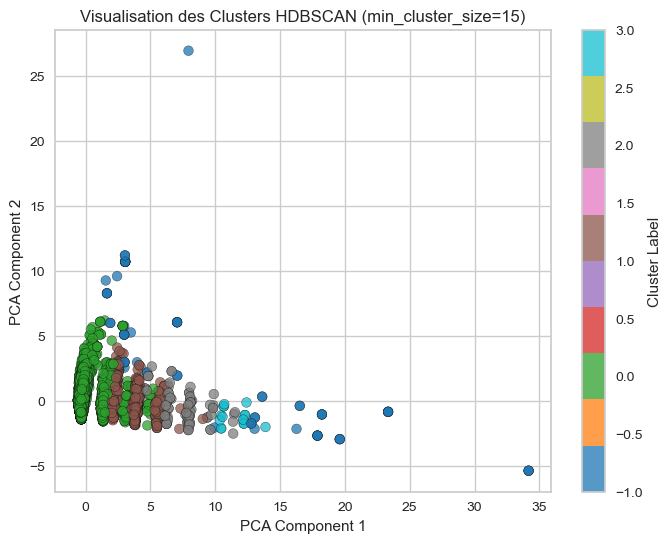

In [593]:
# Sélection de min_samples  = 15, test effectué avec 11 mais clusters difficiles à différencier 
min_samples_optimal_final = 15

dbscan_cluster = DBSCAN(eps= 3.3, min_samples=min_samples_optimal_final)

labels_db_final = dbscan_cluster.fit_predict(df_sampled_final)

# Réduction de dimension avec PCA
pca_db_final = PCA(n_components=2)
df_pca_db_final = pca_db_final.fit_transform(df_sampled_final)

# Visualisation des clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca_db_final[:, 0], df_pca_db_final[:, 1], c=labels_db_final, cmap='tab10', alpha=0.75, edgecolors='k')

# Ajouter une barre de couleur
plt.colorbar(scatter, label="Cluster Label")

# Labels et titre
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"Visualisation des Clusters HDBSCAN (min_cluster_size={min_samples_optimal_final})")

# Affichage
plt.show()

#### **Métriques**

In [595]:
# Filtre pour retirer les outliers 
mask = labels_db_final != -1
X_no_noise14 = df_sampled_final[mask]
labels_no_noise14 = labels_db_final[mask]

if len(set(labels_no_noise14)) > 1:
    silhouette = silhouette_score(X_no_noise14, labels_no_noise14)
    db_index = davies_bouldin_score(X_no_noise14, labels_no_noise14)
    ch_index = calinski_harabasz_score(X_no_noise14, labels_no_noise14)
    
    print(f"Silhouette Score (sans outliers): {silhouette:.4f}")
    print(f"Davies-Bouldin Index (sans outliers): {db_index:.4f}")
    print(f"Calinski-Harabasz Index (sans outliers): {ch_index:.4f}")
else:
    print("Nombre de clusters (sans outliers) insuffisant pour calculer les métriques.")

Silhouette Score (sans outliers): 0.5126
Davies-Bouldin Index (sans outliers): 1.0729
Calinski-Harabasz Index (sans outliers): 2364.4634


#### **Vérification outliers**

In [597]:
# Nombre total de points
total_points_db_final = len(labels_db_final)

# Nombre de points classés comme outliers (-1)
outliers_count_db_final = np.sum(labels_db_final == -1)

# Pourcentage d'outliers
outliers_percentage_db_final = (outliers_count_db_final / total_points_db_final) * 100

print(f"Nombre total de points : {total_points_db_final}")
print(f"Nombre d'outliers : {outliers_count_db_final}")
print(f"Pourcentage d'outliers : {outliers_percentage_db_final:.2f}%")

Nombre total de points : 23829
Nombre d'outliers : 65
Pourcentage d'outliers : 0.27%


Peu d'outliers

#### **Moyenne**

In [600]:
df_clusters_db_final = df_sampled_final.copy()
df_clusters_db_final["Cluster"] = labels_db_final

# Supprimer les outliers (-1) avant de calculer la moyenne
df_clusters_db_final = df_clusters_db_final[df_clusters_db_final["Cluster"] != -1]

# Moyennes par cluster
cluster_means_db_final = df_clusters_db_final.groupby("Cluster").mean()

print(" Moyennes des features par cluster avec DBSCAN:")
print(cluster_means_db_final)

 Moyennes des features par cluster avec DBSCAN:
          recency  frequency  monetary  avg_review  has_review  \
Cluster                                                          
0        0.016561  -0.130739 -0.037741    0.002382    0.991996   
1       -0.140524   1.696007  0.111955   -0.203438    0.993971   
2        0.055221   3.809245  0.247058   -0.054995    1.000000   
3       -0.969000   6.013690  0.268573    0.439083    0.937500   

         diversity_products  avg_installments  
Cluster                                        
0                 -0.225850         -0.017389  
1                  3.271937          0.197143  
2                  6.769725          0.129103  
3                 10.267512          0.789295  


In [601]:
quantitative_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment', 'diversity_products', 'avg_installments']

target_features = ['recency', 'frequency', 'monetary', 'avg_review', 'has_review',  'diversity_products', 'avg_installments']

In [602]:
cluster_means_original_db_final = inverse_transform_mean(
    cluster_means_db_final,  # DataFrame des moyennes normalisées par cluster
    df_final,              # DataFrame original non transformé
    quantitative_features, # Variables standardisées
    target_features        # Variables à inverser
)

print("Moyennes en échelle d'origine:")
print(cluster_means_original_db_final)

Moyennes en échelle d'origine:
            recency  frequency    monetary  avg_review  has_review  \
Cluster                                                              
0        290.263296   1.037398  320.705333    4.027116    0.991996   
1        266.173988   1.788114  570.580258    3.742382    0.993971   
2        296.191919   2.656566  796.096162    3.947739    1.000000   
3        139.125000   3.562500  832.010000    4.631250    0.937500   

         diversity_products  avg_installments  
Cluster                                        
0                       1.0          2.893586  
1                       2.0          3.480644  
2                       3.0          3.294456  
3                       4.0          5.101042  


In [603]:
display(df_clusters_db_final['Cluster'].value_counts().sort_index())

Cluster
0    22488
1     1161
2       99
3       16
Name: count, dtype: int64

- CLuster 0: clients avec le moins de dépenses
- Cluster 1: clients moyennement satisfaits = difficile à différencier
- Cluster 2: Clients laissant toujorus un avis, difficile à différencier
- Cluster 3: nouveaux clients qui achètent beaucoup

#### Test moyenne

In [606]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_original_db_final.index:
        for j in cluster_means_original_db_final.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_db_final[df_clusters_db_final['Cluster'] == i][feature]
                group_2 = df_clusters_db_final[df_clusters_db_final['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_original_db_final.loc[i, feature]
                mean_2 = cluster_means_original_db_final.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=841.1319, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=-52.7918, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=1038.4784, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=-259.8719, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=858.2761, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=855.5492, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=-18.1642, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=-7.2229, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=-6.5973, p-value=0.0000
T-test Frequency (Cluster 1 vs Cluster 2): t-stat=-3.8107, p-value=0.0002
T-test Frequency (Cluster 1 vs Cluster 3): t-stat=-4.6094, p-value=0.0003
T-test Frequency (Cluster 2 vs Cluster 3): t-stat=-2.0425, p-value=0.0511
T-test Monetary (Cluster 0 vs Cluster 1): t-stat=-19375.3765, p-value=0.0000
T-test Monetary (Cluster 0 vs Cluster 

- T-test Frequency (Cluster 2 vs Cluster 3): t-stat=-2.0425, p-value=0.0511
- T-test Avg_review (Cluster 0 vs Cluster 2): t-stat=0.7896, p-value=0.4317
- T-test Avg_review (Cluster 1 vs Cluster 2): t-stat=-1.9611, p-value=0.0523
- T-test Has_review (Cluster 0 vs Cluster 1): t-stat=-0.8407, p-value=0.4007
- T-test Has_review (Cluster 0 vs Cluster 3): t-stat=0.8719, p-value=0.3970
- T-test Has_review (Cluster 1 vs Cluster 3): t-stat=0.9029, p-value=0.3808- 
T-test Has_review (Cluster 2 vs Cluster 3): t-stat=1.0000, p-value=0.3332

In [608]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_db_final.index:
        for j in cluster_means_db_final.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_db_final[df_clusters_db_final['Cluster'] == i][feature]
                group_2 = df_clusters_db_final[df_clusters_db_final['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_db_final.loc[i, feature]
                mean_2 = cluster_means_db_final.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")



T-test Recency (Cluster 0 vs Cluster 1): t-stat=5.4850, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=-0.3443, p-value=0.7314
T-test Recency (Cluster 0 vs Cluster 3): t-stat=6.7718, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=-1.6946, p-value=0.0930
T-test Recency (Cluster 1 vs Cluster 3): t-stat=5.5967, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=5.5790, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=-44.1997, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=-17.5756, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=-16.0533, p-value=0.0000
T-test Frequency (Cluster 1 vs Cluster 2): t-stat=-9.2726, p-value=0.0000
T-test Frequency (Cluster 1 vs Cluster 3): t-stat=-11.2163, p-value=0.0000
T-test Frequency (Cluster 2 vs Cluster 3): t-stat=-4.9701, p-value=0.0000
T-test Monetary (Cluster 0 vs Cluster 1): t-stat=-11.6075, p-value=0.0000
T-test Monetary (Cluster 0 vs Cluster 2): t-stat=-

- T-test Recency (Cluster 0 vs Cluster 2): t-stat=-0.3443, p-value=0.7314
- T-test Recency (Cluster 1 vs Cluster 2): t-stat=-1.6946, p-value=0.0930
- T-test Monetary (Cluster 2 vs Cluster 3): t-stat=-0.2746, p-value=0.7861
- T-test Avg_review (Cluster 0 vs Cluster 2): t-stat=0.5708, p-value=0.5695
- T-test Avg_review (Cluster 1 vs Cluster 2): t-stat=-1.4176, p-value=0.1590
- T-test Has_review (Cluster 0 vs Cluster 1): t-stat=-0.8407, p-value=0.4007
- T-test Has_review (Cluster 0 vs Cluster 3): t-stat=0.8719, p-value=0.3970
- T-test Has_review (Cluster 1 vs Cluster 3): t-stat=0.9029, p-value=0.3808
- T-test Has_review (Cluster 2 vs Cluster 3): t-stat=1.0000, p-value=0.3332
- T-test Avg_installments (Cluster 0 vs Cluster 2): t-stat=-1.4464, p-value=0.1512
- T-test Avg_installments (Cluster 1 vs Cluster 2): t-stat=0.6442, p-value=0.5207

### **HDBSCAN :**
- cluster_selection_epsilon joue un rôle similaire à epsilon :
Il définit un seuil de distance au-delà duquel deux clusters ne fusionneront pas. Mais contrairement à DBSCAN, HDBSCAN peut avoir un eps adaptatif qui évolue selon la densité locale.

- Sans cluster_selection_epsilon :
HDBSCAN détecte des clusters de tailles très variées.
Certains petits clusters peuvent apparaître si les points sont densément connectés.
- Avec cluster_selection_epsilon :
forces une séparation des clusters qui dépasse une certaine distance.
Cela évite d'avoir trop de petits clusters et stabilise leur nombre.


Ici les paramètres à ajuster:
- min_cluster_size = Plus il est grand, plus les petits clusters sont ignorés. Essaye 5, 10, 20, 50.
- min_samples = Définit la sensibilité aux outliers (en général, même valeur que min_cluster_size).
- cluster_selection_method = 'eom' (par défaut) détecte les clusters de manière optimale, 'leaf' garde plus de petits clusters.
- cluster_selection_epsilon

In [611]:
#Ajout du paramètres cluster_selection_epsilon: 

for min_cluster_size in [10, 20, 30, 40, 50]:
    hdbscan_cluster = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size, 
        min_samples=min_cluster_size,  # Garde la cohérence
        cluster_selection_epsilon = 3.3,
        metric='euclidean'
    )
    
    labels = hdbscan_cluster.fit_predict(df_final_2)
    
    # Compter les clusters détectés (on exclut les outliers -1)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"min_cluster_size = {min_cluster_size} => {n_clusters} clusters détectés")

min_cluster_size = 10 => 15 clusters détectés
min_cluster_size = 20 => 9 clusters détectés
min_cluster_size = 30 => 6 clusters détectés
min_cluster_size = 40 => 4 clusters détectés
min_cluster_size = 50 => 3 clusters détectés


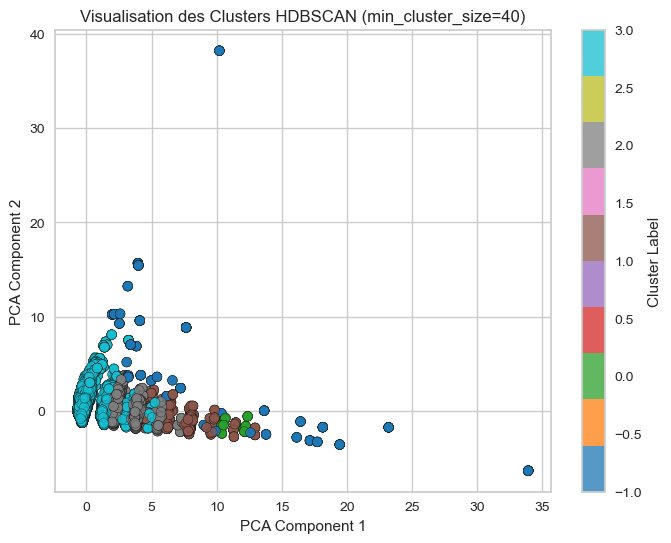

In [612]:
# Sélection de min_cluster_size = 40
min_cluster_size_final= 40

# Exécution de HDBSCAN avec min_cluster_size = 40
hdbscan_cluster_final = hdbscan.HDBSCAN(
    min_cluster_size=min_cluster_size_final, 
    min_samples=min_cluster_size_final,  
    cluster_selection_epsilon=3.3,
    metric='euclidean'
)

labels_hd_final = hdbscan_cluster_final.fit_predict(df_final_2)

# Réduction de dimension avec PCA
pca_hd_final = PCA(n_components=2)
df_pca_hd_final= pca_hd_final.fit_transform(df_final_2)

# Visualisation des clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca_hd_final[:, 0], df_pca_hd_final[:, 1], c=labels_hd_final, cmap='tab10', alpha=0.75, edgecolors='k')

# Ajouter une barre de couleur
plt.colorbar(scatter, label="Cluster Label")

# Labels et titre
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"Visualisation des Clusters HDBSCAN (min_cluster_size={min_cluster_size_final})")

# Affichage
plt.show()

#### **Métriques**

In [614]:
# Filtre pour retirer les outliers 
mask = labels_hd_final != -1
X_no_noise15 = df_final_2[mask]
labels_no_noise15 = labels_hd_final[mask]

if len(set(labels_no_noise15)) > 1:
    silhouette = silhouette_score(X_no_noise15, labels_no_noise15)
    db_index = davies_bouldin_score(X_no_noise15, labels_no_noise15)
    ch_index = calinski_harabasz_score(X_no_noise15, labels_no_noise15)
    
    print(f"Silhouette Score (sans outliers): {silhouette:.4f}")
    print(f"Davies-Bouldin Index (sans outliers): {db_index:.4f}")
    print(f"Calinski-Harabasz Index (sans outliers): {ch_index:.4f}")
else:
    print("Nombre de clusters (sans outliers) insuffisant pour calculer les métriques.")

Silhouette Score (sans outliers): 0.5128
Davies-Bouldin Index (sans outliers): 1.0710
Calinski-Harabasz Index (sans outliers): 12116.7349


#### **Outliers**

In [616]:
# Nombre total de points
total_points_final = len(labels_hd_final)

# Nombre de points classés comme outliers (-1)
outliers_count_final = np.sum(labels_hd_final == -1)

# Pourcentage d'outliers
outliers_percentage_final = (outliers_count_final / total_points_final) * 100

print(f"Nombre total de points : {total_points_final}")
print(f"Nombre d'outliers : {outliers_count_final}")
print(f"Pourcentage d'outliers : {outliers_percentage_final:.2f}%")

Nombre total de points : 119143
Nombre d'outliers : 362
Pourcentage d'outliers : 0.30%


#### **Moyenne**

In [618]:
df_clusters_hd_final = df_final_2.copy()
df_clusters_hd_final["Cluster"] = labels_hd_final

# Supprimer les outliers (-1) avant de calculer la moyenne
df_clusters_hd_final = df_clusters_hd_final[df_clusters_hd_final["Cluster"] != -1]

# Moyennes par cluster
cluster_means_hd_final = df_clusters_hd_final.groupby("Cluster").mean()

print(" Moyennes des features par cluster avec HDBSCAN:")
print(cluster_means_hd_final)

 Moyennes des features par cluster avec HDBSCAN:
          recency  frequency  monetary  avg_review  has_review  \
Cluster                                                          
0       -1.051812   5.835719  0.309094    0.351899    1.000000   
1       -0.166482   3.802477  0.206083    0.016538    0.995169   
2       -0.173816   1.688736  0.111688   -0.161615    0.991412   
3        0.011679  -0.133132 -0.038610    0.009387    0.991798   

         diversity_products  avg_installments  
Cluster                                        
0                 10.267512          0.915651  
1                  6.769725          0.142133  
2                  3.271937          0.229826  
3                 -0.225850         -0.016132  


In [619]:
quantitative_features = ['recency', 'frequency', 'monetary', 'avg_review', 'avg_payment', 'diversity_products', 'avg_installments']
target_features = ['recency', 'frequency', 'monetary', 'avg_review', 'diversity_products', 'avg_installments', 'has_review']

In [620]:

cluster_means_hd_original_final = inverse_transform_mean(
    cluster_means_hd_final,  # DataFrame des moyennes normalisées par cluster
    df_final,              # DataFrame original non transformé
    quantitative_features, # Variables standardisées
    target_features        # Variables à inverser
)

print("Moyennes en échelle d'origine:")
print(cluster_means_hd_original_final)

Moyennes en échelle d'origine:
            recency  frequency    monetary  avg_review  diversity_products  \
Cluster                                                                      
0        126.425532   3.489362  899.648085    4.510638                 4.0   
1        262.193237   2.653784  727.701256    4.046699                 3.0   
2        261.068533   1.785125  570.135398    3.800240                 2.0   
3        289.514707   1.036414  319.255244    4.036806                 1.0   

         avg_installments  has_review  
Cluster                                
0                5.446809    1.000000  
1                3.330113    0.995169  
2                3.570079    0.991412  
3                2.897026    0.991798  


In [621]:
display(df_clusters_hd_final['Cluster'].value_counts().sort_index())

Cluster
0        47
1       621
2      5822
3    112291
Name: count, dtype: int64

#### Test moyenne

In [623]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_hd_original_final.index:
        for j in cluster_means_hd_original_final.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_hd_final[df_clusters_hd_final['Cluster'] == i][feature]
                group_2 = df_clusters_hd_final[df_clusters_hd_final['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_hd_original_final.loc[i, feature]
                mean_2 = cluster_means_hd_original_final.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")


T-test Recency (Cluster 0 vs Cluster 1): t-stat=-1892.2964, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=-2222.2380, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=-2746.4464, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=26.6266, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 3): t-stat=-674.7812, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=-2230.1943, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=4.0899, p-value=0.0001
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=9.4535, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=13.6766, p-value=0.0000
T-test Frequency (Cluster 1 vs Cluster 2): t-stat=8.7268, p-value=0.0000
T-test Frequency (Cluster 1 vs Cluster 3): t-stat=16.5275, p-value=0.0000
T-test Frequency (Cluster 2 vs Cluster 3): t-stat=40.8474, p-value=0.0000
T-test Monetary (Cluster 0 vs Cluster 1): t-stat=3750.1291, p-value=0.0000
T-test Monetary (Cluster 0 vs Cluster 

- T-test Avg_review (Cluster 1 vs Cluster 3): t-stat=0.2689, p-value=0.7881
- T-test Has_review (Cluster 1 vs Cluster 2): t-stat=1.2376, p-value=0.2162- T-test Has_review (Cluster 0 vs Cluster 1): t-stat=1.7349, p-value=0.0833
- T-test Has_review (Cluster 1 vs Cluster 3): t-stat=1.2050, p-value=0.2287- 
T-test Has_review (Cluster 2 vs Cluster 3): t-stat=-0.3117, p-value=0.7553

In [625]:
for feature in target_features:
    # Comparaison de chaque paire de clusters
    for i in cluster_means_hd_final.index:
        for j in cluster_means_hd_final.index:
            if j > i:
                # Obtenir les données des groupes pour la feature en question
                group_1 = df_clusters_hd_final[df_clusters_hd_final['Cluster'] == i][feature]
                group_2 = df_clusters_hd_final[df_clusters_hd_final['Cluster'] == j][feature]

                # Utiliser les moyennes en échelle d'origine
                mean_1 = cluster_means_hd_final.loc[i, feature]
                mean_2 = cluster_means_hd_final.loc[j, feature]

                # Calculer les écarts-types et tailles des groupes
                std_1 = group_1.std()
                std_2 = group_2.std()
                n_1 = len(group_1)
                n_2 = len(group_2)

                # Effectuer le t-test (variances inégales)
                t_stat, p_value = ttest_ind_from_stats(mean_1, std_1, n_1,
                                                             mean_2, std_2, n_2,
                                                             equal_var=False)
                print(f"T-test {feature.capitalize()} (Cluster {i} vs Cluster {j}): t-stat={t_stat:.4f}, p-value={p_value:.4f}")



T-test Recency (Cluster 0 vs Cluster 1): t-stat=-12.3395, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 2): t-stat=-14.4910, p-value=0.0000
T-test Recency (Cluster 0 vs Cluster 3): t-stat=-17.9093, p-value=0.0000
T-test Recency (Cluster 1 vs Cluster 2): t-stat=0.1736, p-value=0.8622
T-test Recency (Cluster 1 vs Cluster 3): t-stat=-4.4002, p-value=0.0000
T-test Recency (Cluster 2 vs Cluster 3): t-stat=-14.5429, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 1): t-stat=9.9521, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 2): t-stat=23.0036, p-value=0.0000
T-test Frequency (Cluster 0 vs Cluster 3): t-stat=33.2798, p-value=0.0000
T-test Frequency (Cluster 1 vs Cluster 2): t-stat=21.2353, p-value=0.0000
T-test Frequency (Cluster 1 vs Cluster 3): t-stat=40.2169, p-value=0.0000
T-test Frequency (Cluster 2 vs Cluster 3): t-stat=99.3956, p-value=0.0000
T-test Monetary (Cluster 0 vs Cluster 1): t-stat=2.2466, p-value=0.0289
T-test Monetary (Cluster 0 vs Cluster 2): t-stat=4

- T-test Recency (Cluster 1 vs Cluster 2): t-stat=0.1736, p-value=0.8622
- T-test Avg_review (Cluster 1 vs Cluster 3): t-stat=0.1944, p-value=0.8459
- T-test Has_review (Cluster 0 vs Cluster 1): t-stat=1.7349, p-value=0.0833
- T-test Has_review (Cluster 1 vs Cluster 2): t-stat=1.2376, p-value=0.2162
- T-test Has_review (Cluster 1 vs Cluster 3): t-stat=1.2050, p-value=0.2287
- T-test Has_review (Cluster 2 vs Cluster 3): t-stat=-0.3117, p-value=0.7553

On remarque que les modèles avec DBSCAN ou HDSCAN ont tendance à regrouper les clients qui ne correspond pas beaucoup à la logique client. Par exemple cluster représentant les novueaux clients ET ceux uis dépensent le plus ET ceux qui achètent le plus etc. comme ci dessus. Par ailleurs il y a aussi une mauvaise répartition des clusters, beaucoup de clusters avec très peu d'observations et un seul cluster avec beaucoup d'observation. 

**Les modèles testés avec DBSCAN ou HDSCAN ne sont pas satisfaisants comparés aux modèles Kmeans pour lesquels nous pouvons bien différencier des profils clients. Les clusters ont aussi beaucoup plus de sens métier avec l'algorithme Kmeans. C'est pourquoi je choisis comme modèle final le modèle du point 10 où chaque feature apporte une réelle information aux profils clients , sans trop compromettre les métriques**

## Création d'une pipeline pour le contrat de maintenance

Création d'une pipeline avec les tranformations ainsi que le clustering sélectionné sur la période de référence suivante: 04/09/2016 au 31/12/2017

In [631]:
# Définir les colonnes
cols_quant = ['recency', 'monetary', 'frequency', 'avg_review', 'avg_installments', 'diversity_products']
features = cols_quant + ['has_review']

In [632]:

optimal_k_final_2 = 5

# Préprocesseur : standardisation uniquement des colonnes quantitatives, le reste passe inchangé
preprocessor = ColumnTransformer(
    transformers=[
        ('std_scaler', StandardScaler(), cols_quant)
    ],
    remainder='passthrough' #pour laisser inchangé has_review
)

# Pipeline complète : préprocesseur + KMeans
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=optimal_k_final_2, init="k-means++", n_init="auto", random_state=42))
], verbose=True)
# Ajout de verbose=True pour voir les étapes

Rappel: L’inertie (aussi appelée somme des erreurs quadratiques intra-cluster) est une mesure qui quantifie la compacité des clusters formés par K-Means. Plus l’inertie est faible, plus les points sont proches de leurs centroïdes, ce qui signifie que les clusters sont denses et bien séparés.

In [634]:
mask_reference = (df_final['order_purchase_timestamp'] >= '2016-09-04') & (df_final['order_purchase_timestamp'] <= '2017-12-31')
df_reference = df_final[mask_reference].copy() 

# Extraction des features
df_reference_features = df_reference[features]

# --- Re-fit sur la période de référence uniquement ---
# Ici, nous apprenons les paramètres du préprocesseur et les centres de clusters sur la période de référence.
X_reference_transformed = pipeline.fit_transform(df_reference_features)

# Récupération des clusters sur la période de référence
clusters_reference = pipeline.named_steps['kmeans'].labels_
df_reference['Cluster'] = clusters_reference


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing kmeans, total=   0.1s


In [635]:
# Calcul des moyennes par cluster
cluster_means_original_reference = df_reference.groupby('Cluster')[['recency', 
                                                            'frequency', 
                                                            'monetary',
                                                            'avg_review',
                                                            'has_review',
                                                            'diversity_products',
                                                            'avg_installments']].mean().sort_index()


print(cluster_means_original_reference)

            recency  frequency    monetary  avg_review  has_review  \
Cluster                                                              
0        422.765053   1.034562  516.733834    1.384453    1.000000   
1        535.317959   1.034252  227.870218    4.588974    0.990584   
2        357.701512   1.034139  222.309249    4.607282    0.989688   
3        430.510633   1.054201  930.430749    4.160043    0.984699   
4        341.576255   2.265005  578.345625    4.170790    0.987865   

         diversity_products  avg_installments  
Cluster                                        
0                  1.028902          2.455383  
1                  1.005663          2.044965  
2                  1.000000          1.950464  
3                  1.018024          8.752107  
4                  2.141358          3.465531  


- Cluster 0: se distingue par son insatisfaction
- Cluster 1: se distingue par l'inactivité
- Cluster 2: dépenses faibles et très satisfaits
- Cluster 3: dépenses élevées et échelonnages élevés
- CLuster 4: clients les plus récents, commandent fréquemment et achètent diversités de produits

### Sauvegarde

In [638]:
# Sauvegarder la pipeline calibrée sur la période de référence et la DataFrame de référence

import joblib
joblib.dump(pipeline, 'pipeline_kmeans_reference.joblib')
df_reference.to_csv('df_reference.csv', index=False)
df_final.to_csv('df_final.csv', index=False)
print("Pipeline et DataFrame de référence enregistrés avec succès")

Pipeline et DataFrame de référence enregistrés avec succès


**Contrat de maintenance pour les périodes futures effectué dans un autre notebook**

In [640]:
#Formater notebook en convention PEP 8, commande Shell donc ! devant
!nbqa black "Laroze_Cervetti_Projet5_Clustering.ipynb"

reformatted Laroze_Cervetti_Projet5_Clustering.ipynb



All done! \u2728 \U0001f370 \u2728

1 file reformatted.

